# Aufgabe 2 - Anwendung auf Regressionsproblem

Dieses Notebook thematisiert die Umsetzung einer automatischen Differentiation, die die Grundlage vieler Deep-Learning-Frameworks bildet.

Ziel ist es, zu verstehen, wie eine automatische Differentiation funktioniert, welche Vorteile sie bietet und was bei deren Verwendung beachtet werden muss.

<font color="#aa0000">**Hinweis:**</font>
Dieses Notebook enthält Praktikumsaufgaben ([P2.1](#praktikum1), [P2.2](#praktikum2), [P2.3](#praktikum3)). Erweitern Sie das Notebook geeignet und speichern Sie das ausgeführte Notebook erneut ab (File &rarr; Download as &rarr; Notebook). Reichen Sie abschließend das heruntergeladene Notebook im zugehörigen [Moodle-Kurs](https://moodle2.tu-ilmenau.de/course/view.php?id=3738) ein.

**Die Einreichungsfrist finden Sie im Moodle-Kurs.**

<hr style="border-width: 5px">

### (h) Implementieren Sie ein minimales Framework, welches automatische Differentiation unterstützt, und realisieren Sie den betrachteten Lernschritt in Python.

Als Autograd wird die Umsetzung einer Graphkonstruktion zur automatischen Differentiation bezeichnet. Die nachfolgende Implementierung basiert auf [micrograd](https://github.com/karpathy/micrograd) von Andrej Karpathy (Ersteller der Vorlesung "CS231N Convolutional Neural Networks for Visual Recognition" der Stanford University, jetzt Director of Artificial Intelligence and Autopilot Vision bei Tesla).

Die Basis für die Knoten des Graphen stellt eine Klasse dar, die einen aktuellen Wert der Berechnung im Forward Pass und die Ableitung im Backward Pass speichern kann.

---
#### [ I ] - Machen Sie sich mit der Implementierung der Klasse `Value` vertraut.

**Erläuterungen zur Funktionsweise**:
Der in der Klasse gepeicherte Wert kann bei der Initialisierung der Klasse (Funktion `__init__`) übergeben oder berechnet werden.
Für den Forward Pass müssen Funktionen für alle unterstützten arithmetischen Operationen bereitgestellt werden, also z.B. Addition (der Operator `+` wird in Python durch die Funktion `__add__` definiert), Multiplikation (der Operator `*` wird in Python durch die Funktion `__mul__` definiert) und Potenz (der Operator `**` wird in Python durch die Funktion `__pow__` definiert).
Jede dieser Funktionen muss auch eine Berechnungsvorschrift für den Gradienten enthalten (`def _backward()`).
Die Berechnungsvorschrift wird im Klassenmember `self._backward` gespeichert und während des Backward Pass zur Berechnung des Gradienten (Funktion `backward`) aufgerufen.

In [9]:
class Value:
    """stores a single scalar value and its gradient"""

    def __init__(self, data, _children=()):
        self.data = data    # data contains the value of this variable
        self.grad = 0    # grad contains the gradient, it must be initialized with zero
        # internal variables used for autograd graph construction
        self._backward = lambda: None    # initialize backward step with empty fuction
        self._prev = set(_children)    # _prev contains child nodes

    # forward and backward pass for basic operations

    def __add__(self, other):
        """operator + (addition: self + other)"""

        # other needs to be an instance of class Value (self.__class__)
        if not isinstance(other, self.__class__):
            other = self.__class__(other)

        # calculate the sum
        forward_result = self.data + other.data

        # create a new Value (self.__class__) that can store the result and the calculation tree
        out =  self.__class__(data=forward_result, _children=(self, other))

        # backward path: both children get same (full) gradient
        def _backward():
            # calculate gradient and add it to grad:
            # adding the gradient is necessary, since a Value can get gradient information
            # from multiple other Value nodes and these gradients must sum up
            self.grad += 1 * out.grad
            other.grad += 1 * out.grad

        # add this backward function to the new node
        out._backward = _backward

        return out

    def __mul__(self, other):
        """operator * (multiplication: self * other)"""

        # other needs to be an instance of class Value (self.__class__)
        if not isinstance(other, self.__class__):
            other = self.__class__(other)

        # calculate the product
        forward_result = self.data * other.data

        # create a new Value (self.__class__) that can store the result and the calculation tree
        out = self.__class__(data=forward_result, _children=(self, other))

        # backward path: partial derivative for self and other
        def _backward():
            # calculate gradient and add it to grad:
            # adding the gradient is necessary, since a Value can get gradient information
            # from multiple other Value nodes and these grudients must sum up
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad

        # add this backward function to the new node
        out._backward = _backward

        return out

    # gradient descent starting from this node
    def backward(self, grad=1):
        """backpropagates the gradient to all children starting from this node"""

        # topological order all of the children in the graph
        topo = []    # remember the order in which the nodes must be processed
        visited = set()    # remember nodes that have been visited already

        # breadth-first search to find the processing order of the nodes in the graph
        def build_topo(v):
            if v not in visited:    # if the node is not visited yet
                visited.add(v)    # remember that it is visited now and should not be visited once more
                for child in v._prev:    # for each child node of this node
                    build_topo(child)    # visit each child node
                topo.append(v)    # insert this node at the end of the list of processing order
                # (please notice, that all child nodes will be inserted earlier)

        # start the breadth-first search from this node
        build_topo(self)    # (please notice, that this node will be inserted as last element of the processing list)

        # initialize the gardient of this node with the given value
        self.grad = grad

        # go one variable at a time and apply the chain rule to get its gradient
        for v in reversed(topo):    # in reverse order of the processing list that was build above
            v._backward()    # call the _backward function that is specified for each operation

<b>Funktionsweise</b>:

Die Klasse `Value` repräsentiert einen Knoten in einem Berechnungsgraphen.
In diesem Knoten ist die Berechnung der entsprechenden arithmetischen Operation umgesetzt, sowie deren Ableitung.
Außerdem werden die Operanden für diese Operation als Kind-Knoten gespeichert.
So lässt sich ein entsprechender Berechnungsgraph aufbauen.

Wird die Funktion `backward` aufgerufen, so wird der Gradient dieses Knotens entsprechend der jeweils spezifizierten Ableitungsregeln an alle Kind-Knoten weiterpropagiert.

---
#### [ II ] - Wenden Sie die Klasse `Value` an, um folgende Berechnungen durchzuführen:

$z = x \cdot x \cdot 3 + x \cdot 2 \quad$ für $x = 5$

$y = z \cdot z$

In [11]:
x = Value(5)

z =   x*x*3 + x*2 # bitte Code ergaenzen <---------------- [Luecke (1)]
y =  z*z  # bitte Code ergaenzen <---------------- [Luecke (2)]

print(f'z = {z.data}')
print(f'y = {y.data}')

z = 85
y = 7225


<details>
    <summary>&#9432; <i>Überprüfung &nbsp; &nbsp; <font color="CCCCCC">(anklicken, um Lösung anzuzeigen)</font></i></summary>
    <br>Es sollte <code>z = 85</code> und <code>y = 7225</code> ausgegeben werden ($z = 5^2 \cdot 3 + 5 \cdot 2 = 85, y = 85^2 = 7225$).
</details>

---
#### [ III ] - Wenden Sie die Klasse `Value` an, um folgende Ableitungen zu berechnen:

$\frac{dL}{dz} = ? \quad \frac{dL}{dx} = ? \quad$ mit $\frac{dL}{dy} = 2$

In [12]:
dLdy = 2

# reset gradients
x.grad = 0
z.grad = 0

# calculate all gradients
y.backward(grad=dLdy)

print(f'dL/dz = {z.grad}')
print(f'dL/dx = {x.grad}')

dL/dz = 340
dL/dx = 10880


<details>
    <summary>&#9432; <i>Überprüfung &nbsp; &nbsp; <font color="CCCCCC">(anklicken, um Lösung anzuzeigen)</font></i></summary>
    <br>Es sollte <code>dL/dz = 340</code> und <code>dL/dx = 10880</code> ausgegeben werden.
</details>

Vollziehen Sie die Rechnung per Hand nach und überprüfen Sie, ob Sie auf dasselbe Ergebnis kommen.

<details>
    <summary>&#9432; <i>Überprüfung &nbsp; &nbsp; <font color="CCCCCC">(anklicken, um Lösung anzuzeigen)</font></i></summary>
    <br>$\frac{dL}{dz} = \frac{dL}{dy} \frac{dy}{dz} = \frac{dL}{dy} \cdot \left[ \frac{d}{dz} z^2 \right] = \frac{dL}{dy} \cdot \left[ 2 \cdot z \right] = 2 \cdot \left[ 2 \cdot 85 \right] = 340$
    <br>$\frac{dL}{dx} = \frac{dL}{dz} \frac{dz}{dx} = \frac{dL}{dz} \cdot \left[ \frac{d}{dx} \left( 3 \cdot x^2 + 2 \cdot x \right) \right] = \frac{dL}{dz} \cdot \left[ 6 \cdot x + 2 \right] = 340 \cdot \left[ 6 \cdot 5 + 2 \right] = 10880$
</details>

---
#### [ IV ] - Ergänzen Sie die Funktion zur Berechung der Potenz und die entsprechende Ableitung.

<b>Hinweis</b>: Leiten Sie von der Klasse `Value` ab und ergänzen Sie die neue Operation

In [13]:
class Value(Value):
    def __pow__(self, other):
        """operator ** (power: self ** other)"""
        assert isinstance(other, (int, float)), 'only supporting int/float powers for now'

        # calculate the product
        forward_result =self.data ** other    # bitte Code ergaenzen <---------------- [Luecke (3)]

        # create a new Value (self.__class__) that can store the result and the calculation tree
        out = self.__class__(data=forward_result, _children=(self,))

        # backward path: deviation
        def _backward():
            self.grad += (other * self.data ** (other - 1)) * out.grad   # bitte Code ergaenzen <---------------- [Luecke (4)]

        # add this backward function to the new node
        out._backward = _backward

        return out

---
#### [ V ] - Vollziehen Sie die Berechnungen aus den Teilaufgaben [ II ] und [ III ] unter Verwendung von Potenzen nach.

$z = x^2 \cdot 3 + x \cdot 2 \quad$ für $x = 5$

$y = z^2$

$\frac{dL}{dz} = ? \quad \frac{dL}{dx} = ? \quad$ mit $\frac{dL}{dy} = 2$

In [15]:
x = Value(5)

z = x*x * 3 + x * 2   # bitte Code ergaenzen <---------------- [Luecke (5)]
y =  z * z  # bitte Code ergaenzen <---------------- [Luecke (6)]

print(f'z = {z.data}')
print(f'y = {y.data}')

dLdy = 2

# reset gradients
x.grad =   0 # bitte Code ergaenzen <---------------- [Luecke (7)]
z.grad =  0  # bitte Code ergaenzen <---------------- [Luecke (8)]

# calculate all gradients
y.backward(grad=dLdy)

print(f'dL/dz = {z.grad}')
print(f'dL/dx = {x.grad}')

z = 85
y = 7225
dL/dz = 340
dL/dx = 10880


<details>
    <summary>&#9432; <i>Überprüfung &nbsp; &nbsp; <font color="CCCCCC">(anklicken, um Lösung anzuzeigen)</font></i></summary>
    <br>Es sollte <code>z = 85</code>, <code>y = 7225</code>, <code>dL/dz = 340</code> und <code>dL/dx = 10880</code> ausgegeben werden.
</details>

---
#### [ VI ] - Nachfolgend werden noch weitere Funktionen hinzugefügt. Machen Sie sich mit der Funktionsweise vertraut.

Weitere Funktionen wie Negation (`__neg__`), Subtraktion (`__sub__`) oder Division (`__truediv__`) können durch die zuvor definierten Funktionen beschrieben werden.
Außerdem ist es sinnvoll die Funktionen auch bei vertauschter Reihenfolge der Operanden umzusetzen (Addition `__radd__`, Subtraktion `__rsub__`, Multiplikation `__rmul__`, Division `__rtruediv__`; `__r*__` steht dabei jeweils für "right-hand operand"), andernfalls würde eine Berechnung von `x = Value(5); y = 3 * x` einen Fehler verursachen, da keine Funktion existiert, die einen Integer-Wert mit einem Value multiplizieren kann.
Die Funktion `__repr__` definiert, wie die Klasse als String ausgegeben wird.

Diese Funktionen werden nachfolgend zu unserer Klasse hinzugefügt. Die Klasse `Value` enthält nun alle Funktionalität um ein einfaches Neuronales Netzwerk mit linearer Ausgabe umsetzen zu können.

In [16]:
class Value(Value):
    def __neg__(self):
        """negation: -self"""
        return self * -1

    def __sub__(self, other):
        """operator - (subtraction: self - other)"""
        return self + (-other)

    def __truediv__(self, other):
        """operator / (division: self / other)"""
        return self * other ** -1

    def __radd__(self, other):
        """operator + (addition with Value as right-hand operand: other + self)"""
        return self + other

    def __rsub__(self, other):
        """operator - (subtraction with Value as right-hand operand: other - self)"""
        return other + (-self)

    def __rmul__(self, other):
        """operator * (multiplication with Value as right-hand operand: other * self)"""
        return self * other

    def __rtruediv__(self, other):
        """operator / (division with Value as right-hand operand: other / self)"""
        return other * self ** -1

    # define how the Value class is printed
    def __repr__(self):
        """string representation of this class"""
        return f"Value(data={self.data}, grad={self.grad})"

---
#### [ VII ] Wenden Sie die Klasse `Value` an, um für die nachfolgende Formel den Gradienten an der Stelle $x=0$ zu berechnen:

$y = x - \frac{1}{x^2 + 1}$

In [18]:
x = Value(0)# bitte Code ergaenzen <---------------- [Luecke (9)]
y =  x - 1 / (x**2 + 1)  # bitte Code ergaenzen <---------------- [Luecke (10)]

# reset gradient
x.grad =  0  # bitte Code ergaenzen <---------------- [Luecke (11)]

# calculate gradient
y.backward()   # bitte Code ergaenzen <---------------- [Luecke (12)]

print(f"y'(0) = {x.grad}")

y'(0) = 1.0


<details>
    <summary>&#9432; <i>Überprüfung &nbsp; &nbsp; <font color="CCCCCC">(anklicken, um Lösung anzuzeigen)</font></i></summary>
    <br>Es sollte <code>y'(0) = 1.0</code> ausgegeben werden.
</details>

Vollziehen Sie die Rechnung per Hand nach und überprüfen Sie, ob Sie auf dasselbe Ergebnis kommen.

<details>
    <summary>&#9432; <i>Überprüfung &nbsp; &nbsp; <font color="CCCCCC">(anklicken, um Lösung anzuzeigen)</font></i></summary>
    <br>$\frac{dy}{dx} = \left[ \frac{d}{dx} \left( x - \frac{1}{x^2 + 1} \right) \right] = \left[ \frac{d}{dx} x \right] - \left[ \frac{d}{dx} \frac{1}{x^2 + 1} \right] = \left[ 1 \right] - \left[ \frac{\left[ \frac{d}{dx} 1 \right] \cdot \left( x^2 + 1 \right) - 1 \cdot \left[ \frac{d}{dx} \left( x^2 + 1 \right) \right]}{\left( x^2 + 1 \right)^2} \right] = \left[ 1 \right] - \left[ \frac{\left[ 0 \right] \cdot \left( x^2 + 1 \right) - 1 \cdot \left[ 2 \cdot x \right]}{\left( x^2 + 1 \right)^2} \right] = 1 - \frac{-2 \cdot x}{\left( x^2 + 1 \right)^2}$
    <br>$\rightarrow 1 - \frac{-2 \cdot 0}{\left( 0^2 + 1 \right)^2} = 1 - \frac{0}{1} = 1$
</details>

---
#### [ VIII ] - Nutzen Sie die Klasse `Value`, um die Regression einer Geraden für drei gegebene Punkte umzusetzen

Umsetzung des Beispiels aus der Übungsaufgabe 2 (a-g) mittels automatischer Differentiation:
Für drei gegebene Punkte im $\mathbb{R}^2$ soll eine Gerade ermittelt werden, die den Funktionsverlauf der Punkte approximiert.
Die Funktion der Gerade lässt sich durch ein einzelnes Neuron realisieren.
Führen Sie mehrere Updateschritte für das Gewicht $w$ und den Bias $b$ des Neurons durch.
Visualisieren Sie dabei Zwischenschritte und das Endergebnis analog zu den Zeichnungen in Aufgabe 2(a) und 2(g).

Vorgegeben sind folgende drei Paare $(x_k, t_k), k \in \{ 1, 2, 3 \}$ von Input und Teacher als Trainingsdaten:

In [19]:
x_1, t_1 = (1, 2)
x_2, t_2 = (2, 2.3)
x_3, t_3 = (3, 3)
pts = [(x_1, t_1), (x_2, t_2), (x_3, t_3)]

Als Eingabe für das Neuron dient ein skalarer Wert $x \in \mathbb{R}$, der auf einen skalaren Wert $y \in \mathbb{R}$ abbilden soll (Regression): $y = w \cdot x + b$. Folgende initiale Parameter des Neurons sind gegeben: $w(t=t_0) = 0$ und $b_(t=t_0) = 0.5$. Verwenden Sie eine Lernrate von $\eta = 0.09$ und den Mean Squared Error $E^{MSE} = \frac{1}{N} \sum_{k=1}^N \left( y_k - t_k \right)^2$ als Fehlermaß.

Hilfsfunktionen für Visualisierung und Ausgabe:

In [20]:
import matplotlib.pyplot as plt
import numpy as np

def visualize_line(pts, m, n, s=0):
    x_coords = np.array(pts)[:, 0]
    y_coords = np.array(pts)[:, 1]
    x_values = np.linspace(0, 4, 200)
    y_values = m * x_values + n
    plt.plot(x_values, y_values, 'b-')
    plt.plot(x_coords, y_coords, 'ro')
    plt.axis([0, 4, 0, 4])
    plt.show()

def print_progress_line():
    print(f'epoch {(epoch + 1)}:\n\tloss = {loss.data:.4f}, w = {w.data:.4f}, b = {b.data:.4f}\n\tdL/dw = {w.grad:.4f}, dL/db = {b.grad:.4f}')

Realisierung der Regression unter Verwendung der Klasse `Value`:

initial configuration:


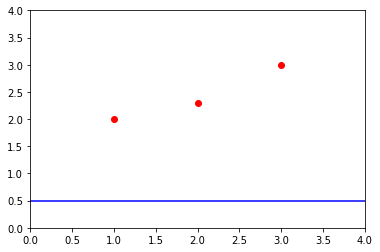



epoch 1:
	loss = 3.9133, w = 0.7560, b = 1.2560
	dL/dw = -8.4000, dL/db = -3.8667


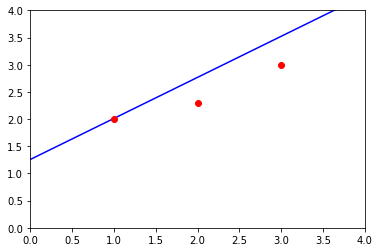



epoch 2:
	loss = 0.1646, w = 0.6048, b = 1.1048
	dL/dw = 1.6800, dL/db = 0.6693


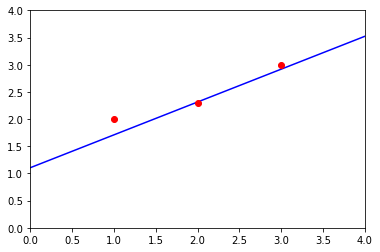



epoch 10:
	loss = 0.0220, w = 0.6300, b = 1.1300
	dL/dw = 0.0000, dL/db = -0.0867


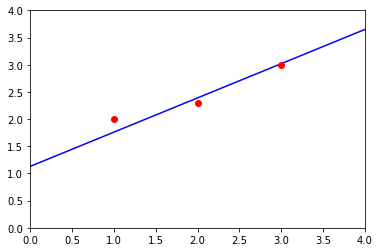



epoch 50:
	loss = 0.0220, w = 0.6300, b = 1.1300
	dL/dw = -0.0000, dL/db = -0.0867


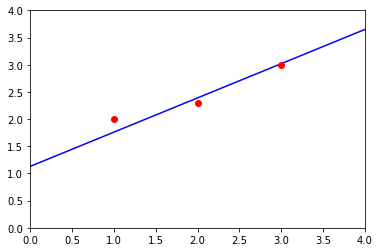



epoch 100:
	loss = 0.0220, w = 0.6300, b = 1.1300
	dL/dw = -0.0000, dL/db = -0.0867


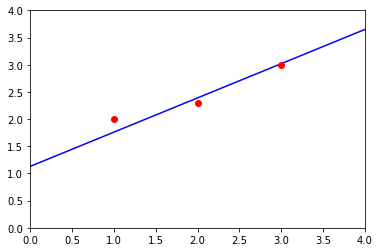



epoch 200:
	loss = 0.0220, w = 0.6300, b = 1.1300
	dL/dw = -0.0000, dL/db = -0.0867


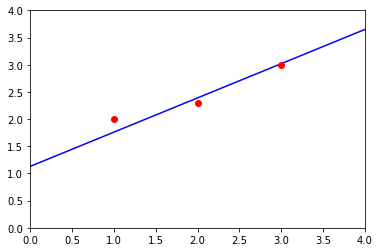



epoch 300:
	loss = 0.0220, w = 0.6300, b = 1.1300
	dL/dw = -0.0000, dL/db = -0.0867


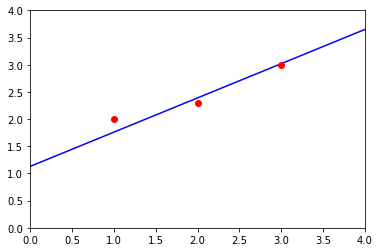



epoch 400:
	loss = 0.0220, w = 0.6300, b = 1.1300
	dL/dw = -0.0000, dL/db = -0.0867


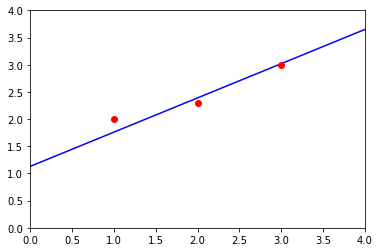



final result:
epoch 500:
	loss = 0.0220, w = 0.6300, b = 1.1300
	dL/dw = -0.0000, dL/db = -0.0867


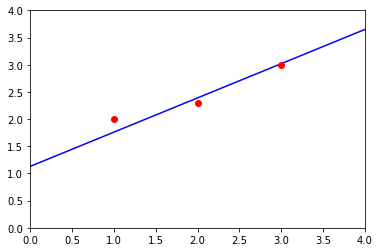

In [22]:
# initialize weight and bias weight (ensure to enable automatic differentiation by using the class Value)
w =  Value(0)  # bitte Code ergaenzen <---------------- [Luecke (13)]
b =  Value(0.5) # bitte Code ergaenzen <---------------- [Luecke (14)]

# set learning rate
learning_rate = 0.09

# show points and initial neuron configuration
print('initial configuration:')
visualize_line(pts, w.data, b.data)
print('\n')

# fit neuron to points
for epoch in range(500):   # train for 500 epochs
    # reset gradients
    w.grad =  0  # bitte Code ergaenzen <---------------- [Luecke (15)]
    b.grad =   0 # bitte Code ergaenzen <---------------- [Luecke (16)]

    # output of neuron (y_i = w * x_i + b) for all three inputs x_1, x_2, and x_3
    y_1 =  w * x_1 + b  # bitte Code ergaenzen <---------------- [Luecke (17)]
    y_2 =  w * x_2 + b  # bitte Code ergaenzen <---------------- [Luecke (18)]
    y_3 =  w * x_3 + b  # bitte Code ergaenzen <---------------- [Luecke (19)]

    # calculate squared error for each sample: squared_error_i = (y_i - t_i) ** 2
    squared_error_1 =  (y_1 - t_1)**2  # bitte Code ergaenzen <---------------- [Luecke (20)]
    squared_error_2 =  (y_2 - t_2)**2  # bitte Code ergaenzen <---------------- [Luecke (21)]
    squared_error_3 =  (y_3 - t_3)**2  # bitte Code ergaenzen <---------------- [Luecke (22)]

    # calculate loss (see formula above, use results for squared_error_i)
    loss = 1/3 * ( squared_error_1 + squared_error_2 + squared_error_3)   # bitte Code ergaenzen <---------------- [Luecke (23)]

    # calculate gradients: call backward function for loss
    loss.backward()    # bitte Code ergaenzen <---------------- [Luecke (24)]

    # update parameters with gradients: w_new = w_old - dL/dw * learning_rate
    w.data = w.data - w.grad * learning_rate   # bitte Code ergaenzen <---------------- [Luecke (25)]
    b.data = b.data - w.grad * learning_rate   # bitte Code ergaenzen <---------------- [Luecke (26)]

    # report progress
    if epoch in [0, 1, 9, 49, 99, 199, 299, 399]:
        print_progress_line()
        visualize_line(pts, w.data, b.data)
        print('\n')

# report final result
print('final result:')
print_progress_line()
visualize_line(pts, w.data, b.data)

<details>
    <summary>&#9432; <i>Überprüfung &nbsp; &nbsp; <font color="CCCCCC">(anklicken, um Lösung anzuzeigen)</font></i></summary>
    <br><i>Augaben bei korrekter Implementierung:</i><br>
    <br><code>initial configuration:</code>
    <br><img src="data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAXwAAAD8CAYAAAB0IB+mAAAABHNCSVQICAgIfAhkiAAAAAlwSFlzAAALEgAACxIB0t1+/AAAADh0RVh0U29mdHdhcmUAbWF0cGxvdGxpYiB2ZXJzaW9uMy4yLjIsIGh0dHA6Ly9tYXRwbG90bGliLm9yZy+WH4yJAAAQ+ElEQVR4nO3dX6ildb3H8ffHaaLMwIvZ4DAzznRATmRgejaTIhwG6YCa5I0XxpTgzaAUGKdD9AeMLrqNUDsOm5KS5hRBISIjIZSUF1rbabRs8jAnMgcH3BmNyUg1ne+5WGtO2zVru56997Nnre3v/YLFfv781loffuhnnv3sZz0rVYUk6a3vgmkHkCSdHxa+JDXCwpekRlj4ktQIC1+SGmHhS1IjOhd+ki1JfpHkkTH7kuSeJMeTPJvkqn5jSpLWazVH+HcBx1bYdwNw2fBxALh/nbkkST3rVPhJdgIfBr6+wpCbgQdr4Eng4iTbe8ooSerB2zqO+yrwGeDdK+zfAby4bP3EcNvJ5YOSHGDwGwDvete7/uW9733vqsJKUuuefvrpP1TV3FqeO7Hwk9wEvFxVTyfZt9KwMdvOuWdDVS0ACwDz8/O1uLi4iqiSpCQvrPW5XU7pXAt8JMnvgO8C1yX59siYE8CuZes7gZfWGkqS1L+JhV9Vn6uqnVW1B7gV+FFVfWxk2MPAbcOrda4GTlXVydHXkiRNT9dz+OdIcgdAVR0EDgM3AseB08DtvaSTJPVmVYVfVY8Djw+XDy7bXsAn+gwmSeqXn7SVpEZY+JLUCAtfkhph4UtSIyx8SWqEhS9JjbDwJakRFr4kNcLCl6RGWPiS1AgLX5IaYeFLUiMsfElqhIUvSY2w8CWpERa+JDXCwpekRlj4ktSIiYWf5B1JfpbkmSTPJfnSmDH7kpxKcnT4uHtj4kqS1qrLd9r+Bbiuql5LshV4IsmjVfXkyLifVtVN/UeUJPVhYuEPv6D8teHq1uGjNjKUJKl/nc7hJ9mS5CjwMvBYVT01Ztg1w9M+jya5vNeUkqR161T4VfX3qvoAsBPYm+T9I0OOALur6grgXuChca+T5ECSxSSLS0tL68ktSVqlVV2lU1V/Ah4Hrh/Z/mpVvTZcPgxsTbJtzPMXqmq+qubn5ubWnlqStGpdrtKZS3LxcPmdwIeA34yMuSRJhst7h6/7Sv9xJUlr1eUqne3At5JsYVDk36uqR5LcAVBVB4FbgDuTnAFeB24d/rFXkjQjulyl8yxw5ZjtB5ct3wfc1280SVKf/KStJDXCwpekRlj4ktQIC1+SGmHhS1IjLHxJaoSFL0mNsPAlqREWviQ1wsKXpEZY+JLUCAtfkhph4UtSIyx8SWqEhS9JjbDwJakRFr4kNcLCl6RGWPiS1IiJhZ/kHUl+luSZJM8l+dKYMUlyT5LjSZ5NctXGxJW0aRw6BHv2wAUXDH4eOjTtRM2b+CXmwF+A66rqtSRbgSeSPFpVTy4bcwNw2fDxQeD+4U9JLTp0CA4cgNOnB+svvDBYB9i/f3q5GjfxCL8GXhuubh0+amTYzcCDw7FPAhcn2d5vVEmbxhe+8I+yP+v06cF2TU2nc/hJtiQ5CrwMPFZVT40M2QG8uGz9xHDb6OscSLKYZHFpaWmtmSXNut//fnXbdV50Kvyq+ntVfQDYCexN8v6RIRn3tDGvs1BV81U1Pzc3t/q0kjaHSy9d3XadF6u6Sqeq/gQ8Dlw/susEsGvZ+k7gpXUlk7R5ffnLcOGFb9x24YWD7ZqaLlfpzCW5eLj8TuBDwG9Ghj0M3Da8Wudq4FRVnew9raTNYf9+WFiA3bshGfxcWPAPtlPW5Sqd7cC3kmxh8A/E96rqkSR3AFTVQeAwcCNwHDgN3L5BeSVtFvv3W/AzZmLhV9WzwJVjth9ctlzAJ/qNJknqk5+0laRGWPiS1AgLX5IaYeFLUiMsfElqhIUvSY2w8CWpERa+JDXCwpekRlj4ktQIC1+SGmHhS1IjLHxJaoSFL0mNsPAlqREWviQ1wsKXpEZY+JLUiC5fYr4ryY+THEvyXJK7xozZl+RUkqPDx90bE1eStFZdvsT8DPDpqjqS5N3A00keq6pfj4z7aVXd1H9ESVIfJh7hV9XJqjoyXP4zcAzYsdHBJEn9WtU5/CR7gCuBp8bsvibJM0keTXL5Cs8/kGQxyeLS0tKqw0qS1q5z4Se5CPg+8KmqenVk9xFgd1VdAdwLPDTuNapqoarmq2p+bm5urZklSWvQqfCTbGVQ9oeq6gej+6vq1ap6bbh8GNiaZFuvSSVJ69LlKp0A3wCOVdVXVhhzyXAcSfYOX/eVPoNKktany1U61wIfB36Z5Ohw2+eBSwGq6iBwC3BnkjPA68CtVVUbkFeStEYTC7+qngAyYcx9wH19hZIk9c9P2kpSIyx8SWqEhS8td+gQ7NkDF1ww+Hno0LQTSb3p8kdbqQ2HDsGBA3D69GD9hRcG6wD7908vl9QTj/Cls77whX+U/VmnTw+2S28BFr501u9/v7rt0iZj4UtnXXrp6rZLm4yFL5315S/DhRe+cduFFw62S28BFr501v79sLAAu3dDMvi5sOAfbPWW4VU60nL791vwesvyCF+SGmHhS1IjLHxJaoSFL0mNsPAlqREWviQ1wsKXpEZY+JLUiC5fYr4ryY+THEvyXJK7xoxJknuSHE/ybJKrNiauzuH92yV11OWTtmeAT1fVkSTvBp5O8lhV/XrZmBuAy4aPDwL3D39qI3n/dkmrMPEIv6pOVtWR4fKfgWPAjpFhNwMP1sCTwMVJtveeVm/k/dslrcKqzuEn2QNcCTw1smsH8OKy9ROc+48CSQ4kWUyyuLS0tLqkOpf3b5e0Cp0LP8lFwPeBT1XVq6O7xzylztlQtVBV81U1Pzc3t7qkOpf3b5e0Cp0KP8lWBmV/qKp+MGbICWDXsvWdwEvrj6c35f3bJa1Cl6t0AnwDOFZVX1lh2MPAbcOrda4GTlXVyR5zahzv3y5pFbpcpXMt8HHgl0mODrd9HrgUoKoOAoeBG4HjwGng9v6jaizv3y6po4mFX1VPMP4c/fIxBXyir1CSpP75SVtJaoSFL0mNsPAlqREWviQ1wsKXpEZY+JLUCAtfkhph4UtSIyx8SWqEhS9JjbDwJakRFr4kNcLCl6RGWPiS1AgLX5IaYeFLUiMsfElqhIUvSY3o8iXmDyR5OcmvVti/L8mpJEeHj7v7jylJWq8uX2L+TeA+4ME3GfPTqrqpl0SSpA0x8Qi/qn4C/PE8ZJEkbaC+zuFfk+SZJI8muXylQUkOJFlMsri0tNTTW0uSuuij8I8Au6vqCuBe4KGVBlbVQlXNV9X83NxcD28tSepq3YVfVa9W1WvD5cPA1iTb1p1MktSrdRd+kkuSZLi8d/iar6z3dSVJ/Zp4lU6S7wD7gG1JTgBfBLYCVNVB4BbgziRngNeBW6uqNiyxJGlNJhZ+VX10wv77GFy2KUmaYX7SVpIaYeFLUiMsfElqhIUvSY2w8CWpERa+JDXCwpekRlj4ktQIC1+SGmHhS1IjLHxJaoSFL0mNsPAlqREWviQ1wsKXpEZY+JLUCAtfkhph4UtSIyYWfpIHkryc5Fcr7E+Se5IcT/Jskqv6jylJWq8uR/jfBK5/k/03AJcNHweA+9cfS5LUt4mFX1U/Af74JkNuBh6sgSeBi5Ns7yugJKkffZzD3wG8uGz9xHDbOZIcSLKYZHFpaamHt5YkddVH4WfMtho3sKoWqmq+qubn5uZ6eGtJUld9FP4JYNey9Z3ASz28riSpR30U/sPAbcOrda4GTlXVyR5eV5LUo7dNGpDkO8A+YFuSE8AXga0AVXUQOAzcCBwHTgO3b1RYSdLaTSz8qvrohP0FfKK3RJKkDeEnbSWpERa+JDXCwpekRlj4ktQIC1+SGmHhS1IjLHxJaoSFL0mNsPAlqREWviQ1wsKXpEZY+JLUCAtfkhph4UtSIyx8SWqEhS9JjbDwJakRFr4kNaJT4Se5PsnzSY4n+eyY/fuSnEpydPi4u/+okqT16PIl5luArwH/BpwAfp7k4ar69cjQn1bVTRuQUZLUgy5H+HuB41X126r6K/Bd4OaNjSVJ6tvEI3xgB/DisvUTwAfHjLsmyTPAS8B/VNVzb/aizz8P+/Z1jSlJWq8uR/gZs61G1o8Au6vqCuBe4KGxL5QcSLKYZPFvf/vb6pJKktalyxH+CWDXsvWdDI7i/19Vvbps+XCS/0yyrar+MDJuAVgAmJ+fr8cfX2tsSWpTxh2Cd9TlCP/nwGVJ3pPk7cCtwMNvDJBLkkGMJHuHr/vK2mNJkvo28Qi/qs4k+STwQ2AL8EBVPZfkjuH+g8AtwJ1JzgCvA7dW1ehpH0nSFGVavTw/P1+Li4tTeW9J2qySPF1V82t5rp+0laRGWPiS1AgLX5IaYeFLUiMsfElqhIUvSY2w8CWpERa+JDXCwpekRlj4ktQIC1+SGmHhS1IjLHxJaoSFL0mNsPAlqREWviQ1wsKXpEZY+JLUCAtfkhrRqfCTXJ/k+STHk3x2zP4kuWe4/9kkV/UfVZK0HhMLP8kW4GvADcD7gI8med/IsBuAy4aPA8D9PeeUJK1TlyP8vcDxqvptVf0V+C5w88iYm4EHa+BJ4OIk23vOKklah7d1GLMDeHHZ+gnggx3G7ABOLh+U5ACD3wAA/pLkV6tKOx3bgD9MO0QH5uzXZsi5GTKCOfv2z2t9YpfCz5httYYxVNUCsACQZLGq5ju8/1SZs1/m7M9myAjm7FuSxbU+t8spnRPArmXrO4GX1jBGkjRFXQr/58BlSd6T5O3ArcDDI2MeBm4bXq1zNXCqqk6OvpAkaXomntKpqjNJPgn8ENgCPFBVzyW5Y7j/IHAYuBE4DpwGbu/w3gtrTn1+mbNf5uzPZsgI5uzbmnOm6pxT7ZKktyA/aStJjbDwJakRG174m+W2DB1y7ktyKsnR4ePuKWR8IMnLK31+YYbmclLOWZjLXUl+nORYkueS3DVmzNTns2POWZjPdyT5WZJnhjm/NGbMLMxnl5xTn89hji1JfpHkkTH71jaXVbVhDwZ/5P0f4J+AtwPPAO8bGXMj8CiDa/mvBp7ayEzryLkPeOR8ZxvJ8K/AVcCvVtg/9bnsmHMW5nI7cNVw+d3Af8/of5tdcs7CfAa4aLi8FXgKuHoG57NLzqnP5zDHvwP/NS7LWudyo4/wN8ttGbrknLqq+gnwxzcZMgtz2SXn1FXVyao6Mlz+M3CMwafDl5v6fHbMOXXDOXptuLp1+Bi9ImQW5rNLzqlLshP4MPD1FYasaS43uvBXuuXCasdstK4Zrhn+KvhoksvPT7RVmYW57Gpm5jLJHuBKBkd7y83UfL5JTpiB+RyegjgKvAw8VlUzOZ8dcsL05/OrwGeA/11h/5rmcqMLv7fbMmywLhmOALur6grgXuChDU+1erMwl13MzFwmuQj4PvCpqnp1dPeYp0xlPifknIn5rKq/V9UHGHzSfm+S948MmYn57JBzqvOZ5Cbg5ap6+s2Gjdk2cS43uvA3y20ZJmaoqlfP/ipYVYeBrUm2nb+InczCXE40K3OZZCuDEj1UVT8YM2Qm5nNSzlmZz2V5/gQ8Dlw/smsm5vOslXLOwHxeC3wkye8YnF6+Lsm3R8asaS43uvA3y20ZJuZMckmSDJf3Mpi7V85zzklmYS4nmoW5HL7/N4BjVfWVFYZNfT675JyR+ZxLcvFw+Z3Ah4DfjAybhfmcmHPa81lVn6uqnVW1h0EX/aiqPjYybE1z2eVumWtWG3dbhmnkvAW4M8kZ4HXg1hr+ufx8SfIdBlcQbEtyAvgigz86zcxcdsw59blkcBT1ceCXw/O5AJ8HLl2Wcxbms0vOWZjP7cC3MvjCpAuA71XVI7P2/3rHnLMwn+foYy69tYIkNcJP2kpSIyx8SWqEhS9JjbDwJakRFr4kNcLCl6RGWPiS1Ij/A0eihqwUMdSEAAAAAElFTkSuQmCC" alt="initial line" />
    <br><code>epoch 1:
	loss = 3.9133, w = 0.7560, b = 0.8480
	dL/dw = -8.4000, dL/db = -3.8667</code>
    <br><img src="data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAXwAAAD8CAYAAAB0IB+mAAAABHNCSVQICAgIfAhkiAAAAAlwSFlzAAALEgAACxIB0t1+/AAAADh0RVh0U29mdHdhcmUAbWF0cGxvdGxpYiB2ZXJzaW9uMy4yLjIsIGh0dHA6Ly9tYXRwbG90bGliLm9yZy+WH4yJAAAgAElEQVR4nO3deXTU5b3H8ffXGDaXeitBuKy3BWvFhSUi1FapRauIUreKsvTgEkG51dvWDUQrCBatiAgCUaigKJdWpVwKt+KCihUrUEAQkahBKMgqm0Eg8L1/PMNtDAmZJJP8ZjKf1zlznOWZyfc8Bz/55TfP7/uYuyMiIjXfUVEXICIi1UOBLyKSJhT4IiJpQoEvIpImFPgiImlCgS8ikibiDnwzyzCzf5jZrBJeMzMbbWZ5ZrbMzNoltkwREams8hzh3wasLOW1i4FWsVsOMK6SdYmISILFFfhm1gS4BHi6lCHdgSkeLABOMLNGCapRREQS4Og4x40C7gSOK+X1xsDaIo/XxZ7bUHSQmeUQ/gLgmGOOaX/KKaeUq1gRkXS3aNGiLe6eVZH3lhn4ZtYN2OTui8ysc2nDSnjusJ4N7p4L5AJkZ2f7woULy1GqiIiY2ZqKvjeeUzrnAJeZWT4wDTjfzJ4rNmYd0LTI4ybA+ooWJSIiiVdm4Lv7Pe7exN1bAD2A1929V7FhM4E+sdU6HYEd7r6h+GeJiEh04j2Hfxgz6wfg7uOB2UBXIA8oAPompDoREUmYcgW+u88D5sXujy/yvAO3JrIwERFJrAof4YuISPVxh7lzK/cZaq0gIpLE3OEvf4FOneCnP63cZynwRUSSkDv8+c+QnQ3dusHGjTBhQuU+U4EvIpJEDh6EP/0J2rSBn/0Mdu6ESZPg448hJ6dyn63AFxFJAgcOwAsvwOmnw9VXw9698OyzsHIl9O0LmZmV/xkKfBGRCBUWhmBv3Rquuw7MQvCvWAG9esHRCVxao8AXEYnA/v3hVM0pp0CfPlCnTjiVs2wZ9OgBGRmJ/5lalikiUo327oXJk+GhhyA/H9q3D1/OXnppOLqvSjrCFxGpBl9/DWPHQsuWcPPNcNJJYbnl++/DZZdVfdiDjvBFRKpUQQHk5sLDD8OGDfDDH4ZTOV26VE/IF6XAFxGpArt3w/jx8MgjsGkT/PjH8PzzcN551R/0hyjwRUQSaOfOcOpm5EjYsgUuvBAGDw5H9lFT4IuIJMD27fDEE/DYY/Dll9C1awj6jh2jruxfFPgiIpWwbRuMGgWPPx6O7rt3h3vvDS0Rko0CX0SkAjZvDqdtxowJ5+uvvDIEfZs2UVdWOgW+iEg5bNwIv/89PPkk7NkD11wDgwbBaadFXVnZFPgiInFYvz4srZwwAfbtC20QBg0KV8qmCgW+iMgRfP45jBgBEyeGvjd9+sDAgeECqlRT5pW2ZlbHzP5uZkvNbIWZPVDCmM5mtsPMlsRu91VNuSIi1eOzz8IVsS1bwlNPwS9+AatXh4umUjHsIb4j/L3A+e6+28wygflmNsfdFxQb97a7d0t8iSIi1ScvD4YPhylTQgOznBy4805o1izqyiqvzMCPbVC+O/YwM3bzqixKRKS6rVoFw4bB1KlQqxYMGAB33AGNG0ddWeLE1TzNzDLMbAmwCZjr7u+VMKxT7LTPHDNrndAqRUSqyIoVcO218P3vw4svwq9+FU7njBpVs8Ie4gx8dz/g7m2AJkAHMyu+AGkx0NzdzwSeAGaU9DlmlmNmC81s4ebNmytTt4hIpSxdClddFZZTzpoFd90V2hU/8gg0bBh1dVWjXO2R3X07MA+4qNjzO919d+z+bCDTzOqX8P5cd8929+ysrKyKVy0iUkGLFoW9Ytu0gblzQ/uD/PzQn76mx1I8q3SyzOyE2P26QBfgo2JjGpqF/m9m1iH2uVsTX66ISMUsWACXXBJaHrz1FgwZAmvWhP+eeGLU1VWPeFbpNAImm1kGIcinu/ssM+sH4O7jgauA/mZWCOwBesS+7BURidT8+TB0KLzySgj24cPh1lvh+OOjrqz6xbNKZxnQtoTnxxe5PwYYk9jSREQqxh3efDMcvb/xBjRoEM7N9+sHxx4bdXXR0ZW2IlJjuMOrr4agnz8fGjUK7YpzcqBevairi54CX0RSnjvMmRNO3SxYAE2ahC6WN9wAdepEXV3y0CbmIpKy3GHmTDjrrPCF7IYNoblZXl44T6+w/yYFvoiknIMHw0VSbduGDUe+/DI0N1u9Opy+qV076gqTkwJfRFLGgQMwbRqccUa4aGrPntDzZtUquP56yMyMusLkpsAXkaRXWAjPPQetW4c2CO7w/PPw4YfQuzccrW8j46LAF5GktX8//OEPoc9N797hVM0f/wgffBCCPyMj6gpTi34vikjS2bcPJk8OF0nl50O7dvDyy3DZZXCUDlMrTFMnIknj66/DXrEtW4YvXxs0CI3NFi4M/W8U9pWjI3wRidyePZCbG/aMXb8ezjkHnn4aLrgAQpcuSQQFvohE5quvYPz40PZg40bo3Dl8Odu5s4K+KijwRaTa7doFY8fCo4/Cli3QpQtMnw7nnht1ZTWbAl9Eqs2OHfDEE6G/zbZtcPHFoR99p05RV5YeFPgiUuW2bYPHHw+3HTvCapt77w0tEaT6KPBFpMps2QIjR4ZGZrt2wRVXhKBve1jDdakOCnwRSbiNG8P5+SefhIIC+PnPYdAgOP30qCtLbwp8EUmY9evDipsJE2Dv3nA17KBB4UpZiZ4CX0Qqbe1aGDEirJ0vLAxtEAYOhFatoq5MilLgi0iF5efD734HkyaFhmZ9+8Ldd8N3vhN1ZVKSMi9UNrM6ZvZ3M1tqZivM7IESxpiZjTazPDNbZmbtqqZcEUkGn3wSdpNq1So0N7vxxrDpSG5ukbCfOhVatAj9EFq0CI8lUvEc4e8Fznf33WaWCcw3sznuvqDImIuBVrHb2cC42H9FpAZZtSo0NJs6NfSev+UWuOOOsKXgN0ydGprhFBSEx2vWhMcAPXtWa83yL2Ue4XuwO/YwM3bzYsO6A1NiYxcAJ5hZo8SWKiJRWbECrrsOTj01tCe+7Tb49NOwrv6wsIfwTe2hsD+koCA8L5GJq/ecmWWY2RJgEzDX3d8rNqQxsLbI43Wx54p/To6ZLTSzhZs3b65ozSJSTZYtg6uvDsspZ84MR/P5+WHJZaMjHdJ9/nn5npdqEVfgu/sBd28DNAE6mNlpxYaU1Oao+F8BuHuuu2e7e3ZWVlb5qxWRarF4MVx+OZx5JrzySjgwX7MmfEHboEEcH9CsWfmel2pRru7S7r4dmAdcVOyldUDTIo+bAOsrVZmIVLv33oNu3aB9e5g3D37723BEP3QonHhiOT5o2DCoV++bz9WrF56XyMSzSifLzE6I3a8LdAE+KjZsJtAntlqnI7DD3TckvFoRqRLvvAMXXQQdO8K774Zczs+H+++Hf/u3Cnxgz55hyU7z5qHPcfPm4bG+sI1UPKt0GgGTzSyD8AtiurvPMrN+AO4+HpgNdAXygAKgbxXVKyIJ9OabMGQIvP46ZGWFi6f694fjjkvAh/fsqYBPMmUGvrsvAw5rdRQL+kP3Hbg1saWJSFVwh9deC0H/9tvQsGFocJaTA8ccE3V1UpV0pa1ImnCHv/41BP2770LjxqE3/Q03QN26UVcn1UFbAovUcO7wP/8DHTqEDUf++U8YNy5cLTtggMI+nSjwRWqogwfhpZegXbuw4ci2baG52erV0K8f1K4ddYVS3RT4IjXMgQPw3/8d1tBfeWXYKHzy5NAW4YYboFatqCuUqCjwRWqIwsLQwua006BHjxD8U6fCypXQpw8crW/s0p4CXyTF7d8fjuBPPRV69QpNzaZPh+XLQ/+bjIyoK5Rkod/5Iilq3z6YMiV0r/zss7BP7EsvQffuoSOxSHH6ZyGSYvbuDatsWrWCm26C+vXDKpxFi0L/G4W9lEZH+CIpYs8eeOopePjhsLSyU6fQreDCC0P3ApGyKPBFktxXX4VNwR9+GDZuhHPPDefszz9fQS/lo8AXSVK7dsGTT4be85s3w09+EpZbnnde1JVJqlLgiySZHTtgzJjQ32bbttDFcvBg+MEPoq5MUp0CXyRJfPll2DLw8cdh+/bQl37w4NASQSQRFPgiEdu6FR57DEaPDqdxLr8c7r03tEQQSSQFvkhENm0K5+fHjg37e191VQj6M86IujKpqRT4ItVswwZ45BEYPz6sqe/RI+wZe+qpUVcmNZ0CX6SarFsXllbm5oa+N716wcCBcPLJUVcm6UKBL1LF1qyB3/0OJk0KLYt/8Qu45x747nejrkzSTTybmDc1szfMbKWZrTCz20oY09nMdpjZktjtvqopVyR1fPppaH3QsiVMnAjXXw95eaEnvcJeohDPEX4h8Gt3X2xmxwGLzGyuu39YbNzb7t4t8SWKpJaPPw4NzZ57LrQk7tcP7rwTmjaNujJJd/FsYr4B2BC7v8vMVgKNgeKBL5LWPvwQhg2DadPCblK//CXccQc0ahR1ZSJBufrqmVkLoC3wXgkvdzKzpWY2x8xal/L+HDNbaGYLN2/eXO5iRZLRBx/ANdeEjUf+/Gf4zW8gPz9cKauwl2QSd+Cb2bHAi8Dt7r6z2MuLgebufibwBDCjpM9w91x3z3b37KysrIrWLJIU/vEPuOKKsG5+zpzwRWx+PowYAQ0aRF2dyOHiCnwzyySE/VR3f6n46+6+0913x+7PBjLNrH5CKxVJEu+/HzYFb9cOXn8d7r8/BP2wYaE3vUiyKvMcvpkZMBFY6e4jSxnTENjo7m5mHQi/SLYmtFKRiP3tbzB0KPzv/8K3vw0PPggDBsC3vhV1ZSLxiWeVzjlAb+ADM1sSe24g0AzA3ccDVwH9zawQ2AP0cHevgnpFqt1bb8GQIfDaa5CVFdbU33ILHHdc1JWJlE88q3TmA0fcZsHdxwBjElWUSNTcw+maoUPhzTfhpJNC35ubb4Zjjom6OpGK0ZW2IkW4wyuvhCP6v/0N/v3fQ7vim26CunWjrk6kcrTdsQgh6GfNgrPPDhuOrF0bdpv65JOwnl5hLzWBAl/S2sGD8PLL0L49XHop/OCzqez8dgvWrDuK/iNaUOfFqVGXKJIwCnxJSwcPwh//CG3ahLX0u3bBvJypPFaQw3Hb1mDuoetZTg5MVehLzaDAl7Ry4AA8/3y4KvbnP4f9+0PPm5Ur4by/DsIKCr75hoKC0KxepAZQ4EtaKCyEKVPCJiM9e0JGRuh5s3x5eHz00cDnn5f85tKeF0kxCnyp0fbtC62Jv/e90Ie+bl148UVYujT0v8nIKDK4WbOSP6S050VSjAJfaqS9e8MWgiefDDfeGK6MnTnzX/1vjirpX/6wYVCv3jefq1cvPC9SAyjwpUb5+msYMyZsMNK/f+hWOXs2/P3vYRWOHekSwp49w/6DzZuHgc2bh8c9e1Zb/SJVSRdeSY1QUAATJoQ9Y7/4An70I3jmGfjJT8oI+eJ69lTAS42lwJeUtnt3uEDq0Udh0yY4//zwZex550VdmUjyUeBLStq5M5y6GTkStm6FCy+EwYPhhz+MujKR5KXAl5Ty5ZcwejSMGgXbt8Mll4SgP/vsqCsTSX4KfEkJW7eGkB89Ohzdd+8egr59+6grE0kdCnxJaps2hdM2Y8fCV1/BlVfCvffCmWdGXZlI6lHgS1L64gt45JGwln7PHujRI3Q4aN066spEUpcCX5LKP/8Zllbm5oY+N9ddBwMHwimnRF2ZSOpT4EtS+PzzsHXgxImhk2WfPnDPPdCyZdSVidQcZV5pa2ZNzewNM1tpZivM7LYSxpiZjTazPDNbZmbtqqZcOczUqdCiRegV0KJFyrXy/eyz0IG4ZUt4+mno2xdWrw7Br7AXSax4jvALgV+7+2IzOw5YZGZz3f3DImMuBlrFbmcD42L/lao0dWpIy0MtfQ/1b4ekv1p09WoYPhyefTZ0qszJgbvugqZNo65MpOYq8wjf3Te4++LY/V3ASqBxsWHdgSkeLABOMLNGCa9WvmnQoH+F/SFJ3r995Uro1Suck582Df7zP+HTT8NFVAp7kapVrnP4ZtYCaAu8V+ylxsDaIo/XxZ7bUOz9OUAOQDO1nK28FOrfvnw5PPggTJ8eWhT/6lfw619Dw4ZRVyaSPuLulmlmxwIvAre7+87iL5fwFj/sCfdcd8929+ysrKzyVSqHS4H+7UuWhLXzp58Of/kL3H035OeHJZcKe5HqFVfgm1kmIeynuvtLJQxZBxT9g7wJsL7y5ckRJXH/9oULw9WwbdvCa6/BffeFrxiGDwf9rheJRjyrdAyYCKx095GlDJsJ9Imt1ukI7HD3DaWMlURJwv7t774LXbvCWWfB22/DkCHhiP6BB8ImJCISnXjO4Z8D9AY+MLMlsecGAs0A3H08MBvoCuQBBUDfxJcqJUqS/u2Hwv3VV6F+fXjoIbjlFjj++KgrE5FDygx8d59Pyefoi45x4NZEFSWpwR3mzQtBP28eNGgQzs336wfHHht1dSJSnK60lXJzh7lzQ9C/807YRnDUKLjppsO/UhCR5KE9bSVu7mGlTceO8NOfhi9hx44N6+hvu01hL5LsFPhSpoMHYcYMyM6Gbt1Cy+IJEyAvL5ynr1Mn6gpFJB4KfCnVwYPwpz+FpZWXXw47dsCkSfDxx6EVQu3aUVcoIuWhwJfDHDgAL7wQLpa6+mrYuzf0vPnoo9DcLDMz6gpFpCIU+PL/CgtDsLduHfrQQwj+FStC/5uj9RW/SEpT4Av794dTNaecEvrQ164dTuV88EHYaSojI+oKRSQRdMyWxvbuhWeeCRuP5OeHDcFnzIBLLw3t9UWkZtH/1mno66/DcsqWLcNFUiedFJZbvv9+6H+jsBepmXSEn0YKCkKrnYcfhg0b4JxzwqmcLl1CKx4RqdkU+Glg924YPz60Pdi0CTp3Dptlde6soBdJJwr8GmznznDq5tFHYetWuOACGDwYfvSjqCsTkSgo8Gug7dth9OjQ3+bLL0O74sGDQ0sEEUlfCvwaZNu2EPKPPx6O7i+7LAR9dnbUlYlIMlDg1wCbN8PIkWEj8N27w5aC994LbdpEXZmIJBMFfgr74gv4/e9h3DjYsweuuQYGDYLTTou6MhFJRgr8FLR+fVhaOWEC7NsX2iAMGhSulBURKY0CP4V8/jmMGAETJ4a+N336wD33QKtWUVcmIqkgnk3MJ5nZJjNbXsrrnc1sh5ktid3uS3yZ6e2zz+Dmm8OVsU89FYL+44/DRVMKexGJVzxH+M8AY4ApRxjztrt3S0hF8v/y8mD4cJgyJTQwu+kmuOsuaNYs6spEJBXFs4n5W2bWoupLkUM++giGDYPnn4datWDAALjjDmjcOOrKRCSVJapNViczW2pmc8ysdWmDzCzHzBaa2cLNmzcn6EfXHCtWwLXXwqmnwksvwX/9VzidM2qUwl5EKi8Rgb8YaO7uZwJPADNKG+juue6e7e7ZWVlZCfjRNcOSJXDVVWE55axZ4bRNfn5YctmwYdTViUhNUenAd/ed7r47dn82kGlm9StdWRpYuDC0I27bFubODRdL5efDQw+Bfh+KSKJVelmmmTUENrq7m1kHwi+RrZWurAZbsACGDoXZs+GEE+CBB+CXvwz3RUSqSpmBb2YvAJ2B+ma2DrgfyARw9/HAVUB/MysE9gA93N2rrOIUNn8+DBkSjuZPPDGswLn1Vjj++KgrE5F0EM8qnWvLeH0MYdmmlMAd3nwzBP0bb0CDBuEq2f794dhjo65ORNKJrrStIu7w6qsh6OfPD1++PvYY5ORAvXpRVyci6Ui7lyaYezg336kTXHhh+BL2iSfg00/h9tsV9iISHQV+grjDzJlw1llwySWhk+X48eFq2QEDoG7dqCsUkXSnwK+kgwfhxRfD0sru3cMOUxMnwurVof9N7dpRVygiEijwK+jAAZg2Dc44I1w0tWcPTJ4Mq1bB9ddDZmbUFYqIfJMCv5wKC+G556B169AG4eDB0PPmww9DF8uj9TW4iCQpBX6c9u+HP/whbDLSu3c4VTN9OixfHoI/IyPqCkVEjkzHo2XYty+cqhk+PKy4adcOXn45bBB+lH5dikgKUWSV4uuv4cknw6YjOTnhgqlZs0L/m5/9TGEvIqlHR/jF7NkDubnhatj16+EHPwi7TF14IZhFXZ2ISMUp8GO++iqsm3/kEdi4Ec47D559Fn78YwW9iNQMaR/4u3bB2LHw6KOwZQt06RK+jD333KgrExFJrLQN/B07QsuDxx6Dbdvg4oth8ODQEkFEpCZKu8Dftg0efzzcduyASy8NQX/WWVFXJiJStdIm8LdsgZEjYcyYcBrniivCDlNt20ZdmYhI9ajxgb9xY9gbdtw4KCiAq68OQX/66VFXJiJSvWps4K9fH1bcTJgAe/eGq2EHDYLvfz/qykREolHjAn/tWhgxAp5+OvS96dULBg6Ek0+OujIRkWiVeb2omU0ys01mtryU183MRptZnpktM7N2iS+zbPn50K8ffPe74ai+d2/4+GN45hmFvYgIxNda4RngoiO8fjHQKnbLAcZVvqz4ffIJ3HADtGoVmpvdeGPYdOSpp+A736nOSkREkls8m5i/ZWYtjjCkOzDF3R1YYGYnmFkjd9+QoBpLtGoVDBsWWhNnZoZNwe+8E5o0qcqfKiKSuhJxDr8xsLbI43Wx5w4LfDPLIfwVQLNmzSr0w1asCEE/bRrUqQO33Qa/+Q00alShjxMRSRuJ6PlYUqcZL2mgu+e6e7a7Z2dlZZXrhyxbFpZUnn562Dv2jjvCeftHH1XYi4jEIxFH+OuApkUeNwHWJ+BzAVi8GIYOhRkz4Ljjwoqb22+H+vUT9RNERNJDIo7wZwJ9Yqt1OgI7EnH+/r33oFs3aN8e5s2D3/4W1qyBBx9U2IuIVESZR/hm9gLQGahvZuuA+4FMAHcfD8wGugJ5QAHQtzIFvfMODBkCr7wC3/52OF9/663wrW9V5lNFRCSeVTrXlvG6A7dWtpA33wxB//rrkJUVLp7q3z+cxhERkcqL9Epbd3jttRD0b78NDRuGL2FvvhmOOSbKykREap7IAn/nTjjnHHj3XWjcGEaPDhdN1a0bVUUiIjVbZIG/enVoajZuHPTtC7VrR1WJiEh6iCzwmzcPvW5q1YqqAhGR9JKIZZkVUr++wl5EpDpFFvgiIlK9FPgiImlCgS8ikiYU+CIiaUKBLyKSJhT4IiJpQoEvIpImFPgiImlCgS8ikiYU+CIiaUKBLyKSJhT4IiJpQoEvIpIm4gp8M7vIzFaZWZ6Z3V3C653NbIeZLYnd7kt8qSIiUhnxbGKeAYwFLgDWAe+b2Ux3/7DY0LfdvVsV1CgiIgkQzxF+ByDP3T91933ANKB71ZYlIiKJFk/gNwbWFnm8LvZccZ3MbKmZzTGz1gmpTkREEiaeLQ6thOe82OPFQHN3321mXYEZQKvDPsgsB8gBaNasWTlLFRGRyojnCH8d0LTI4ybA+qID3H2nu++O3Z8NZJpZ/eIf5O657p7t7tlZWVmVKFtERMornsB/H2hlZv9hZrWAHsDMogPMrKGZWex+h9jnbk10sSIiUnFlntJx90IzGwD8FcgAJrn7CjPrF3t9PHAV0N/MCoE9QA93L37aR0REImRR5XJ2drYvXLgwkp8tIpKqzGyRu2dX5L260lZEJE0o8EVE0oQCX0QkTSjwRUTShAJfRCRNKPBFRNKEAl9EJE0o8EVE0oQCX0QkTSjwRUTShAJfRCRNKPBFRNKEAl9EJE0o8EVE0oQCX0QkTSjwRUTShAJfRCRNKPBFRNKEAl9EJE3EFfhmdpGZrTKzPDO7u4TXzcxGx15fZmbtEl+qiIhURpmBb2YZwFjgYuBU4FozO7XYsIuBVrFbDjAuwXWKiEglxXOE3wHIc/dP3X0fMA3oXmxMd2CKBwuAE8ysUYJrFRGRSjg6jjGNgbVFHq8Dzo5jTGNgQ9FBZpZD+AsAYK+ZLS9XtdGoD2yJuog4qM7ESoU6U6FGUJ2J9r2KvjGewLcSnvMKjMHdc4FcADNb6O7Zcfz8SKnOxFKdiZMKNYLqTDQzW1jR98ZzSmcd0LTI4ybA+gqMERGRCMUT+O8DrczsP8ysFtADmFlszEygT2y1Tkdgh7tvKP5BIiISnTJP6bh7oZkNAP4KZACT3H2FmfWLvT4emA10BfKAAqBvHD87t8JVVy/VmViqM3FSoUZQnYlW4TrN/bBT7SIiUgPpSlsRkTShwBcRSRNVHvip0pYhjjo7m9kOM1sSu90XQY2TzGxTadcvJNFcllVnMsxlUzN7w8xWmtkKM7uthDGRz2ecdSbDfNYxs7+b2dJYnQ+UMCYZ5jOeOiOfz1gdGWb2DzObVcJrFZtLd6+yG+FL3k+A7wC1gKXAqcXGdAXmENbydwTeq8qaKlFnZ2BWdddWrIZzgXbA8lJej3wu46wzGeayEdAudv844OMk/bcZT53JMJ8GHBu7nwm8B3RMwvmMp87I5zNWx6+A50uqpaJzWdVH+KnSliGeOiPn7m8B244wJBnmMp46I+fuG9x9cez+LmAl4erwoiKfzzjrjFxsjnbHHmbGbsVXhCTDfMZTZ+TMrAlwCfB0KUMqNJdVHfiltVwo75iqFm8NnWJ/Cs4xs9bVU1q5JMNcxitp5tLMWgBtCUd7RSXVfB6hTkiC+YydglgCbALmuntSzmccdUL08zkKuBM4WMrrFZrLqg78hLVlqGLx1LAYaO7uZwJPADOqvKryS4a5jEfSzKWZHQu8CNzu7juLv1zCWyKZzzLqTIr5dPcD7t6GcKV9BzM7rdiQpJjPOOqMdD7NrBuwyd0XHWlYCc+VOZdVHfip0pahzBrcfeehPwXdfTaQaWb1q6/EuCTDXJYpWebSzDIJITrV3V8qYUhSzGdZdSbLfBapZzswD7io2EtJMZ+HlFZnEsznOcBlZpZPOL18vpk9V2xMheayqgM/VdoylFmnmTU0M4vd70CYu63VXGdZkmEuy5QMcxn7+ROBle4+spRhkc9nPHUmyXxmmdkJsft1gS7AR8WGJcN8llln1PPp7ve4exN3b0HIotfdvVexYRWay3i6ZVaYV11bhpVFiiQAAACNSURBVCjqvArob2aFwB6gh8e+Lq8uZvYCYQVBfTNbB9xP+NIpaeYyzjojn0vCUVRv4IPY+VyAgUCzInUmw3zGU2cyzGcjYLKFDZOOAqa7+6xk+389zjqTYT4Pk4i5VGsFEZE0oSttRUTShAJfRCRNKPBFRNKEAl9EJE0o8EVE0oQCX0QkTSjwRUTSxP8BduCzxQGZUvEAAAAASUVORK5CYII=" alt="line after epoch 1" />
    <br><code>epoch 2:
	loss = 0.0580, w = 0.7517, b = 0.8612
	dL/dw = 0.0480, dL/db = -0.1467</code>
    <br><img src="data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAXwAAAD8CAYAAAB0IB+mAAAABHNCSVQICAgIfAhkiAAAAAlwSFlzAAALEgAACxIB0t1+/AAAADh0RVh0U29mdHdhcmUAbWF0cGxvdGxpYiB2ZXJzaW9uMy4yLjIsIGh0dHA6Ly9tYXRwbG90bGliLm9yZy+WH4yJAAAgAElEQVR4nO3deZRU5bX+8e8OtgOCEoUAAYEoRCMOiB2CQ5R4TRBR0UhUBAdUUJTrrNeB6DXOoqjIJCgKihKIaLgEjMYJWS40zSQIKkQRUAKIYQoIAvv3xy5/dtqGru6u7lPV9XzWqmUNb1fv9SqPh3Pe825zd0REpOb7QdIFiIhI9VDgi4jkCQW+iEieUOCLiOQJBb6ISJ5Q4IuI5Im0A9/MapnZLDObVMpnZmYDzWyRmb1vZm0zW6aIiFRWeY7wrwIW7OCzTkCr1KM3MLSSdYmISIalFfhm1hToDDyxgyFdgNEepgP1zKxxhmoUEZEM2CXNcY8ANwJ1d/B5E2BpsdfLUu8tLz7IzHoTfwNgzz33PPKggw4qV7EiIvluxowZX7p7g4r8bJmBb2anACvdfYaZddjRsFLe+96eDe4+HBgOUFhY6EVFReUoVUREzOyziv5sOqd0jgFOM7PFwFjgBDN7tsSYZcB+xV43Bb6oaFEiIpJ5ZQa+u9/s7k3dvQVwDvC6u/coMWwicH5qtU57YK27Ly/5XSIikpx0z+F/j5ldBuDuw4DJwMnAImAj0DMj1YmISMaUK/Dd/U3gzdTzYcXed+CKTBYmIiKZpTttRURyxIoVlft5Bb6ISJb7/HO46ipo0aJy36PAFxHJUp99Bn36wP77w5Ah0K1b5b5PgS8ikmUWLYKLL4aWLeHJJ6FnT1i4EEaOrNz3VniVjoiIZNaHH8Ldd8Nzz8Guu8bR/Y03QtOmmfl+Bb6ISMLmzoW77oLx42GPPeCaa+D666FRo8z+HgW+iEhCZs6EO++El16CunXhppsi7BtUaKecsinwRUSq2fTpEfSTJ0O9enD77XDllbDPPlX7exX4IiLVZOrUCPq//Q323TfO119xBey9d/X8fgW+iEgVcofXXougnzoVGjaE/v3hssugTp3qrUWBLyJSBdxhypQI+unToUkTePRR6NUrLswmQevwRUQyaPv2uAj7859D586wfDkMHQr/+Eecp08q7EGBLyKSEdu2wbhx0KYNnHEGrFkTN00tXBinb3bbLekKFfgiIpWydSs8+ywccgicfTZ88w0880zcRHXRRVBQkHSF31Hgi4hUwJYtsdXBQQfBeedFsI8bB/PmQY8esEsWXiHNwpJERLLX5s0R9PfdB0uWQNu28OKLcNpp8IMsP4RW4IuIpGHTJhgxAh54ILYrbt8+LsZ26gRmSVeXHgW+iMhObNgAw4bBgw9GA5Ljj4dRo+CEE3In6L9VZuCb2e7AVGC31Pg/ufvtJcZ0AP4MfJp6a4K7/yGzpYqIVJ+1a2HQIHj4YVi9Gk48Mc7RH3dc0pVVXDpH+JuBE9x9g5kVANPMbIq7Ty8x7m13PyXzJYqIVJ+vvoobpAYOjKWVnTtDv35xCifXlRn4qQblG1IvC1IPr8qiRESq26pVMGAADB4M69fHWvp+/eKibE2R1jVlM6tlZrOBlcCr7v5uKcOOMrM5ZjbFzFpntEoRkSqyfDlcd130i73/fjj5ZHj/fZgwoWaFPaR50dbdtwFtzKwe8KKZHeLu84oNmQk0T532ORl4CWhV8nvMrDfQG6BZs2aVLl5EpKKWLo0VNyNGxM1T554Lt9wS6+prqnKtGnX3NcCbwEkl3l/n7htSzycDBWZWv5SfH+7uhe5e2KCqdvgXEdmJTz+FSy+FAw6I1Tc9esBHH8Ho0TU77CGNwDezBqkje8xsD+BE4MMSYxqZxQIlM2uX+t7VmS9XRKRiFi6MZuCtWsHTT8Mll0Sz8CeeiPDPB+mc0mkMjDKzWkSQj3P3SWZ2GYC7DwO6An3MbCuwCTgndbFXRCRR8+dHo5GxY6MxeN++cMMNsV1xvrGkcrmwsNCLiooS+d0iUvPNmRONwV94AWrXhssvj4uzDRsmXVnlmNkMdy+syM/qTlsRqVGKiqLpyMSJsNdecSH26quh/veuKuYfBb6I1AjvvBNB//LL8MMfwh13RMORevWSrix7KPBFJGe5w1tvRdC//nocxd97b5y+2WuvpKvLPgp8Eck57vDqqxH006ZBo0bw0EOx3HLPPZOuLnsp8EUkZ7jDX/4SQf/ee9C0KTz2GFx8cbK9YnNFlm/XLyISjcEnTIAjj4RTT4WVK+Hxx2Mdfd++Cvt0KfBFJGtt2xbr5w87DM48M/amf+op+Phj6N07OxqD5xIFvohkna1bY6uD1q2hW7c4lTNmDCxYABdemF2NwXOJAl9EssaWLbHVwYEHwgUXwO67w/jxMHdubG5Wq1bSFeY2Bb6IJO7rr2HIEGjZEnr1gn32gT//GWbNgq5ds785eK7QKh0RSczGjTB8eGxTvHw5HH10vO7YMff6xeYCBb6IVLv162Ho0Fg7v3IldOgQ5+g7dFDQVyUFvohUmzVrYt38I49E79iOHaON4LHHJl1ZflDgi0iVW706Qv6xx2Dt2lhL368ftGuXdGX5RYEvIlVm5co4bTNkSKyhP/PMCPo2bZKuLD8p8EUk4774Avr3j7thN2+Gs8+GW2+NdfWSHAW+iGTMkiVw//3w5JNx81SPHrEf/U9/mnRlAgp8EcmATz6JbYlHjYrXF14IN90E+++faFlSggJfRCrso4/gnntiSeUuu8T+NjfeCM2aJV2ZlKbM+9fMbHcze8/M5pjZB2Z2RyljzMwGmtkiM3vfzNpWTbkikg3mzYs9bn72s9j64Mor4yh/0KBiYT9mDLRoEbfJtmgRryVR6RzhbwZOcPcNZlYATDOzKe4+vdiYTkCr1OMXwNDUP0WkBpk1KxqDT5gAderE0fy118KPflRi4Jgxcbi/cWO8/uyzeA3QvXu11izfKfMI38OG1MuC1MNLDOsCjE6NnQ7UM7PGmS1VRJLy3nuxdr5tW3jtNfj972HxYrjvvlLCHmJJzrdh/62NG+N9SUxaWxKZWS0zmw2sBF5193dLDGkCLC32elnqvZLf09vMisysaNWqVRWtWUSqybRpcTfsL37xXZPwxYvhD3+AfffdyQ8uWVK+96VapBX47r7N3dsATYF2ZnZIiSGl7X5R8m8BuPtwdy9098IGDRqUv1oRqXLu0RD8V7+CX/4SZs+OpZaLF8dNU/XqpfElO7pqq6u5iSrXpqPuvgZ4EzipxEfLgP2KvW4KfFGpykSkWrnDyy/Hvjb/9V+xAufhh+HTT+Ncfd265fiyu++G2rX/873ateN9SUw6q3QamFm91PM9gBOBD0sMmwicn1qt0x5Y6+7LM16tiGScO0ycGPvadOoES5fC4MGx6ubqq7+f22np3j32OW7ePLa/bN48XuuCbaLSWaXTGBhlZrWI/0GMc/dJZnYZgLsPAyYDJwOLgI1AzyqqV0Qy5NvG4HfdBXPmxE1SI0bA+efDrrtm4Bd0766AzzJlBr67vw8cUcr7w4o9d+CKzJYmIlVh2zb44x/j7Mr8+bHtwahR0UJwF92KWaOpcZhInvjmG3j66bhZqnv3ONPy/PMR+uefr7DPB/pXLFLDbd4cR/D33hsrbY44Al54AU4/Xb1i843+dYvUUJs2xVYHLVvCpZdCw4YwaRLMmAG//a3CPh/pCF+khvn3v2HYMHjwQfjnP2Mt/ciRcOKJ6heb7xT4IjXEunWxnHLAAPjySzjhBBg7Fo4/PunKJFso8EVy3L/+BQMHwqOPxvNOneKO2KOPTroyyTYKfJEc9eWXcSfsoEFxdN+lSwR9YWHSlUm2UuCL5JgVK+L8/NChsQFl166xCeXhhyddmWQ7Bb5Ijvj8c3jggdihYMuWaEByyy1w8MFJVya5QoEvkuU++yz2nR85MrZDOO88uPlmaNUq6cok1yjwRbLUokVxs9To0bGc8qKLojF4ixZJVya5SoEvkmU+/DD2uXnuudjErE+f2J64adOkK5Ncp8AXyRJz58bOlePHwx57wDXXwPXXQ6NGSVcmNYUCXyRhM2ZE0L/0UjQZuemmCHs1hZNMU+CLJGT69OgRO3lytA28/Xa48krYZ5+kK5OaSoEvUs2mTo2g/9vfohH43XfDFVfA3nsnXZnUdAp8kWrgDq+9FkE/dWrsXNm/P1x2GdSpk3R1ki8U+CJVyB2mTImgnz4dmjSJPW969YoLsyLVKZ0m5vuZ2RtmtsDMPjCzq0oZ08HM1prZ7NTjtqopVyQ3bN8eF2F//nPo3BmWL4+tEP7xjzhPr7CXJKRzhL8VuM7dZ5pZXWCGmb3q7vNLjHvb3U/JfIkiuWPbtugmddddsczygAPgySfj7tiCgqSrk3xX5hG+uy9395mp5+uBBUCTqi5MJJds3QrPPguHHAJnnx39Y595Jm6iuugihb1kh3I1OTOzFsARwLulfHyUmc0xsylm1noHP9/bzIrMrGjVqlXlLlYk22zZEnvcHHTQd0fx48bBvHnQo4cag0t2STvwzawO8AJwtbuvK/HxTKC5ux8OPAa8VNp3uPtwdy9098IGuqtEctjmzXFOvlUruPjiWFL54oswezb87ndQq1bSFYp8X1qBb2YFRNiPcfcJJT9393XuviH1fDJQYGb1M1qpSBbYtCm6Sx1wAFx+Ofz4x/CXv0BREZx+uhqDS3Yr8y+cZmbAk8ACdx+wgzGNgBXu7mbWjvgfyeqMViqSoA0bvmsMvmJF9IkdNSr6xqoxuOSKdM4wHgOcB8w1s9mp924BmgG4+zCgK9DHzLYCm4Bz3N2roF6RarV2bbQQfPhhWL0afv3raCN43HFJVyZSfmUGvrtPA3Z6DOPug4BBmSpKJGlffRU3SA0cCGvWxFr6fv2gffukKxOpOK0hEClm1SoYMAAGD4b16+GMMyLo27ZNujKRylPgixB3wj74YJyn37QJzjorGoMfemjSlYlkjtYUSF5buhT++7/hJz+JUzgPHjGGzY1bMHbcDzj01BYwZkzSJYpkjI7wJS99+mk0Bn/qqdjg7IIL4O7WY2jYrzds3BiDPvsMeveO5927J1esSIboCF/yysKF0LNn3DD19NNwySXRLPyJJ6Dho7d+F/bf2rgxzu2I1AA6wpe8MH9+NBoZOzYag/ftCzfcENsV/39LlpT+wzt6XyTH6AhfarQ5c2Krg0MOgT//Ga67DhYvhkceKRH2AM2alf4lO3pfJMco8KVGKiqCLl2gTRt45RW45ZYI+gceiG5Tpbr7bqhd+z/fq1073hepART4UqO88w506hSNR95+G+64I6693nUX1C9rd6fu3WH4cGjePPZLaN48XuuCrdQQOocvOc8d3nor2gi+/noE+733xuZme+1Vzi/r3l0BLzWWAl9ylju8+moE/bRp0KgRPPQQXHop7Lln0tWJZB8FvuQc99iS+M474b33oGlTeOyx2JdevWJFdkzn8CVnbN8OEybAkUfCqafCypXw+OOxjr5vX4W9SFkU+JL1tm2L9fOHHQZnnhl70z/1FHz8cdwIu9tuSVcokhsU+JK1tm6F0aOhdWvo1i1O5YwZAwsWwIUXqjG4SHkp8CXrbNkSWx0ceGDscbP77jB+PMydC+eeq36xIhWlwJes8fXXMGQItGwJvXrBvvvCxIkwaxZ07ap+sSKVpVU6kriNG+Pia//+sS/9McfAiBHwm9+oX6xIJpV5zGRm+5nZG2a2wMw+MLOrShljZjbQzBaZ2ftmpv5A1WXMGGjRIg5/W7TIqf3b16+H+++Psq+9Nk7hvP563CHbsaPCXiTT0jnC3wpc5+4zzawuMMPMXnX3+cXGdAJapR6/AIam/ilVacyYWKaSY/u3r1kT6+YfeSR6x3bsGG0Ejz026cpEarYyj/Ddfbm7z0w9Xw8sAEruM9gFGO1hOlDPzBpnvFr5T7fm1v7tq1fD738fR/S33Ranbt59F15+WWEvUh3KdQ7fzFoARwDvlvioCbC02OtlqfeWl/j53kBvgGbacrbycmT/9pUrY8uDIUNiDf2ZZ8YRfZs2SVcmkl/SXvdgZnWAF4Cr3X1dyY9L+RH/3hvuw9290N0LGzRoUL5K5fuyfP/2L76Aa66JI/oHH4y7Y+fNgz/9SWEvkoS0At/MCoiwH+PuE0oZsgzYr9jrpsAXlS9PdipL929fsgSuuAL23z/O1Z91Vtws9dxzcROViCQjnVU6BjwJLHD3ATsYNhE4P7Vapz2w1t2X72CsZEqW7d/+ySexfr5ly1hWef75sf3B00/DT3+aSEkiUkw65/CPAc4D5prZ7NR7twDNANx9GDAZOBlYBGwEema+VClVFuzf/tFHcM89sWhol11iodCNN2bNmSURSSkz8N19GqWfoy8+xoErMlWU5IZ58+Ls0R//GNsfXHklXH89/PjHSVcmIqXRnbZSbrNmRcvACROgTp04mr/2WvjRj5KuTER2RoEvaXvvvWg6MmkS7L13rKm/6qrY80ZEsp8CX8o0bVoE/SuvwD77xPO+faFevaQrE5HyUOBLqdzhjTci3N98M07X3H8/9OkDdesmXZ2IVIQCX/6DO/z1rxH077wDjRvDww/HypuSS/5FJLco8AWIoP+//4ugLyqC/faDwYPhootiBY6I5D61lMhz27fHVgdHHAFdusTulSNGRGPwyy9X2IvUJAr8PLVtW2x1cOih8LvfwaZNMGpU3ER1ySWw665JVygimabAzzPffBNbHfzsZ3GDrhk8/zzMnx9bIeyik3wiNZb+eOeJzZsj6O+7DxYvjlM4L7wAp5+uXrEi+UJ/1Gu4TZtg0KDY0Oyyy6Bhw7hxasYM+O1vFfYi+URH+DXUv/8Nw4bFPvT//Cf88pcwciSceKJ6xYrkKwV+DbNuXSynHDAAvvwSTjgBxo6F449PujIRSZoCv4b4179g4EB49NF43qlTtBE8+uikKxORbKHAz3Fffhl3wg4aFEf3XbpE0BcWJl2ZiGQbBX6OWrEizs8PHQobN0LXrnDrrXD44UlXJiLZSoGfYz7/HB54IDoZbtkC3brBLbfAwQcnXZmIZDsFfo747LNYQz9yZGyHcN55cPPN0KpV0pWJSK5Ip4n5SDNbaWbzdvB5BzNba2azU4/bMl9m/lq0CC6+ONbRP/kk9OwJCxdG8CvsRaQ80jnCfxoYBIzeyZi33f2UjFQkAHz4YfSLfe652NemT59oJdi0adKViUiuSqeJ+VQza1H1pQjA3LnRL3b8eNhjD7jmmmgM3qhR0pWJSK7L1I31R5nZHDObYmatdzTIzHqbWZGZFa1atSpDv7pmmDEDzjgDDjsMpkyBm26KPW8efFBhLyKZkYnAnwk0d/fDgceAl3Y00N2Hu3uhuxc2aNAgA786902fDp07x7r5N9+E22+PoL/nHtAUiUgmVTrw3X2du29IPZ8MFJhZ/UpXVsNNnQq//jUcdRS8+26cr1+8GP73f6NRuIhIplV6WaaZNQJWuLubWTvifyKrK11ZDeQOr70WbQSnTo2dK/v3j10s69RJujoRqenKDHwzex7oANQ3s2XA7UABgLsPA7oCfcxsK7AJOMfdvcoqzkHucV7+zjvjFE6TJrHnTa9ecWFWRKQ6pLNKp1sZnw8ilm1KCdu3w8SJsepmxgxo3jy2QujZE3bbLenqRCTfqP1FFdi2DcaNgzZtYuXNmjVx09TChXH6RmEvIklQ4GfQ1q3w7LNwyCFw9tnRP/aZZ+ImqosugoKCpCsUkXymwM+ALVtiq4ODDoo9bgoK4gh/3jzo0UONwUUkOyiKKmHz5gj6++6DJUugbVt48UU47TT1ihWR7KPAr4BNm2DEiNim+PPPoX37uBjbqZP6xYpI9lLgl8OGDd81Bl+xIvrEjhoVfWMV9CKS7RT4aVi7NloIPvwwrF4dd8j26wfHHZd0ZSIi6VPg78RXX8UNUgMHxtLKzp0j6Nu3T7oyEZHyU+CXYtUqGDAABg+G9etjLX2/fnFRVkQkVynwi1m+PM7PDxsWF2bPOisagx96aNKViYhUngIfWLo0VtyMGBE3T517bjQGP+igpCsTEcmcvA78Tz+NNfRPPRUbnF1wQTQGP+CApCsTEcm8vAz8hQujwcgzz0CtWnDJJfA//xObm4mI1FR5Ffjz50ejkbFjozF4375www2xXbGISE2XF4E/Z05sUfzCC1C7Nlx3XTwaNky6MhGR6lOjA7+oKJqOTJwIe+0VF2KvvhrqqwGjiOShGhn477wTQf/yy/DDH8Idd8CVV0K9eklXJiKSnBoT+O7w1lsR9K+/Hkfx994Ll18eR/ciIvmuzE18zWykma00s3k7+NzMbKCZLTKz982sWu9HdYdXXol9bX71q7gw+9BDsHgx3HSTwl5E5Fvp7Nr+NHDSTj7vBLRKPXoDQytfVtncYdKk2NemY8cI+Mceg08+gWuvhT33rI4qRERyR5mB7+5Tga92MqQLMNrDdKCemTXOVIElbd8OEybAkUfCqafCypXw+OOwaFEss9xjj6r6zSIiuS0TfZmaAEuLvV6Weu97zKy3mRWZWdGqVavK9Uu2bYv184cdBmeeGXvTP/UUfPwx9O6txuAiImXJROCX1vrDSxvo7sPdvdDdCxs0aJDWl2/dCqNHQ+vW0K1bnMoZMwYWLIALL1RjcBGRdGUi8JcB+xV73RT4orJfumULPPEEHHhg7HGz++4wfjzMnRubm9WqVdnfICKSXzIR+BOB81OrddoDa919eUW/7OuvYcgQaNkSevWCffeNG6dmzYKuXdUcXESkospch29mzwMdgPpmtgy4HSgAcPdhwGTgZGARsBHoWZFCNm6Mi6/9+8e+9MccE9sV/+Y36hcrIpIJZQa+u3cr43MHrqhoAevXxxH9Qw9Fp6kOHeIcfYcOCnoRkUxK7E7bbdvirthHHonesR07RhvBY49NqiIRkZotscCfOxdmz4619P36Qbt2SVUiIpIfEgv8unXhjTegTZukKhARyS+JrXk54ACFvYhIddIiRxGRPKHAFxHJEwp8EZE8ocAXEckTCnwRkTyhwBcRyRMKfBGRPKHAFxHJEwp8EZE8ocAXEckTCnwRkTyhwBcRyRMKfBGRPKHAFxHJE2kFvpmdZGYfmdkiM7uplM87mNlaM5udetyW+VJFRKQy0mliXgsYDPwaWAb83cwmuvv8EkPfdvdTqqBGERHJgHSO8NsBi9z9E3ffAowFulRtWSIikmnpBH4TYGmx18tS75V0lJnNMbMpZtY6I9WJiEjGpNPT1kp5z0u8ngk0d/cNZnYy8BLQ6ntfZNYb6A3QrFmzcpYqIiKVkc4R/jJgv2KvmwJfFB/g7uvcfUPq+WSgwMzql/widx/u7oXuXtigQYNKlC0iIuWVTuD/HWhlZj8xs12Bc4CJxQeYWSMzs9TzdqnvXZ3pYkVEpOLKPKXj7lvNrC/wV6AWMNLdPzCzy1KfDwO6An3MbCuwCTjH3Uue9hERkQRZUrlcWFjoRUVFifxuEZFcZWYz3L2wIj+rO21FRPKEAl9EJE8o8EVE8oQCX0QkTyjwRUTyhAJfRCRPKPBFRPKEAl9EJE8o8EVE8oQCX0QkTyjwRUTyhAJfRCRPKPBFRPKEAl9EJE8o8EVE8oQCX0QkTyjwRUTyhAJfRCRPKPBFRPJEWoFvZieZ2UdmtsjMbirlczOzganP3zeztpkvVUREKqPMwDezWsBgoBNwMNDNzA4uMawT0Cr16A0MzXCdIiJSSekc4bcDFrn7J+6+BRgLdCkxpgsw2sN0oJ6ZNc5wrSIiUgm7pDGmCbC02OtlwC/SGNMEWF58kJn1Jv4GALDZzOaVq9pk1Ae+TLqINKjOzMqFOnOhRlCdmXZgRX8wncC3Ut7zCozB3YcDwwHMrMjdC9P4/YlSnZmlOjMnF2oE1ZlpZlZU0Z9N55TOMmC/Yq+bAl9UYIyIiCQoncD/O9DKzH5iZrsC5wATS4yZCJyfWq3THljr7stLfpGIiCSnzFM67r7VzPoCfwVqASPd/QMzuyz1+TBgMnAysAjYCPRM43cPr3DV1Ut1ZpbqzJxcqBFUZ6ZVuE5z/96pdhERqYF0p62ISJ5Q4IuI5IkqD/xc2ZYhjTo7mNlaM5udetyWQI0jzWzlju5fyKK5LKvObJjL/czsDTNbYGYfmNlVpYxJfD7TrDMb5nN3M3vPzOak6ryjlDHZMJ/p1Jn4fKbqqGVms8xsUimfVWwu3b3KHsRF3n8A+wO7AnOAg0uMORmYQqzlbw+8W5U1VaLODsCk6q6tRA3HAW2BeTv4PPG5TLPObJjLxkDb1PO6wMdZ+t9mOnVmw3waUCf1vAB4F2ifhfOZTp2Jz2eqjmuB50qrpaJzWdVH+LmyLUM6dSbO3acCX+1kSDbMZTp1Js7dl7v7zNTz9cAC4u7w4hKfzzTrTFxqjjakXhakHiVXhGTDfKZTZ+LMrCnQGXhiB0MqNJdVHfg72nKhvGOqWro1HJX6q+AUM2tdPaWVSzbMZbqyZi7NrAVwBHG0V1xWzedO6oQsmM/UKYjZwErgVXfPyvlMo05Ifj4fAW4Etu/g8wrNZVUHfsa2Zahi6dQwE2ju7ocDjwEvVXlV5ZcNc5mOrJlLM6sDvABc7e7rSn5cyo8kMp9l1JkV8+nu29y9DXGnfTszO6TEkKyYzzTqTHQ+zewUYKW7z9jZsFLeK3Muqzrwc2VbhjJrcPd13/5V0N0nAwVmVr/6SkxLNsxlmbJlLs2sgAjRMe4+oZQhWTGfZdWZLfNZrJ41wJvASSU+yor5/NaO6syC+TwGOM3MFhOnl08ws2dLjKnQXFZ14OfKtgxl1mlmjczMUs/bEXO3uprrLEs2zGWZsmEuU7//SWCBuw/YwbDE5zOdOrNkPhuYWb3U8z2AE4EPSwzLhvkss86k59Pdb3b3pu7egsii1929R4lhFZrLdHbLrDCvum0ZkqizK9DHzLYCm4BzPHW5vLqY2fPECoL6ZrYMuJ246JQ1c5lmnYnPJXEUdR4wN3U+F+AWoFmxOrNhPtOpMxvmszEwyqJh0g+Ace4+Kdv+rKdZZzbM5/dkYi61tYKISPvKJeUAAAAvSURBVJ7QnbYiInlCgS8ikicU+CIieUKBLyKSJxT4IiJ5QoEvIpInFPgiInni/wFNTZs7FDo0XwAAAABJRU5ErkJggg==" alt="line after epoch 2" />
    <br><code>epoch 10:
	loss = 0.0435, w = 0.7113, b = 0.9530
	dL/dw = 0.0519, dL/db = -0.1180</code>
    <br><img src="data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAXwAAAD8CAYAAAB0IB+mAAAABHNCSVQICAgIfAhkiAAAAAlwSFlzAAALEgAACxIB0t1+/AAAADh0RVh0U29mdHdhcmUAbWF0cGxvdGxpYiB2ZXJzaW9uMy4yLjIsIGh0dHA6Ly9tYXRwbG90bGliLm9yZy+WH4yJAAAfTUlEQVR4nO3de3RU5bnH8e8DoihwDipRKBDwglr0qEhEXFoPalWgWrTeYKGyLDVKvRTvR+3R2qVtLV4ooGBUKmgErRdEBJVVoWAVEJGreEGPQARFQW4GwcBz/niHlRgSZpLMZM9k/z5rzWJmzzuTZ71Lf9nZ+9nvNndHREQavkZRFyAiIvVDgS8iEhMKfBGRmFDgi4jEhAJfRCQmFPgiIjGRcuCbWWMze9/MJlXxnpnZMDNbZmYLzey49JYpIiJ1VZM9/N8BS6t5rxfQKfEoBEbWsS4REUmzlALfzNoBvwAer2ZIH2CsB7OAlmbWJk01iohIGuyR4rihwC1Ai2rebwusrPC6JLFtdcVBZlZI+AuAZs2adT3iiCNqVKyISNy9995737h7Xm0+mzTwzexsYI27v2dmPaobVsW2XdZscPcioAigoKDA586dW4NSRUTEzJbX9rOpHNI5CfilmX0OjAdOM7OnK40pAdpXeN0OWFXbokREJP2SBr673+bu7dy9I9AXeNPdL6k0bCJwWaJbpzuwwd1XV/4uERGJTqrH8HdhZlcBuPsoYDLQG1gGlAKXp6U6ERFJmxoFvrtPB6Ynno+qsN2Bq9NZmIiIpJeutBURiQkFvohITCjwRURiQoEvIhITte7SERGR+uMO//xn3b5De/giIlmsrAzGj4euXeGMM+r2XQp8EZEsVFoKI0ZAp07Qr194/Xh1y1emSIEvIpJFvvkG7r4b8vPh2muhTRuYMAE++AAGDqzbd+sYvohIFvj8c3jgAXjiCdiyBc45B265BU4+OX0/Q4EvIhKh99+HIUPgueegUSO45BK46Sbo3Dn9P0uBLyJSz9zhzTfhr3+FN96AFi3g+uth8GBo2zZzP1eBLyJST8rK4IUXQtDPmwetW8Nf/gJXXgktW2b+5yvwRUQyrLQUnnwyHKP/7DM47DB47LFw+KZp0/qrQ4EvIpIha9fCww/D8OGh++aEE+D++6FPn3C8vr4p8EVE0uzzz+Ghh0LffGkpnH12eceNVXVD2HqiwBcRSZMFC8Lx+WefDcHev3/ouDnqqKgrCxT4IiJ14A7TpoWgf/11aN48dNsMHgzt2kVd3Y8p8EVEamH7dnjxxRD0c+fCgQfCn/4EgwbVT8dNbSQ9bWBmTc1sjpktMLMlZnZ3FWN6mNkGM5ufeNyZmXJFRKK1ZQuMHBk6bS66CDZsgKKicNz+ttuyN+whtT38rcBp7r7ZzJoAb5nZFHefVWncTHc/O/0liohEb906eOQRGDYMvv4aunULV8j26QONG0ddXWqSBn7iBuWbEy+bJB6eyaJERLLF8uXlHTfffQe9e8Ott8LPfhZtx01tpNQJamaNzWw+sAaY6u6zqxh2YuKwzxQzOzKtVYqI1LOFC+HSS+GQQ0Iv/fnnh22vvgqnnJJ7YQ8pnrR19+3AsWbWEnjJzI5y98UVhswDOiQO+/QGJgCdKn+PmRUChQD5+fl1Ll5EJJ3c4V//gvvug9deg2bN4Lrrwjo37dtHXV3d1ehaL3dfD0wHelbavtHdNyeeTwaamFmrKj5f5O4F7l6Ql5dX+6pFRNJo+3Z4/vlwJeypp4Z1bu69F1auhAcfbBhhD6l16eQl9uwxs72BnwMfVhrT2iz8gWNm3RLfuzb95YqIpM+WLTBqFBx+OFx4IXz7bXi9fDncfjvsu2/UFaZXKod02gBjzKwxIcifc/dJZnYVgLuPAi4ABplZGbAF6Js42SsiknXWrQutlcOGwZo1cPzx4TDOuefmTsdNbaTSpbMQ6FLF9lEVno8ARqS3NBGR9FqxInTcPPZY6Ljp1SuscfPf/52bJ2FrSlfaikiDt2hR6JkfNy687tcvrHFz9NHR1lXfFPgi0iC5w4wZYemDyZNDx80114SOm7g2CSrwRaRB2b4dJkwIQT9nDuTlwT33hDVu9tsv6uqipcAXkQbh++9h7Nhwg5FPPgkXTI0cCQMGwN57R11ddlDgi0hO+/bb8o6br76Crl3huefgV79q2B03taHAF5GctHIlDB0aVqrcvBl69gwdNz16xKPjpjYU+CKSUxYvDh03zzwTTsz27Qs33wzHHBN1ZdlPgS8iWc8dZs4MJ2JffRX22Qeuvjp03HToEHV1uUOBLyJZa/t2ePnlEPSzZ0OrVvDHP8Jvfwv77x91dblHgS8iWef77+Gpp0LHzccfw8EHh5uPDBgQ9u6ldhT4IpI11q8Pi5f97W/w5Zdw3HHw7LOh42YPpVWdaQpFJHIlJaHj5tFHQ8fNmWdCcXFYqlgdN+mjwBeRyHzwQei4KS6GHTvg4otDx82xx0ZdWcOkwBeReuUOb70VTsROmhSugr3qKrjhBujYMerqGjYFvojUix07YOLEEPTvvBM6bu6+O3TctNrl/niSCQp8EcmorVvLO24++ggOOghGjIDLL1fHTX1T4ItIRmzYEDpuhg4NHTddusD48XD++eq4iYqmXUTS6osvQlvlqFGwaROccUbYwz/9dHXcRE2BLyJpsXRp6Lh5+ulwhezOjpsuu9wgVaLSKNkAM2tqZnPMbIGZLTGzu6sYY2Y2zMyWmdlCMzsuM+WKSLb597+hTx/o3DkcsrnySli2DJ75RTFdzusIjRqF9pvi4qhLjb1U9vC3Aqe5+2YzawK8ZWZT3H1WhTG9gE6JxwnAyMS/ItIA7dgBr7wSOm7efjusa3PXXeEWgq1aEcK9sBBKS8MHli8PrwH694+s7rhLuofvwebEyyaJh1ca1gcYmxg7C2hpZm3SW6qIRG3rVhg9Go48Es49F1atguHDQ57/4Q8V2ivvuKM87HcqLQ3bJTJJAx/AzBqb2XxgDTDV3WdXGtIWWFnhdUliW+XvKTSzuWY29+uvv65tzSJSzzZsCHvzBx0EAwdC06ZhPfpPPgl79c2aVfrAihVVf1F126VepBT47r7d3Y8F2gHdzOyoSkOqOvde+a8A3L3I3QvcvSAvL6/m1YpIvVq1Cm69FfLzw79HHglvvAHz5kG/frtpr8zPr9l2qRcpBf5O7r4emA70rPRWCdC+wut2wKo6VSYikfnwQ/jNb8Ie/f33Q69eMHcuTJ0a2iyTtlfee++uV1Xts0/YLpFJpUsnz8xaJp7vDfwc+LDSsInAZYlune7ABndfnfZqRSSj3n47HJv/6U/DedcrrgiHbcaPDzcHT1n//uFmsx06hN8OHTqE1zphG6lUunTaAGPMrDHhF8Rz7j7JzK4CcPdRwGSgN7AMKAUuz1C9IpJmO3aE2wbed19osdxvP7jzznBsvk5HXvv3V8BnmaSB7+4LgV0unUgE/c7nDlyd3tJEJJO2bQt78UOGhIum8vPDFbIDB1ZxElYaBF1pKxIzGzeGoysPPRROyh5zTAj+Cy+EJk2irk4ySYEvEhOrV4c9+JEjQ+ifdlroqT/zTK1xExcKfJEG7qOPQqfN2LFQVgYXXBDWuCkoiLoyqW8KfJEGatascLHUhAmw117h2PwNN8Chh0ZdmURFgS/SgOzYAZMnh6CfORP23Rd+//vQcXPAAVFXJ1FT4Is0ANu2wbhxoeNmyZLQcTN0aNirb9486uokWyjwRXLYpk3lHTdffAH/9V/hZiMXX6yOG9mVAl8kB335JQwbBo88EhY2O/VUePxxOOssddxI9RT4Ijnk449Dx82YMfDDD+H+sLfcAscfH3VlkgsU+CI5YPbscCL2pZdgzz3h17+GG29Ux43UjAJfJEu5l3fczJgBLVvC7bfDtdfCgQdGXZ3kIgW+SJbZti2sTjlkCCxeDO3bh5OyAwdCixZRVye5TIEvkiU2bQonXh98EEpK4KijwtWxffuq40bSQ4EvErGvvirvuFm/Hnr0CK2WPXuq40bSS4EvEpFPPoEHHoAnnwyHcX71q7DGzQknRF2ZNFQKfJF6NmdOOBH74ouh42bAALjpJujUKerKpKFT4IvUA3d47bUQ9NOnh46b224LHTetW0ddncSFAl8kg374obzjZtEiaNcuHMa54gp13Ej9S+Um5u3NbJqZLTWzJWb2uyrG9DCzDWY2P/G4MzPliuSGzZvD4mWHHAKXXRZWsRwzBj79NCxRrLCXKKSyh18G3Oju88ysBfCemU119w8qjZvp7menv0SR3LFmDQwfDg8/DN9+C6ecEu4w1asXNEq6eyWSWancxHw1sDrxfJOZLQXaApUDXyS2li0r77jZuhXOOy903HTvHnVlIuVqtM9hZh2BLsDsKt4+0cwWmNkUMzuyms8XmtlcM5v79ddf17hYkWzz7rvh5t+HHRbuD3vppbB0KbzwgsJesk/KJ23NrDnwAjDY3TdWense0MHdN5tZb2ACsEuTmbsXAUUABQUFXuuqRSLkDq+/Hjpupk2D//xPuPVWuO46aNMm6upEqpfSHr6ZNSGEfbG7v1j5fXff6O6bE88nA03MrFVaKxWJ2A8/QHExHHtsOCa/c6niFSvgz39W2Ev2S7qHb2YGPAEsdfcHqxnTGvjK3d3MuhF+kaxNa6UiEfnuu/I1blasgM6dw7H6fv3ChVMiuSKVQzonAZcCi8xsfmLb7UA+gLuPAi4ABplZGbAF6OvuOmQjOW3NGhgxInTcrFsHP/tZeN67tzpuJDel0qXzFrDbJZzcfQQwIl1FiUTp009Dx83f/x46bvr0CXeVOvHEqCsTqRtdaSuS8N574UTs88/DHnuEC6ZuvBGOOCLqykTSQ4EvseYOU6fCfffBm2/Cf/xH6J+/7jr4yU+irk4kvXQkUmKprAyeeQa6dIGzzoIPPwx796sfKOYv4zvyk3aNoGPH0JYj0kAo8CVWvvsuLH1w6KHQv39Yh370aPjsM7j5J8Xs87tCWL487PovXw6FhQp9aTAU+BILX38Nd90F+fnhcE27djBxYrhn7OWXw157AXfcAaWlP/5gaWnYLtIA6Bi+NGiffRb650ePhi1bQsfNzTfDSSdVMXjFiqq/pLrtIjlGgS8N0rx54Zj8P/4BjRuHNW5uugl++tPdfCg/PxzGqWq7SAOgQzrSYOzsuDnjDOjaFaZMCSH/+efwxBNJwh7g3nthn31+vG2ffcJ2kQZAgS85r6ws3FWqa1c480xYsiS0Wa5YEf5Nub2yf38oKoIOHcAs/FtUFLaLNAA6pCM5q7Q0HJt/4IGwF3/EEWFPvn//xEnY2ujfXwEvDZYCX3LON9+ENW2GD4e1a8OSB0OHwjnnaI0bkd1R4EvO+L//Cx03TzwROm7OOSesQ19lx42I7EKBL1nv/fdDx81zz4WOm0suCSdjO3eOujKR3KLAl6zkDv/8Zwj6qVOhRQu44QYYPBjato26OpHcpMCXrFJWFu4H+9e/hl761q3hL3+BK6+Eli2jrk4ktynwJSuUloa7SD3wQLg69rDD4LHHwuGbpk2jrk6kYVDgS6TWri3vuPnmG+jePYT+L3+pjhuRdFPgSyQ+/xweeijcK7a0FM4+O9xV6uSTwzVPIpJ+SfehzKy9mU0zs6VmtsTMflfFGDOzYWa2zMwWmtlxmSlXdlFcHNZtb5Qb67fPnx+uazr0UHjkEbjwwrBi5SuvhHvGKuxFMieVPfwy4EZ3n2dmLYD3zGyqu39QYUwvoFPicQIwMvGvZFJxcVivfeeSvjvXb4esulrUHaZNC8scvPEGNG8eum0GDw7LFItI/Ui6h+/uq919XuL5JmApULkxrg8w1oNZQEsza5P2auXHsnz99u3bQ+/88cfD6afDggXwpz/BypVw//0Ke5H6VqNj+GbWEegCzK70VltgZYXXJYltqyt9vhAoBMjXkrN1l6Xrt2/ZEjpu7r8/dNx06hTWILv0UnXciEQp5T4IM2sOvAAMdveNld+u4iO+ywb3IncvcPeCvLy8mlUqu6rul2ZEv0zXrYN77gmLTP72t5CXBy++CEuXwhVXKOxFopZS4JtZE0LYF7v7i1UMKQHaV3jdDlhV9/Jkt7Jk/fbly8Px+Px8+N//hW7d4F//gnfegfPOC8shiEj0UunSMeAJYKm7P1jNsInAZYlune7ABndfXc1YSZeI129fuDBcGHXIIaGX/vzzw7ZJk+CUU9RxI5JtUjmGfxJwKbDIzOYntt0O5AO4+yhgMtAbWAaUApenv1SpUj2v3+4O06eHpQ9eew2aNQs3Bb/+emjfPunHRSRCSQPf3d+i6mP0Fcc4cHW6ipLss307vPRSCPp334UDDghHjgYNgn33jbo6EUmFrrSV3dqyBcaMCR03n34aLph69FG47DKdhBXJNQp8qdK6dTByJAwbBmvWhF76++6Dc8/VSViRXKXAlx9ZsSKscfPYY/Ddd9CrV7irlE7CiuQ+Bb4AsGgRDBkC48aF1/36hbtKHX10tHWJSPoo8GPMHWbMCIdqpkwJHTfXXBM6bnQhtEjDo8CPoe3bYcKE0HEzZ064Ivaee0LHzX77RV2diGSKAj9Gvv8exo4NHTeffBIumBo5EgYMgL33jro6Eck0BX4MfPttecfNV19BQQH84x9a9kAkbhT4DdjKlTB0aFhtYfNm6Nkz3FWqRw913IjEkQK/AVq8OHTcPPNMODHbty/cfDMcc0zUlYlIlBT4DYQ7zJwZTsS++mpYNPPqq0PHTYcOUVcnItlAgZ/jtm+Hl18OQT97NrRqBX/8Y1iPfv/9o65ORLKJAj9Hff89PPVU6Lj5+GM4+OBwU/ABA3ZdIl9EBBT4OWf9ehg1Cv72N/jyS+jaFZ59NqxFr44bEdkdBX6OKCkJHTePPho6bs46C4qL4dRT1XEjIqlR4Ge5JUtCx01xcTgxe/HFoePm2GOjrkxEco0CPwu5w1tvhROxkyaFq2AHDYIbboCOHaOuTkRylQI/i+zYARMnhqB/553QcXP33aHjplWrqKsTkVyXyk3MR5vZGjNbXM37Pcxsg5nNTzzuTH+ZDdvWrfD449C5c1ju4Msvw03Bly+HO+9U2ItIeqSyh/8kMAIYu5sxM9397LRUFCPr14eTsEOHhpDv0gXGjw8dN3voby8RSbNUbmI+w8w6Zr6U+Pjii/KOm02b4IwzQk/96aer40ZEMidd+5EnmtkCYBVwk7svqWqQmRUChQD5MbzDxgcfhAulnn46XCG7s+OmS5eoKxOROEhH4M8DOrj7ZjPrDUwAOlU10N2LgCKAgoICT8PPzgn//ne4q9Qrr4SOmyuvDB03Bx0UdWUiEidJT9om4+4b3X1z4vlkoImZxf40444dYY2bk06Ck0+Gt9+GP/wh3CR8+HCFvYjUvzrv4ZtZa+Ard3cz60b4JbK2zpXlqK1bw0VSQ4bAhx+Gvvnhw+HXv9YaNyISraSBb2bjgB5AKzMrAe4CmgC4+yjgAmCQmZUBW4C+7h6bwzU7bdhQ3nGzenW4EnbcOLjgAnXciEh2SKVLp1+S90cQ2jZjadWqsJDZqFGwcSP8/OcwZkz4Vx03IpJNtO9ZS0uXho6bp54KHTcXXhg6brp2jboyEZGqKfBr6O23w9IHL78MTZtCYWHouDn44KgrExHZPQV+CnbsCLcNvO++0GK5335hyYNrroG8vKirExFJjQJ/N7ZtK++4Wbo03Bt22LDQcdOsWdTViYjUjAK/Chs3QlERPPRQOCl7zDEh+C+6SB03IpK7FF8VrF4dOm5Gjgyhf9pp8Pe/h7Vu1HEjIrlOgQ989FHouBk7FsrKQu/8zTdDQUHUlYmIpE+sA/+dd8o7bvbaCwYODB03hx4adWUiIukXu8DfsQMmTw5BP3Mm7Lsv/P73oePmgAOirk5EJHNiE/jbtoWlDoYMCTcGz88PyyAMHAjNm0ddnYhI5jX4wN+4ER57LHTcfPEFHH10WI/+oougSZOoqxMRqT8NNvC//LK842bDBjj11HDf2LPOUseNiMRTgwv8jz8OHTdjxsAPP4T7w95yCxx/fNSViYhEq8EE/uzZ4UTsSy/BnnuGq2FvvFEdNyIiO+V04LuXd9zMmBE6bu64I3TcHHhg1NWJiGSXnAz8bdtg/PjQcbN4MbRvH07K/uY36rgREalOTgX+pk3lHTclJXDUUeHq2L591XEjIpJMTgT+V1+FVSofeQTWr4cePcLiZj17quNGRCRVjZINMLPRZrbGzBZX876Z2TAzW2ZmC83suHQV98kncOWVYVniP/8ZTj8dZs2CadOgVy+FvYhITSQNfOBJoOdu3u8FdEo8CoGRdS1qzpywgNnhh4f2ygEDwgJnzz8PJ5xQ128XEYmnVG5iPsPMOu5mSB9grLs7MMvMWppZG3dfXZNC3OG110LHzfTp0LIl3HYbXHsttG5dk28SEZGqpOMYfltgZYXXJYltuwS+mRUS/gogPz8fCBdH7ey4WbQI2rWDBx8MHTctWqShOhERAVI7pJNMVUfSvaqB7l7k7gXuXrD//nkMHQqHHAKXXRZWsRwzBj79FK6/XmEvIpJu6djDLwHaV3jdDliV7EMLF4ZgP+WUsN5N7946CSsikknpCPyJwDVmNh44AdiQyvH7Fi1gyhTo3j0NFYiISFJJA9/MxgE9gFZmVgLcBTQBcPdRwGSgN7AMKAUuT+UHH3KIwl5EpD6l0qXTL8n7DlydtopERCQj0nHSVkREcoACX0QkJhT4IiIxocAXEYkJBb6ISEwo8EVEYkKBLyISEwp8EZGYUOCLiMSEAl9EJCYU+CIiMaHAFxGJCQW+iEhMKPBFRGJCgS8iEhMKfBGRmFDgi4jEhAJfRCQmUgp8M+tpZh+Z2TIz+58q3u9hZhvMbH7icWf6SxURkbpI5SbmjYGHgTOAEuBdM5vo7h9UGjrT3c/OQI0iIpIGqezhdwOWuftn7r4NGA/0yWxZIiKSbqkEfltgZYXXJYltlZ1oZgvMbIqZHZmW6kREJG2SHtIBrIptXun1PKCDu282s97ABKDTLl9kVggUAuTn59ewVBERqYtU9vBLgPYVXrcDVlUc4O4b3X1z4vlkoImZtar8Re5e5O4F7l6Ql5dXh7JFRKSmUgn8d4FOZnaQme0J9AUmVhxgZq3NzBLPuyW+d226ixURkdpLekjH3cvM7BrgdaAxMNrdl5jZVYn3RwEXAIPMrAzYAvR198qHfUREJEIWVS4XFBT43LlzI/nZIiK5yszec/eC2nxWV9qKiMSEAl9EJCYU+CIiMaHAFxGJCQW+iEhMKPBFRGJCgS8iEhMKfBGRmFDgi4jEhAJfRCQmFPgiIjGhwBcRiQkFvohITCjwRURiQoEvIhITCnwRkZhQ4IuIxIQCX0QkJhT4IiIxkVLgm1lPM/vIzJaZ2f9U8b6Z2bDE+wvN7Lj0lyoiInWRNPDNrDHwMNAL6Az0M7POlYb1AjolHoXAyDTXKSIidZTKHn43YJm7f+bu24DxQJ9KY/oAYz2YBbQ0szZprlVEROpgjxTGtAVWVnhdApyQwpi2wOqKg8yskPAXAMBWM1tco2qj0Qr4JuoiUqA60ysX6syFGkF1ptvhtf1gKoFvVWzzWozB3YuAIgAzm+vuBSn8/EipzvRSnemTCzWC6kw3M5tb28+mckinBGhf4XU7YFUtxoiISIRSCfx3gU5mdpCZ7Qn0BSZWGjMRuCzRrdMd2ODuqyt/kYiIRCfpIR13LzOza4DXgcbAaHdfYmZXJd4fBUwGegPLgFLg8hR+dlGtq65fqjO9VGf65EKNoDrTrdZ1mvsuh9pFRKQB0pW2IiIxocAXEYmJjAd+rizLkEKdPcxsg5nNTzzujKDG0Wa2prrrF7JoLpPVmQ1z2d7MppnZUjNbYma/q2JM5POZYp3ZMJ9NzWyOmS1I1Hl3FWOyYT5TqTPy+UzU0djM3jezSVW8V7u5dPeMPQgneT8FDgb2BBYAnSuN6Q1MIfTydwdmZ7KmOtTZA5hU37VVquEU4DhgcTXvRz6XKdaZDXPZBjgu8bwF8HGW/reZSp3ZMJ8GNE88bwLMBrpn4XymUmfk85mo4wbgmapqqe1cZnoPP1eWZUilzsi5+wxg3W6GZMNcplJn5Nx9tbvPSzzfBCwlXB1eUeTzmWKdkUvM0ebEyyaJR+WOkGyYz1TqjJyZtQN+ATxezZBazWWmA7+6JRdqOibTUq3hxMSfglPM7Mj6Ka1GsmEuU5U1c2lmHYEuhL29irJqPndTJ2TBfCYOQcwH1gBT3T0r5zOFOiH6+RwK3ALsqOb9Ws1lpgM/bcsyZFgqNcwDOrj7McBwYELGq6q5bJjLVGTNXJpZc+AFYLC7b6z8dhUfiWQ+k9SZFfPp7tvd/VjClfbdzOyoSkOyYj5TqDPS+TSzs4E17v7e7oZVsS3pXGY68HNlWYakNbj7xp1/Crr7ZKCJmbWqvxJTkg1zmVS2zKWZNSGEaLG7v1jFkKyYz2R1Zst8VqhnPTAd6FnprayYz52qqzML5vMk4Jdm9jnh8PJpZvZ0pTG1mstMB36uLMuQtE4za21mlnjejTB3a+u5zmSyYS6Tyoa5TPz8J4Cl7v5gNcMin89U6syS+cwzs5aJ53sDPwc+rDQsG+YzaZ1Rz6e73+bu7dy9IyGL3nT3SyoNq9VcprJaZq155pZliKLOC4BBZlYGbAH6euJ0eX0xs3GEDoJWZlYC3EU46ZQ1c5linZHPJWEv6lJgUeJ4LsDtQH6FOrNhPlOpMxvmsw0wxsINkxoBz7n7pGz7fz3FOrNhPneRjrnU0goiIjGhK21FRGJCgS8iEhMKfBGRmFDgi4jEhAJfRCQmFPgiIjGhwBcRiYn/B2ftYoyPLg58AAAAAElFTkSuQmCC" alt="line after epoch 10" />
    <br><code>epoch 50:
	loss = 0.0149, w = 0.5881, b = 1.2331
	dL/dw = 0.0216, dL/db = -0.0492</code>
    <br><img src="data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAXwAAAD8CAYAAAB0IB+mAAAABHNCSVQICAgIfAhkiAAAAAlwSFlzAAALEgAACxIB0t1+/AAAADh0RVh0U29mdHdhcmUAbWF0cGxvdGxpYiB2ZXJzaW9uMy4yLjIsIGh0dHA6Ly9tYXRwbG90bGliLm9yZy+WH4yJAAAeC0lEQVR4nO3de5CU1ZnH8e8jjmK8YQSFBQbUYIzGGHBEWW9oEQoRRSMxEBQXtjKriVUmu666WsaYrGviZpN4IbKsmRGUi6goqOBljS6aVcOAgCASxyAXQQQMIHJz4Nk/nnYZh4Hpmemet3ve36eqy+nuM91PTsWfZ8573nPM3RERkdZvv6QLEBGRlqHAFxFJCQW+iEhKKPBFRFJCgS8ikhIKfBGRlMg68M2sjZm9aWZP1/Oemdk9ZlZtZgvMrFduyxQRkeZqzAj/OmDxXt67AOiReZQD9zezLhERybGsAt/MugAXAg/spclgYLyH14F2ZtYpRzWKiEgO7J9lu98CNwCH7uX9zsCKWs9XZl5bXbuRmZUTfwFw8MEHn3rCCSc0qlgRkbSbM2fOOnfv0JTfbTDwzWwQ8JG7zzGzvntrVs9re+zZ4O5jgbEAZWVlXlVV1YhSRUTEzJY19XezmdI5E7jYzN4HJgPnm9nDddqsBLrWet4FWNXUokREJPcaDHx3/xd37+Lu3YGhwB/c/Yo6zaYDIzKrdc4ANrr76rqfJSIiycl2Dn8PZnY1gLuPAWYAA4FqYAswMifViYhIzjQq8N39ZeDlzM9jar3uwA9zWZiIiOSW7rQVEUkJBb6ISEoo8EVEUkKBLyKSEgp8EZGUUOCLiKSEAl9EJCUU+CIiKaHAFxFJCQW+iEhKKPBFRFJCgS8ikhIKfBGRlFDgi4ikhAJfRCQlFPgiIimhwBcRKXDbt8OUKTBgQPM+p8lHHIqISH69+SZUVMDEifDxx9C1a/M+r8ERvpm1NbM/mdl8M1tkZrfX06avmW00s3mZx0+aV5aISDqtXw/33gs9e0KvXvBf/wX9+8Pzz8PSpc377GxG+NuB8919s5mVAK+a2Ux3f71Ou1fcfVDzyhERSZ+dO+GFF2I0P20a7NgBp54Ko0fDsGFwxBG5+Z4GAz9zQPnmzNOSzMNz8/UiIulVXQ0PPhiPDz6AI4+Ea66BkSPhlFNy/31ZzeGbWRtgDvAVYLS7v1FPsz5mNh9YBVzv7otyV6aISOvw6afw2GMxmp81C/bbLy7G3n03DBoEBx6Yv+/OKvDdfSfwTTNrBzxhZl9394W1mswFumWmfQYCTwI96n6OmZUD5QClpaXNLl5EpBi4w2uvRcg/8ghs3gxf+Qr827/BiBHQuXPL1GExY9OIXzC7DfjU3X+1jzbvA2Xuvm5vbcrKyryqqqpR3y0iUkxWr4aHHoqgX7IEDj4YLr8cRo2CM88Es8Z/ppnNcfeyptTT4AjfzDoAn7n7BjM7COgH/LJOm47AGnd3M+tNrP5Z35SCRESK2Y4d8MwzEfIzZ8YF2bPOghtvhO98Bw45JLnaspnS6QSMy8zj7wdMcfenzexqAHcfAwwBrjGzGmArMNQb+6eDiEgRW7gQKitjRL92LXTqBP/8z3EB9vjjk64uZLNKZwHQs57Xx9T6+T7gvtyWJiJS2DZsgMmTYzQ/ezaUlMDFF8eUTf/+sH+B3dpaYOWIiBS2XbvgpZci5KdOhW3b4OST4Te/geHDoUOHpCvcOwW+iEgWli2L9fKVlfFzu3Yxkh81Ku6IbcoF2JamwBcR2YutW+GJJyLkX3wxXuvXD+68Ey65BA46KNn6GkuBLyJSiztUVUXIT5wIGzdC9+7w05/CVVdBt25JV9h0CnwREWJlzcMPx9z8woXQti0MGRJTNueeG3fEFjsFvoikVk0NPPdchPz06fG8d28YMwaGDoXDD0+6wtxS4ItI6ixZElM248fH3bAdOsB118Wa+ZNOSrq6/FHgi0gqfPJJnBpVWQl//CO0aQMXXhghf+GFsYa+tVPgi0ir5Q6vvhpTNlOmwJYtcMIJcNddcOWV0LFj0hW2LAW+iLQ6H3wA48bFaL66Gg49NG6KGjkSzjijONbM54MCX0Rahe3b48JrZWVciN21K1bX3HorXHZZ7FSZdgp8ESlq8+fHlM3DD8dB3126wM03w9/9HRx3XNLVFRYFvogUnY8/jpuiKith7lw44AC49NKYsunXLy7Iyp4U+CJSFHbujO0NKipiu4MdO6BnT7j3Xvje9+DLX066wsKnwBeRgvbee7Fp2bhxsGJFBPs//EOM5nvusXG77IsCX0QKzpYt8PjjMZp/+eXY1qB/f/iP/4j95vN50HdrpsAXkYLgDm+8ESE/eXLcKHXccXDHHXHQd5cuSVdY/BT4IpKoNWt2H/S9eDF86Utx9uuoUXD22eldM58PCnwRaXGffQYzZkTIP/NMXJD927+FBx6Ayy+PG6Uk9xrc8NPM2prZn8xsvpktMrPb62ljZnaPmVWb2QIz65WfckWkaEyYEBvJ77df/HPCBN5+G66/PqZnLrkE/vSneL54cexv8/d/r7DPp2xG+NuB8919s5mVAK+a2Ux3f71WmwuAHpnH6cD9mX+KSBpNmADl5XH1FWDZMraOKOdfd8Gj+w/nootiymbAgMI76Ls1a7Cr3d2BzZmnJZmH12k2GBifafu6mbUzs07uvjqn1YpIUfCbb8E+D/uMg3ZtYcwRt/Dbd4Zz1FEJFZZyWZ3hYmZtzGwe8BHwgru/UadJZ2BFrecrM6/V/ZxyM6sys6q1a9c2tWYRKVDLl8PPfw6+fHm97x+2YbnCPkFZBb6773T3bwJdgN5m9vU6Teq7jl73rwDcfay7l7l7WYcOHRpfrYgUnG3bYhll//4xVf+Tn8DatqX1Ny7dy+vSIhp1SqO7bwBeBgbUeWsl0LXW8y7AqmZVJiIFyx3mzIFrr4VOnWDYMPjznyPsly6Fox+4I9ZX1valL8WieklMg3P4ZtYB+MzdN5jZQUA/4Jd1mk0HrjWzycTF2o2avxdpfdati+uxFRWwYEHc8XrZZXEB9rzzah303X14/POWW2Kep7Q0wn748MRql+xW6XQCxplZG+Ivginu/rSZXQ3g7mOAGcBAoBrYAozMU70i0sJqauD553cf9P3ZZ3DaafC738VB30ccsZdfHD5cAV9gslmlswDYY4uiTNB//rMDP8xtaSKSpHffje2Hx42DVaugffuYwhk5Ek4+OenqpCm0AlZE/t/mzfDoozGaf/XVmKIZOBDuuy8O+j7ggKQrlOZQ4IuknHvc5VpZCY88Ap9+CscfD7/4RRz0/Td/k3SFkisKfJGUWrUKxo+P0fy778Ihh8Sc/KhR0KePNi1rjRT4IimyYwc89VSE/LPPxkHf55wTi2kuuyxCX1ovBb5ICrz11u6Dvteti2mam26Kg7579Ei6OmkpCnyRVuqvf4VJkyLo58yBkpLYoXLkyLgrVgd9p48CX6QV2bUrDvqurISpU2H7djjlFLj77jjou337pCuUJCnwRVqBpUvjoO8HH4wbW484Ar7//bgAq4O+5XMKfJEitWVLjOIrK+EPf4hVNd/6Ftx1FwweDG3bJl2hFBoFvkgRcYfZs2NeftIk2LQJjj02tiQeMUKbUcq+KfBFisCaNbHCpqIC3n4bDjroiwd979eofW8lrRT4IgWqpgZmzoyQf/rpeH7GGTB2LHz3u3DYYUlXKMVGgS9SYBYvjnn58eNjZH/00fDjH8dyyq99LenqpJgp8EUKwKZNsY9NZSW89loc7H3hhTFlc8EFsYZepLkU+CIJcYdZs2LK5tFHYetWOPFE+NWv4IorYmQvkksKfJEWtmJF7DH/4IPw3nsxFz9iREzZ9O6tTcskfxT4Ii1g2zaYNi2mbJ5/Pkb3550HP/0pfPvbex7/KpIPCnyRPHrzzZiymTAh9rbp2hVuvRWuuirWz4u0pGwOMe8KjAc6AruAse5+d502fYFpwNLMS1Pd/We5LVWkOKxfDxMnRtDPmxcHfV96aVyAPf98bVomyclmhF8D/JO7zzWzQ4E5ZvaCu79dp90r7j4o9yWKFL6dO+GFFyLkp02LfedPPRVGj4Zhw/Zx0LdIC8rmEPPVwOrMz5+Y2WKgM1A38EVSp7p690HfH3wARx4JP/hBXID9xjeSrk7kixo1h29m3YGewBv1vN3HzOYDq4Dr3X1RPb9fDpQDlGrTDylSn34Kjz0Wo/lZs2JbgwEDYgviiy7SQd9SuLIOfDM7BHgc+JG7b6rz9lygm7tvNrOBwJPAHufouPtYYCxAWVmZN7lqkRbmHjdEVVTEDVKbN8dJUXfeGQd9d+6cdIUiDcsq8M2shAj7Ce4+te77tf8D4O4zzOx3Ztbe3dflrlSRlrd6NTz0UAT9kiVw8MFw+eVxAfbMM7VmXopLNqt0DPg9sNjdf72XNh2BNe7uZtYb2A9Yn9NKRVrIjh3wzDMR8jNnxgXZs86CG2+MHSp10LcUq2xG+GcCVwJvmdm8zGs3A6UA7j4GGAJcY2Y1wFZgqLtrykaKysKFuw/6XrsWOnWCG26Ig76PPz7p6kSaL5tVOq8C+/zD1d3vA+7LVVEiLWXDBpg8OYJ+9uzYpOzii2PKpn//2MRMpLXQ/50ldXbtgpdeipCfOjW2PTj5ZPjNb2D4cOjQIekKRfJDgS+p8f77sV6+shKWLYN27WIkP2oU9OqlC7DS+ulgNGnVtm6NbQ769YNjjoHbb4/5+EmTYgXO6NFxR+z/h/2ECdC9eyyu7949nou0EhrhS6vjDlVVMZKfOBE2bozsvv322LSsW7e9/OKECVBeDlu2xPNly+I5xFyPSJGzpBbTlJWVeVVVVSLfLa3T2rW7D/peuBDatoUhQ2LK5txzszjou3v3CPm6unWL+SCRAmBmc9y9rCm/qxG+FLWaGnj22Qj5p56K56efDmPGwNChcPjhjfiw5csb97pIkVHgS1FasmT3pmUffhgra667LjYtO+mkJn5oaWn9I3zt+ySthAJfisYnn8CUKTGa/9//jX3lPz/oe+DAHBz0fccdX5zDhziK6o47mvnBIoVBgS8FzR1eeSVG81OmRBafcALcdVdsWtaxYw6/7PMLs7fcEtM4paUR9rpgK62EAl8K0sqVMH58BH11NRx6aOTuqFExR5+3NfPDhyvgpdVS4EvB2L4dpk+PkH/uubgjtm/fOAP2sstip0oRaToFviRu/vzdm5Z9/DF06QI33xyblh13XNLVibQeCnxJxMcf7z7o+80345SoSy+NVTb9+umgb5F8UOBLi9m5E/77v2PK5oknYt/5nj3h3nvhe9+DL3856QpFWjcFvuTde+/Bgw/GY+XKCParr47R/De/mXR1IumhwJe82LIFHn88pmxefjm2NejfH37969hv/sADk65QJH0U+JIz7vDGGxHykyfHjVLHHRdL2UeMiIuxIpIcBb4024cf7j7o+5134ubUzw/6Puss7TMvUiga3A/fzLqa2UtmttjMFpnZdfW0MTO7x8yqzWyBmfXKT7myh4T2b//sM5g2DQYPjpH7DTfE3PwDD8R/ACor4eyzFfYihSSbEX4N8E/uPtfMDgXmmNkL7v52rTYXAD0yj9OB+zP/lHxKYP/2RYsizB96CD76KLY2uP76WDN/wgl5+UoRyZFsDjFfDazO/PyJmS0GOgO1A38wMN5jc/3XzaydmXXK/K7kyy23fHGjL4jnt9yS08DfuDHm5CsrY45+//3hootiymbAAB30LVIsGvWvqpl1B3oCb9R5qzOwotbzlZnXvhD4ZlYOlAOUasvZ5svj/u27dsH//E/Myz/+eBwVeNJJscpm+HA46qhmf4WItLCsA9/MDgEeB37k7pvqvl3Pr+xxlJa7jwXGQpx41Yg6pT552L99+fLda+aXLo0DRK66KkbzZWWakxcpZlkdYm5mJUTYT3D3qfU0WQl0rfW8C7Cq+eXJPt1xRyyJqa0J+7dv2xZTNv37x3Xf226DY4+NSwSrV8P998NppynsRYpdgyN8MzPg98Bid//1XppNB641s8nExdqNmr9vAc3Yv90d5s6NKZuJE2HDhji69bbbYkTfvXt+SxeRlpfNlM6ZwJXAW2Y2L/PazUApgLuPAWYAA4FqYAswMvelSr0auX/7unUxcq+ogAUL4qDvb387pmzOOy+Lg75FpGhls0rnVeqfo6/dxoEf5qooya2aGnj++Qj56dNjDf1pp8VUzdCh0K5d0hWKSEvQgrpW7M9/jqWU48fDqlVx0Pe118amZSefnHR1ItLSFPitzObN8OijMZp/9dWYohk4EO67Lw78PuCApCsUkaQo8FsBd/jjHyPkp0yBTz+Fr34VfvnLOOi7U6ekKxSRQqDAL2KrVsV0TUUFvPsuHHJIzMmPGgV9+mgZpYh8kQK/yOzYAU89FSH/7LNxR+w558TKzMsui9AXEamPAr9ILFgQF2AffjiWVnbuDDfdFJuW9eiRdHUiUgwU+AXsr3+FSZNiND9nDpSUwCWXxJTNt76lg75FpHEU+AVm1y548cUI+SeegO3b4ZRT4O6746Dv9u2TrlBEipUCv0AsXbp707Lly+GII+D734/RfM+eSVcnIq2BAj9BW7bA1Kkxmn/ppVhV078//Pu/x0HfbdsmXaGItCYK/BbmDrNnR8hPmgSbNsXOlD//eWxa1rVrw58hItIUCvwWsmZNrLCpqIC334aDDoLvfCembM4+W5uWiUj+KfDz6LPPYObMCPlnnolNzPr0gbFj4bvfhcMOS7pCEUkTBX4eLF68e9OyNWvg6KPhxz+OTcu+9rWkqxORtFLg58imTfDIIzGaf/31ONh70KAI+QsuiDX0IiJJUuA3w65dMGtWjOYffTQO+j7xRPjVr+CKK2JkLyJSKBT4TbBiBYwbF0H/l7/EXPyIEXEBVme/ikihUuBnads2mDYtQv7552N55fnnw+23xxGBdc8SFxEpNNkcYl4BDAI+cvev1/N+X2AasDTz0lR3/1kui0zSm2/GvPyECbG3TdeucOutsWnZMcckXZ2ISPayGeE/CNwHjN9Hm1fcfVBOKioA69dHwFdWwrx5cOCBMYofOTJG9dq0TESKUTaHmM8ys+75LyVZO3fCCy/EaH7atNh3/tRTYfRoGDYs9rYRESlmuZrD72Nm84FVwPXuvqi+RmZWDpQDlJaW5uirm6e6Okby48bBBx/AkUfCD34Qo/lvfCPp6kREcicXgT8X6Obum81sIPAkUO+RHO4+FhgLUFZW5jn47ibZvBkeeyyCftas2NZgwIDYgviii3TQt4i0Ts0OfHffVOvnGWb2OzNr7+7rmvvZueQOr70WUzaPPBKh36MH3HlnHPTduXPSFYqI5FezA9/MOgJr3N3NrDewH7C+2ZXlyOrVscVBZSUsWQIHHxz72IwcCWeeqTXzIpIe2SzLnAT0Bdqb2UrgNqAEwN3HAEOAa8ysBtgKDHX3xKZrIC64PvNMjOZnzowLsmedBTfeGDtU6qBvEUmjbFbpDGvg/fuIZZuJW7gwQv7hh2HtWujUCW64IdbMH3980tWJiCSr6O+03bAhDhKprIyDRUpK4rSoUaPi9Kj9i/5/oYhIbhRlHO7aFUcCVlTEEYHbtsHJJ8NvfwvDh+ugbxGR+hRV4L///u5Ny5Ytg3btYiQ/ahT06qULsCIi+1Lwgb91KzzxRIzmX3wxQr1fP/jFL+CSS3TQt4hItgoy8N2hqmr3Qd8bN8ZGZT/7WRz0XSA36YqIFJWCCvy1a3cf9L1wYYzehwyJKZtzz9VB3yIizZF44NfUwLPPRsg/9VQ8P/10+M//jBukDj886QpFRFqHxAJ/2za46aa4CPvhh3DUUXDddXEH7EknJVWViEjrlVjgL1oE77wDF14YUzYDB+qgbxGRfEos8Dt3jguzHTsmVYGISLokdhm0Y0eFvYhIS9K6FxGRlFDgi4ikhAJfRCQlFPgiIimhwBcRSQkFvohISijwRURSosHAN7MKM/vIzBbu5X0zs3vMrNrMFphZr9yXKSIizZXNCP9BYMA+3r8A6JF5lAP3N78sERHJtQYD391nAR/vo8lgYLyH14F2ZtYpVwWKiEhu5GIOvzOwotbzlZnX9mBm5WZWZWZVa9euzcFXi4hItnIR+PWdJOv1NXT3se5e5u5lHTp0yMFXi4hItnIR+CuBrrWedwFW5eBzRUQkh3IR+NOBEZnVOmcAG919dQ4+V0REcqjB/fDNbBLQF2hvZiuB24ASAHcfA8wABgLVwBZgZL6KFRGRpmsw8N19WAPvO/DDnFUkIiJ5oTttRURSQoEvIpISCnwRkZRQ4IuIpIQCX0QkJRT4IiIpocAXEUkJBb6ISEoo8EVEUkKBLyKSEgp8EZGUUOCLiKSEAl9EJCUU+CIiKaHAFxFJCQW+iEhKKPBFRFJCgS8ikhJZBb6ZDTCzJWZWbWY31fN+XzPbaGbzMo+f5L5UERFpjmwOMW8DjAa+BawEZpvZdHd/u07TV9x9UB5qFBGRHMhmhN8bqHb3v7j7DmAyMDi/ZYmISK5lE/idgRW1nq/MvFZXHzObb2YzzeyknFQnIiI50+CUDmD1vOZ1ns8Furn7ZjMbCDwJ9Njjg8zKgXKA0tLSRpYqIiLNkc0IfyXQtdbzLsCq2g3cfZO7b878PAMoMbP2dT/I3ce6e5m7l3Xo0KEZZYuISGNlE/izgR5mdoyZHQAMBabXbmBmHc3MMj/3znzu+lwXKyIiTdfglI6715jZtcBzQBugwt0XmdnVmffHAEOAa8ysBtgKDHX3utM+IiKSIEsql8vKyryqqiqR7xYRKVZmNsfdy5ryu7rTVkQkJRT4IiIpocAXEUkJBb6ISEoo8EVEUkKBLyKSEgp8EZGUUOCLiKSEAl9EJCUU+CIiKaHAFxFJCQW+iEhKKPBFRFJCgS8ikhIKfBGRlFDgi4ikhAJfRCQlFPgiIimhwBcRSYmsAt/MBpjZEjOrNrOb6nnfzOyezPsLzKxX7ksVEZHmaDDwzawNMBq4ADgRGGZmJ9ZpdgHQI/MoB+7PcZ0iItJM2YzwewPV7v4Xd98BTAYG12kzGBjv4XWgnZl1ynGtIiLSDPtn0aYzsKLW85XA6Vm06Qysrt3IzMqJvwAAtpvZwkZVm4z2wLqki8iC6sytYqizGGoE1ZlrX23qL2YT+FbPa96ENrj7WGAsgJlVuXtZFt+fKNWZW6ozd4qhRlCduWZmVU393WymdFYCXWs97wKsakIbERFJUDaBPxvoYWbHmNkBwFBgep0204ERmdU6ZwAb3X113Q8SEZHkNDil4+41ZnYt8BzQBqhw90VmdnXm/THADGAgUA1sAUZm8d1jm1x1y1KduaU6c6cYagTVmWtNrtPc95hqFxGRVkh32oqIpIQCX0QkJfIe+MWyLUMWdfY1s41mNi/z+EkCNVaY2Ud7u3+hgPqyoToLoS+7mtlLZrbYzBaZ2XX1tEm8P7OssxD6s62Z/cnM5mfqvL2eNoXQn9nUmXh/ZupoY2ZvmtnT9bzXtL5097w9iIu87wHHAgcA84ET67QZCMwk1vKfAbyRz5qaUWdf4OmWrq1ODecAvYCFe3k/8b7Mss5C6MtOQK/Mz4cCfy7Q/29mU2ch9KcBh2R+LgHeAM4owP7Mps7E+zNTxz8CE+urpal9me8RfrFsy5BNnYlz91nAx/toUgh9mU2diXP31e4+N/PzJ8Bi4u7w2hLvzyzrTFymjzZnnpZkHnVXhBRCf2ZTZ+LMrAtwIfDAXpo0qS/zHfh723KhsW3yLdsa+mT+FJxpZie1TGmNUgh9ma2C6Usz6w70JEZ7tRVUf+6jTiiA/sxMQcwDPgJecPeC7M8s6oTk+/O3wA3Arr2836S+zHfg52xbhjzLpoa5QDd3PwW4F3gy71U1XiH0ZTYKpi/N7BDgceBH7r6p7tv1/Eoi/dlAnQXRn+6+092/Sdxp39vMvl6nSUH0ZxZ1JtqfZjYI+Mjd5+yrWT2vNdiX+Q78YtmWocEa3H3T538KuvsMoMTM2rdciVkphL5sUKH0pZmVECE6wd2n1tOkIPqzoToLpT9r1bMBeBkYUOetgujPz+2tzgLozzOBi83sfWJ6+Xwze7hOmyb1Zb4Dv1i2ZWiwTjPraGaW+bk30XfrW7jOhhRCXzaoEPoy8/2/Bxa7+6/30izx/symzgLpzw5m1i7z80FAP+CdOs0KoT8brDPp/nT3f3H3Lu7enciiP7j7FXWaNakvs9kts8k8f9syJFHnEOAaM6sBtgJDPXO5vKWY2SRiBUF7M1sJ3EZcdCqYvsyyzsT7khhFXQm8lZnPBbgZKK1VZyH0ZzZ1FkJ/dgLGWRyYtB8wxd2fLrR/17OssxD6cw+56EttrSAikhK601ZEJCUU+CIiKaHAFxFJCQW+iEhKKPBFRFJCgS8ikhIKfBGRlPg/trIO0ByKJ0QAAAAASUVORK5CYII=" alt="line after epoch 50" />
    <br><code>epoch 100:
	loss = 0.0096, w = 0.5295, b = 1.3663
	dL/dw = 0.0073, dL/db = -0.0165</code>
    <br><img src="data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAXwAAAD8CAYAAAB0IB+mAAAABHNCSVQICAgIfAhkiAAAAAlwSFlzAAALEgAACxIB0t1+/AAAADh0RVh0U29mdHdhcmUAbWF0cGxvdGxpYiB2ZXJzaW9uMy4yLjIsIGh0dHA6Ly9tYXRwbG90bGliLm9yZy+WH4yJAAAc1klEQVR4nO3dfZRU9X3H8fcXBB/QSCKrILCsJig+RAWnCJIowYcApWCMtesh2prTbrV61CRqqjRRSTXRtNaHGOke42lsqYsRRSSgITE+kAZ1IYACYld5WkB5UMAVENj99o/f0FmGXfbuzsze2b2f1zlzmLn3NzNff0c/Xu787veauyMiIp1fl7gLEBGR9qHAFxFJCAW+iEhCKPBFRBJCgS8ikhAKfBGRhIgc+GbW1cz+ZGazmthnZvaQmdWY2RIzG5LfMkVEJFetOcK/EVjezL4xwMD0owJ4NMe6REQkzyIFvpn1A/4ceKyZIROAJzyYD/Q0sz55qlFERPLgkIjjHgBuBY5qZn9fYG2j17XpbRsaDzKzCsLfAOjRo8fZgwYNalWxIiJJt2DBgs3uXtKW97YY+GY2Dtjo7gvMbGRzw5rYdkDPBnevBCoBUqmUV1dXt6JUERExs9VtfW+UUzojgPFmtgqoAkaZ2X9ljakF+jd63Q9Y39aiREQk/1oMfHe/zd37uXsZUA685O7fyho2E7gqvVpnGLDN3Tdkf5aIiMQn6jn8A5jZNQDuPgWYDYwFaoAdwNV5qU5ERPKmVYHv7i8DL6efT2m03YHr8lmYiIjkl660FRFJCAW+iEhCKPBFRBJCgS8ikhAKfBGRhFDgi4gkhAJfRCQhFPgiIgmhwBcRSQgFvohIQijwRUQSQoEvIpIQCnwRkYRQ4IuIJIQCX0QkIRT4IiIJocAXEUkIBb6ISEK0GPhmdpiZvWFmi81sqZnd1cSYkWa2zcwWpR8/LEy5IiLSVlHuafsZMMrd68ysGzDPzOa4+/ysca+5+7j8lygiIvnQYuCnb1Bel37ZLf3wQhYlIiL5F+kcvpl1NbNFwEZgrru/3sSw4enTPnPM7LS8VikiknANDfCHP+T2GZEC393r3f0soB8w1MxOzxqyEBjg7mcCDwMzmvocM6sws2ozq960aVMudYuIdHrusGAB3HILlJXBV76S2+e1apWOu28FXgZGZ23f7u516eezgW5m1quJ91e6e8rdUyUlJW2vWkSkE1u6FH7wAzjpJEil4IEH4Iwz4D//M7fPbfEcvpmVAHvcfauZHQ5cCNybNaY38KG7u5kNJfyPZEtupYmIJMd778G0aVBVBW+9BV26wKhR8P3vw6WXwhe+EMZdeWXbvyPKKp0+wC/NrCshyJ9y91lmdg2Au08BLgOuNbO9wE6gPP1jr4iINKO2Fp56KoT8m2+GbSNGwMMPw2WXQe/e+f0+iyuXU6mUV1dXx/LdIiJx2bgRnn46hPxrr4VtZ58N5eVw+eVQWnrw95vZAndPteW7oxzhi4hIDj7+GJ59NoT8734XVtyceir86EfwV38FAwe2Tx0KfBGRAqirg5kzQ8i/8ALs2QNf/CLcdls4mj89e61jO1Dgi4jkyc6dMGdOCPlZs8Lrfv3ghhtCyJ99NpjFV58CX0QkB3v2wNy5IeRnzIBPPoFjj4VvfzuE/LnnhhU3xUCBLyLSSvX18MorIeSnT4ePPoKePcOPruXlMHIkHFKE6VqEJYmIFJ+GBpg/P4T8r34FH3wAPXrAJZeEkL/4YujePe4qD06BLyLSDHdYtCiEfFUVrFkDhx4K48aFkB87Fo44Iu4qo1Pgi4hkWbYsc9Xru++G0zMXXwx33w3jx8PnPhd3hW2jwBcRAd5/PxPyS5aE1TRf+xrcfHNobXDMMXFXmDsFvogk1rp1mdYGb7wRtp17Ljz0UGht0KdPvPXlmwJfRBJl06b9Wxu4w5AhcN99YZXNgAFxV1g4CnwR6fS2bt2/tUF9PZxyCtx1V2htcNJJcVfYPhT4ItIp1dXB889nWhvs3g0nnhjaDe9rbRDnVa9xUOCLSKexa1emtcHzz4fWBn37wvXXh5BPpZIX8o0p8EWkQ9uzB37720xrg+3boaQErr46hPyIEcXT2iBuCnwR6XDq6+HVVzOtDbZsgaOPDitrysvDcspibG0QN02JiHQI7vD66yHkn3oKNmwIrQ0mTAg/vH796+EqWGmeAl9EipY7LF6caW2wenUI9bFjw5H8uHEdq7VB3BT4IlJ03nknE/IrVoTTMxddBJMnhyP6o4+Ou8KOqcWfMszsMDN7w8wWm9lSM7uriTFmZg+ZWY2ZLTGzIYUpV0Q6jKlToaws/GJaVhZeH8TKlfCTn8BZZ4U18pMnw/HHw7//ezh9M3s2XHWVwj4XUY7wPwNGuXudmXUD5pnZHHef32jMGGBg+nEO8Gj6TxFJoqlToaICduwIr1evDq8BJk78/2Hr1oVWw1VV4fw8wPDh8OCD8Jd/2flaG8StxcB3dwfq0i+7pR+eNWwC8ER67Hwz62lmfdx9Q16rFZGOYdKkTNjvs2MHTJrEposnMn16CPlXXw3n6QcPhnvvDa0NyspiqTgRIp3DN7OuwALgS8Aj7v561pC+wNpGr2vT2/YLfDOrACoASktL21iyiBS9NWua3Nyweg19+oRllYMGwZ13hhU2J5/cvuUlVaTAd/d64Cwz6wk8a2anu/vbjYY0de1a9t8CcPdKoBIglUodsF9EOonS0nAaJ8v6rqXcemtYYfPlLyf7qtc4tOr6M3ffCrwMjM7aVQv0b/S6H7A+p8pEpMPZtStc7fpwn7v5lP3XS9YfdgR9f3k399wDZ5yhsI9DlFU6Jekje8zscOBC4J2sYTOBq9KrdYYB23T+XiQZ9uyBF1+Ev/kbOO44+MY3YHLNRKZdUMmu4wbgZjBgAF0fq8Qa/WAr7S/KKZ0+wC/T5/G7AE+5+ywzuwbA3acAs4GxQA2wA7i6QPWKSBGor4d588IPr08/DZs3h9v+XXopXHEFjBoFhxwyEVDAF5Moq3SWAIOb2D6l0XMHrstvaSJSTNzDXaH2tTZYvz5c5Tp+fDgnP3q0WhsUO11pKyLNcg/3d9131euqVdC9+/6tDXr0iLtKiUqBLyIHWLEiE/LvvANdu4bWBnfeCZdcoqtdOyoFvogA4eh92rQQ8osWhVU0558PN90E3/wm9OoVd4WSKwW+SIKtX59pbTA/3Sxl2DB44IHQ2uD44+OtT/JLgS+SMJs38/+tDV55JZynP+us0Ljs8svhhBPirlAKRYEvkgDbtoULoqqqYO7csKzy5JPhjjtCa4NBg+KuUNqDAl+kk/r0U5g1K4T87Nmwe3doTHbLLWGFja52TR4Fvkgn8tln8MIL4cfXmTND6PfpA//wD+FI/pxzFPJJpsAX6eD27oWXXgpH8s88E07fHHMMfOtb4Uj+q18NyypFFPgiHVBDQ6a1wa9+lWlt8I1vhJC/4ALo1i3uKqXYKPBFOgh3ePPNTGuDdevg8MP3b21w2GFxVynFTIEvUsTc4a23Mle9rlwZWhuMGQP/8i+htcGRR8ZdpXQUCnyRIvTuu5mQX748nIO/8EL44Q9Da4OePeOuUDoiBb5IkVi9OtPa4E9/CqtpzjsPbrghtDYoKYm7QunoFPgiMdqwIdPa4I9/DNvOOQf+7d9Ca4O+feOtTzoXBb5IO9uyZf/WBg0NcOaZ8OMfh9YGJ54Yd4XSWSnwRdrB9u3w3HPw5JOhtcHevXDSSfCDH4QLok45Je4KJQkU+CIFsmMH/PrX4Uj+178OV8EOGADf+15YRnnmmbrqVdpXi4FvZv2BJ4DeQANQ6e4PZo0ZCTwHrExvesbdJ+e3VJHi99ln8JvfhJB/7rnQ2qB3b/j7vw8hP2yYQl7iE+UIfy/wPXdfaGZHAQvMbK67L8sa95q7j8t/iSLFbe9e+P3vM60Ntm6FL3wBJk4MIX/eeWptIMUhyk3MNwAb0s8/MbPlQF8gO/BFEqOhAf7wh0xrg02b4KijMq0NLrxQrQ2k+LTqHL6ZlQGDgdeb2D3czBYD64Gb3X1pE++vACoASktLW1urSKzcobo6hPy0aZnWBn/xFyHkx4xRawMpbpED38yOBKYDN7n79qzdC4EB7l5nZmOBGcDA7M9w90qgEiCVSnmbqxZpJ+7w9tuZq17ffz8cuY8ZAz/9aQh7tTaQjiJS4JtZN0LYT3X3Z7L3N/4fgLvPNrOfm1kvd9+cv1JF2s///m8m5JctC+fgL7gA/umfQmuDz38+7gpFWi/KKh0DfgEsd/f7mxnTG/jQ3d3MhgJdgC15rVSkwNasybQ2WLgwbDvvPPj5z0Nrg2OPjbc+kVxFOcIfAVwJvGVmi9LbbgdKAdx9CnAZcK2Z7QV2AuXurlM2UvQ++CDT2uB//idsGzoU7r8/tDbo1y/e+kTyKcoqnXnAQVcOu/vPgJ/lqyiRQtqyJSyfnDYtLKdsaAj3d73nnnDVq1obSGelK20lEbZvD/d4raqCF18Ma+cHDoRJk8IKm1NPjbtCkcJT4EuntXPn/q0Ndu2C0lL4zndCyA8erKteJVm6xF2ASD7t3g2zZoUbeB97bDgPP28e/N3fhQulVq6E++6DIUOaCfupU6GsDLp0CX9OndrO/wQihaMjfOnw9u6Fl18OR/LTp2daG1xxRTiSP//8iK0Npk6FiorQ9QzCHUkqKsLziRMLVb5Iu7G4FtOkUimvrq6O5bul42toCKtq9rU22LgxtDa45JJMa4Pu3Vv5oWVlIeSzDRgAq1bloWqR3JnZAndPteW9OsKXDsMdFizItDaorQ2tDBq3Njj88By+YM2a1m0X6WAU+FL0Grc2eO+90Npg9Gi4994Q9kcdlacvKi1t+ghffZ+kk1DgS1GqqcmE/NKl4TfUCy6A228PHSkL0trg7rv3P4cPcMQRYbtIJ6DAl6Kxdi089VS4DeCCBWHbV78KjzwSWhscd1yBC9j3w+ykSeE0TmlpCHv9YCudhAJfYvXhh/D00+FIft68sC2Vgn/917Cksn//di5o4kQFvHRaCnxpdx99BM8+G0L+pZfCipvTT4d//ufQ2uBLX4q7QpHOSYEv7eKTT/ZvbbBnTwj2228PK2xOOy3uCkU6PwW+FMzOnTB7dgj5WbNCa4P+/eHGG0PIN3u1q4gUhAJf8mr3bpg7N4T8jBlQVxdaHPzt34aQHz48rLgRkfanwJec1dfv39rg44/Dssny8kxrg0P0b5pI7PSfobRJQwP88Y+Z1gYffhju7bqvtcFFF7WhtYGIFJQCXyJzD7f+29faYO3a0Npg3LgQ8mPH5tjaQEQKSoEvLVq6NHPVa01NaG3w9a/Dj38M48fnsbWBiBRUiz+fmVl/M/u9mS03s6VmdmMTY8zMHjKzGjNbYmZDClOuHKBA/dtrasJFpmecEdbI33NP+PjHHgv3gX3++XB9ksJepOOIcoS/F/ieuy80s6OABWY2192XNRozBhiYfpwDPJr+Uwopz/3ba2szrQ32da4eMQIefhguuwx6985T3SISiyg3Md8AbEg//8TMlgN9gcaBPwF4wkNz/flm1tPM+qTfK4UyadL+jb4gvJ40KXLgb9yYaW3w2mth29lnw09/CpdfrkaRIp1Jq87hm1kZMBh4PWtXX2Bto9e16W37Bb6ZVQAVAKVKkty1sX/7xx9nWhv87ndhxc2pp8KPfhRaGwwcWIBaRSR2kQPfzI4EpgM3ufv27N1NvOWAW2m5eyVQCeGOV62oU5rSiv7tdXWZ1gYvvBBaG3zxi3DbbWGFzemnt0O9IhKrSIFvZt0IYT/V3Z9pYkgt0LivYT9gfe7lyUG10L99506YMyfT2mDnTujXD264IYT82WertYFIkrQY+GZmwC+A5e5+fzPDZgLXm1kV4cfabTp/3w6a6N++d/Ld/ObzE6m6KrQ2+OST0Nrg298OIX/uuWptIJJUUY7wRwBXAm+Z2aL0ttuBUgB3nwLMBsYCNcAO4Or8lypNmjiR+vKJvPJKurXBd0L74Z49w4+u5eUwcqRaG4hItFU682j6HH3jMQ5cl6+ipGUNDTB/fqa1wQcfQI8emdYGF1+s1gYisj8d93Ug7rBoUeaq1zVr4NBD929tcMQRcVcpIsVKgd8BLFsWetdUVcG774bTMxdfHH6bHT8ePve5uCsUkY5AgV+k3n8/E/JLloQfWkeOhJtvhksvhWOOibtCEeloFPhFZN260NqgqgreeCNsO/dceOihcENvtTYQkVwo8GO2adP+rQ3cw63/7rsvrLIZMCDuCkWks1Dgx2Dr1v1bG9TXwymnwF13hdYGJ50Ud4Ui0hkp8NtJXV1oKbyvtcHu3XDiifD972daG+iqVxEpJAV+Ae3alWlt8PzzobVB375w/fUh5FMphbyItB8Ffp7t2QO//W0I+RkzYPt2KCmBq68OIT9ihFobiEg8FPh5UF8Pr76abm0wHbZsgaOPDjcNKS+Hr31NrQ1EJH6KoTZyD60Npk0LSyk3bAitDSZMyLQ2OPTQuKsUEclQ4LeCOyxenGltsHp1CPWxY0PIjxun1gYiUrwU+BEsX5656nXFinB65qKLYPLkcER/9NFxVygi0jIFfjNWrsyE/OLFYTXNyJHw3e+G1ga9esVdoYhI6yjwG1m3LrQarqqC19N37R0+HB58MLQ26NMn3vpERHKR+MDftCmsrKmqCitt3GHwYLj33tDaoKws7gpFRPIjkYG/dWtYI19VFdbM19fDoEFw552htcHJJ8ddoYhI/iUm8D/9NNPaYM6c0NrghBPg1lvDCpsvf1lXvYpI5xblJuaPA+OAje5+ehP7RwLPASvTm55x98n5LLKtdu0KfWv2tTbYsQOOPx6uuy6E/J/9mUJeRJIjyhH+fwA/A544yJjX3H1cXirK0Z49oQNlVVXoSLl9e1hR89d/HUL+K19RawMRSaYoNzF/1czKCl9K29XXh17yVVWht/yWLeG2f5deCldcAaNGqbWBiEi+YnC4mS0G1gM3u/vSpgaZWQVQAVBaWprTF7qHu0JVVYXWBuvXh6tcx48PR/KjR6u1gYhIY/kI/IXAAHevM7OxwAxgYFMD3b0SqARIpVLe2i9yD/d33dfaYNUq6N59/9YGPXrk8E8iItKJ5Rz47r690fPZZvZzM+vl7ptz/ex9VqzIhPw770DXrqG1wZ13wiWXqLWBiEgUOQe+mfUGPnR3N7OhQBdgS66fu2pVprXBokVhNc3558NNN8E3v6nWBiIirRVlWeaTwEigl5nVAncA3QDcfQpwGXCtme0FdgLl7t7q0zUQzsPva20wf37YNmwYPPBAaG1w/PFt+VQREYFoq3SuaGH/zwjLNttk8+ZMa4NXXgnn6c86C37yk9Da4IQT2vrJIiLSWGyLFbdsgTFjYO7csKzy5JPhjjtCa4NBg+KqSkSk84ot8FetCn/ecktYYXPGGbrqVUSkkGIL/EGDYNkyhbyISHuJrclAjx4KexGR9qSuMiIiCaHAFxFJCAW+iEhCKPBFRBJCgS8ikhAKfBGRhFDgi4gkhAJfRCQhFPgiIgmhwBcRSQgFvohIQijwRUQSQoEvIpIQCnwRkYRoMfDN7HEz22hmbzez38zsITOrMbMlZjYk/2WKiEiuohzh/wcw+iD7xwAD048K4NHcyxIRkXxrMfDd/VXgo4MMmQA84cF8oKeZ9clXgSIikh/5OIffF1jb6HVtetsBzKzCzKrNrHrTpk15+GoREYkqH4Hf1I0KvamB7l7p7il3T5WUlOThq0VEJKp8BH4t0L/R637A+jx8roiI5FE+An8mcFV6tc4wYJu7b8jD54qISB4d0tIAM3sSGAn0MrNa4A6gG4C7TwFmA2OBGmAHcHWhihURkbZrMfDd/YoW9jtwXd4qEhGRgtCVtiIiCaHAFxFJCAW+iEhCKPBFRBJCgS8ikhAKfBGRhFDgi4gkhAJfRCQhFPgiIgmhwBcRSQgFvohIQijwRUQSQoEvIpIQCnwRkYRQ4IuIJIQCX0QkIRT4IiIJocAXEUmISIFvZqPNbIWZ1ZjZPzaxf6SZbTOzRenHD/NfqoiI5CLKTcy7Ao8AFwG1wJtmNtPdl2UNfc3dxxWgRhERyYMoR/hDgRp3f9/ddwNVwITCliUiIvkWJfD7Amsbva5Nb8s23MwWm9kcMzstL9WJiEjetHhKB7AmtnnW64XAAHevM7OxwAxg4AEfZFYBVACUlpa2slQREclFlCP8WqB/o9f9gPWNB7j7dnevSz+fDXQzs17ZH+Tule6ecvdUSUlJDmWLiEhrRQn8N4GBZnaCmXUHyoGZjQeYWW8zs/TzoenP3ZLvYkVEpO1aPKXj7nvN7HrgRaAr8Li7LzWza9L7pwCXAdea2V5gJ1Du7tmnfUREJEYWVy6nUimvrq6O5btFRDoqM1vg7qm2vFdX2oqIJIQCX0QkIRT4IiIJocAXEUkIBb6ISEIo8EVEEkKBLyKSEAp8EZGEUOCLiCSEAl9EJCEU+CIiCaHAFxFJCAW+iEhCKPBFRBJCgS8ikhAKfBGRhFDgi4gkhAJfRCQhFPgiIgkRKfDNbLSZrTCzGjP7xyb2m5k9lN6/xMyG5L9UERHJRYuBb2ZdgUeAMcCpwBVmdmrWsDHAwPSjAng0z3WKiEiOohzhDwVq3P19d98NVAETssZMAJ7wYD7Q08z65LlWERHJwSERxvQF1jZ6XQucE2FMX2BD40FmVkH4GwDAZ2b2dquqjUcvYHPcRUSgOvOrI9TZEWoE1ZlvJ7f1jVEC35rY5m0Yg7tXApUAZlbt7qkI3x8r1ZlfqjN/OkKNoDrzzcyq2/reKKd0aoH+jV73A9a3YYyIiMQoSuC/CQw0sxPMrDtQDszMGjMTuCq9WmcYsM3dN2R/kIiIxKfFUzruvtfMrgdeBLoCj7v7UjO7Jr1/CjAbGAvUADuAqyN8d2Wbq25fqjO/VGf+dIQaQXXmW5vrNPcDTrWLiEgnpCttRUQSQoEvIpIQBQ/8jtKWIUKdI81sm5ktSj9+GEONj5vZxuauXyiiuWypzmKYy/5m9nszW25mS83sxibGxD6fEesshvk8zMzeMLPF6TrvamJMMcxnlDpjn890HV3N7E9mNquJfW2bS3cv2IPwI+97wIlAd2AxcGrWmLHAHMJa/mHA64WsKYc6RwKz2ru2rBrOA4YAbzezP/a5jFhnMcxlH2BI+vlRwLtF+u9mlDqLYT4NODL9vBvwOjCsCOczSp2xz2e6ju8C/91ULW2dy0If4XeUtgxR6oydu78KfHSQIcUwl1HqjJ27b3D3hennnwDLCVeHNxb7fEasM3bpOapLv+yWfmSvCCmG+YxSZ+zMrB/w58BjzQxp01wWOvCba7nQ2jGFFrWG4em/Cs4xs9Pap7RWKYa5jKpo5tLMyoDBhKO9xopqPg9SJxTBfKZPQSwCNgJz3b0o5zNCnRD/fD4A3Ao0NLO/TXNZ6MDPW1uGAotSw0JggLufCTwMzCh4Va1XDHMZRdHMpZkdCUwHbnL37dm7m3hLLPPZQp1FMZ/uXu/uZxGutB9qZqdnDSmK+YxQZ6zzaWbjgI3uvuBgw5rY1uJcFjrwO0pbhhZrcPft+/4q6O6zgW5m1qv9SoykGOayRcUyl2bWjRCiU939mSaGFMV8tlRnscxno3q2Ai8Do7N2FcV87tNcnUUwnyOA8Wa2inB6eZSZ/VfWmDbNZaEDv6O0ZWixTjPrbWaWfj6UMHdb2rnOlhTDXLaoGOYy/f2/AJa7+/3NDIt9PqPUWSTzWWJmPdPPDwcuBN7JGlYM89linXHPp7vf5u793L2MkEUvufu3soa1aS6jdMtsMy9cW4Y46rwMuNbM9gI7gXJP/1zeXszsScIKgl5mVgvcQfjRqWjmMmKdsc8l4SjqSuCt9PlcgNuB0kZ1FsN8RqmzGOazD/BLCzdM6gI85e6ziu2/9Yh1FsN8HiAfc6nWCiIiCaErbUVEEkKBLyKSEAp8EZGEUOCLiCSEAl9EJCEU+CIiCaHAFxFJiP8D9qfaR5/HRAQAAAAASUVORK5CYII=" alt="line after epoch 100" />
    <br><code>epoch 200:
	loss = 0.0089, w = 0.5033, b = 1.4258
	dL/dw = 0.0008, dL/db = -0.0018</code>
    <br><img src="data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAXwAAAD8CAYAAAB0IB+mAAAABHNCSVQICAgIfAhkiAAAAAlwSFlzAAALEgAACxIB0t1+/AAAADh0RVh0U29mdHdhcmUAbWF0cGxvdGxpYiB2ZXJzaW9uMy4yLjIsIGh0dHA6Ly9tYXRwbG90bGliLm9yZy+WH4yJAAAa0klEQVR4nO3de5BU5ZnH8e8jjkHFLEkggQDDaGTXeEkidlDiRpFABEQxMklMWJNYu5nC1Y3W5mZky8Qk5FKbizEXqanE2riSGKuHAJJBY2JcdRV1IIAi0aCRi1CCUCIIiAPP/vF27zRND31m5vSc7j6/T1UX3ee83f3UW/jzcPqc9zF3R0RE6t9RSRcgIiL9Q4EvIpISCnwRkZRQ4IuIpIQCX0QkJRT4IiIpETnwzWyAmf3ZzJaU2GdmdouZrTOz1WY2Nt4yRUSkr3pyhH8tsLabfVOBMblHC3BrH+sSEZGYRQp8MxsJXAT8vJshM4DbPVgGDDaz4THVKCIiMTg64ribgS8BJ3SzfwSwseD1pty2LYWDzKyF8C8Ajj/++LNOOeWUHhUrIpJ2y5cvf9ndh/bmvWUD38ymA1vdfbmZTehuWIlth63Z4O6tQCtAJpPxjo6OHpQqIiJmtr63741ySudc4BIzewG4E5hoZncUjdkEjCp4PRLY3NuiREQkfmUD392/4u4j3b0JuBy4393/qWjYYuBTuat1zgF2uvuW4s8SEZHkRD2Hfxgzmw3g7vOAdmAasA7YA1wZS3UiIhKbHgW+uz8APJB7Pq9guwNXx1mYiIjES3faioikhAJfRCQlFPgiIimhwBcRSQkFvohISijwRURSQoEvIpISCnwRkZRQ4IuIpIQCX0QkJRT4IiIpocAXEUkJBb6ISEoo8EVEUkKBLyKSEgp8EZGUUOCLiKSEAl9EJCXKBr6ZDTSzx81slZmtMbObSoyZYGY7zWxl7nFjZcoVEZHeitLT9nVgorvvNrMG4GEzW+ruy4rGPeTu0+MvUURE4lA28HMNynfnXjbkHl7JokREJH6RzuGb2QAzWwlsBe5z98dKDBufO+2z1MxOi7VKERHps0iB7+4H3P19wEhgnJmdXjRkBTDa3d8L/BhYWOpzzKzFzDrMrGPbtm19qVtERHqoR1fpuPsrwAPAlKLtr7r77tzzdqDBzIaUeH+ru2fcPTN06NDeVy0iIj0W5SqdoWY2OPf8WGAS8JeiMcPMzHLPx+U+d3v85YqIpM8LL8D3vw/jx/ftc6JcpTMc+KWZDSAE+V3uvsTMZgO4+zygGbjKzDqBvcDluR97RUSkF/76V2hrg2wWli8P2848s2+faUnlciaT8Y6OjkS+W0SkGj39dFfIr14dtp19NsycGR4nnQRmttzdM735/ChH+CIiUgHu8OSTIeCzWVi7Fszg3HPhhz+Eyy6Dxsb4vk+BLyLSj9xhxYqukF+3Do46Cs47D66+Gj7yEXjnOyvz3Qp8EZEKO3gQHn88BHxbW/gRdsAAmDgRvvhFuPRSePvbK1+HAl9EpAIOHIBHHukK+RdfhIYG+PCH4cYb4ZJL4G1v69+aFPgiIjHp7IQHHwwhv2ABvPQSvOlNMGUKfOc7MH06DB6cXH0KfBGRPnjjDbj//hDyCxfCyy/DccfBtGnQ3Bz+POGEpKsMFPgiIj30+utw330h5BctgldeCaE+fXoI+SlTQuhXGwW+iEgEe/fCPfeEkL/7bti1C/7u72DGjBDykyfDwIFJV3lkCnwRkW7s3g3t7SHk29vhtdfCD60f+1gI+YkT4Zhjkq4yOgW+iEiBnTthyZIQ8vfcA/v2hUsmr7gihPz558PRNZqcNVq2iEh8duyAxYtDyN93H+zfH25++uxnQ8ife264br7WKfBFJJW2bQtX1WSz4Sqbzs6wjME114SQP/vscAdsPVHgi0hqbNkCv/1tCPn/+Z9wB+y73gWf/3wI+bPOCmvZ1CsFvojUtY0bw01Q2Sz87/+GtWxOOQVuuCGE/HveU98hX0iBLyJ1529/C8sZtLXBsmVh2xlnwNe+FkL+1FMTLS8xCnwRqQt//WvXujX5hiFjx8K3vhXWkv/7v0+2vmqgwBeRmvX0010hX9gw5D//M6wlf9JJydZXbRT4IlIz3EOw50O+sGHIzTeHkB81Kukqq5cCX0Sqmns4RZMP+XzDkPPPD5dQfuQjMHx40lXWhrJXmZrZQDN73MxWmdkaM7upxBgzs1vMbJ2ZrTazsZUpV0Rqxvz50NQU0rmpKbyO6OBBePTRcLnkiSfC+98P3/teOEXT2hour7z/fvjXf1XY90SUI/zXgYnuvtvMGoCHzWypuy8rGDMVGJN7nA3cmvtTRNJo/nxoaYE9e8Lr9evDa4BZs0q+5cCBcNlk/uqawoYhX/taaBjy1rf2T/n1qmzgu7sDu3MvG3IPLxo2A7g9N3aZmQ02s+HuviXWakWkNsyZ0xX2eXv2hO0Fgd/ZGW6Aams7tGHI1KmhYcjFF4cVKSUekc7hm9kAYDlwMvBTd3+saMgIYGPB6025bYcEvpm1AC0AjXG2YheR6rJhQ7fb9+8Pp2Pa2sJdr9u3h7XjL7ooXD5ZTQ1D6k2kwHf3A8D7zGww8FszO93dnyoYUuo+teJ/BeDurUArQCaTOWy/iNSJxsZwGqfIy8c1MuYdXQ1DLr44hHy1NgypNz1aGsjdXwEeAKYU7doEFF4MNRLY3KfKRKR2zZ2LH3togr/GcVx/cC4zZoSVKbduDaf6L7tMYd9fyh7hm9lQ4A13f8XMjgUmAd8tGrYYuMbM7iT8WLtT5+9F0mf3bvjd76Bt0SyO74SvModGNrBjUCMvXjWXn31zVk01DKk3UU7pDAd+mTuPfxRwl7svMbPZAO4+D2gHpgHrgD3AlRWqV0SqzM6doeVfW1tXw5B3vAMu+5dZPDdzFiPPhyFHw5CkC5VIV+msBs4ssX1ewXMHro63NBGpVqUahowYEa68nDmzfhqG1BvdaSsikZRqGDJ6dH03DKk3CnwR6VbaG4bUGwW+iBxCDUPqlwJfRP6/YUg2C4/lbqt8z3vUMKTeKPBFUurZZ7tCfsWKsO2ss9QwpJ4p8EVSJN8wJJuFJ58M2845JzQMmTkzrEwp9UuBL1LHChuGZLPwl7+oYUiaKfBF6kxhw5BsFp57rqthyL/9mxqGpJkCX6QOHDwYfmzNd4Vavx6OPhomToQvfxkuvRSGDk26SkmaAl+kRuUbhmSz4TLKF1+EY46ByZPVMERKU+CL1JB8w5BsNtwQ9dJLMHBgWF74u9+F6dPVMES6p8AXqXL5hiHZbFjaoLBhSHNzaBgyaFDSVUotUOCLVKF9+8KiZNlsWKSssGFIczNceKHWkJeeU+CLVIk9e8LywtksLFkCu3bB4MEwY0YI+UmTwukbkd5S4IskKN8wJJuF9vYQ+m97G3z84yHkL7gANQyR2CjwRfpZvmFINgv33tvVMOTTnw4hf9554ZJKkbjpr5VIP9ixAxYtCtfI//738MYbXQ1DmpvhAx9QwxCpPAW+SIVs3RquqmlrO7RhyOc+F9atUcMQ6W9RmpiPAm4HhgEHgVZ3/1HRmAnAIuBvuU0L3P3r8ZYqUv02bw7Xx7e1dTUMOflk+MIXwpH82LFaS16SE+UIvxP4vLuvMLMTgOVmdp+7P1007iF3nx5/iSLVbePGrmWGH3kkrGXz7nfDnDkh5M84QyEv1SFKE/MtwJbc811mthYYARQHvkhqPP98CPm2tkMbhtx0Uzhdo4YhUo16dA7fzJqAM4HHSuweb2argM3AF9x9TYn3twAtAI2NjT2tVSRRzz7btThZYcOQb387hPyYMcnWJ1JO5MA3s0FAG3Cdu79atHsFMNrdd5vZNGAhcNhff3dvBVoBMpmM97pqkX7g3tUwpK3t0IYh3/teWEteDUOklkQKfDNrIIT9fHdfULy/8H8A7t5uZj8zsyHu/nJ8pYpUnjusWtV1Tj7fMOQf/xF+9KOwlrwahkitinKVjgG/ANa6+w+6GTMMeMnd3czGAUcB22OtVKRC3KGjoyvk8w1DJkxQwxCpL1GO8M8FrgCeNLOVuW03AI0A7j4PaAauMrNOYC9wubvrlI1UrYMHYdmyrh9e8w1DPvQhuP76sH6NGoZIvYlylc7DwBEvKnP3nwA/iasokUo4cAAefrgr5DdvDuvUfPjD4eqaiy9WwxCpb7rTVupaZyc88EAI+AULwt2vAwfC1Knhyho1DJE0UeBL3dm/H/74xxDyhQ1Dpk8PIa+GIZJWWslD6sK+fWEFyk9/Gt7+9hDqd90VWv8tWADbtsFvfgMf+1iZsJ8/H5qawq+2TU3htUid0BG+1KzChiF33x3Wlh88GC69NCxpMHkyvOlNPfjA+fPD8pV79oTX69eH1wCzZsVev0h/s6QupslkMt7R0ZHId0vt2rUrNAopbBgyZEi4dHLmzD42DGlqCiFfbPRoeOGFPlQtEh8zW+7umd68V0f4UvUKG4bccw+8/joMGwaf+UwI+dgahmzY0LPtIjVGgS9Vafv20Lw7mw3NvPMNQ2bPDiFfkYYhjY2lj/C17pPUCQW+VI18w5BsNjQMOXAgnGX53OfCOflx4yrcMGTu3EPP4UO4vGfu3Ap+qUj/UeBLovINQ7JZePDBroYhX/xiAg1D8j/MzpkTTuM0Noaw1w+2Uif0o630uw0bwqWShQ1DTj01nKpRwxCRI9OPtlL18g1Dsll4/PGwTQ1DRPqXAl8qJt8wJJuFP/85bFPDEJHkKPAlNoUNQ7JZeOqpsF0NQ0SqgwJf+iTfMCQf8s88c2jDkMsug5Ejk65SRECBL72QbxiSD/nnn+9qGHLtteGu12HDkq5SRIop8CWSfMOQfH/XDRu6GoZ85StqGCJSCxT40q18w5BsNlxGWdgw5Otfh0sugbe8JekqRSQqBb4cIt8wJJsNN0QVNgxpbg5ryr/5zUlXKSK9UfZGdTMbZWZ/MrO1ZrbGzK4tMcbM7BYzW2dmq81sbGXKlcPEsH77/v2wdCn88z+Hc++TJ8Mdd4Rz8nfdFdaSX7AAPvlJhb1ILYtyhN8JfN7dV5jZCcByM7vP3Z8uGDMVGJN7nA3cmvtTKqkP67fv2we//304kl+8OKxIecIJ4TRNczNceCEce2yF6xeRfhWlifkWYEvu+S4zWwuMAAoDfwZwu4d1GpaZ2WAzG557r1TKnDmHLvQF4fWcOSUDf8+ecCSfzcKSJaFhyFveEq6qaW6GSZN62DBERGpKj87hm1kTcCbwWNGuEcDGgtebctsOCXwzawFaABq15GzfRVi/fdcu+N3vQsgvXdrVMOQTnwghf8EF0NDQT/WKSKIiB76ZDQLagOvc/dXi3SXectiqbO7eCrRCWDytB3VKKd2s335gRCO/+u8Q8vfee2jDkOZm+OAHY2oYIiI1JdJ/9mbWQAj7+e6+oMSQTcCogtcjgc19L0+OqMT67fuOOo7Pbp7LHZ8Kd7jOnh1Cfvz4CjQMEZGaUjbwzcyAXwBr3f0H3QxbDFxjZncSfqzdqfP3lbd18ixWfxzO+PUchu7bwAYa+eFb5zLsM7N4dGY/NAwRkZoS5Qj/XOAK4EkzW5nbdgPQCODu84B2YBqwDtgDXBl/qQLh5qcFC8LdrqFhyCxOPnkWH/1oWIHy5v5sGCIiNSXKVToPU/ocfeEYB66Oqyg5VHcNQ/7jP0LIq2GIiEShn+6q1HPPhaP4trauhiHvfW9Y0mDmTHj3u5OtT0RqjwK/ijzzTNfiZPmGIZkMfOc7IeRPPjnZ+kSktinwE+QOa9Z0hXy+Ycj48fD974e15JuaEi1RROqIAr+fucPKlV39XfMNQz74QTUMEZHKUuD3A3d44omukM83DLngAjUMEZH+o8CvkIMH4dFHu354zTcMmTRJDUNEJBkK/Bh11zDkwgvVMEREkqfA76M33ggNQ9raDm0YMm1auLJGDUNEpFoo8Hth/374wx9CyC9cCDt2wPHHh3CfOTN0hxo0KOkqRUQOpcCPqFTDkDe/OZymmTlTDUNEpPop8I/gtdfgnnvUMERE6oMCv0hhw5D2dti7Vw1DRKQ+KPCBV16Bu+8+vGHIlVeqYYiI1I/Uxtj27bBoUQj5P/whXG2jhiEiUs9SFfgvvRSuqslm4U9/CtfNn3hiuNu1uRne/341DBGR+lX3gZ9vGJLNwkMPhTtgx4yBL30phPyZZ2oteRFJh7oM/A0butateeSRsO2000LDkOZmOP10hbyIpE/dBH6+YUg2GxYqg9Aw5BvfUMMQERGI1sT8NmA6sNXdTy+xfwKwCPhbbtMCd/96nEV2J98wJJsNSw6DGoaIiHQnyhH+fwE/AW4/wpiH3H16LBUdQWHDkGw2PAc1DBERiSJKE/MHzayp8qV09/3h6D3fFaqwYcgtt4S7XtUwRESkvLjO4Y83s1XAZuAL7r6m1CAzawFaABobG7v9sHzDkHzIP/98uCZ+wgS47jq49FI1DBER6ak4An8FMNrdd5vZNGAhMKbUQHdvBVoBMpmMF+7LNwzJh/zGjV0NQ264ITQMGTIkhmpFRFKqz4Hv7q8WPG83s5+Z2RB3f7ncew8cCNfG5xuGbNnS1TDkm9+Eiy9WwxARkbj0OfDNbBjwkru7mY0DjgK2l3vf+vXwzneGhiHHHhvWkG9uhosuUsMQEZFKiHJZ5q+BCcAQM9sEfBVoAHD3eUAzcJWZdQJ7gcvd3bv5uP+3Ywd89KMh5KdODQ1ERESkcixCNlfE2LEZX7GiI5HvFhGpVWa23N0zvXlvYkuFaZEyEZH+pdgVEUkJBb6ISEoo8EVEUkKBLyKSEgp8EZGUUOCLiKSEAl9EJCUU+CIiKaHAFxFJCQW+iEhKKPBFRFJCgS8ikhIKfBGRlFDgi4ikhAJfRCQlFPgiIimhwBcRSYmygW9mt5nZVjN7qpv9Zma3mNk6M1ttZmPjL1NERPoqyhH+fwFTjrB/KjAm92gBbu17WSIiEreyge/uDwI7jjBkBnC7B8uAwWY2PK4CRUQkHnGcwx8BbCx4vSm37TBm1mJmHWbWsW3bthi+WkREoooj8K3ENi810N1b3T3j7pmhQ4fG8NUiIhJVHIG/CRhV8HoksDmGzxURkRjFEfiLgU/lrtY5B9jp7lti+FwREYnR0eUGmNmvgQnAEDPbBHwVaABw93lAOzANWAfsAa6sVLEiItJ7ZQPf3T9RZr8DV8dWkYiIVITutBURSQkFvohISijwRURSQoEvIpISCnwRkZRQ4IuIpIQCX0QkJRT4IiIpocAXEUkJBb6ISEoo8EVEUkKBLyKSEgp8EZGUUOCLiKSEAl9EJCUU+CIiKaHAFxFJCQW+iEhKRAp8M5tiZs+Y2Tozu77E/glmttPMVuYeN8ZfqoiI9EWUJuYDgJ8Ck4FNwBNmttjdny4a+pC7T69AjSIiEoMoR/jjgHXu/ry77wfuBGZUtiwREYlblMAfAWwseL0pt63YeDNbZWZLzey0WKoTEZHYlD2lA1iJbV70egUw2t13m9k0YCEw5rAPMmsBWgAaGxt7WKqIiPRFlCP8TcCogtcjgc2FA9z9VXffnXveDjSY2ZDiD3L3VnfPuHtm6NChfShbRER6KkrgPwGMMbMTzewY4HJgceEAMxtmZpZ7Pi73udvjLlZERHqv7Ckdd+80s2uAe4EBwG3uvsbMZuf2zwOagavMrBPYC1zu7sWnfUREJEGWVC5nMhnv6OhI5LtFRGqVmS1390xv3qs7bUVEUkKBLyKSEgp8EZGUUOCLiKSEAl9EJCUU+CIiKaHAFxFJCQW+iEhKKPBFRFJCgS8ikhIKfBGRlFDgi4ikhAJfRCQlFPgiIimhwBcRSQkFvohISijwRURSQoEvIpISCnwRkZSIFPhmNsXMnjGzdWZ2fYn9Zma35PavNrOx8ZcqIiJ9UTbwzWwA8FNgKnAq8AkzO7Vo2FRgTO7RAtwac50iItJHUY7wxwHr3P15d98P3AnMKBozA7jdg2XAYDMbHnOtIiLSB0dHGDMC2FjwehNwdoQxI4AthYPMrIXwLwCA183sqR5Vm4whwMtJFxGB6oxXLdRZCzWC6ozbP/T2jVEC30ps816Mwd1bgVYAM+tw90yE70+U6oyX6oxPLdQIqjNuZtbR2/dGOaWzCRhV8HoksLkXY0REJEFRAv8JYIyZnWhmxwCXA4uLxiwGPpW7WuccYKe7byn+IBERSU7ZUzru3mlm1wD3AgOA29x9jZnNzu2fB7QD04B1wB7gygjf3drrqvuX6oyX6oxPLdQIqjNuva7T3A871S4iInVId9qKiKSEAl9EJCUqHvi1sixDhDonmNlOM1uZe9yYQI23mdnW7u5fqKK5LFdnNczlKDP7k5mtNbM1ZnZtiTGJz2fEOqthPgea2eNmtipX500lxlTDfEapM/H5zNUxwMz+bGZLSuzr3Vy6e8UehB95nwNOAo4BVgGnFo2ZBiwlXMt/DvBYJWvqQ50TgCX9XVtRDecBY4Gnutmf+FxGrLMa5nI4MDb3/ATg2Sr9uxmlzmqYTwMG5Z43AI8B51ThfEapM/H5zNXx78CvStXS27ms9BF+rSzLEKXOxLn7g8COIwyphrmMUmfi3H2Lu6/IPd8FrCXcHV4o8fmMWGficnO0O/eyIfcoviKkGuYzSp2JM7ORwEXAz7sZ0qu5rHTgd7fkQk/HVFrUGsbn/im41MxO65/SeqQa5jKqqplLM2sCziQc7RWqqvk8Qp1QBfOZOwWxEtgK3OfuVTmfEeqE5OfzZuBLwMFu9vdqLisd+LEty1BhUWpYAYx29/cCPwYWVryqnquGuYyiaubSzAYBbcB17v5q8e4Sb0lkPsvUWRXz6e4H3P19hDvtx5nZ6UVDqmI+I9SZ6Hya2XRgq7svP9KwEtvKzmWlA79WlmUoW4O7v5r/p6C7twMNZjak/0qMpBrmsqxqmUszayCE6Hx3X1BiSFXMZ7k6q2U+C+p5BXgAmFK0qyrmM6+7OqtgPs8FLjGzFwinlyea2R1FY3o1l5UO/FpZlqFsnWY2zMws93wcYe6293Od5VTDXJZVDXOZ+/5fAGvd/QfdDEt8PqPUWSXzOdTMBueeHwtMAv5SNKwa5rNsnUnPp7t/xd1HunsTIYvud/d/KhrWq7mMslpmr3nllmVIos5m4Coz6wT2Apd77ufy/mJmvyZcQTDEzDYBXyX86FQ1cxmxzsTnknAUdQXwZO58LsANQGNBndUwn1HqrIb5HA780kLDpKOAu9x9SbX9tx6xzmqYz8PEMZdaWkFEJCV0p62ISEoo8EVEUkKBLyKSEgp8EZGUUOCLiKSEAl9EJCUU+CIiKfF/0WvPdU6UqtMAAAAASUVORK5CYII=" alt="line after epoch 200" />
    <br><code>epoch 300:
	loss = 0.0089, w = 0.5004, b = 1.4325
	dL/dw = 0.0001, dL/db = -0.0002</code>
    <br><img src="data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAXwAAAD8CAYAAAB0IB+mAAAABHNCSVQICAgIfAhkiAAAAAlwSFlzAAALEgAACxIB0t1+/AAAADh0RVh0U29mdHdhcmUAbWF0cGxvdGxpYiB2ZXJzaW9uMy4yLjIsIGh0dHA6Ly9tYXRwbG90bGliLm9yZy+WH4yJAAAYtklEQVR4nO3df5CddX328fdFDMNPm0qCpAnL6pjqSGwlbCGMwGAGMb8kaHbmCY06g213oDCVVmWqaUGcSZ95xtapiJLuVKpMUxlnNwlpTLShQIG2CWyQEGLkaUBDtgkhxBIMAUPIp398z7qHk7PZe3fvs+feva/XzA7nx/ec/cxXvLj3PudcRxGBmZmNfyc1ewAzMxsdDnwzs5Jw4JuZlYQD38ysJBz4ZmYl4cA3MyuJzIEvaYKkH0taV+c+SbpD0k5JT0male+YZmY2UkM5wv8ssGOA++YBMyo/HcBdI5zLzMxylinwJU0HFgB/P8CSRcA9kWwCJkmamtOMZmaWg7dlXPe3wC3AmQPcPw3YXXW9t3Lb3upFkjpIfwFw+umnX/i+971vSMOamZXdli1bXoqIKcN57KCBL2kh8GJEbJF0xUDL6tx2XGdDRHQCnQBtbW3R09MzhFHNzEzSruE+NsspnQ8BV0v6OXAvMEfSP9as6QXOrbo+Hdgz3KHMzCx/gwZ+RHwxIqZHRCuwBHggIj5Zs2wt8OnKu3VmAwcjYm/tc5mZWfNkPYd/HEnXA0TECmA9MB/YCRwGrstlOjMzy82QAj8iHgIeqlxeUXV7ADfmOZiZmeXLn7Q1MysJB76ZWUk48M3MSsKBb2ZWEg58M7OScOCbmZWEA9/MrCQc+GZmJeHANzMrCQe+mVlJOPDNzErCgW9mVhIOfDOzknDgm5mVhAPfzKwkHPhmZiXhwDczKwkHvplZSQwa+JJOkfSYpK2Stku6vc6aKyQdlPRk5efWxoxrZmbDleU7bX8FzImIQ5ImAo9K2hARm2rWPRIRC/Mf0czM8jBo4Fe+oPxQ5erEyk80cigzM8tfpnP4kiZIehJ4EdgYEZvrLLukctpng6Tzc53SzMxGLFPgR8SbEfFBYDpwkaSZNUueAM6LiN8FvgGsqfc8kjok9Ujq2b9//0jmNjOzIRrSu3Qi4mXgIWBuze2vRMShyuX1wERJk+s8vjMi2iKibcqUKcOf2szMhizLu3SmSJpUuXwqcCXw05o150hS5fJFlec9kP+4ZmblEwHbtsGXvzyy58nyLp2pwHclTSAF+fcjYp2k69MgsQJoB26QdBR4DVhSebHXzMyGIQK2bIHu7vTzX/8F6bB6+NSsXG5ra4uenp6m/G4zsyI6dgw2beoP+V27YMIE+PCHYfFiuOYamDpVWyKibTjPn+UI38zMGuToUXjkkRTwq1fDnj1w8snwkY/AbbfB1VfDWWfl87sc+GZmo+yNN+CBB1LIr1kD+/fDKafAvHnpSH7hQviN38j/9zrwzcxGweuvw8aN0NUFa9fCyy/DGWfAggXQ3p7C/vTTGzuDA9/MrEFefRU2bEhH8uvWwaFDMGlSOk2zeDFcdVU6sh8tDnwzsxy98koK9+7uFPavvQaTJ8OSJelI/sMfTufom8GBb2Y2Qr/4Bdx3Xwr5jRvhyBGYOhU+85l0JH/ZZfC2AqRtAUYwMxt79u1LL7h2d6cXYN98E1pa4MYbU8hfcgmcVLBvHHHgm5ll9N//DatWpRdeH300vW/+Pe+BL3whhfyFF478w1GN5MA3MzuBn/2s/4NQmyrfAnL++fAXf5FC/gMfKHbIV3Pgm5nVeOaZFPBdXfDjH6fbLrgAli9PIf/e9zZ3vuFy4JtZ6UXA00+ngO/uhu3b0+2zZ8NXvwqf+AS8+93NnTEPDnwzK6WByskuuwy+/vUU8tOnN3vKfDnwzaw0+srJurrSi6995WRz5sDnPpfKyd75zmZP2TgOfDMb10aznKzoHPhmNu5Ul5OtXg0vvQSnngpz5za2nKzoHPhmNi68/jr8y7+kkK8uJ1u4MIX8aJSTFZ0D38zGrKKVkxWdA9/MxpSDB/vLyX74w/5ysmuvTSHfzHKyonPgm1nhjZVysqIbtNpH0imSHpO0VdJ2SbfXWSNJd0jaKekpSbMaM66ZjRkrV0Jra2oQa21N14dg3z74u79Lp2XOPjuF+7ZtqZzs3/8denvhzjvTEb3DPpss2/QrYE5EHJI0EXhU0oaI2FS1Zh4wo/JzMXBX5Z9mVkYrV0JHBxw+nK7v2pWuAyxdOuDDenvT++O7u9NbKSNgxoyxU05WdIMGfkQEcKhydWLlJ2qWLQLuqazdJGmSpKkRsTfXac1sbFi2rD/s+xw+nG6vCfyBysn+8i/TF4bMnOmQz0umP4QkTQC2AO8BvhkRm2uWTAN2V13vrdz2lsCX1AF0ALS0tAxzZDMrvOefP+HtzzzT31sznsrJii5T4EfEm8AHJU0CVkuaGRFPVy2p99/f2r8CiIhOoBOgra3tuPvNbJxoaUmncWq8/PYWLp05fsvJim5I38cSES8DDwFza+7qBc6tuj4d2DOiycxs7Fq+nDjttLfc9CqncePB5Zx1FtxxB+zeDf/5n/D5zzvsR8ugR/iSpgBvRMTLkk4FrgT+X82ytcBNku4lvVh70Ofvzcrn2LEU4t1blnL0VPizw8to4Xn2n9LCtmuX87X/u3Rcl5MVXZZTOlOB71bO458EfD8i1km6HiAiVgDrgfnATuAwcF2D5jWzgqkuJ1u1Cvbu7SsnW8qDi5dy9dXwzrPAOd98Wd6l8xRwQZ3bV1RdDuDGfEczs6I6cgQefDC98LpmTX852bx56UXXBQvKWU5WdP64gpll4nKysc+Bb2YDOlE5WXt76pR3OdnY4cA3s7eoV042ZYrLycYDB76ZceBAOk3jcrLxzf8TmpXUvn3p26C6u9MLsG++CeedBzfdlEJ+9uzUe2bjhwPfrERcTlZuDnyzcc7lZNbHgW82Dv30p/0h31dONmuWy8nKzoFvNg5EpC8H6Qv52nKyxYvhXe9q7ozWfA58szEqArZs6a8Z3rkznZq5/PJUTvbxj8P06c2e0orEgW82hvy6nKzSW7NrF0yYAHPmpNbJa67B5WQ2IAe+WcENXE4GX/5y+tTrO97R7CltLHDgmxXQkSPwwAMp5OuVky1cCG9/e7OntLHGgW9WECcqJ2tvh7lzXU5mI+PAN2uivnKyri74wQ/6y8kWLUpH8i4nszw58M1GmcvJrFkc+GajoK+crKsL7r+/v5zsD/4ghfyll7qczBrP/4qZNYjLyaxosnyJ+bnAPcA5wDGgMyK+XrPmCuA+4GeVm1ZFxFfyHdWs+FxOZkWW5Qj/KPC5iHhC0pnAFkkbI+InNeseiYiF+Y9oVmzPPddfabB5c7pt5ky49dYU8i4ns6LI8iXme4G9lcu/lLQDmAbUBr5ZabiczMaiIZ3Dl9QKXABsrnP3JZK2AnuAz0fE9jqP7wA6AFpaWoY6q1nTVJeTdXXBTyqHO7Nnw1//NXziEy4ns+LLHPiSzgC6gZsj4pWau58AzouIQ5LmA2uAGbXPERGdQCdAW1tbDHtqs1EQAT09/UfyO3emF1kvu8zlZDY2ZQp8SRNJYb8yIlbV3l/9H4CIWC/pW5ImR8RL+Y1q1nguJ7PxLMu7dAR8G9gREV8bYM05wL6ICEkXAScBB3Kd1KxBjh6Fhx9OIb96dX852VVXuZzMxpcsR/gfAj4FbJP0ZOW2LwEtABGxAmgHbpB0FHgNWBIRPmVjheVyMiujLO/SeRQ44ZvKIuJO4M68hjJrBJeTWdn5k7Y2rr36Kqxfn0Le5WRWdg58G3eqy8k2bEhH9n3lZO3tqZxs4sRmT2k2+tzkYePCgQPwD/8ACxbA2WfDJz+ZPvX6h3+Yemz27oXOzvRC7AnDfuVKaG1N779sbU3XzcYJH+HbmJV7OdnKldDRAYcPp+u7dqXrAEuX5j6/2WhTs95M09bWFj09PU353TZ29ZWTdXXBo4/2l5O1t6eQnzVrBL01ra0p5Guddx78/OcjmNosP5K2RETbcB7rI3wrvFErJ3v++aHdbjbGOPCtkJpSTtbSUv8I371PNk448K0Q+srJurpSyPeVk11yySiWky1f/tZz+ACnnZZuNxsHHPjWNIUrJ+t7YXbZsnQap6Ulhb1fsLVxwi/a2qjqKyfr6kovvj7/fPou1zlz0qmaa65Jb6s0s/r8oq0V2onKyW6/3eVkZqPFgW8N4XIys+Jx4FtuXnutv5zsn/85lZOdeWYK98WLXU5m1mwOfBuRQ4dSX011Odlv/qbLycyKyIFvQ9ZXTtbVBT/8YX852e//fgp5l5OZFZMD3zI5cADuuy8dyd9/fzpH/1u/lcrJFi9Ob6WcMKHZU5rZiTjwbUAvvJBecK1XTtbeDhdfPMRyMjNrKge+vcXu3en98d3d/eVkv/3bcMstOZSTmVlTDXp8JulcSQ9K2iFpu6TP1lkjSXdI2inpKUmzGjOuHSeH/vbnnoOvfjXVCbe0wM03w//8Tyon27Yt9dr81V/BhRc67M3GsixH+EeBz0XEE5LOBLZI2hgRP6laMw+YUfm5GLir8k9rpBH0t/eVk3V1wZOVr6afNSsF++LF6ajezMaXLF9ivhfYW7n8S0k7gGlAdeAvAu6J1NOwSdIkSVMrj7VGWbbsrUVfkK4vW3Zc4EfAU0/199Y0pZzMzJpqSOfwJbUCFwCba+6aBuyuut5bue0tgS+pA+gAaHHl7MgN0t9+onKyb3wjlZNNmzaK85pZU2UOfElnAN3AzRHxSu3ddR5yXCtbRHQCnZDK04Ywp9UzQH/762e38MU/Pb6c7AtfcDmZWZllelOdpImksF8ZEavqLOkFzq26Ph3YM/Lx7ISWL0997VUOcxqf2becb30Lfud30hd779sHP/pROr3vsDcrr0GP8CUJ+DawIyK+NsCytcBNku4lvVh70OfvG+vIEXjgrKXs/j2Y+8gyph17nl61sKptOR/706WsWOByMjN7qyyndD4EfArYJqnyfg6+BLQARMQKYD0wH9gJHAauy39Uqy4nW7s2VRyceeZSHvw/S39dTnazy8nMbABZ3qXzKPXP0VevCeDGvIayftXlZOvWwauvpnKya65Jn3a98kqXk5lZNv6kbQEdPJjqhbu731pOtnSpy8nMbPgc+AVRXU62cSO88YbLycwsXw78JnrhhfSVf93d8NBDqZystRX+5E9SyLuczMzy5MAfZS4nM7NmceCPguee6/+06+bKZ5RnzkzlZO3tcP75DnkzazwHfoPs2NEf8n3lZBde6HIyM2seB35OXE5mZkXnwB+BvnKyrq4U8s8+m15kvfxyuOEGl5OZWbE48Ifo2DH4j/9IAV9bTnbLLS4nM7PicuBncPQoPPxwf8i/8AKcfDJcdRV85SvwsY/BO97R7CnNzE7MgT+AI0fgX/81hfx998FLL8Gpp8L8+elF1wUuJzOzMcaBX6V+ORksXJjePjl37nFtxGZmY0bpA7+vnKyrC37wg/5yso9/PB3Ju5zMzMaLUga+y8nMrIxKE/h95WRdXXD//f3lZH/0RynkL73U5WRmNr6N68B3OZmZWb9xF/guJzMzq29cBP6zz/ZXGjz2WLrtAx+A225LIe9yMjOzbF9ifjewEHgxImbWuf8K4D7gZ5WbVkXEV/Icsh6Xk5mZDU2WI/zvAHcC95xgzSMRsTCXiQZQXU7W1ZUCH1I52d/8TSona21t5ARmZmNbli8xf1hSa+NHqfe74fHH+4/kq8vJ/viPXU5mZjYUeZ3Dv0TSVmAP8PmI2F5vkaQOoAOgpaWl7hO5nMzMrDHyCPwngPMi4pCk+cAaYEa9hRHRCXQCtLW1Rd/tR4/Cv/1bCvnVq/vLyT76UZeTmZnlZcSBHxGvVF1eL+lbkiZHxEsnflyqNOjuhjVr0gejXE5mZtY4Iw58SecA+yIiJF0EnAQcGOxxW7emcHc5mZnZ6MjytszvAVcAkyX1ArcBEwEiYgXQDtwg6SjwGrAkImKAp/u1SZPgO99xOZmZ2WhRhmxuiLa2tujp6WnK7zYzG6skbYmItuE81k0yZmYl4cA3MysJB76ZWUk48M3MSsKBb2ZWEg58M7OScOCbmZWEA9/MrCQc+GZmJeHANzMrCQe+mVlJOPDNzErCgW9mVhIOfDOzknDgm5mVhAPfzKwkHPhmZiXhwDczK4lBA1/S3ZJelPT0APdL0h2Sdkp6StKs/Mc0M7ORynKE/x1g7gnunwfMqPx0AHeNfCwzM8vboIEfEQ8DvzjBkkXAPZFsAiZJmprXgGZmlo88zuFPA3ZXXe+t3HYcSR2SeiT17N+/P4dfbWZmWeUR+KpzW9RbGBGdEdEWEW1TpkzJ4VebmVlWeQR+L3Bu1fXpwJ4cntfMzHKUR+CvBT5debfObOBgROzN4XnNzCxHbxtsgaTvAVcAkyX1ArcBEwEiYgWwHpgP7AQOA9c1algzMxu+QQM/Iq4d5P4AbsxtIjMzawh/0tbMrCQc+GZmJeHANzMrCQe+mVlJOPDNzErCgW9mVhIOfDOzknDgm5mVhAPfzKwkHPhmZiXhwDczKwkHvplZSTjwzcxKwoFvZlYSDnwzs5Jw4JuZlYQD38ysJBz4ZmYlkSnwJc2V9IyknZL+vM79V0g6KOnJys+t+Y9qZmYjkeVLzCcA3wQ+AvQCj0taGxE/qVn6SEQsbMCMZmaWgyxH+BcBOyPiuYg4AtwLLGrsWGZmlrcsgT8N2F11vbdyW61LJG2VtEHS+blMZ2ZmuRn0lA6gOrdFzfUngPMi4pCk+cAaYMZxTyR1AB0ALS0tQxzVzMxGIssRfi9wbtX16cCe6gUR8UpEHKpcXg9MlDS59okiojMi2iKibcqUKSMY28zMhipL4D8OzJD0LkknA0uAtdULJJ0jSZXLF1We90Dew5qZ2fANekonIo5Kugn4ETABuDsitku6vnL/CqAduEHSUeA1YElE1J72MTOzJlKzcrmtrS16enqa8rvNzMYqSVsiom04j/Unbc3MSsKBb2ZWEg58M7OScOCbmZWEA9/MrCQc+GZmJeHANzMrCQe+mVlJOPDNzErCgW9mVhIOfDOzknDgm5mVhAPfzKwkHPhmZiXhwDczKwkHvplZSTjwzcxKwoFvZlYSDnwzs5LIFPiS5kp6RtJOSX9e535JuqNy/1OSZuU/qpmZjcSggS9pAvBNYB7wfuBaSe+vWTYPmFH56QDuynlOMzMboSxH+BcBOyPiuYg4AtwLLKpZswi4J5JNwCRJU3Oe1czMRuBtGdZMA3ZXXe8FLs6wZhqwt3qRpA7SXwAAv5L09JCmbY7JwEvNHiIDz5mvsTDnWJgRPGfe3jvcB2YJfNW5LYaxhojoBDoBJPVERFuG399UnjNfnjM/Y2FG8Jx5k9Qz3MdmOaXTC5xbdX06sGcYa8zMrImyBP7jwAxJ75J0MrAEWFuzZi3w6cq7dWYDByNib+0TmZlZ8wx6Sicijkq6CfgRMAG4OyK2S7q+cv8KYD0wH9gJHAauy/C7O4c99ejynPnynPkZCzOC58zbsOdUxHGn2s3MbBzyJ23NzErCgW9mVhIND/yxUsuQYc4rJB2U9GTl59YmzHi3pBcH+vxCgfZysDmLsJfnSnpQ0g5J2yV9ts6apu9nxjmLsJ+nSHpM0tbKnLfXWVOE/cwyZ9P3szLHBEk/lrSuzn3D28uIaNgP6UXeZ4F3AycDW4H316yZD2wgvZd/NrC5kTONYM4rgHWjPVvNDJcDs4CnB7i/6XuZcc4i7OVUYFbl8pnA/y/ov5tZ5izCfgo4o3J5IrAZmF3A/cwyZ9P3szLHnwH/VG+W4e5lo4/wx0otQ5Y5my4iHgZ+cYIlRdjLLHM2XUTsjYgnKpd/CewgfTq8WtP3M+OcTVfZo0OVqxMrP7XvCCnCfmaZs+kkTQcWAH8/wJJh7WWjA3+gyoWhrmm0rDNcUvlTcIOk80dntCEpwl5mVZi9lNQKXEA62qtWqP08wZxQgP2snIJ4EngR2BgRhdzPDHNC8/fzb4FbgGMD3D+svWx04OdWy9BgWWZ4AjgvIn4X+AawpuFTDV0R9jKLwuylpDOAbuDmiHil9u46D2nKfg4yZyH2MyLejIgPkj5pf5GkmTVLCrGfGeZs6n5KWgi8GBFbTrSszm2D7mWjA3+s1DIMOkNEvNL3p2BErAcmSpo8eiNmUoS9HFRR9lLSRFKIroyIVXWWFGI/B5uzKPtZNc/LwEPA3Jq7CrGffQaaswD7+SHgakk/J51eniPpH2vWDGsvGx34Y6WWYdA5JZ0jSZXLF5H27sAozzmYIuzloIqwl5Xf/21gR0R8bYBlTd/PLHMWZD+nSJpUuXwqcCXw05plRdjPQeds9n5GxBcjYnpEtJKy6IGI+GTNsmHtZZa2zGGLxtUyNGPOduAGSUeB14AlUXm5fLRI+h7pHQSTJfUCt5FedCrMXmacs+l7STqK+hSwrXI+F+BLQEvVnEXYzyxzFmE/pwLfVfrCpJOA70fEuqL9fz3jnEXYz+PksZeuVjAzKwl/0tbMrCQc+GZmJeHANzMrCQe+mVlJOPDNzErCgW9mVhIOfDOzkvhfX53RXF3cmcYAAAAASUVORK5CYII=" alt="line after epoch 300" />
    <br><code>epoch 400:
	loss = 0.0089, w = 0.5000, b = 1.4332
	dL/dw = 0.0000, dL/db = -0.0000</code>
    <br><img src="data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAXwAAAD8CAYAAAB0IB+mAAAABHNCSVQICAgIfAhkiAAAAAlwSFlzAAALEgAACxIB0t1+/AAAADh0RVh0U29mdHdhcmUAbWF0cGxvdGxpYiB2ZXJzaW9uMy4yLjIsIGh0dHA6Ly9tYXRwbG90bGliLm9yZy+WH4yJAAAc90lEQVR4nO3deZRU9Zn/8fcjgqigqLSBARpcMHGLSkqEGCLixqZompkhh8QcczI9JnpGJ/vEicZxiMkkkzFOMmGYJL+JZ/glk9OFiAgqxg1jQBtEFHEhKtg2Ci6ACLI+vz+e4ldt0U1Xd1f1re77eZ1TJ3Xv/VbVc77qJ7fv8lxzd0REpPs7KOkCRESkcyjwRURSQoEvIpISCnwRkZRQ4IuIpIQCX0QkJYoOfDPrYWZPmdn8ZraZmd1uZmvMbKWZjShtmSIi0lFt2cO/DljdwrYJwPDcqxb4RQfrEhGREisq8M1sMDAJ+GULQ6YAd3hYAvQzs4ElqlFERErg4CLH3QZ8E+jbwvZBwGtNlhty69Y3HWRmtcRfABx++OGf+NjHPtamYkVE0m7ZsmVvuXtVez7bauCb2WRgg7svM7OxLQ1rZt1+PRvcfRYwCyCTyXh9fX0bShURETNb297PFnNI51zgMjN7FfgdMM7M/qdgTAMwpMnyYKCxvUWJiEjptRr47v4P7j7Y3YcB04AH3f1zBcPmAVfmrtYZBWx29/WF3yUiIskp9hj+fszsagB3nwksACYCa4BtwFUlqU5EREqmTYHv7g8DD+fez2yy3oFrSlmYiIiUlu60FRFJCQW+iEhKKPBFRFJCgS8ikhIKfBGRlFDgi4ikhAJfRCQlFPgiIimhwBcRSQkFvohISijwRURSQoEvIpISCnwRkZRQ4IuIpIQCX0QkJRT4IiIpocAXEUkJBb6ISEq0Gvhm1tvMnjCzp81slZnd3MyYsWa22cxW5F43lqdcERFpr2KeabsDGOfuW82sJ/CYmS109yUF4xa7++TSlygiIqXQauDnHlC+NbfYM/fychYlIiKlV9QxfDPrYWYrgA3AIndf2syw0bnDPgvN7NSSVikiIh1WVOC7+x53PxMYDIw0s9MKhiwHhrr7GcC/A3Ob+x4zqzWzejOr37hxY0fqFhGRNmrTVTruvgl4GBhfsH6Lu2/NvV8A9DSz/s18fpa7Z9w9U1VV1f6qRUSkzYq5SqfKzPrl3h8KXAg8XzBmgJlZ7v3I3Pe+XfpyRUTS6aWX4Ac/6Nh3FHOVzkDgN2bWgwjy37v7fDO7GsDdZwJTgS+b2W5gOzAtd7JXRETawR1WrYJsNl7PPNPx77SkcjmTyXh9fX0ivy0iUoncYfnyfMi/+CKYwbnnwtSp8JnPQHW1LXP3THu+v5g9fBERKZO9e2Hp0nzIv/oq9OgBY8fC9dfDFVfAgAGl+S0FvohIJ9uzBxYvjoC/8054/XXo2RMuvBC++1247DLov99lLx2nwBcR6QS7dsFDD+VDfuNG6N0bxo+Pk7GTJ0O/fuWtQYEvIlImH3wAixZFyM+bB+++C336wKRJUFMDEybEcmdR4IuIlND778O990JdHdxzD7z3Hhx5ZBymqamBiy+GQw9NpjYFvohIB23ZAvPnx578woWwfXscg//rv46QHzcOevVKukoFvohIu7zzDtx1V4T8okWwcycMHAhf/GKE/JgxcHCFJWyFlSMiUrnefBPmzo2Qf/DBuNqmuhquuSZCfvRoOKiCHyulwBcROYCGBpgzJ0J+8eK4OerEE+Eb34iQ/8Qn4uaorkCBLyJS4JVXIuDr6uKmKIBTT41r5Gtq4PTTu07IN6XAFxEBnn8+f7frU0/FuhEjYMaMCPmPfjTZ+kpBgS8iqeQeDcnq6iLkn3su1o8aBT/6UYT8ccclW2OpKfBFJDXcob4+vye/Zk2cZB0zBm6/PfrWDB6cdJXlo8AXkW5t7154/PEI+DlzYN26uFxy3Lg48Xr55XDssUlX2TkU+CLS7ezeDY8+mg/5N96IG58uvhhuvjnuej366KSr7HwKfBHpFnbuhD/8IUL+rrvgrbeihcHEiXE8ftIkOOKIpKtMlgJfRLqs7dvh/vvjxOvdd8PmzdC3b3SerKmJTpSHH550lZVDgS8iXcrWrbBgQezJ33NPNCs76qg44VpTEz3le/dOusrKpMAXkYq3aVPswWezcN990Xb42GNh+vR49N/YsfEAETmwVrs+mFlvM3vCzJ42s1VmdnMzY8zMbjezNWa20sxGlKdcEekyZs+GYcPiusdhw2K5Dd56C371qzgGf+yxcOWVcUnl3/wNPPwwNDbCf/4nXHSRwr5Yxezh7wDGuftWM+sJPGZmC919SZMxE4Dhudc5wC9y/ysiaTR7NtTWwrZtsbx2bSxD7Ja3YP36eBpUNguPPBLNyY47Dq67Lg7XjBxZ2c3JKl2rge/uDmzNLfbMvbxg2BTgjtzYJWbWz8wGuvv6klYrIl3DDTfkw36fbdtifUHgr1sXl07W1cX18u7RxuBb34qQP+usrtm3phIVdQzfzHoAy4ATgZ+7+9KCIYOA15osN+TWfSjwzawWqAWorq5uZ8kiUvHWrTvg+jVr8ne7PvlkbPr4x+F734uQP+UUhXw5FBX47r4HONPM+gF3mtlp7v5skyHN/aMp/CsAd58FzALIZDL7bReRbqK6Og7jFNh0RDXnnQErV8ZyJgO33hohP3x4J9eYQm26SsfdN5nZw8B4oGngNwBDmiwPBho7XJ2IdE0zZuC1tViTwzrvcxjXbJ5B377wk5/AZz4DQ4cmWGMKtRr4ZlYF7MqF/aHAhcAPC4bNA641s98RJ2s36/i9SPrs3RuHaOpWTGfX4XD9thuoZh0bDqlm5bQZ/PjW6QwcmHSV6VXMHv5A4De54/gHAb939/lmdjWAu88EFgATgTXANuCqMtUrIhVmzx744x/zfWsaGuIyyQsumM4DNdOZMgUGVMGApAuVoq7SWQmc1cz6mU3eO3BNaUsTkUq1a1dcC5/NxmWUGzbAIYdEK4Pvfx8uvRT69Uu6SimkO21FpCg7dsADD+Sbk73zTvSp2decbOLE6GMjlUuBLyIt2rYN7r03Qn7+fNiyJTpOXnZZhPwll0RHSukaFPgi8iFbtkRTsmwWFi6M0D/mmOhZU1MDF1wQh2+k61Hgiwjvvgvz5kXI339/HL4ZMAC+8IUI+fPOi6dESdemf4QiKbVhA8ydGyH/4IPxlKghQ+Dqq2NvfvRo6NEj6SqllBT4Iiny+uv55mSPPhrXzZ9wAnz1q7Enf/bZamnQnSnwRbq5V1/N9635059i3SmnRB+zmproYaOQTwcFvkg39OKLEfB1dbB8eaw780y45ZYI+ZNPTrY+SYYCX6QbcIdnn83vyT+b63R1zjnwL/8SfWtOOCHZGiV5CnyRLsodli3Lh/xLL8WhmU99Cm67LUJ+yJDWv0fSQ4Ev0oXs3QtLluRDfu3auJLm/PPjxOvll8fllCLNUeCLVLjdu2Hx4nzfmsbGaE520UVw001x1+sxxyRdpXQFCnyRCrRzJzz0UIT83LmwcWO0MBg/Pk66Tp4MRx6ZdJXS1SjwRSrEBx/EXa7ZbNz1umkT9OkT4V5TAxMmRLMykfZS4Isk6P33o19NXV30r9m6NdoK72tOdvHF0Lt30lVKd6HAF+lkmzdH58lsNjpRbt8OVVXw2c9GyJ9/PvTqlXSV0h0p8EU6wdtvRw/5bDZ6yu/cCQMHwhe/GCE/Zoyak0n56V8xkTJ54418c7KHHopHAQ4dCtdeGyE/ahQcdFDSVUqaFPMQ8yHAHcQjKfcCs9z9pwVjxgJ3Aa/kVs1x938qbakile+11+K5rtksPPZY3Bw1fDh885sR8iNGqG+NJKeYPfzdwNfcfbmZ9QWWmdkid3+uYNxid59c+hJFKtvLL+f71jzxRKw77TS48cYI+dNOU8hLZSjmIebrgfW59++Z2WpgEFAY+CKpsXp1/m7XFSti3Sc+EQ/wrqmBk05Ktj6R5rTpGL6ZDQPOApY2s3m0mT0NNAJfd/dVzXy+FqgFqK6ubmutIolxh5UrYy8+m43Ah3hIyI9/HH1rjjsu2RpFWlN04JtZHyALXO/uWwo2LweGuvtWM5sIzAWGF36Hu88CZgFkMhlvd9UincAdnnwyvyf/5z/HSdZPfxq+8hW44goYNCjpKkWKV1Tgm1lPIuxnu/ucwu1N/w/A3ReY2X+YWX93f6t0pYqU35498PjjEfBz5sRJ2IMPhnHj4sTr5ZfDsccmXaVI+xRzlY4BvwJWu/tPWhgzAHjT3d3MRgIHAW+XtFKRMtm9Gx55JN+c7I034JBD4i7XW26Ju16POirpKkU6rpg9/HOBzwPPmFnu9BTfAaoB3H0mMBX4spntBrYD09xdh2ykYu3cGTdAZbNxQ9Tbb8Nhh8HEiXHSddIk6Ns36SpFSquYq3QeAw54UZm7/wz4WamKEimH7dvhvvvixOvdd8OWLRHql14aIT9+fIS+SHelO22lW3vvPViwIPbkFyyIZmVHHx0BX1MDF14Yh29E0kCBL93Opk3RXjibjT36HTviROvnPgdTp8J558UDRETSRp08pFvYuBF++cvoGX/ssfCFL8Dy5fC3fxsnZBsbYebM2KM/YNjPng3DhsX1l8OGxbJIN6E9fOmyGhvjqppsNkJ97964+em662JP/uyz29icbPZsqK2Fbdtiee3aWAaYPr3k9Yt0NkvqYppMJuP19fWJ/LZ0XWvX5puTPf543Bz1sY/lj8mfeWYH+tYMGxY/UGjoUHj11Q5ULVI6ZrbM3TPt+az28KXivfRS/m7XffsIZ5wBN98cIX/KKSX6oXXr2rZepItR4EvFcYfnnsv3rXnmmVh/9tnwgx9EyJ94Yhl+uLq6+T189X2SbkKBLxXBHZ56Kr8n/8ILcWjm3HPh3/4tmpOVPXdnzPjwMXyIC/NnzCjzD4t0DgW+JGbv3ugfX1cXx+VfeQV69IjLJv/u76I52cCBnVjQvhOzN9wQh3GqqyPsdcJWugmdtJVOtWdPPAlqX3Oy11+PyyQvvDAO1UyZAv37J12lSOXSSVupaLt2xTNds9l4xuuGDdC7N1xySRyTnzwZ+vVLukqR7k+BL2WxYwcsWpRvTvbuu3D44dGUrKYmmpT16ZN0lSLposCXktm2DRYujJCfPz/62Bx5ZLQXrqmJdsOHHpp0lSLppcCXDtmyJcI9m42w374djjkG/uqvIuQvuAB69Uq6ShEBBb60wzvv5JuT3X9/9JYfMACuuipC/tOfjqdEiUhl0X+WUpQ334wTrtlsnIDdvTuuWvzKV6JvzejRbexbIyKdToEvLXr99XzfmsWL47r5E0+Er30t9uQzmQ70rRGRTqfAlw955ZX83a5LlsS6U0+Ff/zHCPnTT1fIi3RVrf4RbmZDzOwhM1ttZqvM7LpmxpiZ3W5ma8xspZmNKE+5sp8S9G9/4QX4/vdhxAg4/nj4xjfissp//mdYvRqefTYalX384wp7ka6smD383cDX3H25mfUFlpnZInd/rsmYCcDw3Osc4Be5/5Vyamf/dvdoSLZvT37Vqlg/ahT86EfRt+b448tcu4h0umIeYr4eWJ97/56ZrQYGAU0Dfwpwh0efhiVm1s/MBuY+K+Vyww0fbvQFsXzDDfsFvnu0Ft4X8mvWxN76mDHw059GyA8e3Im1i0ina9MxfDMbBpwFLC3YNAh4rclyQ27dhwLfzGqBWoBqtZztuFb6t+/dC3/6U75vzdq10Zxs3Dj4+tfh8svhIx/pxHpFJFFFB76Z9QGywPXuvqVwczMf2a8rm7vPAmZBNE9rQ53SnBb6t2+vqubr18Tj/9avjxufLroIvve9uOv16KM7v1QRSV5RgW9mPYmwn+3uc5oZ0gAMabI8GGjseHlyQM30b9/GYXxpwwzm/p94oHdNTTQnO+KIBOsUkYrQauCbmQG/Ala7+09aGDYPuNbMfkecrN2s4/fltX073N9nOo1nwaTHb2Cwr6PBqpk3agY1X5vOf42PZmUiIvsUs4d/LvB54BkzW5Fb9x2gGsDdZwILgInAGmAbcFXpS5WtW6NfTV0d3HMPvP8+HHXUdJZeOZ2amjhsc23vpKsUkUpVzFU6j9H8MfqmYxy4plRFSd7mzXD33XHi9d574YMPoKoqLsKpqYHzz48HiIiItEZ32lagt96KHvLZLDzwQDxA5C/+Ar70pQj5MWPiahsRkbZQ4FeIN96Iq2qyWXj44XgU4LBh8WzXmho45xw1JxORjlHgJ2jdunxzsj/+MW6OOukk+Na3IuTPOkutDESkdBT4nezPf87f7frEE7Hu9NPhppsi5E89VSEvIuWhwO8Ezz2XD/mnn451mQzcemu0NDjppGTrE5F0UOCXgXsEe11dhPzzz8f6T34S/vVfI+SHDUu0RBFJIQV+ibjHIZp9e/IvvxwnWc87D669Fq64Iq60ERFJigK/A/bsiZOt+5qTNTTEs1wvuAC+/e1oTlZVlXSVIiJBgd9Gu3bBI49EyN95Zzzr9ZBD4JJLorXNpZfCUUclXaWIyP4U+EXYsSNugMpm44aod96Bww6DSZPiypqJE6Fv36SrFBE5MAV+C7Ztg/vui5C/+27YsiU6Tl56aYT8JZdE6IuIdBUK/Cbeey+akmWzsGBBhP7RR8PUqRHyF1wQh29ERLqi1Af+u+/GHnxdHdx/fxy++chH4MorI+jPOy9OxIqIdHWpjLKNG2Hu3NiT/8MfYPfueJ7r1VfHnvwnP6nmZCLS/aQm8Bsb831rHn00nvd6/PHw938fe/Jnn62WBiLSvXXrwH/11XzIP/54rDv5ZPjOd2JP/owzFPIikh7dLvBffDF/t+uyZbHujDPgllsi5E8+Odn6RESS0uUD3x1WrcqH/DPPxPqRI+GHP4yQP+GEZGsUEakExTzE/NfAZGCDu5/WzPaxwF3AK7lVc9z9n0pZZCF3WL48H/IvvhiHZj71KbjttmhONmRIOSsQEel6itnD/2/gZ8AdBxiz2N0nl6SiFuzdC0uXxuWTc+bE8fkePWDsWLj++mhONmBAOSsQEenainmI+aNmNqz8pexvzx5YvDjfnKyxMR7YfdFF8N3vwmWXQf/+SVQmItL1lOoY/mgzexpoBL7u7quaG2RmtUAtQHV1dbNftGsXPPhghPzcuXHNfO/eMH58XD45eTIceWSJqhYRSZFSBP5yYKi7bzWzicBcYHhzA919FjALIJPJ+L71H3wAixblm5Nt2gR9+uSbk02YEMsiItJ+HQ58d9/S5P0CM/sPM+vv7m8d6HN79+afCDV/PmzdGnvuU6ZEyF98cezZi4hIaXQ48M1sAPCmu7uZjQQOAt5u7XMrVsBf/mUcg582LUJ+3Djo1aujFYmISHOKuSzzt8BYoL+ZNQA3AT0B3H0mMBX4spntBrYD09zdW/i6/69/f/jf/4UxY9ScTESkM1gR2VwWmUzG6+vrE/ltEZGuysyWuXumPZ89qNTFiIhIZVLgi4ikhAJfRCQlFPgiIimhwBcRSQkFvohISijwRURSQoEvIpISCnwRkZRQ4IuIpIQCX0QkJRT4IiIpocAXEUkJBb6ISEoo8EVEUkKBLyKSEgp8EZGUUOCLiKREq4FvZr82sw1m9mwL283MbjezNWa20sxGlL5MERHpqGL28P8bGH+A7ROA4blXLfCLjpclIiKl1mrgu/ujwDsHGDIFuMPDEqCfmQ0sVYEiIlIapTiGPwh4rclyQ27dfsys1szqzax+48aNJfhpEREpVikC35pZ580NdPdZ7p5x90xVVVUJflpERIpVisBvAIY0WR4MNJbge0VEpIRKEfjzgCtzV+uMAja7+/oSfK+IiJTQwa0NMLPfAmOB/mbWANwE9ARw95nAAmAisAbYBlxVrmJFRKT9Wg18d/9sK9sduKZkFYmISFnoTlsRkZRQ4IuIpIQCX0QkJRT4IiIpocAXEUkJBb6ISEoo8EVEUkKBLyKSEgp8EZGUUOCLiKSEAl9EJCUU+CIiKaHAFxFJCQW+iEhKKPBFRFJCgS8ikhIKfBGRlFDgi4ikRFGBb2bjzewFM1tjZt9uZvtYM9tsZityrxtLX6qIiHREMQ8x7wH8HLgIaACeNLN57v5cwdDF7j65DDWKiEgJFLOHPxJY4+4vu/tO4HfAlPKWJSIipVZM4A8CXmuy3JBbV2i0mT1tZgvN7NSSVCciIiXT6iEdwJpZ5wXLy4Gh7r7VzCYCc4Hh+32RWS1QC1BdXd3GUkVEpCOK2cNvAIY0WR4MNDYd4O5b3H1r7v0CoKeZ9S/8Inef5e4Zd89UVVV1oGwREWmrYgL/SWC4mR1nZr2AacC8pgPMbICZWe79yNz3vl3qYkVEpP1aPaTj7rvN7FrgPqAH8Gt3X2VmV+e2zwSmAl82s93AdmCauxce9hERkQRZUrmcyWS8vr4+kd8WEemqzGyZu2fa81ndaSsikhIKfBGRlFDgi4ikhAJfRCQlFPgiIimhwBcRSQkFvohISijwRURSQoEvIpISCnwRkZRQ4IuIpIQCX0QkJRT4IiIpocAXEUkJBb6ISEoo8EVEUkKBLyKSEgp8EZGUUOCLiKREUYFvZuPN7AUzW2Nm325mu5nZ7bntK81sROlLFRGRjmg18M2sB/BzYAJwCvBZMzulYNgEYHjuVQv8osR1iohIBxWzhz8SWOPuL7v7TuB3wJSCMVOAOzwsAfqZ2cAS1yoiIh1wcBFjBgGvNVluAM4pYswgYH3TQWZWS/wFALDDzJ5tU7XJ6A+8lXQRRVCdpdUV6uwKNYLqLLWPtveDxQS+NbPO2zEGd58FzAIws3p3zxTx+4lSnaWlOkunK9QIqrPUzKy+vZ8t5pBOAzCkyfJgoLEdY0REJEHFBP6TwHAzO87MegHTgHkFY+YBV+au1hkFbHb39YVfJCIiyWn1kI677zaza4H7gB7Ar919lZldnds+E1gATATWANuAq4r47Vntrrpzqc7SUp2l0xVqBNVZau2u09z3O9QuIiLdkO60FRFJCQW+iEhKlD3wu0pbhiLqHGtmm81sRe51YwI1/trMNrR0/0IFzWVrdVbCXA4xs4fMbLWZrTKz65oZk/h8FllnJcxnbzN7wsyeztV5czNjKmE+i6kz8fnM1dHDzJ4ys/nNbGvfXLp72V7ESd4/A8cDvYCngVMKxkwEFhLX8o8Clpazpg7UORaY39m1FdTwaWAE8GwL2xOfyyLrrIS5HAiMyL3vC7xYof9uFlNnJcynAX1y73sCS4FRFTifxdSZ+Hzm6vgq8H+bq6W9c1nuPfyu0pahmDoT5+6PAu8cYEglzGUxdSbO3de7+/Lc+/eA1cTd4U0lPp9F1pm43BxtzS32zL0KrwiphPksps7EmdlgYBLwyxaGtGsuyx34LbVcaOuYciu2htG5PwUXmtmpnVNam1TCXBarYubSzIYBZxF7e01V1HweoE6ogPnMHYJYAWwAFrl7Rc5nEXVC8vN5G/BNYG8L29s1l+UO/JK1ZSizYmpYDgx19zOAfwfmlr2qtquEuSxGxcylmfUBssD17r6lcHMzH0lkPlupsyLm0933uPuZxJ32I83stIIhFTGfRdSZ6Hya2WRgg7svO9CwZta1OpflDvyu0pah1Rrcfcu+PwXdfQHQ08z6d16JRamEuWxVpcylmfUkQnS2u89pZkhFzGdrdVbKfDapZxPwMDC+YFNFzOc+LdVZAfN5LnCZmb1KHF4eZ2b/UzCmXXNZ7sDvKm0ZWq3TzAaYmeXejyTm7u1OrrM1lTCXraqEucz9/q+A1e7+kxaGJT6fxdRZIfNZZWb9cu8PBS4Eni8YVgnz2WqdSc+nu/+Duw9292FEFj3o7p8rGNauuSymW2a7efnaMiRR51Tgy2a2G9gOTPPc6fLOYma/Ja4g6G9mDcBNxEmnipnLIutMfC6JvajPA8/kjucCfAeoblJnJcxnMXVWwnwOBH5j8cCkg4Dfu/v8Svtvvcg6K2E+91OKuVRrBRGRlNCdtiIiKaHAFxFJCQW+iEhKKPBFRFJCgS8ikhIKfBGRlFDgi4ikxP8DafDS2XyUiAQAAAAASUVORK5CYII=" alt="line after epoch 400" />
    <br><code>final result:
epoch 500:
	loss = 0.0089, w = 0.5000, b = 1.4333
	dL/dw = 0.0000, dL/db = -0.0000</code>
    <br><img src="data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAXwAAAD8CAYAAAB0IB+mAAAABHNCSVQICAgIfAhkiAAAAAlwSFlzAAALEgAACxIB0t1+/AAAADh0RVh0U29mdHdhcmUAbWF0cGxvdGxpYiB2ZXJzaW9uMy4yLjIsIGh0dHA6Ly9tYXRwbG90bGliLm9yZy+WH4yJAAAdBUlEQVR4nO3dfZBU5Zn38e8lAVEwojIKCwwTIoniK6RF8BUVFRBFdyhLi6jlVnZWo5tY0U02YTcm65Ksm2w2cZMNyyZ5NtbyJJWlCSKCb+t7FHVARBSNxNcRFFEBEQQGruePq3lmbGaYMzPdc3rm/D5VXXafvrv7qhv9ebjPOdcxd0dERHq+/dIuQEREuoYCX0QkIxT4IiIZocAXEckIBb6ISEYo8EVEMiJx4JtZLzN7xswWtfCemdltZrbGzFaa2ZjSlikiIp3Vnj38rwKrW3lvMjCy8KgDft7JukREpMQSBb6ZDQUuAH7RypBpwO0elgIDzGxwiWoUEZES+FTCcT8Gvg4c1Mr7Q4A3m71uKGxb13yQmdURfwOgX79+XzjqqKPaVayISNYtW7Zsg7tXdeSzbQa+mU0F1rv7MjOb0NqwFrbt1bPB3ecAcwByuZzX19e3o1QRETGz1zv62SRLOqcCF5nZa8BvgbPN7L+LxjQAw5q9Hgqs7WhRIiJSem0Gvrt/092HunsNcBnwgLt/sWjYQuDKwtk644BN7r6u+LtERCQ9Sdfw92Jm1wC4+2xgMTAFWANsBa4uSXUiIlIy7Qp8d38IeKjwfHaz7Q5cV8rCRESktHSlrYhIRijwRUQyQoEvIpIRCnwRkYxQ4IuIZIQCX0QkIxT4IiIZocAXEckIBb6ISEYo8EVEMkKBLyKSEQp8EZGMUOCLiGSEAl9EJCMU+CIiGaHAFxHJCAW+iEhGKPBFRDKizcA3s75m9pSZPWtmz5vZd1sYM8HMNpnZisLj2+UpV0REOirJPW23A2e7+xYz6w08ZmZL3H1p0bhH3X1q6UsUEZFSaDPwCzco31J42bvw8HIWJSIipZdoDd/MepnZCmA9cJ+7P9nCsPGFZZ8lZnZMSasUEZFOSxT47r7L3U8EhgJjzezYoiHLgeHufgLwb8CClr7HzOrMrN7M6t99993O1C0iIu3UrrN03H0j8BAwqWj7ZnffUni+GOhtZgNb+Pwcd8+5e66qqqrjVYuISLslOUunyswGFJ4fAEwEXiwaM8jMrPB8bOF73yt9uSIi2bRmDdx6a+e+I8lZOoOBX5tZLyLIf+fui8zsGgB3nw1MB641s0ZgG3BZ4WCviIh0gDu88ALk8/FYubLz32lp5XIul/P6+vpUfltEpBK5wzPPNIX8Sy+BGZxyCtTWwp//OdTU2DJ3z3Xk+5Ps4YuISJns3g1PPdUU8q++CvvtBxMmwFe+ApdcAoMHl+a3FPgiIl1s1y547LEI+Pnz4a23oHdvmDgRZs6EadNg4F6nvXSeAl9EpAvs3AkPPQTz5sGCBbB+PfTtC+efD9//Plx4IQwYUN4aFPgiImWyfTvcd1/syd9xB3zwAfTrBxdcEGvyU6ZA//5dV48CX0SkhLZuhSVLIuQXLYIPP4SDD449+OnT4bzz4IAD0qlNgS8i0kmbN8Ndd0XIL14M27bBYYfBpZfGnvw550CfPmlXqcAXEemQ99+HhQsj5O+9F3bsgEGD4OqrI+TPOAM+VWEJW2HliIhUrnfeiQOu+Tw8+CA0NkJ1NXz5yxHyp5wSp1RWKgW+iMg+vPVWnDqZz8Ojj8Z580ceCTfeGCGfy8XFUd2BAl9EpMirrzZdCLW0cKunUaPiHPnp0+G447pPyDenwBcRIdoY7An55ctj2+jR8I//GHvyRx2Vbn2loMAXkUxyh+eeawr555+P7ePGwQ9+EH1rRoxIt8ZSU+CLSGa4w7JlEfDz5kXLYTM4/XT4yU8i5IcOTbvK8lHgi0iPtns3PPFEU9+a11+HXr3g7LPhppvg4ovhiCPSrrJrKPBFpMdpbIRHHomQ//3vYd26uPDp3HPhO9+Biy6CQw9Nu8qup8AXkR5hxw544IEI+QULYMOGaGEweXIcdJ06FT796bSrTJcCX0S6rW3b4irXfB7uvBM2boSDDopwr62FSZOiWZkEBb6IdCtbtkRzsnnzon/NRx/BIYdED/na2li26ds37SorkwJfRCrepk2xB5/Pw913w8cfQ1UVzJgRIX/WWXEDEdm3Nrs+mFlfM3vKzJ41s+fN7LstjDEzu83M1pjZSjMbU55yRaTbmDsXamqiuUxNTbxuhw0b4Je/jJ7xVVVwxRVxK8AvfSn62KxbB//xH9FuWGGfTJI9/O3A2e6+xcx6A4+Z2RJ3X9pszGRgZOFxMvDzwj9FJIvmzoW6umgOD3EuZF1dPJ8xo9WPvf12nFWTz8fdoXbtiv9XfOUrsSd/8smV3Zys0rUZ+O7uwJbCy96FhxcNmwbcXhi71MwGmNlgd19X0mpFpHuYObMp7PfYujW2FwX+G280NSf7wx/i4qjPfQ6+8Y0I+dGju2ffmkqUaA3fzHoBy4AjgZ+5+5NFQ4YAbzZ73VDY9onAN7M6oA6gurq6gyWLSMV74419bv/Tn5paGjz1VLx13HFw880R8scco5Avh0SB7+67gBPNbADwezM71t1XNRvS0h9N8d8CcPc5wByAXC631/si0kNUV8cyTpGNn65mwonw7LPxOpeLG3jX1sLIkV1cYwa16ywdd99oZg8Bk4Dmgd8ADGv2eiiwttPViUj3NGsWXleHNVvW+YgD+fKmWfTrB//yL9G3pqYmvRKzqM3AN7MqYGch7A8AJgK3Fg1bCFxvZr8lDtZu0vq9SPa4xxJN/tkZ7OgHN2ydSTVvsH7/alZeNosffm8Gf/ZnaVeZXUn28AcDvy6s4+8H/M7dF5nZNQDuPhtYDEwB1gBbgavLVK+IVJhdu+Jg657mZA0NcS/XiRNncH/tDKZNg0FVMCjtQiXRWTorgdEtbJ/d7LkD15W2NBGpVDt3wsMPNzUne+cd2H9/OP98mDULLrwwrn6VyqIrbUUkke3b4f77I+TvuAPefx8OPBAuuCAOuk6ZEn1spHIp8EWkVVu3wj33RN+aRYtg8+boOHnhhXFv1/PPj46U0j0o8EXkEz78MJqS5fOweHGE/qGHRsDX1sI558TyjXQ/CnwR4YMPYOHCCPl7743lmyOOgCuvjKA/88w4ECvdm/4IRTLq3XfjRiH5PPzv/8ZdooYNg2uuiT35U06JWwFKz6HAF8mQt95qak72yCNxv9cRI+BrX4uQP+kktTToyRT4Ij3ca6819a154onYdvTR8K1vRcifcIJCPisU+CI90B//2BTyy5bFthNPhFtuiZA/+uh065N0KPBFegB3WLWqKeRXFTpdjR0Lt94aIf/Zz6Zbo6RPgS/STbnD8uUR8PPmwcsvx9LMaafBj38czcmGDWv7eyQ7FPgi3cju3bB0aVPfmtdeizNpzjorDrxefDEMUtMaaYUCX6TCNTbCo4829a1Zuzbu4XruufD3fw/TpsFhh6VdpXQHCnyRCrRzJzzwQIT8ggVxznzfvjB5cqzHT50KBx+cdpXS3SjwRSrExx/HVa75fFz1unEj9O8fzcmmT4+w79cv7SqlO1Pgi6Too49gyZII+UWLYMsWGDAALroo9uTPOy/27EVKQYEv0sU2bYpwz+fh7rth2zaoqoLLL4+QP+ss6NMn7SqlJ1Lgi3SB996LZZp586Kn/I4dMHgw/MVfRMiffrqak0n56V8xkTJ5++2m5mQPPhi3Ahw+HK6/PkJ+3DjYb7+0q5QsSXIT82HA7cQtKXcDc9z9J0VjJgB3AK8WNs13938obakile/NN+P8+HweHnssLo4aORK+/vUI+TFj1LdG0pNkD78RuNHdl5vZQcAyM7vP3V8oGveou08tfYkile2VV5paGjz5ZGw79lj49rcj5I89ViEvlSHJTczXAesKzz80s9XAEKA48EUyY/XqppBfsSK2feEL8L3vRch/7nPp1ifSknat4ZtZDTAaeLKFt8eb2bPAWuAmd3++hc/XAXUA1dXV7a1VJDXusHJlHHTN5yPwAcaPhx/+MPrWfOYz6dYo0pbEgW9m/YE8cIO7by56ezkw3N23mNkUYAEwsvg73H0OMAcgl8t5h6sW6QLu8PTTTXvyf/pTHGQ94wz48pfhkktgyJC0qxRJLlHgm1lvIuznuvv84veb/w/A3Reb2b+b2UB331C6UkXKb9cuePzxpuZkb74Zp0uefXYceL34Yjj88LSrFOmYJGfpGPBLYLW7/6iVMYOAd9zdzWwssB/wXkkrFSmTxkZ4+OGm5mRvvw377x9Xud5yS1z1esghaVcp0nlJ9vBPBa4AnjOzwuEpvgVUA7j7bGA6cK2ZNQLbgMvcXUs2UrF27IgLoPJ5uOOOuDDqwANhypQ46HrBBXDQQWlXKVJaSc7SeQzY50ll7v5T4KelKkqkHLZtg3vuiQOvd94JmzdHqF94YYT8pEkR+iI9la60lR7tww9h8eLYk1+8OJqVHXpoBHxtLUycGMs3IlmgwJceZ+PG6FuTz8ce/fbtcaD1i1+MNsNnnhk3EBHJGnXykB7h3XfhF7+InvGHHw5XXRX3e/2rv4oDsmvXwuzZsUe/z7CfOxdqauL8y5qaeC3SQ2gPX7qttWvjrJp8PkJ9924YMQJuuCGWa046qZ3NyebOhbo62Lo1Xr/+erwGmDGj5PWLdDVL62SaXC7n9fX1qfy2dF+vv97UnOzxx+PiqKOOalqTP/HETvStqamJHyg2fHjcLVykApjZMnfPdeSz2sOXivfyy01Xu+7ZRzjhBPjudyPkR40q0Q+98Ub7tot0Mwp8qTju8MILTX1rnnsutp90Etx6a/StOfLIMvxwdXXLe/jq+yQ9hAJfKoI7PPNM0578Sy/F0sypp8K//muEfNlzd9asT67hQ5yYP2tWmX9YpGso8CU1u3dH//g9fWtefRV69YIJE+CrX42+NYMHd2FBew7MzpwZyzjV1RH2OmArPYQO2kqX2rUr7gS1J+TfeitOk5w4Mdbjp02DgQPTrlKkcumgrVS0nTvjnq75fNzjdf166Ns3Whn80z/B1KkwYEDaVYr0fAp8KYuPP4b77ouQX7gQPvgA+vWLpmS1tdGkrH//tKsUyRYFvpTMRx/B3XdHyC9aFH1sDj442gvX1ka74QMOSLtKkexS4EunbN4c4Z7Pw5Il0ZHysMPg0kujb83ZZ0OfPmlXKSKgwJcOeP/9WKaZNy+WbXbsiLNprr469uTPOCPuEiUilUX/WUoi77wTB1zz+TgA29gYZy1ed12E/Pjx7exbIyJdToEvrWpoaOpb89hjcd78kUfCjTdGyOdynehbIyJdToEvn/Dqq01Xuy5dGtuOOQb+7u8i5I87TiEv0l21+ZdwMxtmZg+a2Woze97MvtrCGDOz28xsjZmtNLMx5SlX9lKC/u0vvhgXlI4ZE+2F/+Zv4qYhs2bFe6tWRaOy449X2It0Z0n28BuBG919uZkdBCwzs/vc/YVmYyYDIwuPk4GfF/4p5dTB/u3u0ZAsn48Dry8U/iTHjYMf/CD61owYUebaRaTLJbmJ+TpgXeH5h2a2GhgCNA/8acDtHn0alprZADMbXPislMvMmZ9s9AXxeubMvQLfPVoL71muWbMm/lJw+ulw221wySUwdGgX1i4iXa5da/hmVgOMBp4semsI8Gaz1w2FbZ8IfDOrA+oAqtVytvPa6N++ezc88UTsxc+fH5t79Ypz42+6KZqTHXFEF9YrIqlKHPhm1h/IAze4++bit1v4yF5d2dx9DjAHonlaO+qUlrTSv31bVTU3XRe3/1u3Li58Ou+8WIe/6CI49NAUahWR1CUKfDPrTYT9XHef38KQBmBYs9dDgbWdL0/2qYX+7Vs5kC+tn8WC/xP9ampro3/Npz+dYp0iUhHaDHwzM+CXwGp3/1ErwxYC15vZb4mDtZu0fl9e27bBvf1nsHY0XPD4TIb6GzRYNQvHzaL2xhn856RoViYiskeSPfxTgSuA58xsRWHbt4BqAHefDSwGpgBrgK3A1aUvVbZsgcWL46DrXXdFs7JDDpnBU1fNoLY2espf3zftKkWkUiU5S+cxWl6jbz7GgetKVZQ02bgR7rwzQv6ee6Lt8OGHx0k406fH3aF69067ShHpDnSlbQXasAHuuCNC/v774wYiQ4bAX/5lrMmfdlqcbSMi0h4K/Aqxbl2cVZPPw8MPx60Aa2ri3q61tTB2rJqTiUjnKPBT9MYbcX78vHnw+ONxcdTnPw/f+EaE/OjRamUgIqWjwO9ia9Y0Xe369NOx7fjj4TvfiZAfNUohLyLlocDvAi+8EHvx+TysXBnbcjn4/vcj5EeOTLc+EckGBX4ZuMOKFU178i++GHvtp5wCP/pRNCcbPjztKkUkaxT4JbJ7dyzR7Olb88orcZD1zDPhr/86mpMNHpx2lSKSZQr8Tti1C/7wh9iLnz8/7hDVuzeccw5885swbRpUVaVdpYhIUOC3086d8NBDEfK//z2sXw/77w+TJsH3vgcXXggDBqRdpYjI3hT4CWzfHhdA5fNxQdT770efmj3NyaZMgYMOSrtKEZF9U+C3YutWuPvuCPlFi2DzZjj44NiDr62F88+HAw5Iu0oRkeQU+M1s3hxNyfJ5WLIkQv+ww6JnzfTpsTbfp0/aVYqIdEzmA/+DD2Dhwgj5e++N5ZtBg+Cqq2JP/swz4VOZnyUR6QkyGWXr18OCBRHyDzwAjY0wbBhce22E/Pjxak4mIj1PZgL/rbfirJp58+DRR+O8+c9+Fr72tQj5k05SSwMR6dl6dOC/9lrT1a5PPBHbRo2CmTMj5I8/XiEvItnR4wL/pZeaQn758th24olwyy0R8kcfnW59IiJp6faB7w6rVjWF/KpVsf3kk+Gf/zlCfsSIdGsUEakESW5i/itgKrDe3Y9t4f0JwB3Aq4VN8939H0pZZDF3WLasKeRffjmWZk47DX7yk+hbM2xYOSsQEel+kuzh/xfwU+D2fYx51N2nlqSiVuzeDUuXNjUne/31OJPmrLPiwOvFF8fplCIi0rIkNzF/xMxqyl/K3hob44yaPX1r1q6NC5/OPRduvhkuuigujBIRkbaVag1/vJk9C6wFbnL351saZGZ1QB1AdXV1i1+0Y0ecG5/Px7nyGzZEC4NJk2I9furUaHEgIiLtU4rAXw4Md/ctZjYFWAC0eA8nd58DzAHI5XK+Z/vHH8dVrvl8XPW6cSP07x/hXlsLkydHszIREem4Tge+u29u9nyxmf27mQ109w37+tzu3fA//xMhf9ddsGVLtBWeNi1C/txzoW/fzlYnIiJ7dDrwzWwQ8I67u5mNBfYD3mvrcytWwKWXxg1CLr88Qv6ss9ScTESkXJKclvkbYAIw0MwagJuB3gDuPhuYDlxrZo3ANuAyd/dWvu7/GzgQfve7OJVSzclERMrPEmRzWeRyOa+vr0/lt0VEuiszW+buuY58dr9SFyMiIpVJgS8ikhEKfBGRjFDgi4hkhAJfRCQjFPgiIhmhwBcRyQgFvohIRijwRUQyQoEvIpIRCnwRkYxQ4IuIZIQCX0QkIxT4IiIZocAXEckIBb6ISEYo8EVEMkKBLyKSEW0Gvpn9yszWm9mqVt43M7vNzNaY2UozG1P6MkVEpLOS7OH/FzBpH+9PBkYWHnXAzztfloiIlFqbge/ujwDv72PINOB2D0uBAWY2uFQFiohIaZRiDX8I8Gaz1w2FbXsxszozqzez+nfffbcEPy0iIkmVIvCthW3e0kB3n+PuOXfPVVVVleCnRUQkqVIEfgMwrNnrocDaEnyviIiUUCkCfyFwZeFsnXHAJndfV4LvFRGREvpUWwPM7DfABGCgmTUANwO9Adx9NrAYmAKsAbYCV5erWBER6bg2A9/dL2/jfQeuK1lFIiJSFrrSVkQkIxT4IiIZocAXEckIBb6ISEYo8EVEMkKBLyKSEQp8EZGMUOCLiGSEAl9EJCMU+CIiGaHAFxHJCAW+iEhGKPBFRDJCgS8ikhEKfBGRjFDgi4hkhAJfRCQjFPgiIhmRKPDNbJKZvWRma8zsb1t4f4KZbTKzFYXHt0tfqoiIdEaSm5j3An4GnAs0AE+b2UJ3f6Fo6KPuPrUMNYqISAkk2cMfC6xx91fcfQfwW2BaecsSEZFSSxL4Q4A3m71uKGwrNt7MnjWzJWZ2TEmqExGRkmlzSQewFrZ50evlwHB332JmU4AFwMi9vsisDqgDqK6ubmepIiLSGUn28BuAYc1eDwXWNh/g7pvdfUvh+WKgt5kNLP4id5/j7jl3z1VVVXWibBERaa8kgf80MNLMPmNmfYDLgIXNB5jZIDOzwvOxhe99r9TFiohIx7W5pOPujWZ2PXAP0Av4lbs/b2bXFN6fDUwHrjWzRmAbcJm7Fy/7iIhIiiytXM7lcl5fX5/Kb4uIdFdmtszdcx35rK60FRHJCAW+iEhGKPBFRDJCgS8ikhEKfBGRjFDgi4hkhAJfRCQjFPgiIhmhwBcRyQgFvohIRijwRUQyQoEvIpIRCnwRkYxQ4IuIZIQCX0QkIxT4IiIZocAXEckIBb6ISEYo8EVEMiJR4JvZJDN7yczWmNnftvC+mdlthfdXmtmY0pcqIiKd0Wbgm1kv4GfAZGAUcLmZjSoaNhkYWXjUAT8vcZ0iItJJSfbwxwJr3P0Vd98B/BaYVjRmGnC7h6XAADMbXOJaRUSkEz6VYMwQ4M1mrxuAkxOMGQKsaz7IzOqIvwEAbDezVe2qNh0DgQ1pF5GA6iyt7lBnd6gRVGepfb6jH0wS+NbCNu/AGNx9DjAHwMzq3T2X4PdTpTpLS3WWTneoEVRnqZlZfUc/m2RJpwEY1uz1UGBtB8aIiEiKkgT+08BIM/uMmfUBLgMWFo1ZCFxZOFtnHLDJ3dcVf5GIiKSnzSUdd280s+uBe4BewK/c/Xkzu6bw/mxgMTAFWANsBa5O8NtzOlx111KdpaU6S6c71Aiqs9Q6XKe577XULiIiPZCutBURyQgFvohIRpQ98LtLW4YEdU4ws01mtqLw+HYKNf7KzNa3dv1CBc1lW3VWwlwOM7MHzWy1mT1vZl9tYUzq85mwzkqYz75m9pSZPVuo87stjKmE+UxSZ+rzWaijl5k9Y2aLWnivY3Pp7mV7EAd5/wSMAPoAzwKjisZMAZYQ5/KPA54sZ02dqHMCsKirayuq4QxgDLCqlfdTn8uEdVbCXA4GxhSeHwT8sUL/3UxSZyXMpwH9C897A08C4ypwPpPUmfp8Fur4GvB/W6qlo3NZ7j387tKWIUmdqXP3R4D39zGkEuYySZ2pc/d17r688PxDYDVxdXhzqc9nwjpTV5ijLYWXvQuP4jNCKmE+k9SZOjMbClwA/KKVIR2ay3IHfmstF9o7ptyS1jC+8FfBJWZ2TNeU1i6VMJdJVcxcmlkNMJrY22uuouZzH3VCBcxnYQliBbAeuM/dK3I+E9QJ6c/nj4GvA7tbeb9Dc1nuwC9ZW4YyS1LDcmC4u58A/BuwoOxVtV8lzGUSFTOXZtYfyAM3uPvm4rdb+Egq89lGnRUxn+6+y91PJK60H2tmxxYNqYj5TFBnqvNpZlOB9e6+bF/DWtjW5lyWO/C7S1uGNmtw9817/iro7ouB3mY2sOtKTKQS5rJNlTKXZtabCNG57j6/hSEVMZ9t1Vkp89msno3AQ8CkorcqYj73aK3OCpjPU4GLzOw1Ynn5bDP776IxHZrLcgd+d2nL0GadZjbIzKzwfCwxd+91cZ1tqYS5bFMlzGXh938JrHb3H7UyLPX5TFJnhcxnlZkNKDw/AJgIvFg0rBLms806055Pd/+muw919xoiix5w9y8WDevQXCbpltlhXr62DGnUOR241swagW3AZV44XN5VzOw3xBkEA82sAbiZOOhUMXOZsM7U55LYi7oCeK6wngvwLaC6WZ2VMJ9J6qyE+RwM/Nrihkn7Ab9z90WV9t96wjorYT73Uoq5VGsFEZGM0JW2IiIZocAXEckIBb6ISEYo8EVEMkKBLyKSEQp8EZGMUOCLiGTE/wNEStLUdE57qQAAAABJRU5ErkJggg==" alt="line after epoch 500" />
</details>

<hr style="border-width: 5px">

### (k) Realisieren Sie das Neuronale Netzwerk und führen Sie so lange Lernschritte aus, bis die Parabel durch alle drei Punkte verläuft.

Es kann keine Gerade gefunden werden, die den exakten Funktionsverlauf der drei gegebenen Punkte beschreibt.
Das Regressionsproblem lässt sich dementsprechend mit einem einzelnen Neuron nicht fehlerfrei lösen.
Daher soll nachfolgend eine Parabel zur Approximation des Funktionsverlaufs genutzt werden.
Die Parameter einer Parabel lassen sich durch drei Punkte eindeutig beschreiben.
Dementsprechend ist eine fehlerfreie Beschreibung des Funktionsverlauf durch eine Parabel möglich.
Um eine Parabel durch eine Neuronales Netzwerk umzusetzen, muss ein zweischichtiges Neuronales Netzwerk verwendet werden
mit je einem Neuron pro Schicht.
Das erste Neuron muss eine quadratische Ausgabe haben, das Neuron der zweiten Schicht eine lineare Ausgabe.
Das Neuronale Netzwerk lässt sich durch folgende Gleichung beschreiben:
$$y = w^{(2)} \cdot \left(w^{(1)} \cdot x + b^{(1)} \right)^2 + b^{(2)}$$
Dementsprechend können die drei Parameter der Parabel $(a, b, c)$ wie folgt bestimmt werden:
\begin{eqnarray}
    a &=& w^{(1)2} \cdot w^{(2)} \\
    b &=& 2 \cdot w^{(1)} \cdot w^{(2)} \cdot b^{(1)} \\
    c &=& w^{(2)} \cdot b^{(1)2} + b^{(2)}
\end{eqnarray}

---
#### [ I ] - Nutzen Sie die Klasse `Value`, um die Regression einer Parabel in Form eines zweischichtigen Neuronalen Netzwerks für die drei gegebenen Punkte umzusetzen

Umsetzung des Beispiels aus der Übungsaufgabe 2 (j) mittels automatischer Differentiation:
Führen Sie mehrere Updateschritte für die Gewichte $w^{(1)}$, $b^{(1)}$, $w^{(2)}$ und $b^{(2)}$ des Neuronalen Netzwerks durch.
Initialisieren Sie die Gewichte wie folgt:
$$w^{(1)} = 0.01,\quad b^{(1)} = 0.01,\quad w^{(2)} = 0,\quad b^{(2)} = 0.5$$
Visualisieren Sie dabei Zwischenschritte und das Endergebnis analog zu den Zeichnungen in Aufgabe 2(a) und 2(g).
Verwenden Sie eine Lernrate von $\eta = 0.09$ und den Mean Squared Error $E^\text{MSE}$ als Fehlermaß.

Hilfsfunktionen für Visualisierung und Ausgabe:

In [23]:
import matplotlib.pyplot as plt
import numpy as np

def visualize_parabola(pts, a, b, c):
    x_coords = np.array(pts)[:, 0]
    y_coords = np.array(pts)[:, 1]
    x_values = np.linspace(0, 4, 200)
    y_values = a * np.square(x_values) + b * x_values + c
    plt.plot(x_values, y_values, 'b-')
    plt.plot(x_coords, y_coords, 'ro')
    plt.axis([0, 4, 0, 4])
    plt.show()

def print_progress_parabola(a, b, c):
    print(f'epoch {(epoch + 1)}:\n\tloss = {loss.data:.4f}, w1 = {w1.data:.4f}, b1 = {b1.data:.4f}, w2 = {w2.data:.4f}, b2 = {b2.data:.4f}\n\tdL/dw1 = {w1.grad:.4f}, dL/db1 = {b1.grad:.4f}, dL/dw2 = {w2.grad:.4f}, dL/db2 = {b2.grad:.4f}\n\ta = {a:.4f}, b = {b:.4f}, c = {c:.4f}')

Realisierung der Regression unter Verwendung der Klasse `Value`:

initial configuration:


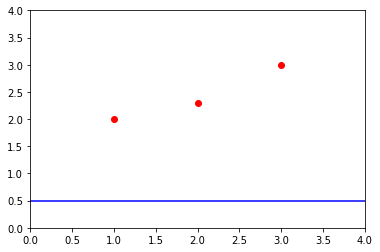



epoch 1:
	loss = 3.9133, w1 = 0.0100, b1 = 0.0100, w2 = 0.0004, b2 = 0.8480
	dL/dw1 = 0.0000, dL/db1 = 0.0000, dL/dw2 = -0.0041, dL/db2 = -3.8667
	a = 0.0000, b = 0.0000, c = 0.8480


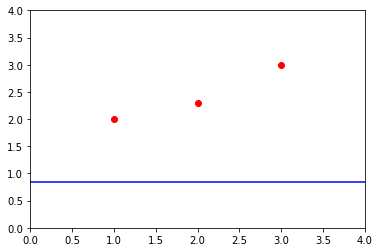



epoch 5:
	loss = 0.9396, w1 = 0.0101, b1 = 0.0100, w2 = 0.0014, b2 = 1.7166
	dL/dw1 = -0.0004, dL/db1 = -0.0001, dL/dw2 = -0.0021, dL/db2 = -1.7482
	a = 0.0000, b = 0.0000, c = 1.7166


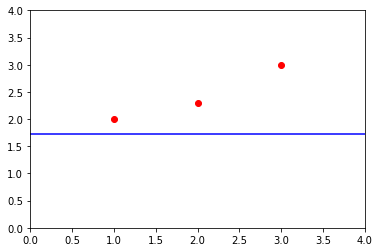



epoch 50:
	loss = 0.1756, w1 = 0.0111, b1 = 0.0103, w2 = 0.0039, b2 = 2.4332
	dL/dw1 = -0.0003, dL/db1 = -0.0001, dL/dw2 = -0.0005, dL/db2 = -0.0002
	a = 0.0000, b = 0.0000, c = 2.4332


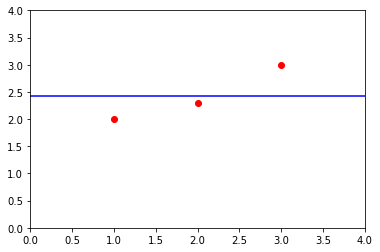



epoch 200:
	loss = 0.1755, w1 = 0.0235, b1 = 0.0129, w2 = 0.0161, b2 = 2.4333
	dL/dw1 = -0.0023, dL/db1 = -0.0005, dL/dw2 = -0.0019, dL/db2 = 0.0000
	a = 0.0000, b = 0.0000, c = 2.4333


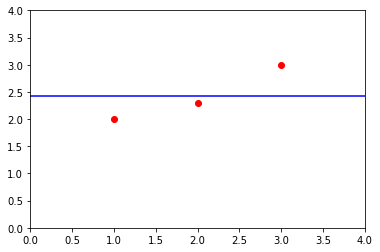



epoch 300:
	loss = 0.1570, w1 = 0.2189, b1 = 0.0560, w2 = 0.1595, b2 = 2.4124
	dL/dw1 = -0.1572, dL/db1 = -0.0333, dL/dw2 = -0.1138, dL/db2 = 0.0371
	a = 0.0076, b = 0.0039, c = 2.4129


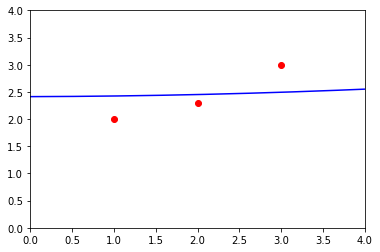



epoch 320:
	loss = 0.0314, w1 = 0.4822, b1 = 0.0454, w2 = 0.3422, b2 = 2.1119
	dL/dw1 = -0.0640, dL/db1 = 0.0386, dL/dw2 = -0.0423, dL/db2 = 0.1692
	a = 0.0796, b = 0.0150, c = 2.1126


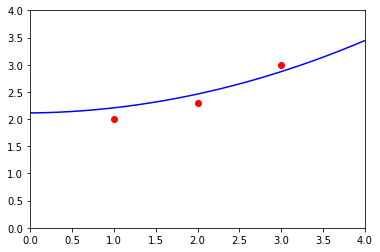



epoch 350:
	loss = 0.0019, w1 = 0.5564, b1 = -0.0183, w2 = 0.3932, b2 = 1.8949
	dL/dw1 = -0.0096, dL/db1 = 0.0117, dL/dw2 = -0.0070, dL/db2 = 0.0292
	a = 0.1217, b = -0.0080, c = 1.8951


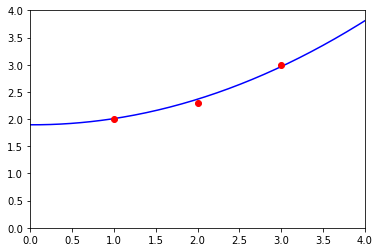



epoch 400:
	loss = 0.0011, w1 = 0.5703, b1 = -0.0438, w2 = 0.4041, b2 = 1.8597
	dL/dw1 = -0.0008, dL/db1 = 0.0034, dL/dw2 = -0.0008, dL/db2 = 0.0001
	a = 0.1314, b = -0.0202, c = 1.8605


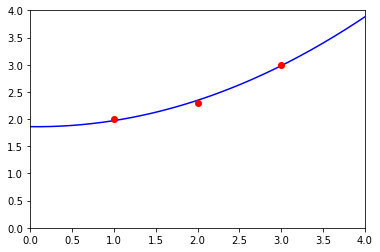



epoch 1000:
	loss = 0.0005, w1 = 0.5886, b1 = -0.2011, w2 = 0.4395, b2 = 1.9127
	dL/dw1 = -0.0002, dL/db1 = 0.0027, dL/dw2 = -0.0008, dL/db2 = -0.0009
	a = 0.1523, b = -0.1041, c = 1.9305


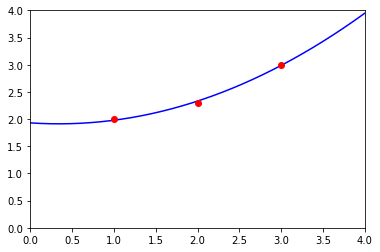



epoch 2000:
	loss = 0.0001, w1 = 0.6031, b1 = -0.3805, w2 = 0.5039, b2 = 1.9674
	dL/dw1 = -0.0001, dL/db1 = 0.0012, dL/dw2 = -0.0005, dL/db2 = -0.0003
	a = 0.1833, b = -0.2313, c = 2.0404


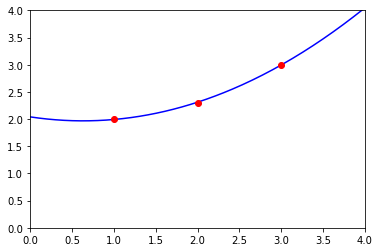



final result:
epoch 4000:
	loss = 0.0000, w1 = 0.6092, b1 = -0.4544, w2 = 0.5371, b2 = 1.9868
	dL/dw1 = -0.0000, dL/db1 = 0.0001, dL/dw2 = -0.0000, dL/db2 = -0.0000
	a = 0.1994, b = -0.2974, c = 2.0977


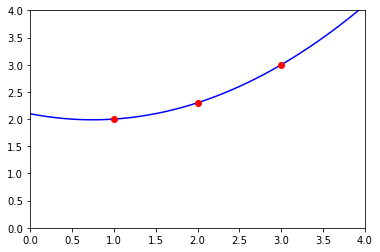

In [24]:
# initialize weights and bias weights (ensure to enable automatic differentiation by using the class Value)
w1 = Value(0.01)   # bitte Code ergaenzen <---------------- [Luecke (27)]
b1 = Value(0.01)   # bitte Code ergaenzen <---------------- [Luecke (28)]
w2 = Value(0)   # bitte Code ergaenzen <---------------- [Luecke (29)]
b2 = Value(0.5)   # bitte Code ergaenzen <---------------- [Luecke (30)]

# set learning rate
learning_rate = 0.09

# show points and parabula defined by initial neural network
print('initial configuration:')
# calculate parameters of parabola
a = w1.data ** 2 * w2.data
b = 2 * w1.data * w2.data * b1.data
c = w2.data * b1.data ** 2 + b2.data
visualize_parabola(pts, a, b, c)
print('\n')

# fit neural network to points
for epoch in range(4000):   # train for 4000 epochs
    # reset gradients
    w1.grad = 0   # bitte Code ergaenzen <---------------- [Luecke (31)]
    b1.grad = 0   # bitte Code ergaenzen <---------------- [Luecke (32)]
    w2.grad =  0  # bitte Code ergaenzen <---------------- [Luecke (33)]
    b2.grad =   0 # bitte Code ergaenzen <---------------- [Luecke (34)]

    # output of neuron (y_i = w2 * (w1 * x_i + b1) ** 2 + b2) for all three inputs x_1, x_2, and x_3
    y_1 = w2 * (w1 * x_1 + b1)**2 + b2   # bitte Code ergaenzen <---------------- [Luecke (35)]
    y_2 =  w2 * (w1 * x_2 + b1)**2 + b2  # bitte Code ergaenzen <---------------- [Luecke (36)]
    y_3 =  w2 * (w1 * x_3 + b1)**2 + b2  # bitte Code ergaenzen <---------------- [Luecke (37)]

    # calculate squared error for each sample: squared_error_i = (y_i - t_i) ** 2
    squared_error1 = (y_1 - t_1)**2   # bitte Code ergaenzen <---------------- [Luecke (38)]
    squared_error2 =  (y_2 - t_2)**2  # bitte Code ergaenzen <---------------- [Luecke (39)]
    squared_error3 =  (y_3 - t_3)**2  # bitte Code ergaenzen <---------------- [Luecke (40)]

    # calculate loss (see formula above, use results for squared_error_i)
    loss = 1/3 * (squared_error1+squared_error2+squared_error3)   # bitte Code ergaenzen <---------------- [Luecke (41)]

    # calculate gradients: call backward function for loss
    loss.backward()    # bitte Code ergaenzen <---------------- [Luecke (42)]

    # update parameters with gradients: w_new = w_old - dL/dw * learning_rate
    w1.data =  w1.data - w1.grad * learning_rate  # bitte Code ergaenzen <---------------- [Luecke (43)]
    b1.data =  b1.data - b1.grad * learning_rate  # bitte Code ergaenzen <---------------- [Luecke (44)]
    w2.data =  w2.data - w2.grad * learning_rate # bitte Code ergaenzen <---------------- [Luecke (45)]
    b2.data =  b2.data - b2.grad * learning_rate  # bitte Code ergaenzen <---------------- [Luecke (46)]

    # report progress
    if epoch in [0, 4, 49, 199, 299, 319, 349, 399, 999, 1999]:
        a = w1.data ** 2 * w2.data
        b = 2 * w1.data * w2.data * b1.data
        c = w2.data * b1.data ** 2 + b2.data
        print_progress_parabola(a, b, c)
        visualize_parabola(pts, a, b, c)
        print('\n')

# report final result
print('final result:')
a = w1.data ** 2 * w2.data
b = 2 * w1.data * w2.data * b1.data
c = w2.data * b1.data ** 2 + b2.data
print_progress_parabola(a, b, c)
visualize_parabola(pts, a, b, c)

<details>
    <summary>&#9432; <i>Überprüfung &nbsp; &nbsp; <font color="CCCCCC">(anklicken, um Lösung anzuzeigen)</font></i></summary>
    <br><i>Augaben bei korrekter Implementierung:</i><br>
    <br><code>initial configuration:</code>
    <br><img src="data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAXwAAAD8CAYAAAB0IB+mAAAABHNCSVQICAgIfAhkiAAAAAlwSFlzAAALEgAACxIB0t1+/AAAADh0RVh0U29mdHdhcmUAbWF0cGxvdGxpYiB2ZXJzaW9uMy4yLjIsIGh0dHA6Ly9tYXRwbG90bGliLm9yZy+WH4yJAAAQ+ElEQVR4nO3dX6ildb3H8ffHaaLMwIvZ4DAzznRATmRgejaTIhwG6YCa5I0XxpTgzaAUGKdD9AeMLrqNUDsOm5KS5hRBISIjIZSUF1rbabRs8jAnMgcH3BmNyUg1ne+5WGtO2zVru56997Nnre3v/YLFfv781loffuhnnv3sZz0rVYUk6a3vgmkHkCSdHxa+JDXCwpekRlj4ktQIC1+SGmHhS1IjOhd+ki1JfpHkkTH7kuSeJMeTPJvkqn5jSpLWazVH+HcBx1bYdwNw2fBxALh/nbkkST3rVPhJdgIfBr6+wpCbgQdr4Eng4iTbe8ooSerB2zqO+yrwGeDdK+zfAby4bP3EcNvJ5YOSHGDwGwDvete7/uW9733vqsJKUuuefvrpP1TV3FqeO7Hwk9wEvFxVTyfZt9KwMdvOuWdDVS0ACwDz8/O1uLi4iqiSpCQvrPW5XU7pXAt8JMnvgO8C1yX59siYE8CuZes7gZfWGkqS1L+JhV9Vn6uqnVW1B7gV+FFVfWxk2MPAbcOrda4GTlXVydHXkiRNT9dz+OdIcgdAVR0EDgM3AseB08DtvaSTJPVmVYVfVY8Djw+XDy7bXsAn+gwmSeqXn7SVpEZY+JLUCAtfkhph4UtSIyx8SWqEhS9JjbDwJakRFr4kNcLCl6RGWPiS1AgLX5IaYeFLUiMsfElqhIUvSY2w8CWpERa+JDXCwpekRlj4ktSIiYWf5B1JfpbkmSTPJfnSmDH7kpxKcnT4uHtj4kqS1qrLd9r+Bbiuql5LshV4IsmjVfXkyLifVtVN/UeUJPVhYuEPv6D8teHq1uGjNjKUJKl/nc7hJ9mS5CjwMvBYVT01Ztg1w9M+jya5vNeUkqR161T4VfX3qvoAsBPYm+T9I0OOALur6grgXuChca+T5ECSxSSLS0tL68ktSVqlVV2lU1V/Ah4Hrh/Z/mpVvTZcPgxsTbJtzPMXqmq+qubn5ubWnlqStGpdrtKZS3LxcPmdwIeA34yMuSRJhst7h6/7Sv9xJUlr1eUqne3At5JsYVDk36uqR5LcAVBVB4FbgDuTnAFeB24d/rFXkjQjulyl8yxw5ZjtB5ct3wfc1280SVKf/KStJDXCwpekRlj4ktQIC1+SGmHhS1IjLHxJaoSFL0mNsPAlqREWviQ1wsKXpEZY+JLUCAtfkhph4UtSIyx8SWqEhS9JjbDwJakRFr4kNcLCl6RGWPiS1IiJhZ/kHUl+luSZJM8l+dKYMUlyT5LjSZ5NctXGxJW0aRw6BHv2wAUXDH4eOjTtRM2b+CXmwF+A66rqtSRbgSeSPFpVTy4bcwNw2fDxQeD+4U9JLTp0CA4cgNOnB+svvDBYB9i/f3q5GjfxCL8GXhuubh0+amTYzcCDw7FPAhcn2d5vVEmbxhe+8I+yP+v06cF2TU2nc/hJtiQ5CrwMPFZVT40M2QG8uGz9xHDb6OscSLKYZHFpaWmtmSXNut//fnXbdV50Kvyq+ntVfQDYCexN8v6RIRn3tDGvs1BV81U1Pzc3t/q0kjaHSy9d3XadF6u6Sqeq/gQ8Dlw/susEsGvZ+k7gpXUlk7R5ffnLcOGFb9x24YWD7ZqaLlfpzCW5eLj8TuBDwG9Ghj0M3Da8Wudq4FRVnew9raTNYf9+WFiA3bshGfxcWPAPtlPW5Sqd7cC3kmxh8A/E96rqkSR3AFTVQeAwcCNwHDgN3L5BeSVtFvv3W/AzZmLhV9WzwJVjth9ctlzAJ/qNJknqk5+0laRGWPiS1AgLX5IaYeFLUiMsfElqhIUvSY2w8CWpERa+JDXCwpekRlj4ktQIC1+SGmHhS1IjLHxJaoSFL0mNsPAlqREWviQ1wsKXpEZY+JLUiC5fYr4ryY+THEvyXJK7xozZl+RUkqPDx90bE1eStFZdvsT8DPDpqjqS5N3A00keq6pfj4z7aVXd1H9ESVIfJh7hV9XJqjoyXP4zcAzYsdHBJEn9WtU5/CR7gCuBp8bsvibJM0keTXL5Cs8/kGQxyeLS0tKqw0qS1q5z4Se5CPg+8KmqenVk9xFgd1VdAdwLPDTuNapqoarmq2p+bm5urZklSWvQqfCTbGVQ9oeq6gej+6vq1ap6bbh8GNiaZFuvSSVJ69LlKp0A3wCOVdVXVhhzyXAcSfYOX/eVPoNKktany1U61wIfB36Z5Ohw2+eBSwGq6iBwC3BnkjPA68CtVVUbkFeStEYTC7+qngAyYcx9wH19hZIk9c9P2kpSIyx8SWqEhS8td+gQ7NkDF1ww+Hno0LQTSb3p8kdbqQ2HDsGBA3D69GD9hRcG6wD7908vl9QTj/Cls77whX+U/VmnTw+2S28BFr501u9/v7rt0iZj4UtnXXrp6rZLm4yFL5315S/DhRe+cduFFw62S28BFr501v79sLAAu3dDMvi5sOAfbPWW4VU60nL791vwesvyCF+SGmHhS1IjLHxJaoSFL0mNsPAlqREWviQ1wsKXpEZY+JLUiC5fYr4ryY+THEvyXJK7xoxJknuSHE/ybJKrNiauzuH92yV11OWTtmeAT1fVkSTvBp5O8lhV/XrZmBuAy4aPDwL3D39qI3n/dkmrMPEIv6pOVtWR4fKfgWPAjpFhNwMP1sCTwMVJtveeVm/k/dslrcKqzuEn2QNcCTw1smsH8OKy9ROc+48CSQ4kWUyyuLS0tLqkOpf3b5e0Cp0LP8lFwPeBT1XVq6O7xzylztlQtVBV81U1Pzc3t7qkOpf3b5e0Cp0KP8lWBmV/qKp+MGbICWDXsvWdwEvrj6c35f3bJa1Cl6t0AnwDOFZVX1lh2MPAbcOrda4GTlXVyR5zahzv3y5pFbpcpXMt8HHgl0mODrd9HrgUoKoOAoeBG4HjwGng9v6jaizv3y6po4mFX1VPMP4c/fIxBXyir1CSpP75SVtJaoSFL0mNsPAlqREWviQ1wsKXpEZY+JLUCAtfkhph4UtSIyx8SWqEhS9JjbDwJakRFr4kNcLCl6RGWPiS1AgLX5IaYeFLUiMsfElqhIUvSY3o8iXmDyR5OcmvVti/L8mpJEeHj7v7jylJWq8uX2L+TeA+4ME3GfPTqrqpl0SSpA0x8Qi/qn4C/PE8ZJEkbaC+zuFfk+SZJI8muXylQUkOJFlMsri0tNTTW0uSuuij8I8Au6vqCuBe4KGVBlbVQlXNV9X83NxcD28tSepq3YVfVa9W1WvD5cPA1iTb1p1MktSrdRd+kkuSZLi8d/iar6z3dSVJ/Zp4lU6S7wD7gG1JTgBfBLYCVNVB4BbgziRngNeBW6uqNiyxJGlNJhZ+VX10wv77GFy2KUmaYX7SVpIaYeFLUiMsfElqhIUvSY2w8CWpERa+JDXCwpekRlj4ktQIC1+SGmHhS1IjLHxJaoSFL0mNsPAlqREWviQ1wsKXpEZY+JLUCAtfkhph4UtSIyYWfpIHkryc5Fcr7E+Se5IcT/Jskqv6jylJWq8uR/jfBK5/k/03AJcNHweA+9cfS5LUt4mFX1U/Af74JkNuBh6sgSeBi5Ns7yugJKkffZzD3wG8uGz9xHDbOZIcSLKYZHFpaamHt5YkddVH4WfMtho3sKoWqmq+qubn5uZ6eGtJUld9FP4JYNey9Z3ASz28riSpR30U/sPAbcOrda4GTlXVyR5eV5LUo7dNGpDkO8A+YFuSE8AXga0AVXUQOAzcCBwHTgO3b1RYSdLaTSz8qvrohP0FfKK3RJKkDeEnbSWpERa+JDXCwpekRlj4ktQIC1+SGmHhS1IjLHxJaoSFL0mNsPAlqREWviQ1wsKXpEZY+JLUCAtfkhph4UtSIyx8SWqEhS9JjbDwJakRFr4kNaJT4Se5PsnzSY4n+eyY/fuSnEpydPi4u/+okqT16PIl5luArwH/BpwAfp7k4ar69cjQn1bVTRuQUZLUgy5H+HuB41X126r6K/Bd4OaNjSVJ6tvEI3xgB/DisvUTwAfHjLsmyTPAS8B/VNVzb/aizz8P+/Z1jSlJWq8uR/gZs61G1o8Au6vqCuBe4KGxL5QcSLKYZPFvf/vb6pJKktalyxH+CWDXsvWdDI7i/19Vvbps+XCS/0yyrar+MDJuAVgAmJ+fr8cfX2tsSWpTxh2Cd9TlCP/nwGVJ3pPk7cCtwMNvDJBLkkGMJHuHr/vK2mNJkvo28Qi/qs4k+STwQ2AL8EBVPZfkjuH+g8AtwJ1JzgCvA7dW1ehpH0nSFGVavTw/P1+Li4tTeW9J2qySPF1V82t5rp+0laRGWPiS1AgLX5IaYeFLUiMsfElqhIUvSY2w8CWpERa+JDXCwpekRlj4ktQIC1+SGmHhS1IjLHxJaoSFL0mNsPAlqREWviQ1wsKXpEZY+JLUCAtfkhrRqfCTXJ/k+STHk3x2zP4kuWe4/9kkV/UfVZK0HhMLP8kW4GvADcD7gI8med/IsBuAy4aPA8D9PeeUJK1TlyP8vcDxqvptVf0V+C5w88iYm4EHa+BJ4OIk23vOKklah7d1GLMDeHHZ+gnggx3G7ABOLh+U5ACD3wAA/pLkV6tKOx3bgD9MO0QH5uzXZsi5GTKCOfv2z2t9YpfCz5httYYxVNUCsACQZLGq5ju8/1SZs1/m7M9myAjm7FuSxbU+t8spnRPArmXrO4GX1jBGkjRFXQr/58BlSd6T5O3ArcDDI2MeBm4bXq1zNXCqqk6OvpAkaXomntKpqjNJPgn8ENgCPFBVzyW5Y7j/IHAYuBE4DpwGbu/w3gtrTn1+mbNf5uzPZsgI5uzbmnOm6pxT7ZKktyA/aStJjbDwJakRG174m+W2DB1y7ktyKsnR4ePuKWR8IMnLK31+YYbmclLOWZjLXUl+nORYkueS3DVmzNTns2POWZjPdyT5WZJnhjm/NGbMLMxnl5xTn89hji1JfpHkkTH71jaXVbVhDwZ/5P0f4J+AtwPPAO8bGXMj8CiDa/mvBp7ayEzryLkPeOR8ZxvJ8K/AVcCvVtg/9bnsmHMW5nI7cNVw+d3Af8/of5tdcs7CfAa4aLi8FXgKuHoG57NLzqnP5zDHvwP/NS7LWudyo4/wN8ttGbrknLqq+gnwxzcZMgtz2SXn1FXVyao6Mlz+M3CMwafDl5v6fHbMOXXDOXptuLp1+Bi9ImQW5rNLzqlLshP4MPD1FYasaS43uvBXuuXCasdstK4Zrhn+KvhoksvPT7RVmYW57Gpm5jLJHuBKBkd7y83UfL5JTpiB+RyegjgKvAw8VlUzOZ8dcsL05/OrwGeA/11h/5rmcqMLv7fbMmywLhmOALur6grgXuChDU+1erMwl13MzFwmuQj4PvCpqnp1dPeYp0xlPifknIn5rKq/V9UHGHzSfm+S948MmYn57JBzqvOZ5Cbg5ap6+s2Gjdk2cS43uvA3y20ZJmaoqlfP/ipYVYeBrUm2nb+InczCXE40K3OZZCuDEj1UVT8YM2Qm5nNSzlmZz2V5/gQ8Dlw/smsm5vOslXLOwHxeC3wkye8YnF6+Lsm3R8asaS43uvA3y20ZJuZMckmSDJf3Mpi7V85zzklmYS4nmoW5HL7/N4BjVfWVFYZNfT675JyR+ZxLcvFw+Z3Ah4DfjAybhfmcmHPa81lVn6uqnVW1h0EX/aiqPjYybE1z2eVumWtWG3dbhmnkvAW4M8kZ4HXg1hr+ufx8SfIdBlcQbEtyAvgigz86zcxcdsw59blkcBT1ceCXw/O5AJ8HLl2Wcxbms0vOWZjP7cC3MvjCpAuA71XVI7P2/3rHnLMwn+foYy69tYIkNcJP2kpSIyx8SWqEhS9JjbDwJakRFr4kNcLCl6RGWPiS1Ij/A0eihqwUMdSEAAAAAElFTkSuQmCC" alt="initial line" />
    <br><code>epoch 1:
	loss = 3.9133, w1 = 0.0100, b1 = 0.0100, w2 = 0.0004, b2 = 0.8480
	dL/dw1 = 0.0000, dL/db1 = 0.0000, dL/dw2 = -0.0041, dL/db2 = -3.8667
	a = 0.0000, b = 0.0000, c = 0.8480</code>
    <br><img src="data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAXwAAAD8CAYAAAB0IB+mAAAABHNCSVQICAgIfAhkiAAAAAlwSFlzAAALEgAACxIB0t1+/AAAADh0RVh0U29mdHdhcmUAbWF0cGxvdGxpYiB2ZXJzaW9uMy4yLjIsIGh0dHA6Ly9tYXRwbG90bGliLm9yZy+WH4yJAAARCUlEQVR4nO3dX4hlZ53u8e+TtkWjQi66IE3/nQNBMYImp2gThEMjHkgyYXKTi0iPgdwUCQ4oZ2CYUYh44a0MMUOaYgxjmD6KoIQQOgyBMagXiVZ6OtHYeugzTEyThtRE7Nh0cGjnNxd7NVPu3pW9qmpV7115vx/Y1Prz7r0fXpKnV61ae+1UFZKkd7/rZh1AknRtWPiS1AgLX5IaYeFLUiMsfElqhIUvSY3oXfhJdiX5lyRPT9iXJI8kOZvk5SS3DhtTkrRVGznC/wJwZp19dwI3dY8l4LEt5pIkDaxX4SfZD/wp8PfrDLkHeKJGngduSLJ3oIySpAG8p+e4vwX+CvjQOvv3Aa+tWT/XbTu/dlCSJUa/AfCBD3zgf37kIx/ZUFhJat2LL77471W1sJnnTi38JHcDb1TVi0mOrjdswrar7tlQVcvAMsDi4mKtrKxsIKokKcmrm31un1M6nwL+LMm/Ad8BPp3kH8fGnAMOrFnfD7y+2VCSpOFNLfyq+puq2l9Vh4H7gH+uqj8fG/YUcH93tc5twIWqOj/+WpKk2el7Dv8qSR4EqKrjwEngLuAscAl4YJB0kqTBbKjwq+o54Llu+fia7QV8fshgkqRh+UlbSWqEhS9JjbDwJakRFr4kNcLCl6RGWPiS1AgLX5IaYeFLUiMsfElqhIUvSY2w8CWpERa+JDXCwpekRlj4ktQIC1+SGmHhS1IjLHxJaoSFL0mNmFr4Sd6X5CdJXkrySpKvThhzNMmFJKe7x8PbE1eStFl9vtP298Cnq+pikt3Aj5M8U1XPj437UVXdPXxESdIQphZ+9wXlF7vV3d2jtjOUJGl4vc7hJ9mV5DTwBvBsVb0wYdjt3WmfZ5LcPGhKSdKW9Sr8qvpDVX0C2A8cSfKxsSGngENV9XHgG8CTk14nyVKSlSQrq6urW8ktSdqgDV2lU1W/BZ4D7hjb/lZVXeyWTwK7k+yZ8PzlqlqsqsWFhYXNp5YkbVifq3QWktzQLb8f+Azwy7ExNyZJt3yke903h48rSdqsPlfp7AW+lWQXoyL/blU9neRBgKo6DtwLPJTkMvA2cF/3x15J0pzoc5XOy8AtE7YfX7P8KPDosNEkSUPyk7aS1AgLX5IaYeFLUiMsfElqhIUvSY2w8CWpERa+JDXCwpekRlj4ktQIC1+SGmHhS1IjLHxJaoSFL0mNsPAlqREWviQ1wsKXpEZY+JLUCAtfkhph4UtSI6YWfpL3JflJkpeSvJLkqxPGJMkjSc4meTnJrdsTV9KOceIEHD4M1103+nnixKwTNW/ql5gDvwc+XVUXk+wGfpzkmap6fs2YO4Gbuscngce6n5JadOIELC3BpUuj9VdfHa0DHDs2u1yNm3qEXyMXu9Xd3aPGht0DPNGNfR64IcneYaNK2jG+/OX/LvsrLl0abdfM9DqHn2RXktPAG8CzVfXC2JB9wGtr1s9128ZfZynJSpKV1dXVzWaWNO9+/euNbdc10avwq+oPVfUJYD9wJMnHxoZk0tMmvM5yVS1W1eLCwsLG00raGQ4e3Nh2XRMbukqnqn4LPAfcMbbrHHBgzfp+4PUtJZO0c33ta3D99X+87frrR9s1M32u0llIckO3/H7gM8Avx4Y9BdzfXa1zG3Chqs4PnlbSznDsGCwvw6FDkIx+Li/7B9sZ63OVzl7gW0l2MfoH4rtV9XSSBwGq6jhwErgLOAtcAh7YprySdopjxyz4OTO18KvqZeCWCduPr1ku4PPDRpMkDclP2kpSIyx8SWqEhS9JjbDwJakRFr4kNcLCl6RGWPiS1AgLX5IaYeFLUiMsfElqhIUvSY2w8CWpERa+JDXCwpekRlj4ktQIC1+SGmHhS1IjLHxJakSfLzE/kOQHSc4keSXJFyaMOZrkQpLT3ePh7YkrSdqsPl9ifhn4y6o6leRDwItJnq2qX4yN+1FV3T18REnSEKYe4VfV+ao61S3/DjgD7NvuYJKkYW3oHH6Sw8AtwAsTdt+e5KUkzyS5eZ3nLyVZSbKyurq64bCSpM3rXfhJPgh8D/hiVb01tvsUcKiqPg58A3hy0mtU1XJVLVbV4sLCwmYzS5I2oVfhJ9nNqOxPVNX3x/dX1VtVdbFbPgnsTrJn0KSSpC3pc5VOgG8CZ6rq6+uMubEbR5Ij3eu+OWRQSdLW9LlK51PA54CfJTndbfsScBCgqo4D9wIPJbkMvA3cV1W1DXklSZs0tfCr6sdApox5FHh0qFCSpOH5SVtJaoSFL0mNsPCltU6cgMOH4brrRj9PnJh1Imkwff5oK7XhxAlYWoJLl0brr746Wgc4dmx2uaSBeIQvXfHlL/932V9x6dJou/QuYOFLV/z61xvbLu0wFr50xcGDG9su7TAWvnTF174G11//x9uuv360XXoXsPClK44dg+VlOHQIktHP5WX/YKt3Da/SkdY6dsyC17uWR/iS1AgLX5IaYeFLUiMsfElqhIUvSY2w8CWpERa+JDXCwpekRvT5EvMDSX6Q5EySV5J8YcKYJHkkydkkLye5dXvi6irev11ST30+aXsZ+MuqOpXkQ8CLSZ6tql+sGXMncFP3+CTwWPdT28n7t0vagKlH+FV1vqpOdcu/A84A+8aG3QM8USPPAzck2Tt4Wv0x798uaQM2dA4/yWHgFuCFsV37gNfWrJ/j6n8USLKUZCXJyurq6saS6mrev13SBvQu/CQfBL4HfLGq3hrfPeEpddWGquWqWqyqxYWFhY0l1dW8f7ukDehV+El2Myr7E1X1/QlDzgEH1qzvB17fejy9I+/fLmkD+lylE+CbwJmq+vo6w54C7u+u1rkNuFBV5wfMqUm8f7ukDehzlc6ngM8BP0tyutv2JeAgQFUdB04CdwFngUvAA8NH1UTev11ST1MLv6p+zORz9GvHFPD5oUJJkobnJ20lqREWviQ1wsKXpEZY+JLUCAtfkhph4UtSIyx8SWqEhS9JjbDwJakRFr4kNcLCl6RGWPiS1AgLX5IaYeFLUiMsfElqhIUvSY2w8CWpERa+JDWiz5eYP57kjSQ/X2f/0SQXkpzuHg8PH1OStFV9vsT8H4BHgSfeYcyPquruQRJJkrbF1CP8qvoh8JtrkEWStI2GOod/e5KXkjyT5Ob1BiVZSrKSZGV1dXWgt5Yk9TFE4Z8CDlXVx4FvAE+uN7CqlqtqsaoWFxYWBnhrSVJfWy78qnqrqi52yyeB3Un2bDmZJGlQWy78JDcmSbd8pHvNN7f6upKkYU29SifJt4GjwJ4k54CvALsBquo4cC/wUJLLwNvAfVVV25ZYkrQpUwu/qj47Zf+jjC7blCTNMT9pK0mNsPAlqREWviQ1wsKXpEZY+JLUCAtfkhph4UtSIyx8SWqEhS9JjbDwJakRFr4kNcLCl6RGWPiS1AgLX5IaYeFLUiMsfElqhIUvSY2w8CWpEVMLP8njSd5I8vN19ifJI0nOJnk5ya3Dx5QkbVWfI/x/AO54h/13Ajd1jyXgsa3HkiQNbWrhV9UPgd+8w5B7gCdq5HnghiR7hwooSRrGEOfw9wGvrVk/1227SpKlJCtJVlZXVwd4a0lSX0MUfiZsq0kDq2q5qharanFhYWGAt5Yk9TVE4Z8DDqxZ3w+8PsDrSpIGNEThPwXc312tcxtwoarOD/C6kqQBvWfagCTfBo4Ce5KcA74C7AaoquPASeAu4CxwCXhgu8JKkjZvauFX1Wen7C/g84MlkiRtCz9pK0mNsPAlqRFTT+lsl1/9Co4endW7S1J7PMKXpEbM7Aj/wx+G556b1btL0s6USR917ckjfElqhIUvSY2w8CWpERa+JDXCwpekRlj4ktQIC1+SGmHhS1IjLHxJaoSFL0mNsPAlqREWviQ1wsKXpEb0KvwkdyT5VZKzSf56wv6jSS4kOd09Hh4+qiRpK/p8ifku4O+A/w2cA36a5Kmq+sXY0B9V1d3bkFGSNIA+R/hHgLNV9a9V9R/Ad4B7tjeWJGlofQp/H/DamvVz3bZxtyd5KckzSW4eJJ0kaTB9vvFq0ver1Nj6KeBQVV1MchfwJHDTVS+ULAFLAAcPHtxgVEnSVvQ5wj8HHFizvh94fe2Aqnqrqi52yyeB3Un2jL9QVS1X1WJVLS4sLGwhtiRpo/oU/k+Bm5L8SZL3AvcBT60dkOTGZPRNi0mOdK/75tBhJUmbN/WUTlVdTvIXwD8Bu4DHq+qVJA92+48D9wIPJbkMvA3cV1Xjp30kSTOUWfXy4uJirayszOS9JWmnSvJiVS1u5rl+0laSGmHhS1IjLHxJaoSFL0mNsPAlqREWviQ1wsKXpEZY+JLUCAtfkhph4UtSIyx8SWqEhS9JjbDwJakRFr4kNcLCl6RGWPiS1AgLX5IaYeFLUiMsfElqRK/CT3JHkl8lOZvkryfsT5JHuv0vJ7l1+KiSpK2YWvhJdgF/B9wJfBT4bJKPjg27E7ipeywBjw2cU5K0RX2O8I8AZ6vqX6vqP4DvAPeMjbkHeKJGngduSLJ34KySpC14T48x+4DX1qyfAz7ZY8w+4PzaQUmWGP0GAPD7JD/fUNrZ2AP8+6xD9GDOYe2EnDshI5hzaB/e7BP7FH4mbKtNjKGqloFlgCQrVbXY4/1nypzDMudwdkJGMOfQkqxs9rl9TumcAw6sWd8PvL6JMZKkGepT+D8FbkryJ0neC9wHPDU25ing/u5qnduAC1V1fvyFJEmzM/WUTlVdTvIXwD8Bu4DHq+qVJA92+48DJ4G7gLPAJeCBHu+9vOnU15Y5h2XO4eyEjGDOoW06Z6quOtUuSXoX8pO2ktQIC1+SGrHthb9TbsvQI+fRJBeSnO4eD88g4+NJ3ljv8wtzNJfTcs7DXB5I8oMkZ5K8kuQLE8bMfD575pyH+Xxfkp8keanL+dUJY+ZhPvvknPl8djl2JfmXJE9P2Le5uayqbXsw+iPv/wf+B/Be4CXgo2Nj7gKeYXQt/23AC9uZaQs5jwJPX+tsYxn+F3Ar8PN19s98LnvmnIe53Avc2i1/CPh/c/rfZp+c8zCfAT7YLe8GXgBum8P57JNz5vPZ5fg/wP+dlGWzc7ndR/g75bYMfXLOXFX9EPjNOwyZh7nsk3Pmqup8VZ3qln8HnGH06fC1Zj6fPXPOXDdHF7vV3d1j/IqQeZjPPjlnLsl+4E+Bv19nyKbmcrsLf71bLmx0zHbrm+H27lfBZ5LcfG2ibcg8zGVfczOXSQ4DtzA62ltrrubzHXLCHMxndwriNPAG8GxVzeV89sgJs5/PvwX+CvjPdfZvai63u/AHuy3DNuuT4RRwqKo+DnwDeHLbU23cPMxlH3Mzl0k+CHwP+GJVvTW+e8JTZjKfU3LOxXxW1R+q6hOMPml/JMnHxobMxXz2yDnT+UxyN/BGVb34TsMmbJs6l9td+DvltgxTM1TVW1d+Fayqk8DuJHuuXcRe5mEup5qXuUyym1GJnqiq708YMhfzOS3nvMznmjy/BZ4D7hjbNRfzecV6OedgPj8F/FmSf2N0evnTSf5xbMym5nK7C3+n3JZhas4kNyZJt3yE0dy9eY1zTjMPcznVPMxl9/7fBM5U1dfXGTbz+eyTc07mcyHJDd3y+4HPAL8cGzYP8zk156zns6r+pqr2V9VhRl30z1X152PDNjWXfe6WuWm1fbdlmEXOe4GHklwG3gbuq+7P5ddKkm8zuoJgT5JzwFcY/dFpbuayZ86ZzyWjo6jPAT/rzucCfAk4uCbnPMxnn5zzMJ97gW9l9IVJ1wHfraqn5+3/9Z4552E+rzLEXHprBUlqhJ+0laRGWPiS1AgLX5IaYeFLUiMsfElqhIUvSY2w8CWpEf8FQzqDUaElZfoAAAAASUVORK5CYII=" alt="line after epoch 1" />
    <br><code>epoch 5:
	loss = 0.9396, w1 = 0.0101, b1 = 0.0100, w2 = 0.0014, b2 = 1.7166
	dL/dw1 = -0.0004, dL/db1 = -0.0001, dL/dw2 = -0.0021, dL/db2 = -1.7482
	a = 0.0000, b = 0.0000, c = 1.7166</code>
    <br><img src="data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAXwAAAD8CAYAAAB0IB+mAAAABHNCSVQICAgIfAhkiAAAAAlwSFlzAAALEgAACxIB0t1+/AAAADh0RVh0U29mdHdhcmUAbWF0cGxvdGxpYiB2ZXJzaW9uMy4yLjIsIGh0dHA6Ly9tYXRwbG90bGliLm9yZy+WH4yJAAARBUlEQVR4nO3dX4idd53H8fenMaJVoRcZaMjfXSiKFbTdIbYISxAX2m7Z3vSikrXQm6HFBWWFxT9Q8cJbWWqlYVjLWjarCEopJUUKWtSLVqfZtFqjS3axNjTQ2YqpIcUl7ncvzhMcT2Zynpl5JudMf+8XHOb58zvnfPjRfvLMM895TqoKSdJb3zXTDiBJujosfElqhIUvSY2w8CWpERa+JDXCwpekRvQu/CQ7kvxHkidX2ZckDyU5neTFJDcPG1OStFnrOcL/FHBqjX23Azd0jwXgkU3mkiQNrFfhJ9kL/C3wL2sMuQt4rEaeBa5LsnugjJKkAbyt57h/Bv4JeM8a+/cAr6xYP9NtO7tyUJIFRr8B8K53veuv3ve+960rrCS17vnnn/+fqprbyHMnFn6SO4HXqur5JIfXGrbKtsvu2VBVi8AiwPz8fC0tLa0jqiQpycsbfW6fUzofAf4uya+BbwEfTfJvY2POAPtWrO8FXt1oKEnS8CYWflV9rqr2VtVB4B7g+1X192PDngDu7a7WuQU4V1Vnx19LkjQ9fc/hXybJ/QBVdRQ4DtwBnAYuAPcNkk6SNJh1FX5VPQM80y0fXbG9gE8OGUySNCw/aStJjbDwJakRFr4kNcLCl6RGWPiS1AgLX5IaYeFLUiMsfElqhIUvSY2w8CWpERa+JDXCwpekRlj4ktQIC1+SGmHhS1IjLHxJaoSFL0mNsPAlqRETCz/JO5L8JMkLSV5K8qVVxhxOci7Jye7x4NbElSRtVJ/vtP0D8NGqOp9kJ/DjJE9V1bNj435UVXcOH1GSNISJhd99Qfn5bnVn96itDCVJGl6vc/hJdiQ5CbwGPF1Vz60y7NbutM9TSW4cNKUkadN6FX5V/bGqPgTsBQ4l+cDYkBPAgar6IPBV4PHVXifJQpKlJEvLy8ubyS1JWqd1XaVTVb8DngFuG9v+RlWd75aPAzuT7Frl+YtVNV9V83NzcxtPLUlatz5X6cwlua5bfifwMeCXY2OuT5Ju+VD3uq8PH1eStFF9rtLZDXwjyQ5GRf7tqnoyyf0AVXUUuBt4IMlF4E3gnu6PvZKkGdHnKp0XgZtW2X50xfLDwMPDRpMkDclP2kpSIyx8SWqEhS9JjbDwJakRFr4kNcLCl6RGWPiS1AgLX5IaYeFLUiMsfElqhIUvSY2w8CWpERa+JDXCwpekRlj4ktQIC1+SGmHhS1IjLHxJaoSFL0mNmFj4Sd6R5CdJXkjyUpIvrTImSR5KcjrJi0lu3pq4kraNY8fg4EG45prRz2PHpp2oeRO/xBz4A/DRqjqfZCfw4yRPVdWzK8bcDtzQPT4MPNL9lNSiY8dgYQEuXBitv/zyaB3gyJHp5WrcxCP8Gjnfre7sHjU27C7gsW7ss8B1SXYPG1XStvGFL/yp7C+5cGG0XVPT6xx+kh1JTgKvAU9X1XNjQ/YAr6xYP9NtG3+dhSRLSZaWl5c3mlnSrPvNb9a3XVdFr8Kvqj9W1YeAvcChJB8YG5LVnrbK6yxW1XxVzc/Nza0/raTtYf/+9W3XVbGuq3Sq6nfAM8BtY7vOAPtWrO8FXt1UMknb15e/DNde++fbrr12tF1T0+cqnbkk13XL7wQ+BvxybNgTwL3d1Tq3AOeq6uzgaSVtD0eOwOIiHDgAyejn4qJ/sJ2yPlfp7Aa+kWQHo38gvl1VTya5H6CqjgLHgTuA08AF4L4tyitpuzhyxIKfMRMLv6peBG5aZfvRFcsFfHLYaJKkIflJW0lqhIUvSY2w8CWpERa+JDXCwpekRlj4ktQIC1+SGmHhS1IjLHxJaoSFL0mNsPAlqREWviQ1wsKXpEZY+JLUCAtfkhph4UtSIyx8SWqEhS9JjejzJeb7kvwgyakkLyX51CpjDic5l+Rk93hwa+JKkjaqz5eYXwQ+U1UnkrwHeD7J01X1i7FxP6qqO4ePKEkawsQj/Ko6W1UnuuXfA6eAPVsdTJI0rHWdw09yELgJeG6V3bcmeSHJU0luXOP5C0mWkiwtLy+vO6wkaeN6F36SdwPfAT5dVW+M7T4BHKiqDwJfBR5f7TWqarGq5qtqfm5ubqOZJUkb0Kvwk+xkVPbHquq74/ur6o2qOt8tHwd2Jtk1aFJJ0qb0uUonwNeBU1X1lTXGXN+NI8mh7nVfHzKoJGlz+lyl8xHgE8DPkpzstn0e2A9QVUeBu4EHklwE3gTuqaragrySpA2aWPhV9WMgE8Y8DDw8VChJ0vD8pK0kNcLCl6RGWPjSSseOwcGDcM01o5/Hjk07kTSYPn+0ldpw7BgsLMCFC6P1l18erQMcOTK9XNJAPMKXLvnCF/5U9pdcuDDaLr0FWPjSJb/5zfq2S9uMhS9dsn//+rZL24yFL13y5S/Dtdf++bZrrx1tl94CLHzpkiNHYHERDhyAZPRzcdE/2Ootw6t0pJWOHLHg9ZblEb4kNcLCl6RGWPiS1AgLX5IaYeFLUiMsfElqhIUvSY2w8CWpEX2+xHxfkh8kOZXkpSSfWmVMkjyU5HSSF5PcvDVxdRnv3y6ppz6ftL0IfKaqTiR5D/B8kqer6hcrxtwO3NA9Pgw80v3UVvL+7ZLWYeIRflWdraoT3fLvgVPAnrFhdwGP1cizwHVJdg+eVn/O+7dLWod1ncNPchC4CXhubNce4JUV62e4/B8FkiwkWUqytLy8vL6kupz3b5e0Dr0LP8m7ge8An66qN8Z3r/KUumxD1WJVzVfV/Nzc3PqS6nLev13SOvQq/CQ7GZX9sar67ipDzgD7VqzvBV7dfDxdkfdvl7QOfa7SCfB14FRVfWWNYU8A93ZX69wCnKuqswPm1Gq8f7ukdehzlc5HgE8AP0tystv2eWA/QFUdBY4DdwCngQvAfcNH1aq8f7ukniYWflX9mNXP0a8cU8AnhwolSRqen7SVpEZY+JLUCAtfkhph4UtSIyx8SWqEhS9JjbDwJakRFr4kNaLPJ223xK9+BYcPT+vdJak9HuFLUiOmdoT/3vfCM89M690laXvKFW90c2Ue4UtSIyx8SWqEhS9JjbDwJakRFr4kNcLCl6RGWPiS1Ig+X2L+aJLXkvx8jf2Hk5xLcrJ7PDh8TEnSZvX54NW/Ag8Dj11hzI+q6s5BEkmStsTEI/yq+iHw26uQRZK0hYY6h39rkheSPJXkxrUGJVlIspRkaXl5eaC3liT1MUThnwAOVNUHga8Cj681sKoWq2q+qubn5uYGeGtJUl+bLvyqeqOqznfLx4GdSXZtOpkkaVCbLvwk1yej+7clOdS95uubfV1J0rAmXqWT5JvAYWBXkjPAF4GdAFV1FLgbeCDJReBN4J6qqi1LLEnakImFX1Ufn7D/YUaXbUqSZpiftJWkRlj4ktQIC1+SGmHhS1IjLHxJaoSFL0mNsPAlqREWviQ1wsKXpEZY+JLUCAtfkhph4UtSIyx8SWqEhS9JjbDwJakRFr4kNcLCl6RGWPiS1IiJhZ/k0SSvJfn5GvuT5KEkp5O8mOTm4WNKkjarzxH+vwK3XWH/7cAN3WMBeGTzsSRJQ5tY+FX1Q+C3VxhyF/BYjTwLXJdk91ABJUnDGOIc/h7glRXrZ7ptl0mykGQpydLy8vIAby1J6muIws8q22q1gVW1WFXzVTU/Nzc3wFtLkvoaovDPAPtWrO8FXh3gdSVJAxqi8J8A7u2u1rkFOFdVZwd4XUnSgN42aUCSbwKHgV1JzgBfBHYCVNVR4DhwB3AauADct1VhJUkbN7Hwq+rjE/YX8MnBEkmStoSftJWkRlj4ktQIC1+SGmHhS1IjLHxJaoSFL0mNsPAlqREWviQ1wsKXpEZY+JLUCAtfkhph4UtSIyx8SWqEhS9JjbDwJakRFr4kNcLCl6RGWPiS1IhehZ/ktiS/SnI6yWdX2X84ybkkJ7vHg8NHlSRtRp8vMd8BfA34G+AM8NMkT1TVL8aG/qiq7tyCjJKkAfQ5wj8EnK6q/66q/wW+Bdy1tbEkSUPrU/h7gFdWrJ/pto27NckLSZ5KcuMg6SRJg5l4SgfIKttqbP0EcKCqzie5A3gcuOGyF0oWgAWA/fv3rzOqJGkz+hzhnwH2rVjfC7y6ckBVvVFV57vl48DOJLvGX6iqFqtqvqrm5+bmNhFbkrRefQr/p8ANSf4iyduBe4AnVg5Icn2SdMuHutd9feiwkqSNm3hKp6ouJvkH4HvADuDRqnopyf3d/qPA3cADSS4CbwL3VNX4aR9J0hRlWr08Pz9fS0tLU3lvSdqukjxfVfMbea6ftJWkRlj4ktQIC1+SGmHhS1IjLHxJaoSFL0mNsPAlqREWviQ1wsKXpEZY+JLUCAtfkhph4UtSIyx8SWqEhS9JjbDwJakRFr4kNcLCl6RGWPiS1AgLX5Ia0avwk9yW5FdJTif57Cr7k+Shbv+LSW4ePqokaTMmFn6SHcDXgNuB9wMfT/L+sWG3Azd0jwXgkYFzSpI2qc8R/iHgdFX9d1X9L/At4K6xMXcBj9XIs8B1SXYPnFWStAlv6zFmD/DKivUzwId7jNkDnF05KMkCo98AAP6Q5OfrSjsdu4D/mXaIHsw5rO2QcztkBHMO7b0bfWKfws8q22oDY6iqRWARIMlSVc33eP+pMuewzDmc7ZARzDm0JEsbfW6fUzpngH0r1vcCr25gjCRpivoU/k+BG5L8RZK3A/cAT4yNeQK4t7ta5xbgXFWdHX8hSdL0TDylU1UXk/wD8D1gB/BoVb2U5P5u/1HgOHAHcBq4ANzX470XN5z66jLnsMw5nO2QEcw5tA3nTNVlp9olSW9BftJWkhph4UtSI7a88LfLbRl65Dyc5FySk93jwSlkfDTJa2t9fmGG5nJSzlmYy31JfpDkVJKXknxqlTFTn8+eOWdhPt+R5CdJXuhyfmmVMbMwn31yTn0+uxw7kvxHkidX2bexuayqLXsw+iPvfwF/CbwdeAF4/9iYO4CnGF3Lfwvw3FZm2kTOw8CTVzvbWIa/Bm4Gfr7G/qnPZc+cszCXu4Gbu+X3AP85o/9t9sk5C/MZ4N3d8k7gOeCWGZzPPjmnPp9djn8E/n21LBudy60+wt8ut2Xok3PqquqHwG+vMGQW5rJPzqmrqrNVdaJb/j1witGnw1ea+nz2zDl13Ryd71Z3do/xK0JmYT775Jy6JHuBvwX+ZY0hG5rLrS78tW65sN4xW61vhlu7XwWfSnLj1Ym2LrMwl33NzFwmOQjcxOhob6WZms8r5IQZmM/uFMRJ4DXg6aqayfnskROmP5//DPwT8H9r7N/QXG514Q92W4Yt1ifDCeBAVX0Q+Crw+JanWr9ZmMs+ZmYuk7wb+A7w6ap6Y3z3Kk+ZynxOyDkT81lVf6yqDzH6pP2hJB8YGzIT89kj51TnM8mdwGtV9fyVhq2ybeJcbnXhb5fbMkzMUFVvXPpVsKqOAzuT7Lp6EXuZhbmcaFbmMslORiV6rKq+u8qQmZjPSTlnZT5X5Pkd8Axw29iumZjPS9bKOQPz+RHg75L8mtHp5Y8m+bexMRuay60u/O1yW4aJOZNcnyTd8iFGc/f6Vc45ySzM5USzMJfd+38dOFVVX1lj2NTns0/OGZnPuSTXdcvvBD4G/HJs2CzM58Sc057PqvpcVe2tqoOMuuj7VfX3Y8M2NJd97pa5YbV1t2WYRs67gQeSXATeBO6p7s/lV0uSbzK6gmBXkjPAFxn90Wlm5rJnzqnPJaOjqE8AP+vO5wJ8Hti/IucszGefnLMwn7uBb2T0hUnXAN+uqidn7f/1njlnYT4vM8RcemsFSWqEn7SVpEZY+JLUCAtfkhph4UtSIyx8SWqEhS9JjbDwJakR/w/1j4NRauxsTAAAAABJRU5ErkJggg==" alt="line after epoch 5" />
    <br><code>epoch 50:
	loss = 0.1756, w1 = 0.0111, b1 = 0.0103, w2 = 0.0039, b2 = 2.4332
	dL/dw1 = -0.0003, dL/db1 = -0.0001, dL/dw2 = -0.0005, dL/db2 = -0.0002
	a = 0.0000, b = 0.0000, c = 2.4332</code>
    <br><img src="data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAXwAAAD8CAYAAAB0IB+mAAAABHNCSVQICAgIfAhkiAAAAAlwSFlzAAALEgAACxIB0t1+/AAAADh0RVh0U29mdHdhcmUAbWF0cGxvdGxpYiB2ZXJzaW9uMy4yLjIsIGh0dHA6Ly9tYXRwbG90bGliLm9yZy+WH4yJAAAQ/klEQVR4nO3dX4hlZ53u8e+TtkWjQi66IE3/nQPhiBE0OUWbIBwa8UCSCZObXER6DOSmSHBAOQPDjELEC29liA5pijGMYfooghJC6DAExqBeJFrd04nG1kOfYWKaNCc1ETs2HRza8zsXezVT7t6VvapqVe9deb8f2NT68+61H16Sp3etWnvtVBWSpHe/G2YdQJJ0fVj4ktQIC1+SGmHhS1IjLHxJaoSFL0mN6F34SXYl+Zckz0zYlySPJTmX5OUktw8bU5K0VRt5h/954Ow6++4GbukeS8DjW8wlSRpYr8JPsh/4U+Dv1xlyH/BkjbwA3JRk70AZJUkDeE/PcX8L/BXwoXX27wNeW7N+vtt2Ye2gJEuMfgPgAx/4wH/78Ic/vKGwktS6U6dO/XtVLWzmuVMLP8m9wBtVdSrJ0fWGTdh2zT0bqmoZWAZYXFyslZWVDUSVJCV5dbPP7XNK55PAnyX5N+A7wKeS/OPYmPPAgTXr+4HXNxtKkjS8qYVfVX9TVfur6jDwAPDPVfXnY8OeBh7srta5A7hYVRfGjyVJmp2+5/CvkeRhgKo6DpwE7gHOAZeBhwZJJ0kazIYKv6qeB57vlo+v2V7A54YMJkkalp+0laRGWPiS1AgLX5IaYeFLUiMsfElqhIUvSY2w8CWpERa+JDXCwpekRlj4ktQIC1+SGmHhS1IjLHxJaoSFL0mNsPAlqREWviQ1wsKXpEZY+JLUiKmFn+R9SX6S5KUkryT5yoQxR5NcTHKmezy6PXElSZvV5zttfw98qqouJdkN/DjJs1X1wti4H1XVvcNHlCQNYWrhd19Qfqlb3d09ajtDSZKG1+scfpJdSc4AbwDPVdWLE4bd2Z32eTbJrYOmlCRtWa/Cr6o/VNXHgf3AkSQfHRtyGjhUVR8Dvg48Nek4SZaSrCRZWV1d3UpuSdIGbegqnar6LfA8cNfY9req6lK3fBLYnWTPhOcvV9ViVS0uLCxsPrUkacP6XKWzkOSmbvn9wKeBX46NuTlJuuUj3XHfHD6uJGmz+lylsxf4VpJdjIr8u1X1TJKHAarqOHA/8EiSK8DbwAPdH3slSXOiz1U6LwO3Tdh+fM3yN4BvDBtNkjQkP2krSY2w8CWpERa+JDXCwpekRlj4ktQIC1+SGmHhS1IjLHxJaoSFL0mNsPAlqREWviQ1wsKXpEZY+JLUCAtfkhph4UtSIyx8SWqEhS9JjbDwJakRFr4kNWJq4Sd5X5KfJHkpyStJvjJhTJI8luRckpeT3L49cSXtGCdOwOHDcMMNo58nTsw6UfOmfok58HvgU1V1Kclu4MdJnq2qF9aMuRu4pXt8Ani8+ympRSdOwNISXL48Wn/11dE6wLFjs8vVuKnv8GvkUre6u3vU2LD7gCe7sS8ANyXZO2xUSTvGl770n2V/1eXLo+2amV7n8JPsSnIGeAN4rqpeHBuyD3htzfr5btv4cZaSrCRZWV1d3WxmSfPu17/e2HZdF70Kv6r+UFUfB/YDR5J8dGxIJj1twnGWq2qxqhYXFhY2nlbSznDw4Ma267rY0FU6VfVb4HngrrFd54EDa9b3A69vKZmkneurX4Ubb/zjbTfeONqumelzlc5Ckpu65fcDnwZ+OTbsaeDB7mqdO4CLVXVh8LSSdoZjx2B5GQ4dgmT0c3nZP9jOWJ+rdPYC30qyi9E/EN+tqmeSPAxQVceBk8A9wDngMvDQNuWVtFMcO2bBz5mphV9VLwO3Tdh+fM1yAZ8bNpokaUh+0laSGmHhS1IjLHxJaoSFL0mNsPAlqREWviQ1wsKXpEZY+JLUCAtfkhph4UtSIyx8SWqEhS9JjbDwJakRFr4kNcLCl6RGWPiS1AgLX5IaYeFLUiP6fIn5gSQ/SHI2yStJPj9hzNEkF5Oc6R6Pbk9cSdJm9fkS8yvAX1bV6SQfAk4lea6qfjE27kdVde/wESVJQ5j6Dr+qLlTV6W75d8BZYN92B5MkDWtD5/CTHAZuA16csPvOJC8leTbJres8fynJSpKV1dXVDYeVJG1e78JP8kHge8AXquqtsd2ngUNV9THg68BTk45RVctVtVhViwsLC5vNLEnahF6Fn2Q3o7I/UVXfH99fVW9V1aVu+SSwO8meQZNKkrZk6h9tkwT4JnC2qr62zpibgf9bVZXkCKN/SN58p+P+6ldw9OjGA0uSNqfPVTqfBD4L/CzJmW7bF4GDAFV1HLgfeCTJFeBt4IGqqm3IK0napMyqlxcXF2tlZWUmry1JO1WSU1W1uJnn+klbSWqEhS9JjbDwpbVOnIDDh+GGG0Y/T5yYdSJpMH3+aCu14cQJWFqCy5dH66++OloHOHZsdrmkgfgOX7rqS1/6z7K/6vLl0XbpXcDCl6769a83tl3aYSx86aqDBze2XdphLHzpqq9+FW688Y+33XjjaLv0LmDhS1cdOwbLy3DoECSjn8vL/sFW7xpepSOtdeyYBa93Ld/hS1IjLHxJaoSFL0mNsPAlqREWviQ1wsKXpEZY+JLUCAtfkhoxtfCTHEjygyRnk7yS5PMTxiTJY0nOJXk5ye3bE1fX8P7tknrq80nbK8BfVtXpJB8CTiV5rqp+sWbM3cAt3eMTwOPdT20n798uaQOmvsOvqgtVdbpb/h1wFtg3Nuw+4MkaeQG4KcnewdPqj3n/dkkbsKFz+EkOA7cBL47t2ge8tmb9PNf+o0CSpSQrSVZWV1c3llTX8v7tkjagd+En+SDwPeALVfXW+O4JT6lrNlQtV9ViVS0uLCxsLKmu5f3bJW1Ar8JPsptR2Z+oqu9PGHIeOLBmfT/w+tbj6R15/3ZJG9DnKp0A3wTOVtXX1hn2NPBgd7XOHcDFqrowYE5N4v3bJW1An6t0Pgl8FvhZkjPdti8CBwGq6jhwErgHOAdcBh4aPqom8v7tknqaWvhV9WMmn6NfO6aAzw0VSpI0PD9pK0mNsPAlqREWviQ1wsKXpEZY+JLUCAtfkhph4UtSIyx8SWqEhS9JjbDwJakRFr4kNcLCl6RGWPiS1AgLX5IaYeFLUiMsfElqhIUvSY2w8CWpEX2+xPyJJG8k+fk6+48muZjkTPd4dPiYkqSt6vMl5v8AfAN48h3G/Kiq7h0kkSRpW0x9h19VPwR+cx2ySJK20VDn8O9M8lKSZ5Pcut6gJEtJVpKsrK6uDvTSkqQ+hij808ChqvoY8HXgqfUGVtVyVS1W1eLCwsIALy1J6mvLhV9Vb1XVpW75JLA7yZ4tJ5MkDWrLhZ/k5iTplo90x3xzq8eVJA1r6lU6Sb4NHAX2JDkPfBnYDVBVx4H7gUeSXAHeBh6oqtq2xJKkTZla+FX1mSn7v8Hosk1J0hzzk7aS1AgLX5IaYeFLUiMsfElqhIUvSY2w8CWpERa+JDXCwpekRlj4ktQIC1+SGmHhS1IjLHxJaoSFL0mNsPAlqREWviQ1wsKXpEZY+JLUCAtfkhoxtfCTPJHkjSQ/X2d/kjyW5FySl5PcPnxMSdJW9XmH/w/AXe+w/27glu6xBDy+9ViSpKFNLfyq+iHwm3cYch/wZI28ANyUZO9QASVJwxjiHP4+4LU16+e7bddIspRkJcnK6urqAC8tSepriMLPhG01aWBVLVfVYlUtLiwsDPDSkqS+hij888CBNev7gdcHOK4kaUBDFP7TwIPd1Tp3ABer6sIAx5UkDeg90wYk+TZwFNiT5DzwZWA3QFUdB04C9wDngMvAQ9sVVpK0eVMLv6o+M2V/AZ8bLJEkaVv4SVtJaoSFL0mNsPAlqREWviQ1wsKXpEZY+JLUCAtfkhph4UtSIyx8SWqEhS9JjbDwJakRFr4kNcLCl6RGWPiS1AgLX5IaYeFLUiMsfElqhIUvSY3oVfhJ7kryqyTnkvz1hP1Hk1xMcqZ7PDp8VEnSVvT5EvNdwN8B/wM4D/w0ydNV9YuxoT+qqnu3IaMkaQB93uEfAc5V1b9W1X8A3wHu295YkqSh9Sn8fcBra9bPd9vG3ZnkpSTPJrl1kHSSpMFMPaUDZMK2Gls/DRyqqktJ7gGeAm655kDJErAEcPDgwQ1GlSRtRZ93+OeBA2vW9wOvrx1QVW9V1aVu+SSwO8me8QNV1XJVLVbV4sLCwhZiS5I2qk/h/xS4JcmfJHkv8ADw9NoBSW5Okm75SHfcN4cOK0navKmndKrqSpK/AP4J2AU8UVWvJHm4238cuB94JMkV4G3ggaoaP+0jSZqhzKqXFxcXa2VlZSavLUk7VZJTVbW4mef6SVtJaoSFL0mNsPAlqREWviQ1wsKXpEZY+JLUCAtfkhph4UtSIyx8SWqEhS9JjbDwJakRFr4kNcLCl6RGWPiS1AgLX5IaYeFLUiMsfElqhIUvSY2w8CWpEb0KP8ldSX6V5FySv56wP0ke6/a/nOT24aNKkrZiauEn2QX8HXA38BHgM0k+MjbsbuCW7rEEPD5wTknSFvV5h38EOFdV/1pV/wF8B7hvbMx9wJM18gJwU5K9A2eVJG3Be3qM2Qe8tmb9PPCJHmP2ARfWDkqyxOg3AIDfJ/n5htLOxh7g32cdogdzDmsn5NwJGcGcQ/uvm31in8LPhG21iTFU1TKwDJBkpaoWe7z+TJlzWOYczk7ICOYcWpKVzT63zymd88CBNev7gdc3MUaSNEN9Cv+nwC1J/iTJe4EHgKfHxjwNPNhdrXMHcLGqLowfSJI0O1NP6VTVlSR/AfwTsAt4oqpeSfJwt/84cBK4BzgHXAYe6vHay5tOfX2Zc1jmHM5OyAjmHNqmc6bqmlPtkqR3IT9pK0mNsPAlqRHbXvg75bYMPXIeTXIxyZnu8egMMj6R5I31Pr8wR3M5Lec8zOWBJD9IcjbJK0k+P2HMzOezZ855mM/3JflJkpe6nF+ZMGYe5rNPzpnPZ5djV5J/SfLMhH2bm8uq2rYHoz/y/h/gvwDvBV4CPjI25h7gWUbX8t8BvLidmbaQ8yjwzPXONpbhvwO3Az9fZ//M57JnznmYy73A7d3yh4D/Paf/bfbJOQ/zGeCD3fJu4EXgjjmczz45Zz6fXY7/CfyvSVk2O5fb/Q5/p9yWoU/OmauqHwK/eYch8zCXfXLOXFVdqKrT3fLvgLOMPh2+1szns2fOmevm6FK3urt7jF8RMg/z2SfnzCXZD/wp8PfrDNnUXG534a93y4WNjtlufTPc2f0q+GySW69PtA2Zh7nsa27mMslh4DZG7/bWmqv5fIecMAfz2Z2COAO8ATxXVXM5nz1ywuzn82+BvwL+3zr7NzWX2134g92WYZv1yXAaOFRVHwO+Djy17ak2bh7mso+5mcskHwS+B3yhqt4a3z3hKTOZzyk552I+q+oPVfVxRp+0P5Lko2ND5mI+e+Sc6XwmuRd4o6pOvdOwCdumzuV2F/5OuS3D1AxV9dbVXwWr6iSwO8me6xexl3mYy6nmZS6T7GZUoieq6vsThszFfE7LOS/zuSbPb4HngbvGds3FfF61Xs45mM9PAn+W5N8YnV7+VJJ/HBuzqbnc7sLfKbdlmJozyc1J0i0fYTR3b17nnNPMw1xONQ9z2b3+N4GzVfW1dYbNfD775JyT+VxIclO3/H7g08Avx4bNw3xOzTnr+ayqv6mq/VV1mFEX/XNV/fnYsE3NZZ+7ZW5abd9tGWaR837gkSRXgLeBB6r7c/n1kuTbjK4g2JPkPPBlRn90mpu57Jlz5nPJ6F3UZ4GfdedzAb4IHFyTcx7ms0/OeZjPvcC3MvrCpBuA71bVM/P2/3rPnPMwn9cYYi69tYIkNcJP2kpSIyx8SWqEhS9JjbDwJakRFr4kNcLCl6RGWPiS1Ij/D9e5iXMGoxTCAAAAAElFTkSuQmCC" alt="line after epoch 50" />
    <br><code>epoch 200:
	loss = 0.1755, w1 = 0.0235, b1 = 0.0129, w2 = 0.0161, b2 = 2.4333
	dL/dw1 = -0.0023, dL/db1 = -0.0005, dL/dw2 = -0.0019, dL/db2 = 0.0000
	a = 0.0000, b = 0.0000, c = 2.4333</code>
    <br><img src="data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAXwAAAD8CAYAAAB0IB+mAAAABHNCSVQICAgIfAhkiAAAAAlwSFlzAAALEgAACxIB0t1+/AAAADh0RVh0U29mdHdhcmUAbWF0cGxvdGxpYiB2ZXJzaW9uMy4yLjIsIGh0dHA6Ly9tYXRwbG90bGliLm9yZy+WH4yJAAAQ/klEQVR4nO3dX4hlZ53u8e+TtkWjQi66IE3/nQPhiBE0OUWbIBwa8UCSCZObXER6DOSmSHBAOQPDjELEC29liA5pijGMYfooghJC6DAExqBeJFrd04nG1kOfYWKaNCc1ETs2HRza8zsXezVT7t6VvapqVe9deb8f2NT68+61H16Sp3etWnvtVBWSpHe/G2YdQJJ0fVj4ktQIC1+SGmHhS1IjLHxJaoSFL0mN6F34SXYl+Zckz0zYlySPJTmX5OUktw8bU5K0VRt5h/954Ow6++4GbukeS8DjW8wlSRpYr8JPsh/4U+Dv1xlyH/BkjbwA3JRk70AZJUkDeE/PcX8L/BXwoXX27wNeW7N+vtt2Ye2gJEuMfgPgAx/4wH/78Ic/vKGwktS6U6dO/XtVLWzmuVMLP8m9wBtVdSrJ0fWGTdh2zT0bqmoZWAZYXFyslZWVDUSVJCV5dbPP7XNK55PAnyX5N+A7wKeS/OPYmPPAgTXr+4HXNxtKkjS8qYVfVX9TVfur6jDwAPDPVfXnY8OeBh7srta5A7hYVRfGjyVJmp2+5/CvkeRhgKo6DpwE7gHOAZeBhwZJJ0kazIYKv6qeB57vlo+v2V7A54YMJkkalp+0laRGWPiS1AgLX5IaYeFLUiMsfElqhIUvSY2w8CWpERa+JDXCwpekRlj4ktQIC1+SGmHhS1IjLHxJaoSFL0mNsPAlqREWviQ1wsKXpEZY+JLUiKmFn+R9SX6S5KUkryT5yoQxR5NcTHKmezy6PXElSZvV5zttfw98qqouJdkN/DjJs1X1wti4H1XVvcNHlCQNYWrhd19Qfqlb3d09ajtDSZKG1+scfpJdSc4AbwDPVdWLE4bd2Z32eTbJrYOmlCRtWa/Cr6o/VNXHgf3AkSQfHRtyGjhUVR8Dvg48Nek4SZaSrCRZWV1d3UpuSdIGbegqnar6LfA8cNfY9req6lK3fBLYnWTPhOcvV9ViVS0uLCxsPrUkacP6XKWzkOSmbvn9wKeBX46NuTlJuuUj3XHfHD6uJGmz+lylsxf4VpJdjIr8u1X1TJKHAarqOHA/8EiSK8DbwAPdH3slSXOiz1U6LwO3Tdh+fM3yN4BvDBtNkjQkP2krSY2w8CWpERa+JDXCwpekRlj4ktQIC1+SGmHhS1IjLHxJaoSFL0mNsPAlqREWviQ1wsKXpEZY+JLUCAtfkhph4UtSIyx8SWqEhS9JjbDwJakRFr4kNWJq4Sd5X5KfJHkpyStJvjJhTJI8luRckpeT3L49cSXtGCdOwOHDcMMNo58nTsw6UfOmfok58HvgU1V1Kclu4MdJnq2qF9aMuRu4pXt8Ani8+ympRSdOwNISXL48Wn/11dE6wLFjs8vVuKnv8GvkUre6u3vU2LD7gCe7sS8ANyXZO2xUSTvGl770n2V/1eXLo+2amV7n8JPsSnIGeAN4rqpeHBuyD3htzfr5btv4cZaSrCRZWV1d3WxmSfPu17/e2HZdF70Kv6r+UFUfB/YDR5J8dGxIJj1twnGWq2qxqhYXFhY2nlbSznDw4Ma267rY0FU6VfVb4HngrrFd54EDa9b3A69vKZmkneurX4Ubb/zjbTfeONqumelzlc5Ckpu65fcDnwZ+OTbsaeDB7mqdO4CLVXVh8LSSdoZjx2B5GQ4dgmT0c3nZP9jOWJ+rdPYC30qyi9E/EN+tqmeSPAxQVceBk8A9wDngMvDQNuWVtFMcO2bBz5mphV9VLwO3Tdh+fM1yAZ8bNpokaUh+0laSGmHhS1IjLHxJaoSFL0mNsPAlqREWviQ1wsKXpEZY+JLUCAtfkhph4UtSIyx8SWqEhS9JjbDwJakRFr4kNcLCl6RGWPiS1AgLX5IaYeFLUiP6fIn5gSQ/SHI2yStJPj9hzNEkF5Oc6R6Pbk9cSdJm9fkS8yvAX1bV6SQfAk4lea6qfjE27kdVde/wESVJQ5j6Dr+qLlTV6W75d8BZYN92B5MkDWtD5/CTHAZuA16csPvOJC8leTbJres8fynJSpKV1dXVDYeVJG1e78JP8kHge8AXquqtsd2ngUNV9THg68BTk45RVctVtVhViwsLC5vNLEnahF6Fn2Q3o7I/UVXfH99fVW9V1aVu+SSwO8meQZNKkrZk6h9tkwT4JnC2qr62zpibgf9bVZXkCKN/SN58p+P+6ldw9OjGA0uSNqfPVTqfBD4L/CzJmW7bF4GDAFV1HLgfeCTJFeBt4IGqqm3IK0napMyqlxcXF2tlZWUmry1JO1WSU1W1uJnn+klbSWqEhS9JjbDwpbVOnIDDh+GGG0Y/T5yYdSJpMH3+aCu14cQJWFqCy5dH66++OloHOHZsdrmkgfgOX7rqS1/6z7K/6vLl0XbpXcDCl6769a83tl3aYSx86aqDBze2XdphLHzpqq9+FW688Y+33XjjaLv0LmDhS1cdOwbLy3DoECSjn8vL/sFW7xpepSOtdeyYBa93Ld/hS1IjLHxJaoSFL0mNsPAlqREWviQ1wsKXpEZY+JLUCAtfkhoxtfCTHEjygyRnk7yS5PMTxiTJY0nOJXk5ye3bE1fX8P7tknrq80nbK8BfVtXpJB8CTiV5rqp+sWbM3cAt3eMTwOPdT20n798uaQOmvsOvqgtVdbpb/h1wFtg3Nuw+4MkaeQG4KcnewdPqj3n/dkkbsKFz+EkOA7cBL47t2ge8tmb9PNf+o0CSpSQrSVZWV1c3llTX8v7tkjagd+En+SDwPeALVfXW+O4JT6lrNlQtV9ViVS0uLCxsLKmu5f3bJW1Ar8JPsptR2Z+oqu9PGHIeOLBmfT/w+tbj6R15/3ZJG9DnKp0A3wTOVtXX1hn2NPBgd7XOHcDFqrowYE5N4v3bJW1An6t0Pgl8FvhZkjPdti8CBwGq6jhwErgHOAdcBh4aPqom8v7tknqaWvhV9WMmn6NfO6aAzw0VSpI0PD9pK0mNsPAlqREWviQ1wsKXpEZY+JLUCAtfkhph4UtSIyx8SWqEhS9JjbDwJakRFr4kNcLCl6RGWPiS1AgLX5IaYeFLUiMsfElqhIUvSY2w8CWpEX2+xPyJJG8k+fk6+48muZjkTPd4dPiYkqSt6vMl5v8AfAN48h3G/Kiq7h0kkSRpW0x9h19VPwR+cx2ySJK20VDn8O9M8lKSZ5Pcut6gJEtJVpKsrK6uDvTSkqQ+hij808ChqvoY8HXgqfUGVtVyVS1W1eLCwsIALy1J6mvLhV9Vb1XVpW75JLA7yZ4tJ5MkDWrLhZ/k5iTplo90x3xzq8eVJA1r6lU6Sb4NHAX2JDkPfBnYDVBVx4H7gUeSXAHeBh6oqtq2xJKkTZla+FX1mSn7v8Hosk1J0hzzk7aS1AgLX5IaYeFLUiMsfElqhIUvSY2w8CWpERa+JDXCwpekRlj4ktQIC1+SGmHhS1IjLHxJaoSFL0mNsPAlqREWviQ1wsKXpEZY+JLUCAtfkhoxtfCTPJHkjSQ/X2d/kjyW5FySl5PcPnxMSdJW9XmH/w/AXe+w/27glu6xBDy+9ViSpKFNLfyq+iHwm3cYch/wZI28ANyUZO9QASVJwxjiHP4+4LU16+e7bddIspRkJcnK6urqAC8tSepriMLPhG01aWBVLVfVYlUtLiwsDPDSkqS+hij888CBNev7gdcHOK4kaUBDFP7TwIPd1Tp3ABer6sIAx5UkDeg90wYk+TZwFNiT5DzwZWA3QFUdB04C9wDngMvAQ9sVVpK0eVMLv6o+M2V/AZ8bLJEkaVv4SVtJaoSFL0mNsPAlqREWviQ1wsKXpEZY+JLUCAtfkhph4UtSIyx8SWqEhS9JjbDwJakRFr4kNcLCl6RGWPiS1AgLX5IaYeFLUiMsfElqhIUvSY3oVfhJ7kryqyTnkvz1hP1Hk1xMcqZ7PDp8VEnSVvT5EvNdwN8B/wM4D/w0ydNV9YuxoT+qqnu3IaMkaQB93uEfAc5V1b9W1X8A3wHu295YkqSh9Sn8fcBra9bPd9vG3ZnkpSTPJrl1kHSSpMFMPaUDZMK2Gls/DRyqqktJ7gGeAm655kDJErAEcPDgwQ1GlSRtRZ93+OeBA2vW9wOvrx1QVW9V1aVu+SSwO8me8QNV1XJVLVbV4sLCwhZiS5I2qk/h/xS4JcmfJHkv8ADw9NoBSW5Okm75SHfcN4cOK0navKmndKrqSpK/AP4J2AU8UVWvJHm4238cuB94JMkV4G3ggaoaP+0jSZqhzKqXFxcXa2VlZSavLUk7VZJTVbW4mef6SVtJaoSFL0mNsPAlqREWviQ1wsKXpEZY+JLUCAtfkhph4UtSIyx8SWqEhS9JjbDwJakRFr4kNcLCl6RGWPiS1AgLX5IaYeFLUiMsfElqhIUvSY2w8CWpEb0KP8ldSX6V5FySv56wP0ke6/a/nOT24aNKkrZiauEn2QX8HXA38BHgM0k+MjbsbuCW7rEEPD5wTknSFvV5h38EOFdV/1pV/wF8B7hvbMx9wJM18gJwU5K9A2eVJG3Be3qM2Qe8tmb9PPCJHmP2ARfWDkqyxOg3AIDfJ/n5htLOxh7g32cdogdzDmsn5NwJGcGcQ/uvm31in8LPhG21iTFU1TKwDJBkpaoWe7z+TJlzWOYczk7ICOYcWpKVzT63zymd88CBNev7gdc3MUaSNEN9Cv+nwC1J/iTJe4EHgKfHxjwNPNhdrXMHcLGqLowfSJI0O1NP6VTVlSR/AfwTsAt4oqpeSfJwt/84cBK4BzgHXAYe6vHay5tOfX2Zc1jmHM5OyAjmHNqmc6bqmlPtkqR3IT9pK0mNsPAlqRHbXvg75bYMPXIeTXIxyZnu8egMMj6R5I31Pr8wR3M5Lec8zOWBJD9IcjbJK0k+P2HMzOezZ855mM/3JflJkpe6nF+ZMGYe5rNPzpnPZ5djV5J/SfLMhH2bm8uq2rYHoz/y/h/gvwDvBV4CPjI25h7gWUbX8t8BvLidmbaQ8yjwzPXONpbhvwO3Az9fZ//M57JnznmYy73A7d3yh4D/Paf/bfbJOQ/zGeCD3fJu4EXgjjmczz45Zz6fXY7/CfyvSVk2O5fb/Q5/p9yWoU/OmauqHwK/eYch8zCXfXLOXFVdqKrT3fLvgLOMPh2+1szns2fOmevm6FK3urt7jF8RMg/z2SfnzCXZD/wp8PfrDNnUXG534a93y4WNjtlufTPc2f0q+GySW69PtA2Zh7nsa27mMslh4DZG7/bWmqv5fIecMAfz2Z2COAO8ATxXVXM5nz1ywuzn82+BvwL+3zr7NzWX2134g92WYZv1yXAaOFRVHwO+Djy17ak2bh7mso+5mcskHwS+B3yhqt4a3z3hKTOZzyk552I+q+oPVfVxRp+0P5Lko2ND5mI+e+Sc6XwmuRd4o6pOvdOwCdumzuV2F/5OuS3D1AxV9dbVXwWr6iSwO8me6xexl3mYy6nmZS6T7GZUoieq6vsThszFfE7LOS/zuSbPb4HngbvGds3FfF61Xs45mM9PAn+W5N8YnV7+VJJ/HBuzqbnc7sLfKbdlmJozyc1J0i0fYTR3b17nnNPMw1xONQ9z2b3+N4GzVfW1dYbNfD775JyT+VxIclO3/H7g08Avx4bNw3xOzTnr+ayqv6mq/VV1mFEX/XNV/fnYsE3NZZ+7ZW5abd9tGWaR837gkSRXgLeBB6r7c/n1kuTbjK4g2JPkPPBlRn90mpu57Jlz5nPJ6F3UZ4GfdedzAb4IHFyTcx7ms0/OeZjPvcC3MvrCpBuA71bVM/P2/3rPnPMwn9cYYi69tYIkNcJP2kpSIyx8SWqEhS9JjbDwJakRFr4kNcLCl6RGWPiS1Ij/D9e5iXMGoxTCAAAAAElFTkSuQmCC" alt="line after epoch 200" />
    <br><code>epoch 300:
	loss = 0.1570, w1 = 0.2189, b1 = 0.0560, w2 = 0.1595, b2 = 2.4124
	dL/dw1 = -0.1572, dL/db1 = -0.0333, dL/dw2 = -0.1138, dL/db2 = 0.0371
	a = 0.0076, b = 0.0039, c = 2.4129</code>
    <br><img src="data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAXwAAAD8CAYAAAB0IB+mAAAABHNCSVQICAgIfAhkiAAAAAlwSFlzAAALEgAACxIB0t1+/AAAADh0RVh0U29mdHdhcmUAbWF0cGxvdGxpYiB2ZXJzaW9uMy4yLjIsIGh0dHA6Ly9tYXRwbG90bGliLm9yZy+WH4yJAAASwUlEQVR4nO3db4hd933n8fdH45H/xcWlmmJjWVIDpiEJJPYOik1gMSELtmvqJ37goMbUT4RNCgnbpbQJJM1Cnoauk67F0JjGVJsQSPAaI1MMrUnywE5k13/iOF20TR0Li7XiEDuqXKuSv/vg3sHjqzu6586c0dzR7/2Cw/2d8/vdc7/6IX105sw556aqkCRd+LZtdgGSpPPDwJekRhj4ktQIA1+SGmHgS1IjDHxJakTnwE8yl+Sfkjw6pi9J7k9yJMnzSW7ot0xJ0npNc4T/WeClVfpuBa4bLvuBB9ZZlySpZ50CP8lO4A+Av1llyB3AQzXwJHBlkqt7qlGS1IOLOo77K+DPgCtW6b8GeGXF+tHhtmMrByXZz+AnAC6//PL/9IEPfGCqYiWpdU8//fQvq2phLe+dGPhJbgdeq6qnk9y82rAx2856ZkNVLQFLAIuLi3X48OEpSpUkJXl5re/tckrn48AfJvlX4NvAJ5L83ciYo8C1K9Z3Aq+utShJUv8mBn5V/UVV7ayqPcBdwD9U1R+NDHsEuHt4tc6NwBtVdWx0X5KkzdP1HP5ZktwLUFUHgEPAbcAR4CRwTy/VSZJ6M1XgV9UTwBPD9oEV2wv4TJ+FSZL65Z22ktQIA1+SGmHgS1IjDHxJaoSBL0mNMPAlqREGviQ1wsCXpEYY+JLUCANfkhph4EtSIwx8SWqEgS9JjTDwJakRBr4kNcLAl6RGGPiS1AgDX5IaMTHwk1yS5EdJnkvyYpIvjxlzc5I3kjw7XL64MeVKktaqy3favg18oqpOJJkHfpjksap6cmTcD6rq9v5LlCT1YWLgD7+g/MRwdX641EYWJUnqX6dz+EnmkjwLvAY8XlVPjRl20/C0z2NJPtRrlZKkdesU+FV1pqo+CuwE9ib58MiQZ4DdVfUR4GvAw+P2k2R/ksNJDh8/fnw9dUuSpjTVVTpV9WvgCeCWke1vVtWJYfsQMJ9kx5j3L1XVYlUtLiwsrL1qSdLUulyls5DkymH7UuCTwM9GxlyVJMP23uF+X++/XEnSWnW5Sudq4JtJ5hgE+Xeq6tEk9wJU1QHgTuC+JKeBt4C7hr/slSTNiC5X6TwPXD9m+4EV7a8DX++3NElSn7zTVpIaYeBLUiMMfElqhIEvSY0w8CWpEQa+JDXCwJekRhj4ktQIA1+SGmHgS1IjDHxJaoSBL0mNMPAlqREGviQ1wsCXpEYY+JLUCANfkhph4EtSIwx8SWrExMBPckmSHyV5LsmLSb48ZkyS3J/kSJLnk9ywMeVK2jIOHoQ9e2DbtsHrwYObXVHzJn6JOfA28ImqOpFkHvhhkseq6skVY24FrhsuHwMeGL5KatHBg7B/P5w8OVh/+eXBOsC+fZtXV+MmHuHXwInh6vxwqZFhdwAPDcc+CVyZ5Op+S5W0ZXzhC++G/bKTJwfbtWk6ncNPMpfkWeA14PGqempkyDXAKyvWjw63je5nf5LDSQ4fP358rTVLmnW/+MV023VedAr8qjpTVR8FdgJ7k3x4ZEjGvW3MfpaqarGqFhcWFqavVtLWsGvXdNt1Xkx1lU5V/Rp4ArhlpOsocO2K9Z3Aq+uqTNLW9ZWvwGWXvXfbZZcNtmvTdLlKZyHJlcP2pcAngZ+NDHsEuHt4tc6NwBtVdaz3aiVtDfv2wdIS7N4NyeB1aclf2G6yLlfpXA18M8kcg/8gvlNVjya5F6CqDgCHgNuAI8BJ4J4NqlfSVrFvnwE/YyYGflU9D1w/ZvuBFe0CPtNvaZKkPnmnrSQ1wsCXpEYY+JLUCANfkhph4EtSIwx8SWqEgS9JjTDwJakRBr4kNcLAl6RGGPiS1AgDX5IaYeBLUiMMfElqhIEvSY0w8CWpEQa+JDWiy1ccSpJ6UgWnTsG//RucPDlYltvjto2212Ni4Ce5FngIuAp4B1iqqv8xMuZm4H8DPx9u+l5V/ff1lSZJ589yEL/11mA5efLd9rnWpwns5dd33pmutm3b4PLL4bLL1vdn7HKEfxr406p6JskVwNNJHq+qn46M+0FV3b6+ciTpXWfOdAvgvvqmDeJll146COPlUF5u//Zvw86d7902btykbdu3QzL4rOXXtejyJebHgGPD9m+SvARcA4wGvqQLzPJR77//+7vL22+/d73vZWUAnzq1trq3bRsE5aWXvhvGK9s7dozvGze2S9+2LfLb0KnO4SfZA1wPPDWm+6YkzwGvAv+tql4c8/79wH6AXbt2TVur1IR33hmE6ttvDwJv5etq7Un96wng9Zqfh0sugYsvHryOLpdfDr/zO++OWUvgjq7Pz6/vSPhC1Tnwk7wP+C7wuap6c6T7GWB3VZ1IchvwMHDd6D6qaglYAlhcXKw1Vy1NqWpweuA//uPd5dSp8e0ufX2E8Gr9Z870+2ffvn180C4vv/Vb8Lu/e+5QXuty8cUwN9fvn0dr1ynwk8wzCPuDVfW90f6V/wFU1aEk/zPJjqr6ZX+laiNVDY4sz5yB06fP/zJt4K6lrzbwEGPbtkG4XXzxIGBH28uvV1xx7v4u7Wn65+e3zukGbbwuV+kE+AbwUlV9dZUxVwH/r6oqyV4G1/e/fq79njoFP//54B/hctiMa5+rr+9xk/Zx5sxgmdSeZuy07a5j1xK6m21ubhBQ27cPXpeXlesr28sBOq5vmv2spW80ZD2K1VbQ5Qj/48CngReSPDvc9nlgF0BVHQDuBO5Lchp4C7ir6tzHUy+8AO9//5rr3nLm5gZHWnNz722P2zZN/3J7+/b3vmd+Hi666NzL3NzkMedjWQ56j0SljZUJubxh9uxZrL/8y8Mkg3/oCb22+97XegLbIJPUlyRPV9XiWt67aXfa7tgBf/zHm/XpktQejz0lqREGvrTSwYOwZ8/gPNyePYN16QLhw9OkZQcPwv797z6h6uWXB+sA+/ZtXl1STzzCl5Z94QtnP47w5MnBdukCYOBLy37xi+m2S1uMgS8tW+35Tj73SRcIA19a9pWvnP3A8csuG2yXLgAGvrRs3z5YWoLduwd32+3ePVj3F7a6QHiVjrTSvn0GvC5YHuFLUiMMfElqhIEvSY0w8CWpEQa+JDXCwJekRhj4ktQIA1+SGjEx8JNcm+Qfk7yU5MUknx0zJknuT3IkyfNJbtiYcnUWn98uqaMud9qeBv60qp5JcgXwdJLHq+qnK8bcClw3XD4GPDB81Uby+e2SpjDxCL+qjlXVM8P2b4CXgGtGht0BPFQDTwJXJrm692r1Xj6/XdIUpjqHn2QPcD3w1EjXNcArK9aPcvZ/CiTZn+RwksPHjx+frlKdzee3S5pC58BP8j7gu8DnqurN0e4xb6mzNlQtVdViVS0uLCxMV6nO5vPbJU2hU+AnmWcQ9ger6ntjhhwFrl2xvhN4df3l6Zx8frukKXS5SifAN4CXquqrqwx7BLh7eLXOjcAbVXWsxzo1js9vlzSFLlfpfBz4NPBCkmeH2z4P7AKoqgPAIeA24AhwErin/1I1ls9vl9TRxMCvqh8y/hz9yjEFfKavoiRJ/fNOW0lqhIEvSY0w8CWpEQa+JDXCwJekRhj4ktQIA1+SGmHgS1IjDHxJaoSBL0mNMPAlqREGviQ1wsCXpEYY+JLUCANfkhph4EtSIwx8SWqEgS9JjejyJeYPJnktyU9W6b85yRtJnh0uX+y/TEnSenX5EvO/Bb4OPHSOMT+oqtt7qUiStCEmHuFX1feBX52HWiRJG6ivc/g3JXkuyWNJPrTaoCT7kxxOcvj48eM9fbQkqYs+Av8ZYHdVfQT4GvDwagOraqmqFqtqcWFhoYePliR1te7Ar6o3q+rEsH0ImE+yY92VSZJ6te7AT3JVkgzbe4f7fH29+5Uk9WviVTpJvgXcDOxIchT4EjAPUFUHgDuB+5KcBt4C7qqq2rCKJUlrMjHwq+pTE/q/zuCyTUnSDPNOW0lqhIEvSY0w8CWpEQa+JDXCwJekRhj4ktQIA1+SGmHgS1IjDHxJaoSBL0mNMPAlqREGviQ1wsCXpEYY+JLUCANfkhph4EtSIwx8SWqEgS9JjZgY+EkeTPJakp+s0p8k9yc5kuT5JDf0X6Ykab26HOH/LXDLOfpvBa4bLvuBB9ZfliSpbxMDv6q+D/zqHEPuAB6qgSeBK5Nc3VeBkqR+9HEO/xrglRXrR4fbzpJkf5LDSQ4fP368h4+WJHXVR+BnzLYaN7CqlqpqsaoWFxYWevhoSVJXfQT+UeDaFes7gVd72K8kqUd9BP4jwN3Dq3VuBN6oqmM97FeS1KOLJg1I8i3gZmBHkqPAl4B5gKo6ABwCbgOOACeBezaqWEnS2k0M/Kr61IT+Aj7TW0WSpA3hnbaS1AgDX5IaYeBLUiMMfElqhIEvSY0w8CWpEQa+JDXCwJekRhj4ktQIA1+SGmHgS1IjDHxJaoSBL0mNMPAlqREGviQ1wsCXpEYY+JLUCANfkhrRKfCT3JLkn5McSfLnY/pvTvJGkmeHyxf7L1WStB5dvsR8Dvhr4L8AR4EfJ3mkqn46MvQHVXX7BtQoSepBlyP8vcCRqvqXqjoFfBu4Y2PLkiT1rUvgXwO8smL96HDbqJuSPJfksSQf6qU6SVJvJp7SATJmW42sPwPsrqoTSW4DHgauO2tHyX5gP8CuXbumLFWStB5djvCPAteuWN8JvLpyQFW9WVUnhu1DwHySHaM7qqqlqlqsqsWFhYV1lC1JmlaXwP8xcF2S30uyHbgLeGTlgCRXJcmwvXe439f7LlaStHYTT+lU1ekkfwL8PTAHPFhVLya5d9h/ALgTuC/JaeAt4K6qGj3tI0naRNmsXF5cXKzDhw9vymdL0laV5OmqWlzLe73TVpIaYeBLUiMMfElqhIEvSY0w8CWpEQa+JDXCwJekRhj4ktQIA1+SGmHgS1IjDHxJaoSBL0mNMPAlqREGviQ1wsCXpEYY+JLUCANfkhph4EtSIwx8SWpEp8BPckuSf05yJMmfj+lPkvuH/c8nuaH/UiVJ6zEx8JPMAX8N3Ap8EPhUkg+ODLsVuG647Ace6LlOSdI6dTnC3wscqap/qapTwLeBO0bG3AE8VANPAlcmubrnWiVJ63BRhzHXAK+sWD8KfKzDmGuAYysHJdnP4CcAgLeT/GSqajfHDuCXm11EB9bZr61Q51aoEayzb7+/1jd2CfyM2VZrGENVLQFLAEkOV9Vih8/fVNbZL+vsz1aoEayzb0kOr/W9XU7pHAWuXbG+E3h1DWMkSZuoS+D/GLguye8l2Q7cBTwyMuYR4O7h1To3Am9U1bHRHUmSNs/EUzpVdTrJnwB/D8wBD1bVi0nuHfYfAA4BtwFHgJPAPR0+e2nNVZ9f1tkv6+zPVqgRrLNva64zVWedapckXYC801aSGmHgS1IjNjzwt8pjGTrUeXOSN5I8O1y+uAk1PpjktdXuX5ihuZxU5yzM5bVJ/jHJS0leTPLZMWM2fT471jkL83lJkh8leW5Y55fHjJmF+exS56bP57COuST/lOTRMX1rm8uq2rCFwS95/y/wfmA78BzwwZExtwGPMbiW/0bgqY2saR113gw8er5rG6nhPwM3AD9ZpX/T57JjnbMwl1cDNwzbVwD/Z0b/bnapcxbmM8D7hu154Cngxhmczy51bvp8Duv4r8D/GlfLWudyo4/wt8pjGbrUuemq6vvAr84xZBbmskudm66qjlXVM8P2b4CXGNwdvtKmz2fHOjfdcI5ODFfnh8voFSGzMJ9d6tx0SXYCfwD8zSpD1jSXGx34qz1yYdoxG61rDTcNfxR8LMmHzk9pU5mFuexqZuYyyR7gegZHeyvN1Hyeo06YgfkcnoJ4FngNeLyqZnI+O9QJmz+ffwX8GfDOKv1rmsuNDvzeHsuwwbrU8Aywu6o+AnwNeHjDq5reLMxlFzMzl0neB3wX+FxVvTnaPeYtmzKfE+qcifmsqjNV9VEGd9rvTfLhkSEzMZ8d6tzU+UxyO/BaVT19rmFjtk2cy40O/K3yWIaJNVTVm8s/ClbVIWA+yY7zV2InszCXE83KXCaZZxCiB6vqe2OGzMR8TqpzVuZzRT2/Bp4Abhnpmon5XLZanTMwnx8H/jDJvzI4vfyJJH83MmZNc7nRgb9VHsswsc4kVyXJsL2Xwdy9fp7rnGQW5nKiWZjL4ed/A3ipqr66yrBNn88udc7IfC4kuXLYvhT4JPCzkWGzMJ8T69zs+ayqv6iqnVW1h0EW/UNV/dHIsDXNZZenZa5ZbdxjGTajzjuB+5KcBt4C7qrhr8vPlyTfYnAFwY4kR4EvMfil08zMZcc6N30uGRxFfRp4YXg+F+DzwK4Vdc7CfHapcxbm82rgmxl8YdI24DtV9eis/VvvWOcszOdZ+phLH60gSY3wTltJaoSBL0mNMPAlqREGviQ1wsCXpEYY+JLUCANfkhrx/wEm4jzq1tZqFQAAAABJRU5ErkJggg==" alt="line after epoch 300" />
    <br><code>epoch 320:
	loss = 0.0314, w1 = 0.4822, b1 = 0.0454, w2 = 0.3422, b2 = 2.1119
	dL/dw1 = -0.0640, dL/db1 = 0.0386, dL/dw2 = -0.0423, dL/db2 = 0.1692
	a = 0.0796, b = 0.0150, c = 2.1126</code>
    <br><img src="data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAXwAAAD8CAYAAAB0IB+mAAAABHNCSVQICAgIfAhkiAAAAAlwSFlzAAALEgAACxIB0t1+/AAAADh0RVh0U29mdHdhcmUAbWF0cGxvdGxpYiB2ZXJzaW9uMy4yLjIsIGh0dHA6Ly9tYXRwbG90bGliLm9yZy+WH4yJAAAaBklEQVR4nO3df5BV9X3/8ecLWNQoSgyrILCokWok1l8bhBottaZBQmRsbaMSTU2mxKhtnLTTaUKjk3ScTjJtpl+NX+m22sZm1dr6I8SBZDTRRDIFWRCISHTAH7iFkV8RJIAKvPvH5+7scrnLPbt7du/dPa/HzJl77zmfe+/bT8zLs5/7OZ+jiMDMzIa+YbUuwMzMBoYD38ysIBz4ZmYF4cA3MysIB76ZWUE48M3MCiJz4EsaLukFSU9WOCZJd0laL2mNpAvyLdPMzPqqJ2f4XwbWdXPsCmByaZsH3NvHuszMLGeZAl/SBOBTwL9202QO8EAkS4HRksblVKOZmeVgRMZ2/wT8NTCqm+PjgTe7vG4v7dvctZGkeaS/ADj22GMvPOuss3pUrJlZ0a1YsWJbRDT25r1VA1/SbGBLRKyQNKO7ZhX2HbZmQ0S0AC0Azc3N0dbW1oNSzcxM0hu9fW+WIZ2LgSslvQ48DFwm6ftlbdqBiV1eTwA29bYoMzPLX9XAj4ivRsSEiDgVuAb4aUR8tqzZQuCG0mydacDOiNhc/llmZlY7WcfwDyPpJoCIWAAsAmYB64E9wI25VGdmZrnpUeBHxLPAs6XnC7rsD+CWPAszM7N8+UpbM7OCcOCbmRWEA9/MrCAc+GZmBeHANzMrCAe+mVlBOPDNzArCgW9mVhAOfDOzgnDgm5kVhAPfzKwgHPhmZgXhwDczKwgHvplZQTjwzcwKwoFvZlYQDnwzs4Jw4JuZFUTVwJd0tKTnJa2WtFbSNyq0mSFpp6RVpe32/inXzMx6K8s9bd8FLouI3ZIagCWSFkfE0rJ2z0XE7PxLNDOzPFQN/NINyneXXjaUtujPoszMLH+ZxvAlDZe0CtgCPBURyyo0m14a9lksaUquVZqZWZ9lCvyIOBAR5wETgKmSPlrWZCUwKSLOBe4Gnqj0OZLmSWqT1LZ169a+1G1mZj3Uo1k6EfE28Cwws2z/rojYXXq+CGiQNKbC+1siojkimhsbG3tftZlZAb3+et/en2WWTqOk0aXnxwCXA78qazNWkkrPp5Y+d3vfSjMzs4MHYfFi+PSn4fTT+/ZZWc7wxwHPSFoDLCeN4T8p6SZJN5XaXA28KGk1cBdwTenHXjMz64Xt2+Ef/gEmT4ZZs2D5cpg/v2+fqVrlcnNzc7S1tdXku83M6lVbG9xzDzz8MOzbB5dcArfcAlddBSNHgqQVEdHcm8/OMg/fzMz60d698MgjKeiXL4djj4U//VO4+WY455z8vseBb2ZWIxs2wD//M9x3H+zYAR/5CNx9N9xwAxx/fP7f58A3MxtA770HP/gBtLTA00/D8OFpuObmm2HGDEjTX/qHA9/MbABs2AD/8i/wb/8GW7ZAUxP83d/B5z8Pp5wyMDU48M3M+kmls/nZs+GLX4Q/+IP0eiA58M3MclbpbP6b30xn8+PH164uB76ZWQ7q7Wy+Ege+mVkfvPQS3H8//Md/pLP5iRPr42y+Ege+mVkP7doF//mfKeiXLoURI9LSB1/4AsycWR9n85U48M3MMoiA555Lc+b/67/SxVIf+Uha/uCzn4WTT651hdU58M3MjuB//xe+9730A+z69TBqFFx/fRqymTq1f+fN582Bb2ZW5r334Ic/TEM2P/pRWrHyd38Xvv51+KM/SksfDEYOfDMz0pDNypXwwAPw4IOwbVv60fWrX03r2pxxRq0r7DsHvpkVWns7tLamoH/ppbQi5ZVXpiGbeplOmRcHvpkVzu7d8PjjKeR/8pN0dv87vwMLFsCf/Al88IO1rrB/OPDNrBAOHIBnn00h/+ij8JvfwGmnwe23p1k2Q2HIphoHvpkNaevWpZD//vfT8M3xx8O118LnPgcXXzy4Ztn0lQPfzIacTZvShVGtrbBiRRqH/+Qn05z5K6+EY46pdYW14cA3syHh179OQzUPPpiGbiLgwgvhH/8RrrsOxo6tdYW1V/Um5pKOlvS8pNWS1kr6RoU2knSXpPWS1ki6oH/KNbNBo7UVTj0Vhg1Lj62tuX/Fnj3pTH7OnHSl65/9WbpQ6o474OWX0/1hv/IVh32HLGf47wKXRcRuSQ3AEkmLI2JplzZXAJNL20XAvaVHMyui1laYNy8lMsAbb6TXAHPn9umj338fnnoqnck/8UT68fWUU+Av/iKNzV9wQbHG5XuiauBHRAC7Sy8bSluUNZsDPFBqu1TSaEnjImJzrtWa2eAwf35n2HfYsyft70XgHzwIv/gFPPRQutn39u1p6uR116XtkkuG1nz5/pJpDF/ScGAFcAZwT0QsK2syHnizy+v20r5DAl/SPGAeQFNTUy9LNrO6t3Fjz/ZXcPAg/M//pIXK/vu/01DNBz6QfnS97rr0I+zIkTnVWxCZAj8iDgDnSRoNPC7poxHxYpcmlf6AKv8rgIhoAVoAmpubDztuZkNEU1Maxqm0/wgqhfxRR8EVV8C3v53C/rjj+qnmAujRLJ2IeFvSs8BMoGvgtwMTu7yeAGzqc3VmNjjdeeehY/iQTs/vvPOwptVCfvbsNHfe+q5q4EtqBN4vhf0xwOXAt8qaLQRulfQw6cfanR6/NyuwjnH6+fPTME5TUwr70v6DB9ONQx555NCQnznTId+fspzhjwO+VxrHHwY8EhFPSroJICIWAIuAWcB6YA9wYz/Va2aDxdy5h/xAe+AALPlZWsOmI+RHjkxn8t/6VrpjlEO+f2WZpbMGOL/C/gVdngdwS76lmdlgt29fWpzsscdg4cK05PBRR6UfXB3yA89X2ppZrnbtgkWL0pn8okVpZcrjj4dPfQquuiqd0fuH19pw4JtZn23Zks7gH38cnn463THqpJPS9MmrroLf+710Zm+15cA3s17ZsKEz5H/xi/RD7Gmnwa23ppCfPt0XQ9UbB76ZZXLgQJo++cMfpm3durT/nHPgb/8W/vAP4bd/28sa1DMHvpl1a9cu+PGPU8AvWpSWNBgxIt3Q+4tfTNMnP/zhWldpWTnwzewQr73WeRb/s5+lxcpOPBFmzUqzaj75STjhhFpXab3hwDcruP37YdkyePLJFPJr16b9Z50Ft92WQn769HRmb4Ob/yc0K6DNm+FHP4LFi9NSw2+/nX5gvfRS+MIXUsgX4R6vRePANyuA999PP7guXpy21avT/nHjOufGf+ITMHp0beu0/uXANxui2ts7z+Kffjr9ADtiRLpx99//fQp5z6opFge+2RCxdy8sWZKGaBYvhhdL69lOmACf+UxamOz3f98/uBaZA99skDpwAFatSgH/9NMp7N99Fxoa0h2gvv3tdBY/ZYrP4i1x4JsNIq+91hnwP/kJ7NiR9p9zDtx8cxqHv+QSr1VjlTnwzerYjh3w05+mgH/qKXj11bR//Ph096fLL0/DNGPH1rZOGxwc+GZ1ZOdOeO45eOYZePZZeOEFiIBRo9ICZLfdls7izzzTwzTWcw58sxrauTONvXcN+IMH08qS06fDHXekgP/Yx9LYvFlfOPDNBtCuXYcG/MqVKeBHjkwB//Wvw4wZMG0aHH10rau1ocaBb9aPtm9PSwcvWZICfsWKzoCfNi2tMtkR8MccU+tqbajLchPzicADwFjgINASEf+vrM0M4AfAa6Vdj0XEN/Mt1ay+RaRZNEuWdG4dSwg3NKRQnz8/Bfz06Q54G3hZzvD3A38ZESsljQJWSHoqIl4qa/dcRMzOv0Sz+rR/P6xZc2jAb96cjp1wQrqi9frr4eMfh+ZmB7zVXpabmG8GNpeevyNpHTAeKA98syFt5054/vm0Js2SJelx9+50bNIkuOyyFO4f/zicfTYMG1bbes3K9WgMX9KpwPnAsgqHp0taDWwC/ioi1lZ4/zxgHkBTU1NPazUbMPv3p2WCly2DpUvT47p1adhGSmvQfO5zKdwvvhgmTqx1xWbVZQ58SccBjwK3RcSussMrgUkRsVvSLOAJYHL5Z0REC9AC0NzcHL2u2ixnmzcfGu7Ll8NvfpOOjRmTxt+vvTY9fuxjXo/GBqdMgS+pgRT2rRHxWPnxrv8BiIhFkv6/pDERsS2/Us3y8c47ab57W1tnyG/cmI41NMB558HnP5/C/aKL4PTTfZGTDQ1ZZukIuA9YFxHf6abNWOCtiAhJU4FhwPZcKzXrhd27O8N9xYr0+MoraWgG0tj79OnpCtZp0+D88z3/3YauLGf4FwPXA7+UtKq072tAE0BELACuBr4kaT+wF7gmIjxkYwNq9+60emRHsK9YAb/6VWe4jx8PF14Ic+emxwsvhJNPrm3NZgMpyyydJcAR/6CNiO8C382rKLNq3nor3bWpY3vhhRTuBw+m46eckgL9M59JUyIvvNALjJn5Slura/v3w8svdwb7qlXp8a23OttMmJDG3f/4jzvDfdy42tVsVq8c+FY3tm5NUyHXrOkM9rVr0009IC1HcPbZ6c5N550H556bpkd+6EO1rdtssHDg24Dbti0F+UsvpceObevWzjaNjSnU//zPU7Cfey6cddYArBjZ2prWP9i4EZqa4M4706C/2RDgwLd+s2PHoYHesW3Z0tlm1Kh0C74rr0yPU6akuzeNHVuDqZCtrTBvHuzZk16/8UZ6DQ59GxJUq8k0zc3N0dbWVpPvtvy89x5s2JDG2V95JT12PO96xj5qVBqO6Qj1KVPS6wkT6miO+6mnppAvN2kSvP76QFdjVpGkFRHR3Jv3+gzfqopIV6J2DfOO56+91jkzBtI0xzPPhDlz0mNHuE+cWEfB3p2Oq6+y7jcbZBz4BqQfRt94I90zdcOGQx9ffbVzmQFIqz7+1m+l2TDXXpuC/cwzYfJkGD26dv8MfdbUVPkM3+s+2RDhwC+IiDTE0l2ov/lm5wVKkEL99NPTdtllKcw7gn38+CG6EuSddx46hg/wgQ+k/WZDgAN/iNi3L4X2xo2Hb2+8kY7t23foe04+GT78Ybj00vR4+umdjzX50bTWOn6Y9SwdG6L8o22di0j3Qd28GTZtOnRrb09hvnHjoTNfIIX1uHEps8q3jjP3Y4+tzT+TmfWef7QdhA4eTNMWt2xJW6VA79i6jjB0OO64NLQyaVJa8Ks81MePh6OOGvh/LjOrXw78nBw4kO6ItG1bCvCtWzvDvON5133bth06u6XDMcekdWA61oL59Kc7X3ds48alaY5mZj3hwC+JSGPc77yTtl274Ne/7tx27Dj0sXzfzp3df/YJJ8BJJ6WrR884Iy3He9JJnftOOqkzzI8/voBj52Y2IAZF4EekM+j330+hvG8f7N17+Nbd/j17UoB3hHnXrev+AweOXEdDA3zwg3Diielx7Nh08VDXfR/60KFBPmaMh1bMrD7ULPDXrUvro+zfn4L8/fc7n1fa1xcjRqQhkPKt44y60rFRow4N8hNPTDP0fPZtZoNVzQJ/xAg47bR01jxiRHrs+ry7fUcfnca5q21d2zU0OKjNzGoW+JMnwxNP1OrbzcyKZyheL2lmZhVUDXxJEyU9I2mdpLWSvlyhjSTdJWm9pDWSLuifcu0wra1plcdhw9Jja2utKzKzOpVlSGc/8JcRsVLSKGCFpKci4qUuba4AJpe2i4B7S4/Wn7x+u5n1QNUz/IjYHBErS8/fAdYB48uazQEeiGQpMFqS7yra3+bPP/wy3D170n4zszI9GsOXdCpwPrCs7NB44M0ur9s5/D8KSJonqU1S29aud8ew3vH67WbWA5kDX9JxwKPAbRGxq/xwhbcctipbRLRERHNENDc2NvasUjtcd+u0e/12M6sgU+BLaiCFfWtEPFahSTswscvrCcCmvpdnR3TnnelqsK68fruZdSPLLB0B9wHrIuI73TRbCNxQmq0zDdgZEZtzrNMqmTsXWlrSkplSemxp8Q+2ZlZRllk6FwPXA7+UtKq072tAE0BELAAWAbOA9cAe4Mb8S7WK5s51wJtZJlUDPyKWUHmMvmubAG7JqygzM8ufr7Q1MysIB76ZWUE48M3MCsKBb2ZWEA58M7OCcOCbmRWEA9/MrCAc+GZmBeHANzMrCAe+mVlBOPDNzArCgW9mVhAOfDOzgnDgm5kVhAPfzKwgHPhmZgXhwDczKwgHvplZQWS5ifn9krZIerGb4zMk7ZS0qrTdnn+ZZmbWV1luYv7vwHeBB47Q5rmImJ1LRWZm1i+qnuFHxM+BHQNQi5mZ9aO8xvCnS1otabGkKd01kjRPUpuktq1bt+b01WZmlkUegb8SmBQR5wJ3A0901zAiWiKiOSKaGxsbc/hqMzPLqs+BHxG7ImJ36fkioEHSmD5XZmZmuepz4EsaK0ml51NLn7m9r59rZmb5qjpLR9JDwAxgjKR24A6gASAiFgBXA1+StB/YC1wTEdFvFZuZWa9UDfyIuLbK8e+Spm2amVkd85W2ZmYF4cA3MysIB76ZWUE48M3MCsKBb2ZWEA58M7OCcOCbmRWEA9/MrCAc+GZmBeHANzMrCAe+mVlBOPDNzArCgW9mVhAOfDOzgnDgm5kVhAPfzKwgHPhmZgXhwDczK4iqgS/pfklbJL3YzXFJukvSeklrJF2Qf5lmZtZXWc7w/x2YeYTjVwCTS9s84N6+l2VmZnmrGvgR8XNgxxGazAEeiGQpMFrSuLwKNDOzfOQxhj8eeLPL6/bSvsNImiepTVLb1q1bc/hqMzPLKo/AV4V9UalhRLRERHNENDc2Nubw1WZmllUegd8OTOzyegKwKYfPNTOzHOUR+AuBG0qzdaYBOyNicw6fa2ZmORpRrYGkh4AZwBhJ7cAdQANARCwAFgGzgPXAHuDG/irWzMx6r2rgR8S1VY4HcEtuFZmZWb/wlbZmZgXhwDczKwgHvplZQTjwzcwKwoFvZlYQDnwzs4Jw4JuZFYQD38ysIBz4ZmYF4cA3MysIB76ZWUE48M3MCsKBb2ZWEA58M7OCcOCbmRWEA9/MrCAc+GZmBeHANzMriEyBL2mmpJclrZf0NxWOz5C0U9Kq0nZ7/qWamVlfZLmJ+XDgHuATQDuwXNLCiHiprOlzETG7H2o0M7McZDnDnwqsj4hXI+I94GFgTv+WZWZmecsS+OOBN7u8bi/tKzdd0mpJiyVNyaU6MzPLTdUhHUAV9kXZ65XApIjYLWkW8AQw+bAPkuYB8wCampp6WKqZmfVFljP8dmBil9cTgE1dG0TErojYXXq+CGiQNKb8gyKiJSKaI6K5sbGxD2WbmVlPZQn85cBkSadJGglcAyzs2kDSWEkqPZ9a+tzteRdrZma9V3VIJyL2S7oV+DEwHLg/ItZKuql0fAFwNfAlSfuBvcA1EVE+7GNmZjWkWuVyc3NztLW11eS7zcwGK0krIqK5N+/1lbZmZgXhwDczKwgHvplZQTjwzcwKwoFvZlYQDnwzs4Jw4JuZFYQD38ysIBz4ZmYF4cA3MysIB76ZWUE48M3MCsKBb2ZWEA58M7OCcOCbmRWEA9/MrCAc+GZmBeHANzMrCAe+mVlBZAp8STMlvSxpvaS/qXBcku4qHV8j6YL8SzUzs76oGviShgP3AFcAZwPXSjq7rNkVwOTSNg+4N+c6zcysj7Kc4U8F1kfEqxHxHvAwMKeszRzggUiWAqMljcu5VjMz64MRGdqMB97s8roduChDm/HA5q6NJM0j/QUA8K6kF3tUbW2MAbbVuogMXGe+BkOdg6FGcJ15O7O3b8wS+KqwL3rRhohoAVoAJLVFRHOG768p15kv15mfwVAjuM68SWrr7XuzDOm0AxO7vJ4AbOpFGzMzq6Esgb8cmCzpNEkjgWuAhWVtFgI3lGbrTAN2RsTm8g8yM7PaqTqkExH7Jd0K/BgYDtwfEWsl3VQ6vgBYBMwC1gN7gBszfHdLr6seWK4zX64zP4OhRnCdeet1nYo4bKjdzMyGIF9pa2ZWEA58M7OC6PfAHyzLMmSoc4aknZJWlbbba1Dj/ZK2dHf9Qh31ZbU666EvJ0p6RtI6SWslfblCm5r3Z8Y666E/j5b0vKTVpTq/UaFNPfRnljpr3p+lOoZLekHSkxWO9a4vI6LfNtKPvBuA04GRwGrg7LI2s4DFpLn804Bl/VlTH+qcATw50LWV1XApcAHwYjfHa96XGeush74cB1xQej4KeKVO/93MUmc99KeA40rPG4BlwLQ67M8sdda8P0t1fAV4sFItve3L/j7DHyzLMmSps+Yi4ufAjiM0qYe+zFJnzUXE5ohYWXr+DrCOdHV4VzXvz4x11lypj3aXXjaUtvIZIfXQn1nqrDlJE4BPAf/aTZNe9WV/B353Sy70tE1/y1rD9NKfgoslTRmY0nqkHvoyq7rpS0mnAueTzva6qqv+PEKdUAf9WRqCWAVsAZ6KiLrszwx1Qu3785+AvwYOdnO8V33Z34Gf27IM/SxLDSuBSRFxLnA38ES/V9Vz9dCXWdRNX0o6DngUuC0idpUfrvCWmvRnlTrroj8j4kBEnEe60n6qpI+WNamL/sxQZ037U9JsYEtErDhSswr7qvZlfwf+YFmWoWoNEbGr40/BiFgENEgaM3AlZlIPfVlVvfSlpAZSiLZGxGMVmtRFf1ars176s0s9bwPPAjPLDtVFf3bors466M+LgSslvU4aXr5M0vfL2vSqL/s78AfLsgxV65Q0VpJKz6eS+m77ANdZTT30ZVX10Jel778PWBcR3+mmWc37M0udddKfjZJGl54fA1wO/KqsWT30Z9U6a92fEfHViJgQEaeSsuinEfHZsma96sssq2X2WvTfsgy1qPNq4EuS9gN7gWui9HP5QJH0EGkGwRhJ7cAdpB+d6qYvM9ZZ874knUVdD/yyNJ4L8DWgqUud9dCfWeqsh/4cB3xP6YZJw4BHIuLJevv/esY666E/D5NHX3ppBTOzgvCVtmZmBeHANzMrCAe+mVlBOPDNzArCgW9mVhAOfDOzgnDgm5kVxP8BNSlKRuoFyykAAAAASUVORK5CYII=" alt="line after epoch 320" />
    <br><code>epoch 350:
	loss = 0.0019, w1 = 0.5564, b1 = -0.0183, w2 = 0.3932, b2 = 1.8949
	dL/dw1 = -0.0096, dL/db1 = 0.0117, dL/dw2 = -0.0070, dL/db2 = 0.0292
	a = 0.1217, b = -0.0080, c = 1.8951</code>
    <br><img src="data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAXwAAAD8CAYAAAB0IB+mAAAABHNCSVQICAgIfAhkiAAAAAlwSFlzAAALEgAACxIB0t1+/AAAADh0RVh0U29mdHdhcmUAbWF0cGxvdGxpYiB2ZXJzaW9uMy4yLjIsIGh0dHA6Ly9tYXRwbG90bGliLm9yZy+WH4yJAAAcEklEQVR4nO3de5RU1Zn+8e8LNt4waR06gkADP8UbiahpETWjxEgERBnXmAwGNdEkHYyOYzQyE5mFk2SIYxI18RJIR1CJRGSMQQYhkTWGeAXtRhAQNEAAia1cFJBLuL6/P3YxXRbd9OnuU32q+jyftc7qqjq7qt+1Fz7u3rXPPubuiIhI29cu6QJERKR1KPBFRFJCgS8ikhIKfBGRlFDgi4ikhAJfRCQlIge+mbU3s9fNbEY958zM7jOz5Wb2hpmdGW+ZIiLSUk0Z4f8LsLSBc4OB3pmjEhjXwrpERCRmkQLfzLoBlwAPNdBkGDDJg7lAqZl1ialGERGJwSER2/0MGAUc1cD5rsA7Wc/XZl6rzW5kZpWEvwA48sgjP3vyySc3qVgRkbSrqanZ4O5lzXlvo4FvZkOBde5eY2YDGmpWz2sH7Nng7lVAFUBFRYVXV1c3oVQRETGz1c19b5QpnfOAy8xsFTAFuNDMHstpsxbonvW8G/Buc4sSEZH4NRr47v49d+/m7j2B4cBz7n5VTrPpwDWZ1Tr9gc3uXpv7WSIikpyoc/gHMLORAO4+HpgJDAGWA9uBa2OpTkREYtOkwHf3OcCczOPxWa87cEOchYmISLx0pa2ISEoo8EVEUkKBLyKSEgp8EZEisX17y96vwBcRKQLPPAOnntqyz1Dgi4gUsL/+Fa64AoYOhSOOaNlnKfBFRArQ3r1w331wyilhdD92LCxY0LLPbPaFVyIikh81NfCtb4WfF18MDz4Ixx/f8s/VCF9EpEBs2gQ33QT9+oWpnCeegFmz4gl7UOCLiCTOHSZNgpNOCqP5b38bli2DL38ZrL69iJtJUzoiIglatCgE/IsvQv/+YUR/Zp5uEqsRvohIArZsgVtugTPOgKVL4aGH4KWX8hf2oBG+iEircocpU+DWW+G996CyEn70IzjmmPz/bgW+iEgrefNNuPFG+OMfoaICnn4azjqr9X6/pnRERPJs61YYNQr69g1r6cePh7lzWzfsQSN8EZG8cQ9LK2+7Ddauha9/He68E8qadQvyltMIX0QkD15/Hc4/H668MgT8yy+HL2aTCntQ4IuIxGr9+vBF7Gc/C2+9Bb/6Fbz2GpxzTtKVRQh8MzvMzF41s4VmtsTMvl9PmwFmttnMFmSOMfkpV0SkMO3eDffeC717w8MPw803w9tvwze+Ae3bJ11dEGUOfydwobtvNbMS4EUzm+Xuc3PaveDuQ+MvUUSksP3hDyHgly0Le9/ce2/Y9KzQNDrC92Br5mlJ5vC8ViUiUgT+/Ge47DIYNAj27IH/+Z9wpWwhhj1EnMM3s/ZmtgBYB8x293n1NDsnM+0zy8z6xFqliEgB2bIF/vVfoU+fsKb+rrtg8eKwZ32ce9/ELVLgu/tedz8d6Ab0M7NP5zSZD/Rw977A/cC0+j7HzCrNrNrMqtevX9+SukVEWt3evWGlzUknwY9/DF/5SpinHzUKDj006eoa16RVOu6+CZgDDMp5fcv+aR93nwmUmFmnet5f5e4V7l5RluTaJBGRJnr22bDvzTe/Cb16hQunHnkEunRJurLooqzSKTOz0szjw4GLgGU5bTqbhT9kzKxf5nM3xl+uiEjrWrwYBg8OX8Zu3QpTp4ZNzs4+O+nKmi7KKp0uwKNm1p4Q5FPdfYaZjQRw9/HAFcD1ZrYH2AEMd3d9sSsiReu992DMGJgwAY46Cn7607APTjFM3TTEksrliooKr66uTuR3i4g0ZPv2sKzyv/4L/va3sFf9mDHwd3+XdGWBmdW4e0Vz3qu9dEREgH37YPJkuP32sO/NP/xDWH1z4olJVxYfba0gIqk3Z064j+w118Cxx4bnv/td2wp7UOCLSIotXAhDhsDnPw/vvw+//jW8+ipccEHSleWHAl9EUmfVKrj66rDM8pVXwtTN22/DVVdBuzaciprDF5HUWL8exo6FceNCsI8aFa6YPfropCtrHQp8EWnztm4NK29+8hPYtg2uuw7uuAO6dUu6stalwBeRNmvXrrAf/Q9/GOboL788jPALdXOzfFPgi0ibs29fuCL23/8dVqwIX8JOmwb9+yddWbLa8NcTIpI27jBjRrjb1JVXwpFHwsyZYUfLtIc9KPBFpA1wh9mzw20EL70UPvooLLF8/fWwD04hb1ncmhT4IlLUnn8eBgyAL34RamvD9sVLl7b9JZbNoe4QkaI0b14I+QsuCHeeeuCBsJb+61+HkpKkqytMCnwRKSqvvx6mbfr3D4/vvjt8MXvDDcW9k2Vr0CodESkKb74Z1s4/+SSUlobllTfdBB07Jl1Z8VDgi0hBW7IE/vM/4YknQriPGQPf+U4IfWkaBb6IFKQ33ggXTD35ZAj6UaPgu9+FTgfcPFWiUuCLSEGZPz8E/bRp8IlPhIunbr65cG5AUswU+CJSEF59NQT9jBlhuuY//iPM0adlY7PWoMAXkUS98gr84Afw+9/DMceE+fobb4RPfjLpytqeRpdlmtlhZvaqmS00syVm9v162piZ3Wdmy83sDTM7Mz/likjRmDwZevYMVz/17BmeZ3nhBRg4EM49F6qrwz1kV62C0aMV9vkSZYS/E7jQ3beaWQnwopnNcve5WW0GA70zx9nAuMxPEUmjyZOhsjLcERxg9WqorMSBmaUjuPNOeOmlcDvBn/4URo4M+95IfjUa+O7uwNbM05LM4TnNhgGTMm3nmlmpmXVx99pYqxWR4jB6dF3Y77d9O7XXjmbo7hGUl8N994WrYo84IpkS0yjSHL6ZtQdqgBOAB919Xk6TrsA7Wc/XZl77WOCbWSVQCVBeXt7MkkWk4K1ZU+/LnXevYdIkGD5c2x8kIdLWCu6+191PB7oB/czs0zlN6tuLLvevANy9yt0r3L2irKys6dWKSFHY27X+AZ2Vl3P11Qr7pDRpLx133wTMAQblnFoLdM963g14t0WViUjRqa0N94j95vqxbCNnruaII7AfjU2mMAGirdIpM7PSzOPDgYuAZTnNpgPXZFbr9Ac2a/5eJD2WLYNvfQt69Qpfwu64fATrx1ZBjx5hM/oePaCqCkaMSLrUVIsyh98FeDQzj98OmOruM8xsJIC7jwdmAkOA5cB24No81SsiBcId5swJu1U+80zYqfKrX4XbboMTTgAYAbcr4AtJlFU6bwBn1PP6+KzHDtwQb2kiUoh27Qr3i73nnrA9cVlZuCr2+uvhU59Kujo5GF1pKyKRfPhhmJW5/37461/hlFPgV78Kd5Y67LCkq5MoFPgiclArV8LPfgYTJ8K2bfCFL4Sgv/hi3UKw2CjwReQA7uFK2HvvDbtWtm8PV14Z9qE//fSkq5PmUuCLyP/ZsQMefzxM2yxYEHatHDUqbGbWtWvS1UlLKfBFhDVr4Be/gIcego0boU8fGD8+zM9rj5u2Q4EvklL7l1Xefz88/XR4bdgw+Od/hgEDwvJ5aVsU+CIps20bPPYYPPAALF4c9qC/7bawrLJHj6Srk3xS4IukxPLlMG4cTJgAmzfDGWeElTfDh8PhhyddnbQGBb5IG7ZrV5iu+eUv4X//Fw45BP7xH8O0zbnnatombRT4Im3QypVhrfzEibBuHZSXh/vFXncdHHdc0tVJUhT4Im3E7t3hBuC//CU8+2wYvQ8dGjY1u/jisJZe0k2BL1Lk1qwJo/kJE8L2xF27wpgx4W5S3bs3/n5JDwW+SBHatSvsUDlhAsyaFZZYDh4c1s4PGRLm6kVy6Z+FSBFZtAgefhh+/WvYsAG6dIHvfQ++8Q3o2TPp6qTQKfBFCtyHH8KUKeEL2OrqcHvAyy6Da68Nc/MazUtU+qciUoD27QvLKB9+GJ56CnbuhNNOC7tWjhgBnTolXaEUIwW+SAFZuRIeeQQefTR8GXv00WG65rrrwoVSWjcvLaHAF0nYxo3w3/8dtjt46aUQ6gMHwo9/HPa20c1FJC6NBr6ZdQcmAZ2BfUCVu/88p80A4GngL5mXnnL3H8RbqkjbsWNHWDP/2GNhlc3u3XDqqTB2bNihsrw86QqlLYoywt8D3Oru883sKKDGzGa7+5s57V5w96HxlyjSNuzdC3/6E0yeDE8+CVu2hFU2N90UQr5vX03ZSH5FuYl5LVCbefyRmS0FugK5gS8i9XjjjTCS/81vwr1gO3YM+9lcdRV8/vO6AlZaT5Pm8M2sJ3AGMK+e0+eY2ULgXeC77r6knvdXApUA5fqbVdqwt96CqVPhiSdgyZKwdHLQILj7brj0UjjiiKQrlDSKHPhm1hH4LXCzu2/JOT0f6OHuW81sCDAN6J37Ge5eBVQBVFRUeLOrFilAf/5zCPmpU8Oo3gw+97mw7/yXvwxlZUlXKGkXKfDNrIQQ9pPd/anc89n/A3D3mWb2CzPr5O4b4itVpPCsWFEX8gsWhNfOPTesl7/iCt0HVgpLlFU6BkwAlrr7PQ206Qy87+5uZv2AdsDGWCsVKRB/+UtYRjl1KtTUhNf694d77gkhrw3LpFBFGeGfB1wNLDKzzBiG24FyAHcfD1wBXG9me4AdwHB315SNtAnuYR5+2jT43e9g/vzw+llnwU9+Al/6km4NKMUhyiqdF4GDLhZz9weAB+IqSiRp+/bBK6+EkJ82LdweEMJI/q67Qsj36pVsjSJNpSttRTJ27oTnnguj+OnT4f33w0ZlF14It94aNizT3aKkmCnwJdU2bYLf/z6M4mfOhI8+CuvkBw+Gyy8PP0tLk65SJB4KfEkVd3jzzXDzkGeeCXvX7N0blkz+0z/Bt0sn0/eJ0bR7cg28Wg77xobtKUXaAAW+tHk7doSpmpkzQ8ivXh1eP+00GDUKLrkkzM23nzIZKith+/bQYPXq8BwU+tImWFKLaSoqKry6ujqR3y1t3+rVdaP4556Dv/0tXN160UUh4IcMgW7dct7Us2fd/w2y9egBq1a1QtUijTOzGnevaM57NcKXNmHbtrAx2ezZ8OyzYdoG4PjjwyD9kkvg/PMb2Wp4zZqmvS5SZBT4UpT27g0XPc2eHY6XXw5bDB92GPz934ebhlxyCZx4YhM+tLy8/hG+9n2SNkKBL0Vj5cq6gH/uuXCvVwh3gvrOd8JNQz73uRbcMGTs2I/P4UOYBxo7tsW1ixQCBb4UrHffDdM0+6dqVq4Mr3fvHpZMDhwIX/hCjJuS7f9idvToMI1TXh7CXl/YShuhL22lYLzzTl3A/+lPYfdJgE98AgYMCAE/cGCYptGNQiSt9KWtFKXVq0Owz5kTfu4fwZeWhi9YR46ECy6A00/XTUJE4qDAl1axdy8sXhy+XH3lFXjhhbqVjsccE4L9ppvCz898RgEvkg8KfMmLDz+EuXNDuL/8MsybB1u3hnOdO8N558Ett4Spmj59oF27RMsVSQUFvrTYvn3w9tt1o/eXX65bB9++fbii9atfDTcGOeeccH2T5uBFWp8CX5rEPdwApLq67qipgS2Ze54dfXQI9q98Jfw866ywGZmIJE+BLw1yDytnssO9urpu/XuHDtC3b1i1eNZZYfR+4omanhEpVAp8AcJVqm+/HW6+vXBhOGpqYP36cP6QQ8LUzJe+BBUV4ejTJ4S+iBQHBX4KrVsXgn3/sXBhmHPftSucLymBU06BSy+tC/fPfKYFV7CKSEGIchPz7sAkoDOwD6hy95/ntDHg58AQYDvwNXefH3+5coDJkxu8MvSDD2DZMli6NByLFoWAf++9urd36RJG7l/8Yvh52mlw0kkauYu0RVFG+HuAW919vpkdBdSY2Wx3fzOrzWCgd+Y4GxiX+Sn5NHkyXlmJZe3fvvNrldz1Q3jwwxGsW1fX9NBDwxTMoEEh1Pv2DaP22LYlEJGCF+Um5rVAbebxR2a2FOgKZAf+MGCSh30a5ppZqZl1ybxXWsgdamthxYq6Y/lyuPu3ozlu9/aPtT10z3YqV41mzVUjOOUUOPnkMD3To4cuZhJJuybN4ZtZT+AMYF7Oqa7AO1nP12Ze+1jgm1klUAlQri1nP2bbtjArs3p12GIgO9xXrAh3bdqvXbsQ4J13179Pe+dda3jooVYqXESKRuTAN7OOwG+Bm919S+7pet5ywK5s7l4FVEHYPK0JdRa1vXvDapc1a+pCPffxxo0ff89hh4Wbdxx/fNgw7Pjj4YQTws8ePcIXq/TU/u0iEl2kwDezEkLYT3b3p+ppshbonvW8G/Buy8srbLt2wYYNYbqltjZs51vfz/ffD6Gf7aijQnCXl8PZZ9c9Li+HXr3Cl6mNrmfX/u0i0gRRVukYMAFY6u73NNBsOnCjmU0hfFm7uZjm793DlMqmTeHYvDlcXLRhQxiZ7/+Z/XjDhtCuPp/6VAjs444LX44ed1x43r17XbB/8pMxbC+g/dtFpAmijPDPA64GFpnZgsxrtwPlAO4+HphJWJK5nLAs89qWFOVed+zbF0bS9R27d9c93rkzhHb2sX37ga9t2xaCen+47w/43BF4tg4dwmqW/UevXnWPO3UKYb4/4I89NjPd0lpGjFDAi0gkid0ApV27Cj/kkOqPhfv+I05mYZbjyCPrjtLSMMIuLa076nveqVMI9Y4dtdmXiBSGorwByrHHwte+FoI0+2jX7sDnhx4aRs0dOhz8yA71I48MQX/44QprERFIMPC7doU770zqt4uIpI/2NRQRSQkFvohISijwRURSQoEvIpISCnwRkZRQ4IuIpIQCX0QkJRT4IiIpocAXEUkJBb6ISEoo8EVEUkKBLyKSEgp8EZGUUOCLiKSEAl9EJCUU+CIiKdFo4JvZRDNbZ2aLGzg/wMw2m9mCzDEm/jJFRKSlotzx6hHgAWDSQdq84O5DY6lIRETyotERvrs/D3zQCrWIiEgexTWHf46ZLTSzWWbWp6FGZlZpZtVmVr1+/fqYfrWIiEQRR+DPB3q4e1/gfmBaQw3dvcrdK9y9oqysLIZfLSIiUbU48N19i7tvzTyeCZSYWacWVyYiIrFqceCbWWczs8zjfpnP3NjSzxURkXg1ukrHzB4HBgCdzGwtcAdQAuDu44ErgOvNbA+wAxju7p63ikVEpFkaDXx3v7KR8w8Qlm2KiEgB05W2IiIpocAXEUkJBb6ISEoo8EVEUkKBLyKSEgp8EZGUUOCLiKSEAl9EJCUU+CIiKaHAFxFJCQW+iEhKKPBFRFJCgS8ikhIKfBGRlFDgi4ikhAJfRCQlFPgiIimhwBcRSYlGA9/MJprZOjNb3MB5M7P7zGy5mb1hZmfGX6aIiLRUlBH+I8Cgg5wfDPTOHJXAuJaXJSIicWs08N39eeCDgzQZBkzyYC5QamZd4ipQRETiEcccflfgnaznazOvHcDMKs2s2syq169fH8OvFhGRqOIIfKvnNa+vobtXuXuFu1eUlZXF8KtFRCSqOAJ/LdA963k34N0YPldERGIUR+BPB67JrNbpD2x299oYPldERGJ0SGMNzOxxYADQyczWAncAJQDuPh6YCQwBlgPbgWvzVayIiDRfo4Hv7lc2ct6BG2KrSERE8kJX2oqIpIQCX0QkJRT4IiIpocAXEUkJBb6ISEoo8EVEUkKBLyKSEgp8EZGUUOCLiKSEAl9EJCUU+CIiKaHAFxFJCQW+iEhKKPBFRFJCgS8ikhIKfBGRlFDgi4ikhAJfRCQlIgW+mQ0ys7fMbLmZ/Vs95weY2WYzW5A5xsRfqoiItESUm5i3Bx4EBgJrgdfMbLq7v5nT9AV3H5qHGkVEJAZRRvj9gOXuvtLddwFTgGH5LUtEROIWJfC7Au9kPV+beS3XOWa20MxmmVmfWKoTEZHYNDqlA1g9r3nO8/lAD3ffamZDgGlA7wM+yKwSqAQoLy9vYqkiItISUUb4a4HuWc+7Ae9mN3D3Le6+NfN4JlBiZp1yP8jdq9y9wt0rysrKWlC2iIg0VZTAfw3obWa9zKwDMByYnt3AzDqbmWUe98t87sa4ixURkeZrdErH3feY2Y3AH4D2wER3X2JmIzPnxwNXANeb2R5gBzDc3XOnfUREJEGWVC5XVFR4dXV1Ir9bRKRYmVmNu1c057260lZEJCUU+CIiKaHAFxFJCQW+iEhKKPBFRFJCgS8ikhIKfBGRlFDgi4ikhAJfRCQlFPgiIimhwBcRSQkFvohISijwRURSQoEvIpISCnwRkZRQ4IuIpIQCX0QkJRT4IiIpocAXEUmJSIFvZoPM7C0zW25m/1bPeTOz+zLn3zCzM+MvVUREWqLRwDez9sCDwGDgVOBKMzs1p9lgoHfmqATGxVyniIi0UJQRfj9gubuvdPddwBRgWE6bYcAkD+YCpWbWJeZaRUSkBQ6J0KYr8E7W87XA2RHadAVqsxuZWSXhLwCAnWa2uEnVJqMTsCHpIiJQnfEqhjqLoUZQnXE7qblvjBL4Vs9r3ow2uHsVUAVgZtXuXhHh9ydKdcZLdcanGGoE1Rk3M6tu7nujTOmsBbpnPe8GvNuMNiIikqAogf8a0NvMeplZB2A4MD2nzXTgmsxqnf7AZnevzf0gERFJTqNTOu6+x8xuBP4AtAcmuvsSMxuZOT8emAkMAZYD24FrI/zuqmZX3bpUZ7xUZ3yKoUZQnXFrdp3mfsBUu4iItEG60lZEJCUU+CIiKZH3wC+WbRki1DnAzDab2YLMMSaBGiea2bqGrl8ooL5srM5C6MvuZvZHM1tqZkvM7F/qaZN4f0assxD68zAze9XMFmbq/H49bQqhP6PUmXh/Zupob2avm9mMes41ry/dPW8H4UveFcD/AzoAC4FTc9oMAWYR1vL3B+bls6YW1DkAmNHateXUcD5wJrC4gfOJ92XEOguhL7sAZ2YeHwW8XaD/NqPUWQj9aUDHzOMSYB7QvwD7M0qdifdnpo5bgN/UV0tz+zLfI/xi2ZYhSp2Jc/fngQ8O0qQQ+jJKnYlz91p3n595/BGwlHB1eLbE+zNinYnL9NHWzNOSzJG7IqQQ+jNKnYkzs27AJcBDDTRpVl/mO/Ab2nKhqW3yLWoN52T+FJxlZn1ap7QmKYS+jKpg+tLMegJnEEZ72QqqPw9SJxRAf2amIBYA64DZ7l6Q/RmhTki+P38GjAL2NXC+WX2Z78CPbVuGPItSw3ygh7v3Be4HpuW9qqYrhL6MomD60sw6Ar8Fbnb3Lbmn63lLIv3ZSJ0F0Z/uvtfdTydcad/PzD6d06Qg+jNCnYn2p5kNBda5e83BmtXzWqN9me/AL5ZtGRqtwd237P9T0N1nAiVm1qn1SoykEPqyUYXSl2ZWQgjRye7+VD1NCqI/G6uzUPozq55NwBxgUM6pgujP/RqqswD68zzgMjNbRZhevtDMHstp06y+zHfgF8u2DI3WaWadzcwyj/sR+m5jK9fZmELoy0YVQl9mfv8EYKm739NAs8T7M0qdBdKfZWZWmnl8OHARsCynWSH0Z6N1Jt2f7v49d+/m7j0JWfScu1+V06xZfRllt8xm8/xty5BEnVcA15vZHmAHMNwzX5e3FjN7nLCCoJOZrQXuIHzpVDB9GbHOxPuSMIq6GliUmc8FuB0oz6qzEPozSp2F0J9dgEct3DCpHTDV3WcU2n/rEesshP48QBx9qa0VRERSQlfaioikhAJfRCQlFPgiIimhwBcRSQkFvohISijwRURSQoEvIpIS/x9c14s0TOzhnAAAAABJRU5ErkJggg==" alt="line after epoch 350" />
    <br><code>epoch 400:
	loss = 0.0011, w1 = 0.5703, b1 = -0.0438, w2 = 0.4041, b2 = 1.8597
	dL/dw1 = -0.0008, dL/db1 = 0.0034, dL/dw2 = -0.0008, dL/db2 = 0.0001
	a = 0.1314, b = -0.0202, c = 1.8605</code>
    <br><img src="data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAXwAAAD8CAYAAAB0IB+mAAAABHNCSVQICAgIfAhkiAAAAAlwSFlzAAALEgAACxIB0t1+/AAAADh0RVh0U29mdHdhcmUAbWF0cGxvdGxpYiB2ZXJzaW9uMy4yLjIsIGh0dHA6Ly9tYXRwbG90bGliLm9yZy+WH4yJAAAcW0lEQVR4nO3de3hV1ZnH8e8LxAtqS5W0IBBAxXsFMSK0KtTRCqh1dLCjRRFrJyOjfeq0aq3Mo1WHttNaR5FWTL2VilA7ojIOdAZv46UCBspFRCpWgQypBBQQgxDIO3+sQwmHhOwk+2Sfk/37PM9+zj57r5y8rqf9ZbPO2mubuyMiIu1fh6QLEBGRtqHAFxFJCQW+iEhKKPBFRFJCgS8ikhIKfBGRlIgc+GbW0cz+aGbPNnDOzGyima00syVmNjDeMkVEpLWac4X/HWB5I+dGAP0yWxlwfyvrEhGRmEUKfDPrCZwHPNhIkwuBKR7MBbqYWfeYahQRkRh0itjuHuAm4JBGzvcA1tR7X5k5VlW/kZmVEf4FwEEHHXTKscce26xiRUTSbsGCBevdvbglP9tk4JvZ+cA6d19gZsMaa9bAsb3WbHD3cqAcoLS01CsqKppRqoiImNmqlv5slCGdLwNfM7P3genAWWb2WFabSqBXvfc9gbUtLUpEROLXZOC7+w/cvae79wEuBV5w98uzms0ExmRm6wwGNrl7VfZniYhIcqKO4e/FzK4BcPfJwCxgJLASqAGuiqU6ERGJTbMC391fAl7K7E+ud9yBa+MsTERE9rRjR+t+XnfaiogUgKVLYfDg1n2GAl9EJI/V1sKdd8Ipp8Dq1a37LAW+iEieWrQIBg2CW2+FUaPgrbda93kKfBGRPLN9O/zwh3DqqVBVBTNmwOOPQ9eurfvcFs/SERGR+C1YAN/8JixZApdfDvfcA4cdFs9n6wpfRCQP1NTATTeFIZx16+CZZ+A3v4kv7EFX+CIiiXvxRfiHf4B334VvfQt+9jPo0iX+36MrfBGRhGzcGIL+rLPC+xdegF/9KjdhDwp8EZFEzJgBxx0HjzwShnKWLIGvfCW3v1NDOiIibaiqCq67LgT+gAHwX/8FA9voGYG6whcRaQPu8NBDcPzxIeR//GOYP7/twh50hS8iknPvvgtlZWGM/swzwzj90Ue3fR26whcRyZHaWvjJT+CLX4SKCpg8OczISSLsQVf4IiI58eqrcM01sGwZ/O3fwqRJ0KNHsjXpCl9EJEYbNoS59GecAR9/DDNnwlNPJR/2oMAXEYmFO0yZAsceC48+CjfeGBY7u+CCpCvbTUM6IiKt9PbbMG4cvPQSDBkSxupPOinpqvamK3wRkRbaujUsXXzSSWEp4wceCGP3+Rj2ECHwzewAM5tvZovNbJmZ3d5Am2FmtsnMFmW2W3NTrohIfpgzJ8y+ufNO+Pu/hxUrwtTLDnl8GR1lSGcbcJa7bzGzIuBVM5vt7nOz2r3i7ufHX6KISP5YuxZuuAGmTYN+/eC55+Bv/ibpqqJp8m+RB1syb4sym+e0KhGRPLN9O9x1FxxzTFgW4Yc/DOvfFErYQ8QxfDPraGaLgHXAHHef10CzIZlhn9lmdkKsVYqIJOj556F//zDz5itfCXPrb7sNDjgg6cqaJ1Lgu/tOdx8A9AQGmdmJWU0WAr3dvT9wH/B0Q59jZmVmVmFmFdXV1a2pW0Qk59asga9/Hc4+O1zhP/tsmFd/5JFJV9Yyzfp6wd03Ai8Bw7OOb9417OPus4AiM9vr6YvuXu7upe5eWlxc3PKqRURyaNu2sLjZsceGkL/zznBVf955SVfWOlFm6RSbWZfM/oHA2cDbWW26mZll9gdlPndD/OWKiOTW738fZt/ccgucey4sXw7/8i+FN3zTkCizdLoDvzazjoQgf8LdnzWzawDcfTIwChhnZjuArcCl7q4vdkWkYLz/Plx/fXiW7NFHh+A/99ykq4pXk4Hv7kuAkxs4Prne/iRgUryliYjkXk1NeIbsT34CHTuG13/+Z9hvv6Qri5+WVhCRVHIPc+m//32orAxfzv7859CzZ9KV5U4e3xMmIpIb8+bBl74Eo0fD5z8PL78Mv/1t+w57UOCLSIpUVsIVV8DgwWHM/pFH4I03wlLGaaAhHRFp92pqwl2y//ZvsHNnmIFz881wyCFJV9a2FPgi0m5lj9NfckkI/b59k64sGRrSEZF2af78vcfpn3givWEPCnwRaWfefx8uvxxOOy3sP/xwusbp90VDOiLSLnz4IfzoR3DffWFN+rSO0++LAl9ECtqnn8IvfgETJsDGjTB2LNxxR/ufYtkSGtIRkYJUVwdTp4YFzm64IUy1XLw4DOEo7BumwBeRgvPCC3DqqWGs/tBDw1OnZs0Ki55J4xT4IlIwli6FkSPDU6bWr4fHHoOKisJ66lSSFPgikvfWrIGrr4YBA+D118NiZytWhCmX+fzQ8HyjL21FJG9VV4cHkfzyl+Emquuvh/HjwzCONJ8CX0TyzqZNYeXKf//3sCzClVeGZ8j27p10ZYVNgS8ieaOmBiZNCmvSf/RRWArhjjvCTBxpPY1+iUjitm8PwzZHHhnWvRk8GBYsCEshKOzjoyt8EUnMzp3w+ONhuOa99+D000PIaxmE3NAVvoi0OXd46ik46SQYMwa6dIHZs8MCZwr73Gky8M3sADObb2aLzWyZmd3eQBszs4lmttLMlpjZwNyUKyIFY+pU6NMnzJvs0wemTsUdnn4aBg6Eiy8OV/i/+12YSz98OJglXXT7FuUKfxtwlrv3BwYAw81scFabEUC/zFYG3B9rlSJSWKZOhbIyWLUqXM6vWsWOq8u4pc9ULroItmyBRx+FN9+EUaM0l76tNDmG7+4ObMm8LcpsntXsQmBKpu1cM+tiZt3dvSrWakWkMIwfH6bc1NNpWw3XrR3Pcb8ezTe+AZ30DWKbi/R31cw6mtkiYB0wx93nZTXpAayp974ycyz7c8rMrMLMKqqrq1tas4jkOV+9usHjh+9czZgxCvukRAp8d9/p7gOAnsAgMzsxq0lDI2/Z/wrA3cvdvdTdS4uLi5tfrYjktV1j9FWdSho8byUNH5e20ayRM3ffCLwEDM86VQn0qve+J7C2VZWJSMGoqwuzbgYOhIsugrsOncCO/Trv2ahz57BovSQmyiydYjPrktk/EDgbeDur2UxgTGa2zmBgk8bvRdq/2lr4zW/CssQXXwyffAJTpsBPK0fT6eHysBaCWXgtLw+rnUliooykdQd+bWYdCX8gnnD3Z83sGgB3nwzMAkYCK4Ea4Koc1SsieeDTT+GRR+CnPw3PjT3xxHAD1SWX1BufHz1aAZ9noszSWQKc3MDxyfX2Hbg23tJEJN9s3gyTJ8Pdd8MHH4QlECZOhPPO09TKQqDvykWkSevXh2C/777w3NhzzgkPCR86VDdLFRIFvog06v/+LyxT/MADYVr9RRfBD34QHi8ohUeBLyJ7eeutMGwzZUqYgfONb4RVLE84IenKpDUU+CIChDn0L70Ed90VHgh+wAHwrW/BjTdC375JVydxUOCLpFxtbVjA7Oc/h4ULobgYbr8dxo0L+9J+KPBFUmrzZnjwQbjnnvCQ8GOOCVPlL78cDjww6eokFxT4IimzZk2YcVNeHkJ/6NDwtKmRIzW1sr1T4IukxMKF4aHg06eH8fpLLoHvfQ9KS5OuTNqKAl+kHautDWvcTJwIr70GBx8M3/42fOc7YbUDSRcFvkg7VF0dhmzuvz/MpT/yyDBWP3YsfPazSVcnSVHgi7Qjf/xjuJqfNg22bYOvfjXcNDVihMbnRYEvUvBqa8Ma9BMnwquvwkEHwdVXw3XXwXHHJV2d5BMFvkiBqqyEX/0qTK1cuxaOOCJ8KTt2LHTpknR1ko8U+CIFpK4O5swJK1b+53+G9yNGhPcjR0LHjklXKPlMgS9SANavD+vPP/AAvPtuuAP2xhuhrEzLHkh0CnyRPOUOf/hDmGnzu9/B9u1w5pnwr/8aVq3cf/+kK5RCo8AXyTPr14fHBj70ECxbBp/5DPzjP4ZNq1VKayjwRfJAXR0891z4Avbpp8PMm9NOC1/KXnZZmHkj0lpNBr6Z9QKmAN2AOqDc3e/NajMMeAZ4L3NohrvfEW+pIu3PqlVhbP6RR2D1ajjsMLj22jCt8sQTk65O2psoV/g7gO+5+0IzOwRYYGZz3P2trHavuPv58Zco0r5s2wYzZ4ar+TlzwrFzzoGf/QwuvFBj85I7UR5iXgVUZfY/NrPlQA8gO/BFpBHuMH9+eILU9Onw4YdQUgK33gpXXaV1baRtNGsM38z6ACcD8xo4PcTMFgNrgRvcfVkDP18GlAGUlJQ0t1aRgrNqFTz2WAj6P/0pPEXqoovgyivh7LM1b17aVuTAN7ODgSeB6919c9bphUBvd99iZiOBp4F+2Z/h7uVAOUBpaam3uGqRPPbxx/DkkyHkX3wxHDvzTLjpJhg1SouXSXIiBb6ZFRHCfqq7z8g+X/8PgLvPMrNfmllXd18fX6ki+WvHDnj++TCdcsYM2LoVjjoK7rgjPEFKN0dJPogyS8eAh4Dl7n53I226AR+4u5vZIKADsCHWSkXyTF1duDFq2rRwY1R1dVjD5sorYcwYGDwYzJKuUmS3KFf4XwauAJaa2aLMsVuAEgB3nwyMAsaZ2Q5gK3Cpu2vIRtod97AE8bRp8NvfhscFHnAAXHBBmC8/YkR4L5KPoszSeRXY53WKu08CJsVVlEi+WbEihPz06WG/Uyc491z48Y/ha1+DQw5JukKRpulOW5FGrFgB//EfYVu0KAzPDB0K3/0u/N3fhZukRAqJAl8kwz2sXbMr5JdlJhYPGQJ33w1f/zr06JFsjSKtocCXVHMPV++7Qv6UP03lR4znVlaz5XMl1N4+gcO+PTrpMkViocCX1Nm5E15/HZ55JsyXf++9cAPUHcdM5cb9yijaXgPAZz5aBTeXwaHAaIW+FD491lhS4ZNP4KmnwjIG3brBGWfAvffCMceENW3+8he45ZPxfw37v6qpgfHjkylaJGa6wpd2q6oqPAZw5syw9PC2bWGe/HnnhZk1556bddfr6tUNf1Bjx0UKjAJf2o26ujAeP2tWCPr588Pxvn1h3LgQ8qefDkVFjXxASUlY/Kah4yLtgAJfCtpHH8H//A/Mng2//z188EE4ftppMGFCWG74+OMj3vE6YUJ4SGxNvWGdzp3DcZF2QIEvBWXXVfzs2WF7/fVw7HOfC0M0I0aE1y98oQUfvuuL2fHjwzBOSUkIe31hK+2EJbUCQmlpqVdUVCTyu6Ww/OUvYWGyOXP2vIo/5ZQQ8CNHwqBBWmpY0sHMFrh7aUt+Vlf4knc+/hj+93/DF63PPw9vvhmOH3oofPWrrbyKF0kxBb4kbvt2mDcvBPxzz4UvW3fsCIuQnXEGXHFFeFjIgAHQQROJRVpMgS9tbts2eOONcBX/8svw2mthnnyHDlBaGh4UcvbZYUkDrTwpEh8FvuRcTQ3Mnbs74OfOhU8/Dee++EUYOzYE/LBhYZ68iOSGAl9it359CPXXXgsB/8YbUFsbruBPPjnMiR86NMyJ14qTIm1HgS+tsnNnWFXy9dfD9oc/wDvvhHOdOsGpp4blhIcOhS99Sc9zFUmSAl+aZcOG8KXqroCfNy/MqgEoLg7j7t/8Zgj30tJw35KI5AcFvjRq40ZYuBAqKnZv770XznXoACedFB7QPWRICPgjjtAzXEXyWZSHmPcCpgDdgDqg3N3vzWpjwL3ASKAGGOvuC+MvV/YydWosd4Zu3hzuYK0f7ruGZiCsR1NaCtdcE14HDYKDD47xv0NEci7KFf4O4HvuvtDMDgEWmNkcd3+rXpsRQL/Mdhpwf+ZVcmnq1D3Xflm1KryHRkO/rg7+/GdYvBiWLAmvixfD++/vblNSEkJ97Njwesop+nJVpD2I8hDzKqAqs/+xmS0HegD1A/9CYIqHdRrmmlkXM+ue+VnJlfHj91zoC3av3z56NBs2wPLlsHTp7oBfuhS2bAlNO3SAo48OC42VlUH//iHgP//5tv9PEZHca9YYvpn1AU4G5mWd6gGsqfe+MnNsj8A3szKgDKBES862XiPrtNetWk33L8C6dbuPdekSAv2qq8Jr//5wwglw4IFtVKuIJC5y4JvZwcCTwPXuvjn7dAM/steqbO5eDpRDWDytGXWm3qZNsHLlntuPikrovn3v9dvX7V/CBReEZYGPOy4Ee69e+kJVJO0iBb6ZFRHCfqq7z2igSSXQq977nsDa1peXHnV1YRXIVavCGPuuUH/nnfC6fv2e7Xv0gCOPnMCN75Sx/47dwzreuTPdyifwoFb0FZEsUWbpGPAQsNzd726k2UzgOjObTviydpPG7/dUWwuVlSHQG9pWrw6LiO1iFq7KjzoKLr44vB51FPTrF6Y/hvnto2Eqe8zSMa3fLiKNaHI9fDM7HXgFWEqYlglwC1AC4O6TM38UJgHDCdMyr3L3fS52317Ww6+tDeu1V1XB2rW7X+vvV1VBdTVkd3X37tC7d5gV07v37u2II8I0SI2vi0i2nK6H7+6v0vAYff02DlzbkgLyhXuY4LJpU9g2bgx3lVZXh+GU9et379c/tnHj3p/VoQN06waHHx7CfPDgEO69eu0O9V69YP/92/6/U0TSK7E7bWtrw5i12e4N9n4PYW302trdr/X3d71u3w5bt4bQ3vVaf9t17JNPdod69rZzZ+P17r9/WDqga9ew9e27e79797AdfnjYiov19CURyT+JPeLQrNShbYZ0OnQIY94HHhheP/vZvbcuXfY+tivQi4vhoIM0y0VEkleQjzgsKYHvfz8Mpez6m7Nrv/57gKKisPJiQ6/19zt33r3tCvfOnWG//RTWIiKJBX5xMfzTPyX120VE0kdPCBURSQkFvohISijwRURSQoEvIpISCnwRkZRQ4IuIpIQCX0QkJRT4IiIpocAXEUkJBb6ISEoo8EVEUkKBLyKSEgp8EZGUUOCLiKREk4FvZg+b2Toze7OR88PMbJOZLcpst8ZfpoiItFaU9fAfJTygfMo+2rzi7ufHUpGIiOREk1f47v4y8GEb1CIiIjkU1xj+EDNbbGazzeyExhqZWZmZVZhZRXV1dUy/WkREoogj8BcCvd29P3Af8HRjDd293N1L3b20uLg4hl8tIiJRtTrw3X2zu2/J7M8Cisysa6srExGRWLU68M2sm5lZZn9Q5jM3tPZzRUQkXk3O0jGzacAwoKuZVQK3AUUA7j4ZGAWMM7MdwFbgUnf3nFUsIiIt0mTgu/tlTZyfRJi2KSIieUx32oqIpIQCX0QkJRT4IiIpocAXEUkJBb6ISEoo8EVEUkKBLyKSEgp8EZGUUOCLiKSEAl9EJCUU+CIiKaHAFxFJCQW+iEhKKPBFRFJCgS8ikhIKfBGRlFDgi4ikhAJfRCQlmgx8M3vYzNaZ2ZuNnDczm2hmK81siZkNjL9MERFprShX+I8Cw/dxfgTQL7OVAfe3viwREYlbk4Hv7i8DH+6jyYXAFA/mAl3MrHtcBYqISDziGMPvAayp974yc2wvZlZmZhVmVlFdXR3DrxYRkajiCHxr4Jg31NDdy9291N1Li4uLY/jVIiISVRyBXwn0qve+J7A2hs8VEZEYxRH4M4Exmdk6g4FN7l4Vw+eKiEiMOjXVwMymAcOArmZWCdwGFAG4+2RgFjASWAnUAFflqlgREWm5JgPf3S9r4rwD18ZWkYiI5ITutBURSQkFvohISijwRURSQoEvIpISCnwRkZRQ4IuIpIQCX0QkJRT4IiIpocAXEUkJBb6ISEoo8EVEUkKBLyKSEgp8EZGUUOCLiKSEAl9EJCUU+CIiKaHAFxFJCQW+iEhKRAp8MxtuZivMbKWZ3dzA+WFmtsnMFmW2W+MvVUREWiPKQ8w7Ar8AzgEqgTfMbKa7v5XV9BV3Pz8HNYqISAyiXOEPAla6+5/dfTswHbgwt2WJiEjcogR+D2BNvfeVmWPZhpjZYjObbWYnxFKdiIjEpskhHcAaOOZZ7xcCvd19i5mNBJ4G+u31QWZlQBlASUlJM0sVEZHWiHKFXwn0qve+J7C2fgN33+zuWzL7s4AiM+ua/UHuXu7upe5eWlxc3IqyRUSkuaIE/htAPzPra2b7AZcCM+s3MLNuZmaZ/UGZz90Qd7EiItJyTQ7puPsOM7sO+G+gI/Cwuy8zs2sy5ycDo4BxZrYD2Apc6u7Zwz4iIpIgSyqXS0tLvaKiIpHfLSJSqMxsgbuXtuRndaetiEhKKPBFRFJCgS8ikhIKfBGRlFDgi4ikhAJfRCQlFPgiIimhwBcRSQkFvohISijwRURSQoEvIpISCnwRkZRQ4IuIpIQCX0QkJRT4IiIpocAXEUkJBb6ISEoo8EVEUkKBLyKSEpEC38yGm9kKM1tpZjc3cN7MbGLm/BIzGxh/qSIi0hpNBr6ZdQR+AYwAjgcuM7Pjs5qNAPpltjLg/pjrFBGRVopyhT8IWOnuf3b37cB04MKsNhcCUzyYC3Qxs+4x1yoiIq3QKUKbHsCaeu8rgdMitOkBVNVvZGZlhH8BAGwzszebVW0yugLrky4iAtUZr0KosxBqBNUZt2Na+oNRAt8aOOYtaIO7lwPlAGZW4e6lEX5/olRnvFRnfAqhRlCdcTOzipb+bJQhnUqgV733PYG1LWgjIiIJihL4bwD9zKyvme0HXArMzGozExiTma0zGNjk7lXZHyQiIslpckjH3XeY2XXAfwMdgYfdfZmZXZM5PxmYBYwEVgI1wFURfnd5i6tuW6ozXqozPoVQI6jOuLW4TnPfa6hdRETaId1pKyKSEgp8EZGUyHngF8qyDBHqHGZmm8xsUWa7NYEaHzazdY3dv5BHfdlUnfnQl73M7EUzW25my8zsOw20Sbw/I9aZD/15gJnNN7PFmTpvb6BNPvRnlDoT789MHR3N7I9m9mwD51rWl+6es43wJe+7wBHAfsBi4PisNiOB2YS5/IOBebmsqRV1DgOebevasmo4ExgIvNnI+cT7MmKd+dCX3YGBmf1DgD/l6f82o9SZD/1pwMGZ/SJgHjA4D/szSp2J92emju8CjzdUS0v7MtdX+IWyLEOUOhPn7i8DH+6jST70ZZQ6E+fuVe6+MLP/MbCccHd4fYn3Z8Q6E5fpoy2Zt0WZLXtGSD70Z5Q6E2dmPYHzgAcbadKivsx14De25EJz2+Ra1BqGZP4pONvMTmib0polH/oyqrzpSzPrA5xMuNqrL6/6cx91Qh70Z2YIYhGwDpjj7nnZnxHqhOT78x7gJqCukfMt6stcB35syzLkWJQaFgK93b0/cB/wdM6rar586Mso8qYvzexg4EngenffnH26gR9JpD+bqDMv+tPdd7r7AMKd9oPM7MSsJnnRnxHqTLQ/zex8YJ27L9hXswaONdmXuQ78QlmWocka3H3zrn8KuvssoMjMurZdiZHkQ182KV/60syKCCE61d1nNNAkL/qzqTrzpT/r1bMReAkYnnUqL/pzl8bqzIP+/DLwNTN7nzC8fJaZPZbVpkV9mevAL5RlGZqs08y6mZll9gcR+m5DG9fZlHzoyyblQ19mfv9DwHJ3v7uRZon3Z5Q686Q/i82sS2b/QOBs4O2sZvnQn03WmXR/uvsP3L2nu/chZNEL7n55VrMW9WWU1TJbzHO3LEMSdY4CxpnZDmArcKlnvi5vK2Y2jTCDoKuZVQK3Eb50ypu+jFhn4n1JuIq6AliaGc8FuAUoqVdnPvRnlDrzoT+7A7+28MCkDsAT7v5svv1/PWKd+dCfe4mjL7W0gohISuhOWxGRlFDgi4ikhAJfRCQlFPgiIimhwBcRSQkFvohISijwRURS4v8B7GjAAPJhdD8AAAAASUVORK5CYII=" alt="line after epoch 400" />
    <br><code>epoch 1000:
	loss = 0.0005, w1 = 0.5886, b1 = -0.2011, w2 = 0.4395, b2 = 1.9127
	dL/dw1 = -0.0002, dL/db1 = 0.0027, dL/dw2 = -0.0008, dL/db2 = -0.0009
	a = 0.1523, b = -0.1041, c = 1.9305</code>
    <br><img src="data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAXwAAAD8CAYAAAB0IB+mAAAABHNCSVQICAgIfAhkiAAAAAlwSFlzAAALEgAACxIB0t1+/AAAADh0RVh0U29mdHdhcmUAbWF0cGxvdGxpYiB2ZXJzaW9uMy4yLjIsIGh0dHA6Ly9tYXRwbG90bGliLm9yZy+WH4yJAAAcXElEQVR4nO3de3hV1ZnH8e8LRkFQsRAVgYhOtYgoiJFCUUvVtqBWesFnQLTWOpPipa29TK1SteowvYxS79CIirSoj6OIlIGhTAUVq2gAUTDUoowQoRK5Q1AheeePdZB4SDg7yUn2Odm/z/PsJ2efvbLPy3r0x2adtdc2d0dERFq/NnEXICIiLUOBLyKSEAp8EZGEUOCLiCSEAl9EJCEU+CIiCRE58M2srZktMbOZdRwzM7vbzFaa2etm1j+7ZYqISFM15Ar/h0B5PceGAcenthJgQhPrEhGRLIsU+GbWHTgfmFRPk+HAFA9eBjqZWdcs1SgiIllwQMR2dwI/Aw6p53g3YE2t/YrUe+tqNzKzEsK/AOjQocNpvXr1alCxIiJJt2jRog/cvbAxv5sx8M3sAmC9uy8ysyH1NavjvX3WbHD3UqAUoLi42MvKyhpQqoiImNm7jf3dKEM6g4ELzez/gMeBs83sj2ltKoAetfa7A2sbW5SIiHza7t1w001NO0fGwHf36929u7v3BEYCz7r7JWnNZgDfTs3WGQhscfd16ecSEZGGW7UKzjoLbrutaedp9Dx8MxtjZmNSu7OAd4CVwAPAVU0rS0RE3GHKFOjbF5Yvh8cea9r5LK7lkTWGLyJSv02bYMwYeOIJOPPMEPw9e4KZLXL34sacU3faiojkmHnz4JRTYNo0GDcu7Pfs2fTzKvBFRHLExx/DddfBOedA+/bw17/CDTdA27bZOX/UefgiItKMysth9GhYsgRKSmD8eOjQIbufoSt8EZEYucP998Npp8Hq1TB9Ovz+99kPe9AVvohIbNavh+9+F/77v+GrX4WHH4auzbgoja7wRURiMG0anHQS/O//wl13waxZzRv2oMAXEWlRmzfDpZfCt74FRUWwaBH84AfQpgXSWIEvItJC/vxn6NMn3EB1883w8svhKr+lKPBFRJrZjh1w9dVhnP7QQ0PQ//KXUFDQsnUo8EVEmtFf/wr9+sGECfCjH4UhnOJG3SfbdAp8EZFm8NFH8POfh2URdu8Od8uOHx9uqIqLpmWKiGTZkiVw2WXwxhvwL/8Sgv6Q+h4f1YJ0hS8ikiUffQQ33ggDBkBlJcycCQ88kBthD7rCFxHJildfhcsvD8sYX3op3HknfOYzcVf1abrCFxFpgg8/DGP1AweGJY1nzgxLGeda2IOu8EVEGu2ll8LSCCtWwBVXwO23Q6dOcVdVP13hi4g0UFUV/OQnMHhweD1nDkyalNthD7rCFxFpkOefD1fzK1eGJ1L95jfhZqp8kPEK38zamdkrZrbUzJab2S11tBliZlvM7LXU1sRnq4uI5JatW+Gaa+CLX4TqavjLX8LNVPkS9hDtCv8j4Gx3325mBcACM5vt7i+ntXvB3S/IfokiIvGaMQOuugrWroXvfx/+4z+gY8e4q2q4jFf4HmxP7RaktniefC4i0oLWrYOLLoLhw+Hww8MyCXffnZ9hDxG/tDWztmb2GrAemOvuC+toNig17DPbzFpw/TcRkeyqqYHSUjjxRPjTn8KDxBctClMv81mkwHf3anfvB3QHBphZn7Qmi4Fj3L0vcA8wva7zmFmJmZWZWVllZWVT6hYRaRYrVsCXvgTf+x6ceiq8/np4kPiBB8ZdWdM1aFqmu28G5gND097fumfYx91nAQVm1qWO3y9192J3Ly4sLGx81SIiWfbxx3DbbdC3bwj5SZPg2WfhhBPirix7oszSKTSzTqnX7YFzgRVpbY4yM0u9HpA674bslysikn0vvQT9+8NNN8E3vgHl5WHqZUi11iPKLJ2uwCNm1pYQ5E+4+0wzGwPg7hOBEcCVZrYb2AmMdHd9sSsiOW3DhrAswqRJ0KNHWBbh/PPjrqr5WFy5XFxc7GVlZbF8togkW00NPPII/OxnYf2ba68NjxzMlVUt98fMFrl7ox6hojttRSRRli2DK6+EBQvC0ggTJsDJJ8ddVcvQWjoikgjbt8O//Vt43GB5OTz4YFgmISlhD7rCF5FWzh2mT4cf/hDWrAlPoPr1r6Fz57gra3m6wheRVmvVKvja1+Cb3wx3yr74YngCVRLDHhT4ItIKVVWFL2F794bnnoM77gh3yn7hC3FXFi8N6YhIq+EO06bBj38Mq1fDqFHw299C9+5xV5YbdIUvIq3C8uVw7rkwYkR4EMlzz8Gjjyrsa1Pgi0he27w5zKPv2xeWLIH77gvDN2edFXdluUdDOiKSl2pq4OGH4frr4YMPoKQE/v3focs+q3jJHgp8Eck7CxeGp0+VlYWbp+bMCStbyv5pSEdE8sbq1TB6dFiX/r334A9/gBdeUNhHpSt8Ecl527eHh4XffnuYiXPDDWHRs3xY+yaXKPBFJGdVV8PkyfCLX8A//gEXXxyeJ3vMMXFXlp8U+CKSk559NsynX7oUBg2Cp5/O/0cMxk1j+CKSU956Kzw0/JxzwpTLxx8PSyIo7JtOgS8iOeGDD8J8+pNOgnnz4Fe/Cs+X/ed/bn1PnoqLhnREJFZVVXDnneFL2e3bw6MFb7sNjjwy7spaHwW+iMRi9+5w49TNN8O6dXDhheGqvnfvuCtrvTSkIyItas/69CefHO6O7dkzzKV/5hmFfXPLGPhm1s7MXjGzpWa23MxuqaONmdndZrbSzF43s/7NU66I5I2pU0Oat2kTfk6dyosvwhlnwDe+EZo8/TSfvCfNL8qQzkfA2e6+3cwKgAVmNtvdX67VZhhwfGr7PDAh9VNEkmjq1HD5XlUV9t99lw8vK+G+aljVdTSlpXD55XCABpVbVMbudncHtqd2C1KbpzUbDkxJtX3ZzDqZWVd3X5fVakUkP4wduzfsU9pVVzGh01gO+PtoOnSIqa6EizSGb2Ztzew1YD0w190XpjXpBqyptV+Rei/9PCVmVmZmZZWVlY2tWURynK9eXef7h21ZrbCPUaTAd/dqd+8HdAcGmFmftCZ1zZJN/1cA7l7q7sXuXlxYWNjwakUkp73/PvzoR7Dai+puUFTP+9IiGjRLx903A/OBoWmHKoAetfa7A2ubVJmI5I2NG8O69McdB/fcA3O+OI6a9gd/utHBB8O4cfEUKEC0WTqFZtYp9bo9cC6wIq3ZDODbqdk6A4EtGr8Xaf22boVbb4Vjjw03Tg0fDm++CSXzR9PmgdKwyplZ+FlaGtY2lthE+Y68K/CImbUl/AXxhLvPNLMxAO4+EZgFnAesBKqAy5upXhHJAVu3hkcJ3nEHbNgQplneckuYW/+J0aMV8Dkmyiyd14F9Hi+QCvo9rx24OruliUiu2bw5DNn87newaRMMGxau8IuL465MotAsWBHJaNMmuOuusObNli1hGYQbb1TQ5xsFvojUa8OGcDV/992wbVsYurnxRj1SMF8p8EVkH5WVMH483Hsv7NgBI0aEp06dckrclUlTKPBF5BMVFSHof/972LkzrEX/i1+ENeol/ynwRYQVK+C3v4U//hFqamDUqLA6Qq9ecVcm2aTAF0mwV16BX/86LFfcrh2MGROeI9uzZ9yVSXNQ4IskjDvMnRuCft486NQpXM3/4AegFU9aNwW+SEJUV8NTT4WgX7IEjj4abr89rGJ8yCFxVyctQYEv0spt2wYPPRTm0a9aBSecAJMmwSWXwEEHxV2dtCQFvkgrtXp1uCv2gQfCzVJf+AL853/C178ObdvGXZ3EQYEv0sq8+mqYWvlf/xX2R4wISxZ/Xs+gSzwFvkgrUF0NM2aEoF+wAA49FK69Fr7//bBQpQgo8EXy2pYtMHlyGLp5++0Q7r/7HXz3uyH0RWpT4IvkoWXLwvLEf/hDWPpg0KAw++brX9eDwaV++k9DJE/s2gXPPBOCfv78MMPm4ovh6qvhtNPirk7ygQJfJMe9/36YaTNxIrz3Xhi2+c1v4IoroHPnuKuTfKLAF8lB7vDSS3D//fDEE+Hq/itfCfvnn69pldI4CnyRHLJxY1jArLQUli8Pd8BeeSVcdRV87nNxVyf5LmPgm1kPYApwFFADlLr7XWlthgDPAKtSb01z91uzW6pI6+QeplKWloa58x99BAMGhGGckSOhY8e4K5TWIsoV/m7gJ+6+2MwOARaZ2Vx3fzOt3QvufkH2SxRpnTZsgClTQtCvWBGmUV5xBfzrv0K/fnFXJ61RlIeYrwPWpV5vM7NyoBuQHvgikkFNDTz3XFjL5skn4eOPw5TKhx+Giy6CDh3irlBaswaN4ZtZT+BUYGEdhweZ2VJgLfBTd19ex++XACUARUVFDa1VJG+9/TY88ki4on/33bAk8fe+F67mTz457uokKSIHvpl1BJ4CrnX3rWmHFwPHuPt2MzsPmA4cn34Ody8FSgGKi4u90VWL5IGtW8OY/OTJYYzeLMy0+dWvwg1S7dvHXaEkTaTAN7MCQthPdfdp6cdr/wXg7rPM7H4z6+LuH2SvVJHcV10dHioyeTJMmxaeC9urVwj5Sy6B7t3jrlCSLMosHQMeBMrdfXw9bY4C3nd3N7MBQBtgQ1YrFclhy5bBo4+GpQ4qKsKQzWWXwXe+E2bcmMVdoUi0K/zBwKXAG2b2Wuq9G4AiAHefCIwArjSz3cBOYKS7a8hGWrVVq+Dxx0PQL1sWbob6ylfgjjvgwgvDM2JFckmUWToLgP1en7j7vcC92SpKJFe9/3648/Wxx8KdsACDB8O994ZZNkccEW99IvujO21FMtiyBZ5+OlzJ/+UvYWrlKaeE1SlHjtR685I/FPgiddi4MTxQ5MknYe7cMF/+uOPg+uth1Cg46aS4KxRpOAW+SMr69fDG9VPp8+hYCj9czRCKWPyZcVxzzWguuig8IlBfvko+U+BLoq1dG4ZrnnwSjp4/lVJK6EAVAD15l7s+LMH6AwNHx1uoSBa0ibsAkZbkDuXlYT35M84I8+KvuSZ8GXvfYWM/Cfs9rKoKxo6NqVqR7NIVvrR6u3aFO11nzIA//SkscwBw6qlwyy3wrW9B795Am9V1n2B1Pe+L5BkFvrRKmzbB7Nkh4GfPDjNtDjoIzjkHfvpTuOCCOu56LSoKC92k07pP0koo8KVVcIelS2HOnBDwCxaEZQ6OOCJcwX/ta3DuuRnWlh83DkpKoKrWsM7BB4f3RVoBBb7krcrKMGXyf/4H/vznMA4PYY78ddeFkB8wANpE/aZqdOqL2bFjwzBOUVEI+9H6wlZaBwW+5I1du8LdrXPmhG3x4nBl37kzfPnLMHRoWNqga9cmfMjo0Qp4abUU+JKzqqvDMM28eWF7/nnYti2sWTNwINx6K3z1q9C/vx7qLRKFAl9yRk1NWIRsT8A/9xxs3hyOnXACXHxxuII/++ywGqWINIwCX2JTXQ3Ll4cvWOfNg/nz4YPUExSOPRa++c0Q7kOGQLducVYq0joo8KXF7NgBCxfCiy+G7aWXwlOhAHr0gPPOgy99KWxakEwk+xT40mzWrt0b7i++CEuWhKt6CIuPjRwZlhYePDgsTKZ1akSalwJfsmLzZigrg1df3btVVIRj7duH6ZHXXRfCfdAgOPzweOsVSSIFvjRYVVW4Wq8d7n//+97jn/0snHlmCPnBg6FfPygoiK9eEQkU+FIvd1i3LkyNfP318HPpUvjb3/YOzXTrBqefHp7devrpUFysq3eRXBXlIeY9gCnAUUANUOrud6W1MeAu4DygCviOuy/Ofrmyj6lTs3Jn6IcfwooVe0N9T8jvmTUD4fR9+4bZM6efHrYm3eQkIi0qyhX+buAn7r7YzA4BFpnZXHd/s1abYcDxqe3zwITUT2lOU6d+eu2Xd98N+1Bv6G/eHJYHLi8PAb/n9apVYR48hIdv9+kDw4eHgO/bF04+WVfuIvkuykPM1wHrUq+3mVk50A2oHfjDgSnu7sDLZtbJzLqmfleay9ixn17oC6Cqiprrx1LebzTvvBOWAn7rrb3h/o9/7G160EHhhqb+/cPfD717h3D/7GfhAA32ibQ6Dfrf2sx6AqcCC9MOdQPW1NqvSL33qcA3sxKgBKBIS842Wk1NeBzfkatXU+dMxjWr6dNn726nTnDiiTBsWPh54onQq1e4uUlLEogkR+TAN7OOwFPAte6+Nf1wHb/i+7zhXgqUAhQXF+9zXPaGeUUFrFlT98/33gsLia2iiJ7su3771sOKeHQC/NM/hfntnTtrjruIRAx8MysghP1Ud59WR5MKoEet/e7A2qaXl//cw4JfmzaFL0Dffz8EevrPPa8rK/fOgNnjwAPDwzp69AjTHHv0CNvGd8ZRdF8JbT789Prtne4bx6hRLfvnFJHcF2WWjgEPAuXuPr6eZjOAa8zsccKXtVsyjd+/8UZYt/zQQ/duhx22737HjuHGnXbt9m7p++3ahfHoNm0adyVbUwO7d39627ULdu4MQ+Q7doSfe7ba+zt2hKcpbd4ctk2b9r7es+35MjRd+/Zw5JFhKyoKUxqPOAKOPnpvqHfvDoWF9f25RocBNq3fLiIRWPiedT8NzM4AXgDeIEzLBLgBKAJw94mpvxTuBYYSpmVe7u5l+ztvly7FfuaZZWzdGtZT2bKFT17v3NmEP5CF4K9vMwtX0LXDPUMXZNS+fZjB0qnT3q32/uGHh7+8CgtDuB9xRPjZoUPTPldEksfMFrl7cWN+N8osnQXUPUZfu40DVzfkg3v2hKefrvvYrl17w3/btjBHPMpWUxNtO+CAureCgk/vH3xwtE13kYpIPsjJyXcFBeGLxs6d465ERKT1iPq0TxERyXMKfBGRhFDgi4gkhAJfRCQhFPgiIgmhwBcRSQgFvohIQijwRUQSQoEvIpIQCnwRkYRQ4IuIJIQCX0QkIRT4IiIJocAXEUkIBb6ISEIo8EVEEkKBLyKSEBkD38weMrP1ZrasnuNDzGyLmb2W2m7KfpkiItJUUR5xOJnwgPIp+2nzgrtfkJWKRESkWWS8wnf354GNLVCLiIg0o2yN4Q8ys6VmNtvMTqqvkZmVmFmZmZVVVlZm6aNFRCSKbAT+YuAYd+8L3ANMr6+hu5e6e7G7FxcWFmbho0VEJKomB767b3X37anXs4ACM+vS5MpERCSrmhz4ZnaUmVnq9YDUOTc09bwiIpJdGWfpmNljwBCgi5lVADcDBQDuPhEYAVxpZruBncBId/dmq1hERBolY+C7+6gMx+8lTNsUEZEcpjttRUQSQoEvIpIQCnwRkYRQ4IuIJIQCX0QkIRT4IiIJocAXEUkIBb6ISEIo8EVEEkKBLyKSEAp8EZGEUOCLiCSEAl9EJCEU+CIiCaHAFxFJCAW+iEhCKPBFRBJCgS8ikhAZA9/MHjKz9Wa2rJ7jZmZ3m9lKM3vdzPpnv0wREWmqKFf4k4Gh+zk+DDg+tZUAE5peloiIZFvGwHf354GN+2kyHJjiwctAJzPrmq0CRUQkO7Ixht8NWFNrvyL13j7MrMTMysysrLKyMgsfLSIiUWUj8K2O97yuhu5e6u7F7l5cWFiYhY8WEZGoshH4FUCPWvvdgbVZOK+IiGRRNgJ/BvDt1GydgcAWd1+XhfOKiEgWHZCpgZk9BgwBuphZBXAzUADg7hOBWcB5wEqgCri8uYoVEZHGyxj47j4qw3EHrs5aRSIi0ix0p62ISEIo8EVEEkKBLyKSEAp8EZGEUOCLiCSEAl9EJCEU+CIiCaHAFxFJCAW+iEhCKPBFRBJCgS8ikhAKfBGRhFDgi4gkhAJfRCQhFPgiIgmhwBcRSQgFvohIQijwRUQSIlLgm9lQM/ubma00s5/XcXyImW0xs9dS203ZL1VERJoiykPM2wL3AV8GKoBXzWyGu7+Z1vQFd7+gGWoUEZEsiHKFPwBY6e7vuPvHwOPA8OYtS0REsi1K4HcD1tTar0i9l26QmS01s9lmdlJWqhMRkazJOKQDWB3vedr+YuAYd99uZucB04Hj9zmRWQlQAlBUVNTAUkVEpCmiXOFXAD1q7XcH1tZu4O5b3X176vUsoMDMuqSfyN1L3b3Y3YsLCwubULaIiDRUlMB/FTjezI41swOBkcCM2g3M7Cgzs9TrAanzbsh2sSIi0ngZh3TcfbeZXQPMAdoCD7n7cjMbkzo+ERgBXGlmu4GdwEh3Tx/2ERGRGFlcuVxcXOxlZWWxfLaISL4ys0XuXtyY39WdtiIiCaHAFxFJCAW+iEhCKPBFRBJCgS8ikhAKfBGRhFDgi4gkhAJfRCQhFPgiIgmhwBcRSQgFvohIQijwRUQSQoEvIpIQCnwRkYRQ4IuIJIQCX0QkIRT4IiIJocAXEUkIBb6ISEJECnwzG2pmfzOzlWb28zqOm5ndnTr+upn1z36pIiLSFBkD38zaAvcBw4DewCgz653WbBhwfGorASZkuU4REWmiKFf4A4CV7v6Ou38MPA4MT2szHJjiwctAJzPrmuVaRUSkCQ6I0KYbsKbWfgXw+QhtugHrajcysxLCvwAAPjKzZQ2qNh5dgA/iLiIC1Zld+VBnPtQIqjPbPtfYX4wS+FbHe96INrh7KVAKYGZl7l4c4fNjpTqzS3VmTz7UCKoz28ysrLG/G2VIpwLoUWu/O7C2EW1ERCRGUQL/VeB4MzvWzA4ERgIz0trMAL6dmq0zENji7uvSTyQiIvHJOKTj7rvN7BpgDtAWeMjdl5vZmNTxicAs4DxgJVAFXB7hs0sbXXXLUp3ZpTqzJx9qBNWZbY2u09z3GWoXEZFWSHfaiogkhAJfRCQhmj3w82VZhgh1DjGzLWb2Wmq7KYYaHzKz9fXdv5BDfZmpzlzoyx5mNs/Mys1suZn9sI42sfdnxDpzoT/bmdkrZrY0VectdbTJhf6MUmfs/Zmqo62ZLTGzmXUca1xfunuzbYQved8GjgMOBJYCvdPanAfMJszlHwgsbM6amlDnEGBmS9eWVsNZQH9gWT3HY+/LiHXmQl92BfqnXh8CvJWj/21GqTMX+tOAjqnXBcBCYGAO9meUOmPvz1QdPwYerauWxvZlc1/h58uyDFHqjJ27Pw9s3E+TXOjLKHXGzt3Xufvi1OttQDnh7vDaYu/PiHXGLtVH21O7BaktfUZILvRnlDpjZ2bdgfOBSfU0aVRfNnfg17fkQkPbNLeoNQxK/VNwtpmd1DKlNUgu9GVUOdOXZtYTOJVwtVdbTvXnfuqEHOjP1BDEa8B6YK6752R/RqgT4u/PO4GfATX1HG9UXzZ34GdtWYZmFqWGxcAx7t4XuAeY3uxVNVwu9GUUOdOXZtYReAq41t23ph+u41di6c8MdeZEf7p7tbv3I9xpP8DM+qQ1yYn+jFBnrP1pZhcA69190f6a1fFexr5s7sDPl2UZMtbg7lv3/FPQ3WcBBWbWpeVKjCQX+jKjXOlLMysghOhUd59WR5Oc6M9MdeZKf9aqZzMwHxiadign+nOP+urMgf4cDFxoZv9HGF4+28z+mNamUX3Z3IGfL8syZKzTzI4yM0u9HkDouw0tXGcmudCXGeVCX6Y+/0Gg3N3H19Ms9v6MUmeO9GehmXVKvW4PnAusSGuWC/2Zsc64+9Pdr3f37u7ek5BFz7r7JWnNGtWXUVbLbDRvvmUZ4qhzBHClme0GdgIjPfV1eUsxs8cIMwi6mFkFcDPhS6ec6cuIdcbel4SrqEuBN1LjuQA3AEW16syF/oxSZy70Z1fgEQsPTGoDPOHuM3Pt//WIdeZCf+4jG32ppRVERBJCd9qKiCSEAl9EJCEU+CIiCaHAFxFJCAW+iEhCKPBFRBJCgS8ikhD/D2rJq1ujQp/kAAAAAElFTkSuQmCC" alt="line after epoch 1000" />
    <br><code>epoch 2000:
	loss = 0.0001, w1 = 0.6031, b1 = -0.3805, w2 = 0.5039, b2 = 1.9674
	dL/dw1 = -0.0001, dL/db1 = 0.0012, dL/dw2 = -0.0005, dL/db2 = -0.0003
	a = 0.1833, b = -0.2313, c = 2.0404</code>
    <br><img src="data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAXwAAAD8CAYAAAB0IB+mAAAABHNCSVQICAgIfAhkiAAAAAlwSFlzAAALEgAACxIB0t1+/AAAADh0RVh0U29mdHdhcmUAbWF0cGxvdGxpYiB2ZXJzaW9uMy4yLjIsIGh0dHA6Ly9tYXRwbG90bGliLm9yZy+WH4yJAAAcoklEQVR4nO3df3RV1Z338feXGEUQpEpakN8qPg7IKJhS/E0d7YBasS1OsSh9aDtRq646be1o6Wjt1LpmVutYRKXxx1IUdayiRQwVLLVIW8SAgIA/GtsCaVKBgEoEkZDv88e+PIRLQk6Sk5x7cz6vtc7Kvefs3Ptlt37uyb777GPujoiIdH5dki5AREQ6hgJfRCQlFPgiIimhwBcRSQkFvohISijwRURSInLgm1mBmb1mZvMaOWZmNt3MKsxstZmNirdMERFpq5ac4X8LeKOJY+OBoZmtBLi3jXWJiEjMIgW+mfUHLgTub6LJBGCWB0uBXmbWN6YaRUQkBodEbHcn8D2gRxPH+wEbGzyvzOyrbtjIzEoIfwHQvXv3U0888cQWFSsikhb19bB+PWzdCkceCUOGQEEBLF++fIu7F7XmNZsNfDO7CNjk7svNbGxTzRrZd8CaDe5eCpQCFBcXe3l5eQtKFRFJhz/9Cb74Rdi2DW67DW68EbpkxmPMbH1rXzfKGf4ZwMVmdgHQFehpZo+6++UN2lQCAxo87w9UtbYoEZG0mjsXrrgCCgvh17+Gz30uvtdudgzf3W9y9/7uPhiYBCzKCnuAucCUzGydMcD77l6d/VoiItK4PXvgBz+ACRNg6FBYvjzesIfoY/gHMLOrANx9JlAGXABUADuAqbFUJyKSAjU18JWvwIIF8PWvw4wZ0LVr/O/TosB395eAlzKPZzbY78A1cRYmIpIGy5fDl74E1dVw333wjW+033vpSlsRkQS4h4A/44zweMmS9g17UOCLiHS42trwxWxJCZx9djjL//Sn2/99FfgiIh1ozZoQ7o89Bj/6EcyfD717d8x7t/pLWxERaZmHHoJvfhN69oQXX4Rzz+3Y99cZvohIO9uxA6ZODduYMbByZceHPSjwRUTa1RtvwOjR8PDDcPPNsHAh9OmTTC0a0hERaSePPgpXXQXdusELL8D55ydbj87wRURitnMn/Ou/hpk4o0aFIZykwx4U+CIisVq7Ngzh3H8/3HQTLFoExxyTdFWBhnRERGLgDr/4Bfzbv4VZOPPnw7hxSVe1P53hi4i00datYXmEq6+Gc86B1atzL+xBgS8i0iaLF8PJJ8O8efDTn0JZGXzqU0lX1TgFvohIK9TVwS23wGc/G1a2/MMf4Dvf2XejklykMXwRkRZavx4mT4bf/x6mTAnLGfdo6gawOUSBLyLSAk89FaZc7tkT5tlPnpx0RdHl8B8fIiK5o7Y2BP2ll8IJJ8Brr+VX2IMCX0SkWX/8Y/hi9oEHwg3FlyyB445LuqqWU+CLiDRh9274j/+AM88MQzi/+x3cfnu4wXg+ajbwzayrmS0zs1VmttbMbm2kzVgze9/MVma2m9unXBGRjvHmm3DaafDjH4cvZlevhrPOSrqqtonype0u4Fx3rzWzQmCJmc1396VZ7V5294viL1FEpOO4w913ww03QPfu8PTT8MUvJl1VPJoN/MwNymszTwszm7dnUSIiSaiqCmvWL1gA48eHMfu+fZOuKj6RxvDNrMDMVgKbgIXu/kojzU7LDPvMN7PhsVYpItLOfvlLGDECXn4Z7rkHnn++c4U9RAx8d9/j7qcA/YHRZnZSVpMVwCB3Pxm4C3i2sdcxsxIzKzez8s2bN7elbhGRWGzbFpYx/pd/CTNvVq4Ma+KYJV1Z/Fo0S8fd3wNeAsZl7f/A3Wszj8uAQjM74La87l7q7sXuXlxUVNT6qkVEYvDcczB8ODzxRFgm4fe/D3PsO6sos3SKzKxX5vHhwHnAm1lt+piFz0MzG5153Zr4yxURabtt2+CrX4WLL4bevWHZMvjhD/N3umVUUWbp9AUeNrMCQpA/6e7zzOwqAHefCUwErjazOmAnMCnzZa+ISE6ZNw9KSmDTpjDH/gc/gEMPTbqqjhFlls5qYGQj+2c2eDwDmBFvaSIi8dm2Da6/HmbNgpNOCsM5p56adFUdS1faikin9/zzIeRnz4Zp06C8PH1hDwp8EenE3nsvzKu/6CI46ihYujRcOXvYYUlXlgwFvoh0Ss8+G2bgPPLIvrP64uKkq0qW1sMXkU6lqgquuw7mzIF//Ef41a8U9HvpDF9EOoX6erjvPhg2LIzZ3367zuqz6QxfRPLeW2+FqZaLF8PYsVBaCkOHJl1V7tEZvojkrd274Sc/CTcnWbUK7r8fFi1S2DdFZ/gikpeWLYNvfANefx0mToTp0zvfYmdx0xm+iOSV7dvDBVRjxkBNTZiN88tfKuyjUOCLSF5whyefhBNPDGfzV14J69bBhAlJV5Y/FPgikvP+9CcYNw6+/GX45CfhD3+Ae++FI49MurL8osAXkZz10UdhFcsRI8JVstOnw6uvhuEcaTl9aSsiOenXv4Zrr4V33oHLLoOf/Uzj9G2lM3wRySmVlXDppeGesgUF8OKL8NhjCvs4KPBFJCfs3g133AH/8A9hzfof/xhWr4Z/+qekK+s8NKQjIol74YUw1fLNN+HCC+Guu2DIkKSr6nx0hi8iiamoCLcZHDcO6urCTUmee05h314U+CLS4bZvhxtvDMsX//a38F//BWvWhHXrw92xpT1oSEdEOkx9PTz6aAj76upwI/Hbb9cXsh2l2TN8M+tqZsvMbJWZrTWzWxtpY2Y23cwqzGy1mY1qn3JFJG/Mng2DB0OXLjB4MBU/ms3pp4eQHzAgzKt/6CGFfUeKcoa/CzjX3WvNrBBYYmbz3X1pgzbjgaGZ7TPAvZmfIpJGs2eH9Yp37AjP16+n7y0ljOoJVz80mSuuCJ8D0rGa7XIPajNPCzObZzWbAMzKtF0K9DIzfW6LpNW0afvCPqM7O5hx5DS++lWFfVIidbuZFZjZSmATsNDdX8lq0g/Y2OB5ZWZf9uuUmFm5mZVv3ry5tTWLSA6rqwNfv6HRY10qG98vHSNS4Lv7Hnc/BegPjDazk7KaNPa9evZfAbh7qbsXu3txUVFRy6sVkZzlDmVl4WYk6xnYeKOBTeyXDtGiP6zc/T3gJWBc1qFKYECD5/2BqjZVJiJ547XX4LzzwkVTH38Mm751G96t2/6NunWD225LpkABos3SKTKzXpnHhwPnAW9mNZsLTMnM1hkDvO/u1bFXKyI5ZePGMOvm1FPDLQanT4e1a2H0nZOx0lIYNChMrB80KNxodvLkpEtOtSizdPoCD5tZAeED4kl3n2dmVwG4+0ygDLgAqAB2AFPbqV4RyQE1NeFiqbvuCkM53/se3HRT1vr0kycr4HNMs4Hv7quBkY3sn9ngsQPXxFuaiOSa7dvhf/4HfvpTqK2Fyy+H//zPcAIvuU9X2opIsz76KNxh6ic/gS1b4AtfCEE/fHjSlUlLaDasiDRp92647z4YOhS+/W0YORKWLYM5cxT2+UiBLyIHqK+HJ54IoV5SAv37w6JFsGABfPrTSVcnraXAF5H/zx2efRZGjQq3FezaFebODTcN/+xnk65O2kqBLyLU14dhmpEjw/h8bW1YDmflSvj857VkcWehwBdJsfp6eOqpEPRf+lJY/ubhh8Odp77yFa1509nof06RFKqvhyefDMsgXHop7NoFjzwC69bBlClwiObvdUoKfJEU2bMHHn8cRoyAL385LHQ2e3a4OvbyyxX0nZ0CXyQFdu+GWbPgpJPCUA2EWThr1oTnBQXJ1icdQ5/nIp3Yhx/CAw/Az34GGzaEM/snnwzj9RqfTx8FvkgnVFMDM2aEtW5qauCss8KVsuPHa8ZNminwRTqRDRvgjjvC1bE7dsDFF8O//zucfnrSlUkuUOCLdAJr18J//zc89lh4Pnky3HCDlj+Q/SnwRfKUO/zmN2H1yrKycH+Ra64Ja97oxlLSGAW+SJ7ZuTNMpbzzznBm/8lPwg9/CNdeC0cfnXR1kssU+CJ5oqoK7rkHZs4MX8SefDI89BBMmgSHHZZ0dZIPFPgiOW758nA2/7//Gy6UuvhiuP56OOcczbiRllHgi+Sg3bvDqpXTp8OSJXDEEfDNb8J118FxxyVdneSrZgPfzAYAs4A+QD1Q6u4/z2ozFvgV8JfMrjnu/qN4SxXp/Corw72+778fqqth8OAwzfJrX8u6X6xIK0Q5w68DvuPuK8ysB7DczBa6+7qsdi+7+0XxlyjSudXXh9k299wDzz0Xno8fH4J//HgteyDxiXIT82qgOvN4u5m9AfQDsgNfRFpg69bwpeu990JFBfTuDd/9Llx5JQwZknR10hm1aAzfzAYDI4FXGjl8mpmtAqqA77r72kZ+vwQoARioicKSQvX18LvfhSGbOXPCzcFPPz1Mq5w4UbNtpH1FDnwzOwJ4Grje3T/IOrwCGOTutWZ2AfAsMDT7Ndy9FCgFKC4u9lZXLZJn/va3cGORBx6AP/85jMdPnRrO5k8+OenqJC0iBb6ZFRLCfra7z8k+3vADwN3LzOweM+vt7lviK1Ukv+zeDc8/H0K+rCyc3Y8dC7feGlarPPzwpCuUtIkyS8eAB4A33P2OJtr0Ad51dzez0YR19mtirVQkT6xaFe4e9eij8O670LdvWMDsa1+D449PujpJsyhn+GcAVwCvm9nKzL7vAwMB3H0mMBG42szqgJ3AJHfXkI2kRlVVWO7gkUfg9dehsBAuvBC+/nUYN053kpLcEGWWzhLgoNfzufsMYEZcRYnkg9paeOaZEPK/+U0YshkzBu6+O9w+UOvaSK7ReYdIC3z8MSxYEJY5eOaZcEepIUNg2rRwT9gTTki6QpGmKfBFmrF7NyxatC/k33sPPvGJcC/YKVPgjDO0po3kBwW+SEOzZ8O0afiGDXxUNJDZw2/jxtWTqamBnj3hkkvCcM1558GhhyZdrEjLKPBFMuoeno1dWULBrh0YcPim9Vy2qYSdY2DA/ZMZNw66dk26SpHW033rJdVqa+Gpp8ItAaumTqNg1479jndnB9dVT+OSSxT2kv90hi+ps2VLWKTsmWdg4cKwvMHRR8OjvqHxX9jQxH6RPKPAl07PHVauDFe9Pv88vPJK2DdgAJSUwBe+AGeeCXb8QFi//sAX0LpP0kko8KVTqq2FF18MAV9WFi6MAiguhptvhs9/HkaNyppdc9tt4RNgR4NhnW7dwn6RTkCBL51CfT2sXh2GaBYsgMWLw5z5nj3hc58LV72OGwd9+hzkRSZPDj+nTQvDOAMHhrDfu18kz1lSKyAUFxd7eXl5Iu8tncOGDeEsfuHCcKXr5s1h/7Bh4cYhF14YhmoKC5OtUyROZrbc3Ytb87s6w5e8sXkzvPxyuAhq4UJ4++2wv08f+Od/hvPPD/Pjjzkm2TpFcpUCX3JWdXW4WcjixeHnusw91rp1g3POgauuCiE/fLiudBWJQoEvOcE93Obvj3/cF/AVFeFYjx5h+YIrroCzzw5fvOoqV5GWU+BLIj74AJYtg6VLQ8gvXRru8QphnZqzzgpn8OecA6ecouWFReKg/4yk3e3aFdaIX7ECystDwK9dG87qIXzJesklcNppYXnhYcOgi64BF4mdAl9itXNnuOPTihWwfHn4uWYN1NWF4716hVCfODEE/OjRYZ+ItD8FvrTKnj3wl7+EMH/99fBzzRp4661wDKB373Bx0w03hJ+jRoW14/UFq0gyFPhyUB9/HIL97bdDmO8N9nXrwtn8XsceCyNGhJtzn3pqCPf+/RXuIrkkyk3MBwCzgD5APVDq7j/PamPAz4ELgB3A/3X3FQd73bVrw+Xtxx8Pxx237+fgwbpQpkUy67e35crQujr429/gnXdCsO/d3norhP3eM3YIN+Q+6aTwheqIEeHxsGHQvXvM/y4RiV2UM/w64DvuvsLMegDLzWyhu69r0GY8MDSzfQa4N/OzSV27hnWqFi3af+mSgoKQW8cdB4MGhQWuBg4MP/du3bq18F/ZWc2evf/aL+vXh+ewX+jv2hXmtK9fD3/964Hbxo37h/rhh4db9Y0cGW72ccIJ+7ajjuqYf5qIxK/FSyuY2a+AGe6+sMG+XwAvufvjmedvAWPdvbqp19m7tII7/P3v4eyyomL/nxs2wLvvHvi7Rx0VPgSOOSZcZfmpT+3bGj7/xCc675DCnj3A4MEUVB64uuOW7oO4/My/UlUVFg2rqdn/uFnou8GD99+GDAmh3q+fZsmI5KoOW1rBzAYDI4FXsg71AzY2eF6Z2bdf4JtZCVACMDCz5KxZGCbo2zese5Jt164w3LBx475tw4bws6oqLHu7adO+WSD7/eMOCaHf1NarV1hcq3v3/bdu3fZ/XFgYtkMOaX0Quofx8F27wvrru3bte/zRR7B9e5ibvvdn9uNt28I67lu2hADftg3qmli//agPN7BtW/gr6ayz9vXvoEEh2AcMgMMOa92/Q0TyV+TAN7MjgKeB6939g+zDjfzKAX86uHspUArhDD/K+x52WPhC8Nhjm25TXx8C8N13921//3v4INi2bd9WUxP+eti6NdyIur4+SgX769Jl3wfA3g+B8G8Lr9fYz7q6EO4tVVAQPpB69AgfUHtnvfTuHW7YUXvXQHpuO/AMv8uggbyS/ZEsIqkXKfDNrJAQ9rPdfU4jTSqBAQ2e9weq2l5eNF26hAA8+ujwBWIU9fXhDHr79jAE/uGHjW87d8Lu3WGrq9v3uOHzvTWYHfjTLHwodO0aPrya+tmjx75w79kzbF27NjMkdYLWbxeR6KLM0jHgAeANd7+jiWZzgWvN7AnCl7XvH2z8Phd06QJHHhm2vKX120WkBaKc4Z8BXAG8bmYrM/u+DwwEcPeZQBlhSmYFYVrm1PhLlUZNnqyAF5FImg18d19C42P0Dds4cE1cRYmISPw0+U5EJCUU+CIiKaHAFxFJCQW+iEhKKPBFRFJCgS8ikhIKfBGRlFDgi4ikhAJfRCQlFPgiIimhwBcRSQkFvohISijwRURSQoEvIpISCnwRkZRQ4IuIpIQCX0QkJRT4IiIp0Wzgm9mDZrbJzNY0cXysmb1vZisz283xlykiIm0V5SbmDwEzgFkHafOyu18US0UiItIumj3Dd/fFwNYOqEVERNpRXGP4p5nZKjObb2bDm2pkZiVmVm5m5Zs3b47prUVEJIo4An8FMMjdTwbuAp5tqqG7l7p7sbsXFxUVxfDWIiISVZsD390/cPfazOMyoNDMere5MhERiVWbA9/M+piZZR6PzrxmTVtfV0RE4tXsLB0zexwYC/Q2s0rgFqAQwN1nAhOBq82sDtgJTHJ3b7eKRUSkVZoNfHe/rJnjMwjTNkVEJIfpSlsRkZRQ4IuIpIQCX0QkJRT4IiIpocAXEUkJBb6ISEoo8EVEUkKBLyKSEgp8EZGUUOCLiKSEAl9EJCUU+CIiKaHAFxFJCQW+iEhKKPBFRFJCgS8ikhIKfBGRlFDgi4ikRLOBb2YPmtkmM1vTxHEzs+lmVmFmq81sVPxliohIW0U5w38IGHeQ4+OBoZmtBLi37WWJiEjcmg18d18MbD1IkwnALA+WAr3MrG9cBYqISDziGMPvB2xs8Lwys+8AZlZiZuVmVr558+YY3lpERKKKI/CtkX3eWEN3L3X3YncvLioqiuGtRUQkqjgCvxIY0OB5f6AqhtcVEZEYxRH4c4Epmdk6Y4D33b06htcVEZEYHdJcAzN7HBgL9DazSuAWoBDA3WcCZcAFQAWwA5jaXsWKiEjrNRv47n5ZM8cduCa2ikREpF3oSlsRkZRQ4IuIpIQCX0QkJRT4IiIpocAXEUkJBb6ISEoo8EVEUkKBLyKSEgp8EZGUUOCLiKSEAl9EJCUU+CIiKaHAFxFJCQW+iEhKKPBFRFJCgS8ikhIKfBGRlFDgi4ikRKTAN7NxZvaWmVWY2Y2NHB9rZu+b2crMdnP8pYqISFtEuYl5AXA3cD5QCbxqZnPdfV1W05fd/aJ2qFFERGIQ5Qx/NFDh7n9294+BJ4AJ7VuWiIjELUrg9wM2NnhemdmX7TQzW2Vm881seCzViYhIbJod0gGskX2e9XwFMMjda83sAuBZYOgBL2RWApQADBw4sIWliohIW0Q5w68EBjR43h+oatjA3T9w99rM4zKg0Mx6Z7+Qu5e6e7G7FxcVFbWhbBERaakogf8qMNTMhpjZocAkYG7DBmbWx8ws83h05nVr4i5WRERar9khHXevM7NrgReAAuBBd19rZldljs8EJgJXm1kdsBOY5O7Zwz4iIpIgSyqXi4uLvby8PJH3FhHJV2a23N2LW/O7utJWRCQlFPgiIimhwBcRSQkFvohISijwRURSQoEvIpISCnwRkZRQ4IuIpIQCX0QkJRT4IiIpocAXEUkJBb6ISEoo8EVEUkKBLyKSEgp8EZGUUOCLiKSEAl9EJCUU+CIiKaHAFxFJiUiBb2bjzOwtM6swsxsbOW5mNj1zfLWZjYq/VBERaYtmA9/MCoC7gfHAMOAyMxuW1Ww8MDSzlQD3xlyniIi0UZQz/NFAhbv/2d0/Bp4AJmS1mQDM8mAp0MvM+sZcq4iItMEhEdr0AzY2eF4JfCZCm35AdcNGZlZC+AsAYJeZrWlRtcnoDWxJuogIVGe88qHOfKgRVGfc/k9rfzFK4Fsj+7wVbXD3UqAUwMzK3b04wvsnSnXGS3XGJx9qBNUZNzMrb+3vRhnSqQQGNHjeH6hqRRsREUlQlMB/FRhqZkPM7FBgEjA3q81cYEpmts4Y4H13r85+IRERSU6zQzruXmdm1wIvAAXAg+6+1syuyhyfCZQBFwAVwA5gaoT3Lm111R1LdcZLdcYnH2oE1Rm3Vtdp7gcMtYuISCekK21FRFJCgS8ikhLtHvj5sixDhDrHmtn7ZrYys92cQI0Pmtmmpq5fyKG+bK7OXOjLAWb2WzN7w8zWmtm3GmmTeH9GrDMX+rOrmS0zs1WZOm9tpE0u9GeUOhPvz0wdBWb2mpnNa+RY6/rS3dttI3zJ+w5wLHAosAoYltXmAmA+YS7/GOCV9qypDXWOBeZ1dG1ZNZwNjALWNHE88b6MWGcu9GVfYFTmcQ/g7Rz9/2aUOnOhPw04IvO4EHgFGJOD/RmlzsT7M1PHt4HHGqultX3Z3mf4+bIsQ5Q6E+fui4GtB2mSC30Zpc7EuXu1u6/IPN4OvEG4OryhxPszYp2Jy/RRbeZpYWbLnhGSC/0Zpc7EmVl/4ELg/iaatKov2zvwm1pyoaVt2lvUGk7L/Ck438yGd0xpLZILfRlVzvSlmQ0GRhLO9hrKqf48SJ2QA/2ZGYJYCWwCFrp7TvZnhDoh+f68E/geUN/E8Vb1ZXsHfmzLMrSzKDWsAAa5+8nAXcCz7V5Vy+VCX0aRM31pZkcATwPXu/sH2Ycb+ZVE+rOZOnOiP919j7ufQrjSfrSZnZTVJCf6M0KdifanmV0EbHL35Qdr1si+ZvuyvQM/X5ZlaLYGd/9g75+C7l4GFJpZ744rMZJc6Mtm5UpfmlkhIURnu/ucRprkRH82V2eu9GeDet4DXgLGZR3Kif7cq6k6c6A/zwAuNrO/EoaXzzWzR7PatKov2zvw82VZhmbrNLM+ZmaZx6MJfVfTwXU2Jxf6slm50JeZ938AeMPd72iiWeL9GaXOHOnPIjPrlXl8OHAe8GZWs1zoz2brTLo/3f0md+/v7oMJWbTI3S/PataqvoyyWmarefsty5BEnROBq82sDtgJTPLM1+UdxcweJ8wg6G1mlcAthC+dcqYvI9aZeF8SzqKuAF7PjOcCfB8Y2KDOXOjPKHXmQn/2BR62cMOkLsCT7j4v1/5bj1hnLvTnAeLoSy2tICKSErrSVkQkJRT4IiIpocAXEUkJBb6ISEoo8EVEUkKBLyKSEgp8EZGU+H+lRLJLpvmABgAAAABJRU5ErkJggg==" alt="line after epoch 2000" />
    <br><code>final result:
epoch 4000:
	loss = 0.0000, w1 = 0.6092, b1 = -0.4544, w2 = 0.5371, b2 = 1.9868
	dL/dw1 = -0.0000, dL/db1 = 0.0001, dL/dw2 = -0.0000, dL/db2 = -0.0000
	a = 0.1994, b = -0.2974, c = 2.0977</code>
    <br><img src="data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAXwAAAD8CAYAAAB0IB+mAAAABHNCSVQICAgIfAhkiAAAAAlwSFlzAAALEgAACxIB0t1+/AAAADh0RVh0U29mdHdhcmUAbWF0cGxvdGxpYiB2ZXJzaW9uMy4yLjIsIGh0dHA6Ly9tYXRwbG90bGliLm9yZy+WH4yJAAAchklEQVR4nO3de3RV5Z3/8fcXCBcBBwupIHdHBqq2CGbw7lAvq4pWOtauwg/r6GhTWd7bLtuRjtbh5/TieK1WmipVSqx1RgWKYIclMoozXMLVAjpFQEQYQUGQiwjxO388J5NwOCE7yT7Z52R/XmvtlXPOfnLy9VE/efKcZz/b3B0REWn92iRdgIiItAwFvohISijwRURSQoEvIpISCnwRkZRQ4IuIpETkwDeztma2zMxm5jhnZvawma01s5VmNjzeMkVEpLkaM8K/BVhTz7mLgUGZoxx4rJl1iYhIzCIFvpn1AS4BHq+nyWhgigcLgG5m1iumGkVEJAbtIrZ7ELgd6FrP+d7Au3Web8q8tqVuIzMrJ/wFQOfOnU8dMmRIo4oVEWnNqqth3TrYtQtKS6FvXzA7tM2SJUs+cPfSprx/g4FvZpcCW919iZmNrK9ZjtcO27PB3SuACoCysjKvqqpqRKkiIq3X6tUwejTs2we//jVcd13udmb2TlN/RpQR/lnAZWY2CugIHG1mU939yjptNgF96zzvA2xualEiImkyfTpceSV07gzz5sGZZ+bn5zQ4h+/u/+Dufdx9ADAGmJsV9gAzgKsyq3VOB3a6+5bs9xIRkVqffQYTJ8LXvgZDhkBVVf7CHqLP4R/GzK4HcPdJwCxgFLAW2AtcE0t1IiKt1O7dcPXV8NxzYXRfUQGdOuX3ZzYq8N19HjAv83hSndcduCHOwkREWqt168KoftUquO8+uO22wz+czYcmj/BFRKTx5s6Fb3wD3OGll+DCC1vuZ2trBRGRFuAO994bAr5nT1i0qGXDHjTCFxHJu1274Jpr4Pnnw+j+iSega31XNeWRAl9EJI9Wr4bLL4e1a1t2vj4XBb6ISJ48+yz8/d9Dly5h7v7cc5OtR3P4IiIxO3AgjOS/+U0YOhSWLk0+7EGBLyISqy1b4Lzz4MEH4eab4ZVX4Ljjkq4q0JSOiEhM5s8PH8ru2gVPPw1jxyZd0aE0whcRaSb3MKL/8pfD6puFCwsv7EGBLyLSLB99BF//epizv+QSWLwYTj456apyU+CLiDTR4sUwfDj84Q9hyeULL8Bf/EXSVdVPgS8i0kju8NBDcNZZ4aYlr70G3/1ucuvro9KHtiIijbBjR1hbP20aXHYZ/OY38LnPJV1VNBrhi4hEtGhRmMKZORPuvz+EfrGEPSjwRUQaVLMK5+yzw+P585PdIqGpNKUjInIEO3aEjc+mTw/3nP3Nb+CYY5Kuqmk0whcRqcd//icMGwYvvggPPBBW4RRr2IMCX0TkMAcPwt13wznnQJs2YQrn1luLbwonW4OBb2YdzWyRma0ws1VmdneONiPNbKeZLc8cd+anXBGR/NqwAUaOhB//GMaNg+XL4bTTEi4qJlHm8PcD57n7bjMrAeab2Wx3X5DV7jV3vzT+EkVEWsYzz8B3vhM+mJ06NQR+a9LgCN+D3ZmnJZnD81qViEgL+vhjuPrqsP/NiSeGUX1rC3uIOIdvZm3NbDmwFZjj7gtzNDsjM+0z28xOirVKEZE8WbQofDD729/CP/5juGr2+OOTrio/IgW+u1e7+ylAH2CEmWVvDbQU6O/uQ4FfANNyvY+ZlZtZlZlVbdu2rTl1i4g0S3U1/OQnYXuEAwdg3jz4p3+Cdq14sXqjVum4+0fAPOCirNd31Uz7uPssoMTMeuT4/gp3L3P3stLS0qZXLSLSDBs3wgUXwB13hPvNrlgRVuS0dlFW6ZSaWbfM407ABcCbWW16moUFS2Y2IvO+H8ZfrohI07nDU0/BF78IVVUweXL4oLZbt6QraxlR/njpBTxlZm0JQf6su880s+sB3H0ScAUw3swOAvuAMe6uD3ZFpGBs3RpW4EybFkbzTz7Zeufq69Ng4Lv7SmBYjtcn1Xn8CPBIvKWJiMRj2jQoL4edO+Hee8M+OG3bJl1Vy2vFH0+ISNrt3Am33BKmcYYNg7lzC/duVC1BWyuISKs0d26Yq586FX70I1iwIN1hDwp8EWll9u4No/rzz4dOneD112HiRGjfPunKkqfAF5FWY8GCcIOShx+Gm26CZctazz44cVDgi0jR27s33FP2zDPD4zlzQugfdVTSlRUWfWgrIkVt3jy47jp4+20YPx5++lM4+uikqypMGuGLSFHatSsE/Je/HJ6/8gr88pcK+yNR4ItI0XnppbDi5le/ClM5K1eGPezlyBT4IlI0tm8P2xhffDF06RJuQXjffZqrj0qBLyJFYdo0OOmksK7+jjtg6VI4/fSkqyou+tBWRAra5s1w883w3HMwdCjMmhWumpXG0whfRApSdTU8+igMGQIvvgj33AOLFyvsm0MjfBEpOCtWhJ0tFy4M+9Y/9hiccELSVRU/jfBFpGDs2QO33w6nngrr1oX5+n//d4V9XDTCF5GC8NJLYV39hg1w7bXw85/D5z6XdFWti0b4IpKo996Db34zLLXs2BH+4z/g8ccV9vmgwBeRRHz6abgZyeDBMGMG3H03LF8O556bdGWtl6Z0RKTFzZ0LN94Ia9bAZZfBgw/CwIFJV9X6aYQvIi3mvfdg7NiwV/0nn8Af/gDTpyvsW0qDgW9mHc1skZmtMLNVZnZ3jjZmZg+b2VozW2lmw/NTrogUjcpKGDAA2rTB+w/gxf9XyZAh8MIL8OMfw6pVcOmlSReZLlGmdPYD57n7bjMrAeab2Wx3X1CnzcXAoMxxGvBY5quIpFFlZbhr+N69ANjGdxi5sZy7ToHLnxvH8ccnXF9KNTjC92B35mlJ5vCsZqOBKZm2C4BuZtYr3lJFpGhMmPB/YV+jM3v5/o4JCvsERZrDN7O2ZrYc2ArMcfeFWU16A+/Web4p81r2+5SbWZWZVW3btq2pNYtIAdu5E/ydjblPbqzndWkRkQLf3avd/RSgDzDCzLLv/W65vi3H+1S4e5m7l5WWlja+WhEpWNXVUFEBgwbBO/TL3ahfPa9Li2jUKh13/wiYB1yUdWoT0LfO8z7A5mZVJiJFY968sB3Cd74T1tX7/7/n8E3qjzoq7IAmiYmySqfUzLplHncCLgDezGo2A7gqs1rndGCnu2+JvVoRKShvvQV/+7fhNoM7dsDvfw+vvgoDJ4wLw/3+/cEsfK2ogHHjki451aKs0ukFPGVmbQm/IJ5195lmdj2Au08CZgGjgLXAXuCaPNUrIgXg/ffDlbEVFdCpE0ycCN/7Xnj8f8aNU8AXmAYD391XAoftQJ0J+prHDtwQb2kiUmj27IEHHoCf/SxcOHX99XDnnfD5zyddmUShrRVEpEHV1fDkkyHcN2+Gyy+Hn/wE/uqvkq5MGkNbK4hIvdzD3aaGDoXrrgtT8fPnh9sNKuyLjwJfRHJ69VU455yw/cGnn4aQf/11OOuspCuTplLgi8ghqqrgK1+Bv/kbWL8+3F5w1aowjWO5rriRoqHAFxEAVq+Gr38d/vqvYckS+Jd/gbVrwwezJSVJVydx0Ie2Iim3bl3YvXLqVOjSJTy+7TY4+uikK5O4KfBFUmrDhrDSZvJkaNcOvv99+MEPoHv3pCuTfFHgi6TM+vXwz/8cllm2aRN2MZ4wAY47LunKJN8U+CIpsW5d2MpmyhRo2zbMzf/gB9CnT9KVSUtR4Iu0cm+/XRv07drB+PEh6HsftoG5tHYKfJFWavXqsAVCZWVYZXPjjXD77Zq6STMFvkgrs3Bh+DB2+vSwI/FNN4Wg76V70KWeAl+kFXCHOXNC0M+bB8ccE/a9uekm6NEj6eqkUCjwRYpYdTU8/zz89KewdGmYrrnvvrDypkuXpKuTQqPAFylCe/aED2EfeAD+/Oewkdnjj8OVV0KHDklXJ4VKgS9SRDZvhkcfhUmTYPt2KCuDf/3XcNeptm2Trk4KnQJfpAgsWxZG8888AwcPhoC/7bawc6U2NJOoFPgiBeqzz2DWLLj/fnjllTAnP3483Hwz/OVfJl2dFKMoNzHva2avmNkaM1tlZrfkaDPSzHaa2fLMcWd+yhVp/XbsCCE/eDB89athx8p774V334WHHlLYS9NFGeEfBL7n7kvNrCuwxMzmuPvqrHavuful8Zcokg7LloX5+aefhn37wnTNxIlhy2JtTyxxiHIT8y3Alszjj81sDdAbyA58EWmk/fvDnaQeeQT+67/ChVJXXgk33BBuKygSp0bN4ZvZAGAYsDDH6TPMbAWwGfi+u6/K8f3lQDlAv379GlurSKuxfj088QT8+tewdSuccEL4UPbqq6Fbt6Srk9YqcuCbWRfgOeBWd9+VdXop0N/dd5vZKGAaMCj7Pdy9AqgAKCsr8yZXLVKE9u8P2x08/ni4KtYs3C/2hhvgwgvDVsUi+RQp8M2shBD2le7+fPb5ur8A3H2Wmf3SzHq4+wfxlSpSnNasCSE/ZQp88AH06wd33w3XXAN9+yZdnaRJg4FvZgY8Aaxx9/vradMTeN/d3cxGEFb/fBhrpSJFZM8e+Ld/C1M2r78etiUePRq+/W244AJdJCXJiDLCPwv4FvCGmS3PvHYH0A/A3ScBVwDjzewgsA8Y4+6aspFU+eyzsHHZlCkh7PfsCVse/Pzn8Hd/B5//fNIVStpFWaUzHzjitXzu/gjwSFxFiRSTNWtCyFdWhrXyRx8NY8fCVVfB2WfrSlgpHLrSVqQJtm0L2xxMmQJVVWGK5itfCRdIXXYZdOqUdIUih1Pgi0S0Ywe88AL8/vfw8stha+Jhw8JyyrFj4dhjk65Q5Mi0EEykrspKGDAgrJEcMIC9j1fy29+G5ZPHHgvXXhu2Orj9dli5MuxBf+utCnspDhrhi9SorAx3Dtm7Nzx/5x382+XMBlb2HcfNN8OYMXDqqZqXl+KkwBchXO3a6eYJdK0J+4zO7GXysRNov2GcLoySoqf/hCW11q0Lu1Kecw707Amdt2/M2a7j1o0Ke2kVNMKX1KiuhkWLwh7zM2aEOXgIm5TddRcc/FU/2m955/Bv1L5P0koo8KVV27YN/vhHmD0bXnop3BawTZuw9fD998PXvgYDB2Yan3DPoXP4ELavvOeeRGoXiZsCX1qV6uqwcmb27DCSX7QI3MNVrl/9KowaFTYqO+aYHN88blz4OmECbNwYRvb33FP7ukiRs6R2QCgrK/OqqqpEfra0Hu7w1lthXfzLL4dbAX70UVhFM2JECPhRo2D4cO1GKa2DmS1x97KmfK9G+FJ03nuvNuBffjk8hzAgv/xyOP/8MIovLU22TpFCo8CXguYOf/4zzJ8Pr70Wvq5dG8517w7nnRcC/vzzw71etT5epH4KfCkoBw/C8uWHBvzWreFc9+5hM7Lrrw8B/6UvaZpGpDEU+JIYd3jnnfDBas2xZEntIpkBA8KGZGefHdbKDx6sgBdpDgW+tJj/+R9Ytqw23BcvDssmATp0CBuRXXstnHlmCPk+fZKtV6S1SSzwly0Lo7Yvfan2OPlk6No1qYokLgcOhJUzy5fDihW1R83UjBmceGLYkGzEiHCcfDK0b59s3SKtXWKB3717+Dp1Kuyqc0v0448PVz5+8YvwhS/AkCHhrkFHHZVMnVK/AwfC9gRr1sCbb4avb7wBq1bBp5+GNh06wEknwSWXwCmnhH+3w4frF7tIEhIL/H79wody7uEalxUrwqXuNcf06eGWcXXbDx4cfgEMHhyOQYPCn/26P2j+uIepmHXrwlET7G++GVbLHDhQ27Z37xDut94agn3o0PDvqZ0mDkUKQoMXXplZX2AK0BP4DKhw94ey2hjwEDAK2Atc7e5Lj/S+DV14tW9fWI731lvhePPN2q+7d9e2a9cu/DIYODB8yDdwYO0xYEC4wrJV/0KorGzWlaHu8MEHYS37xo0h1Nevrw349evDv4sa7drBCSeEX7xf+ELtX2FDhmjULtIS8n3h1UHge+6+1My6AkvMbI67r67T5mJgUOY4DXgs87XJOnWqnduvyx22bAnB//bbIZBqjpkz4f33D23ftm3YCfG448II9Ljjao/evcMvhO7dw1F000Y59m+nvByAT78xjg8+CGG+bVs4Nm8OwZ591Ey/1OjSJaxpHzwYLrooTLPVPUpKWvifU0Ri0eitFcxsOvCIu8+p89qvgHnu/rvM87eAke6+pb73ydfWCnv3woYN4RfAhg0h5LKP7dtzf2+nTiH4e/So/XrMMWHkWvfo0uXQ5x06hKN9+0OPDh2i/XXhHqZG9u8Pxyef1D6uOfbsCZ911BwffwzjfzaAY3YdvrvjRutPf99Q7z9j795hKqx370OPvn1DoHfvrguYRApVi22tYGYDgGHAwqxTvYF36zzflHntkMA3s3KgHKBfnracPeqosALkxBPrb/PJJ+GvhPfeCyPfDz8MI+G6Xz/8MKwk2r49TCF98knT6mnTJoR+ze/Vul+zX2usH5J7//a+vpGJE8MvrNLScPToAb16QbduCnORtIoc+GbWBXgOuNXdd2WfzvEth8WYu1cAFRBG+I2oM1YdO9bO80d14EAI/o8/Dkfdx/v3h2mRmiP7+cGDIWRrgrbu15rHNX8l1BwdOx76vHNnOPro2qNrV2gzuF+Yxsli/fvxox81s5NEpNWJFPhmVkII+0p3fz5Hk01A3zrP+wCbm19e4SgpCdM7ObfVTco92r9dRKJr8EL1zAqcJ4A17n5/Pc1mAFdZcDqw80jz9xKTceOgogL69w9/KvTvH55r/3YRySHKCP8s4FvAG2a2PPPaHUA/AHefBMwiLMlcS1iWeU38pUpO48Yp4EUkkgYD393nk3uOvm4bB26IqygREYmf9h4UEUkJBb6ISEoo8EVEUkKBLyKSEgp8EZGUUOCLiKSEAl9EJCUU+CIiKaHAFxFJCQW+iEhKKPBFRFJCgS8ikhIKfBGRlFDgi4ikhAJfRCQlFPgiIimhwBcRSQkFvohISkS5iflkM9tqZn+q5/xIM9tpZsszx53xlykiIs0V5SbmTwKPAFOO0OY1d780lopERCQvGhzhu/urwPYWqEVERPIorjn8M8xshZnNNrOT6mtkZuVmVmVmVdu2bYvpR4uISBRxBP5SoL+7DwV+AUyrr6G7V7h7mbuXlZaWxvCjRUQkqmYHvrvvcvfdmcezgBIz69HsykREJFbNDnwz62lmlnk8IvOeHzb3fUVEJF4NrtIxs98BI4EeZrYJuAsoAXD3ScAVwHgzOwjsA8a4u+etYhERaZIGA9/dxzZw/hHCsk0RESlgutJWRCQlFPgiIimhwBcRSQkFvohISijwRURSQoEvIpISCnwRkZRQ4IuIpIQCX0QkJRT4IiIpocAXEUkJBb6ISEoo8EVEUkKBLyKSEgp8EZGUUOCLiKSEAl9EJCUU+CIiKdFg4JvZZDPbamZ/que8mdnDZrbWzFaa2fD4yxQRkeaKMsJ/ErjoCOcvBgZljnLgseaXJSIicWsw8N39VWD7EZqMBqZ4sADoZma94ipQRETiEcccfm/g3TrPN2VeO4yZlZtZlZlVbdu2LYYfLSIiUcUR+JbjNc/V0N0r3L3M3ctKS0tj+NEiIhJVHIG/Cehb53kfYHMM7ysiIjGKI/BnAFdlVuucDux09y0xvK+IiMSoXUMNzOx3wEigh5ltAu4CSgDcfRIwCxgFrAX2Atfkq1gREWm6BgPf3cc2cN6BG2KrSERE8kJX2oqIpIQCX0QkJRT4IiIpocAXEUkJBb6ISEoo8EVEUkKBLyKSEgp8EZGUUOCLiKSEAl9EJCUU+CIiKaHAFxFJCQW+iEhKKPBFRFJCgS8ikhIKfBGRlFDgi4ikhAJfRCQlIgW+mV1kZm+Z2Voz+2GO8yPNbKeZLc8cd8ZfqoiINEeUm5i3BR4FLgQ2AYvNbIa7r85q+pq7X5qHGkVEJAZRRvgjgLXuvs7dPwWeAUbntywREYlblMDvDbxb5/mmzGvZzjCzFWY228xOiqU6ERGJTYNTOoDleM2zni8F+rv7bjMbBUwDBh32RmblQDlAv379GlmqiIg0R5QR/iagb53nfYDNdRu4+y533515PAsoMbMe2W/k7hXuXubuZaWlpc0oW0REGitK4C8GBpnZQDNrD4wBZtRtYGY9zcwyj0dk3vfDuIsVEZGma3BKx90PmtmNwB+BtsBkd19lZtdnzk8CrgDGm9lBYB8wxt2zp31ERCRBllQul5WVeVVVVSI/W0SkWJnZEncva8r36kpbEZGUUOCLiKSEAl9EJCUU+CIiKaHAFxFJCQW+iEhKKPBFRFJCgS8ikhIKfBGRlFDgi4ikhAJfRCQlFPgiIimhwBcRSQkFvohISijwRURSQoEvIpISCnwRkZRQ4IuIpIQCX0QkJSIFvpldZGZvmdlaM/thjvNmZg9nzq80s+HxlyoiIs3RYOCbWVvgUeBi4ERgrJmdmNXsYmBQ5igHHou5ThERaaYoI/wRwFp3X+funwLPAKOz2owGpniwAOhmZr1irlVERJqhXYQ2vYF36zzfBJwWoU1vYEvdRmZWTvgLAGC/mf2pUdUmowfwQdJFRKA641UMdRZDjaA64za4qd8YJfAtx2vehDa4ewVQAWBmVe5eFuHnJ0p1xkt1xqcYagTVGTczq2rq90aZ0tkE9K3zvA+wuQltREQkQVECfzEwyMwGmll7YAwwI6vNDOCqzGqd04Gd7r4l+41ERCQ5DU7puPtBM7sR+CPQFpjs7qvM7PrM+UnALGAUsBbYC1wT4WdXNLnqlqU646U641MMNYLqjFuT6zT3w6baRUSkFdKVtiIiKaHAFxFJibwHfrFsyxChzpFmttPMlmeOOxOocbKZba3v+oUC6suG6iyEvuxrZq+Y2RozW2Vmt+Rok3h/RqyzEPqzo5ktMrMVmTrvztGmEPozSp2J92emjrZmtszMZuY417S+dPe8HYQPed8GjgfaAyuAE7PajAJmE9bynw4szGdNzahzJDCzpWvLquFcYDjwp3rOJ96XEesshL7sBQzPPO4K/HeB/rcZpc5C6E8DumQelwALgdMLsD+j1Jl4f2bq+C7wdK5amtqX+R7hF8u2DFHqTJy7vwpsP0KTQujLKHUmzt23uPvSzOOPgTWEq8PrSrw/I9aZuEwf7c48Lckc2StCCqE/o9SZODPrA1wCPF5Pkyb1Zb4Dv74tFxrbJt+i1nBG5k/B2WZ2UsuU1iiF0JdRFUxfmtkAYBhhtFdXQfXnEeqEAujPzBTEcmArMMfdC7I/I9QJyffng8DtwGf1nG9SX+Y78GPbliHPotSwFOjv7kOBXwDT8l5V4xVCX0ZRMH1pZl2A54Bb3X1X9ukc35JIfzZQZ0H0p7tXu/sphCvtR5jZyVlNCqI/I9SZaH+a2aXAVndfcqRmOV5rsC/zHfjFsi1DgzW4+66aPwXdfRZQYmY9Wq7ESAqhLxtUKH1pZiWEEK109+dzNCmI/myozkLpzzr1fATMAy7KOlUQ/VmjvjoLoD/PAi4zsw2E6eXzzGxqVpsm9WW+A79YtmVosE4z62lmlnk8gtB3H7ZwnQ0phL5sUCH0ZebnPwGscff762mWeH9GqbNA+rPUzLplHncCLgDezGpWCP3ZYJ1J96e7/4O793H3AYQsmuvuV2Y1a1JfRtkts8k8f9syJFHnFcB4MzsI7APGeObj8pZiZr8jrCDoYWabgLsIHzoVTF9GrDPxviSMor4FvJGZzwW4A+hXp85C6M8odRZCf/YCnrJww6Q2wLPuPrPQ/l+PWGch9Odh4uhLba0gIpISutJWRCQlFPgiIimhwBcRSQkFvohISijwRURSQoEvIpISCnwRkZT4X593jqrBwuiTAAAAAElFTkSuQmCC" alt="line after epoch 4000" />
</details>

<hr style="border-width: 5px">

### (l) Erweitern Sie das Framework geeignet, sodass Sie ein Neuronales Netzwerk über abstrakte Schnittstellen realisieren können, das für handgeschriebene Ziffern unterscheiden kann, ob es sich um eine gerade oder ungerade Zahl handelt.

Nachfolgend soll gezeigt werden, wie basierend auf automatischer Differentiation durch Autograd ein einfaches Framework für die Verwendung Neuronaler Netzwerke erstellt werden kann.

---
#### [ I ] - Machen Sie sich mit der Klasse `Module` vertraut.

Die Basis für die Umsetzung des einfachen Frameworks für die Verwendung Neuronaler Netzwerke stellt die Klasse `Modul` dar, die folgende Methoden bereitstellt:
* `zero_grad` setzt die Gradienten aller Parameter auf Null.
* `parameters` gibt eine Liste aller Parameter zurück, für die partielle Ableitungen berechnet werden können. Diese Methode muss in abgeleiteten Klassen überschrieben werden, um die entsprechenden Parameter zurückzugeben.
* `forward` stellt eine Methode dar, die beim Forward Pass aufgerufen wird. Diese Methode muss in abgeleiteten Klassen überschrieben werden, um die entsprechende Berechnung beim Forward Pass umzusetzen.
* `__call__` ruft die Methode `forward` auf und setzt eine einfachere Verwendung der abgeleiteten Klassen um (statt `module = Module(); module.forward(x)` kann mittels `module(x)` der Forward Pass aufgerufen werden).

In [25]:
import numpy as np

class Module:
    """base class"""

    def zero_grad(self):
        """reset gradient for all parameters"""
        for p in self.parameters():    # iterate through the list of all parameters
            p.grad = 0    # parameter p is of type Value, it's gradient is set to zero

    def parameters(self):
        """return the parameters, should be overwritten in derived classes"""
        return []

    def forward(self, x):
        """forward pass for input x, should be overwritten in derived classes"""
        return None

    def __call__(self, x):
        """call function for forward pass with input x"""
        return self.forward(x)

---
#### [ II ] - Implementieren Sie die Klasse `Neuron`.

Ein Neuron in einem Multi Layer Perceptron (MLP) setzt die Funktion $z = \sum\limits_{i=1}^m \left( w_i \cdot x_i \right) + b$ für einen $m$-dimensionalen Input $\mathbf{\underline{x}}$ um (Skalarprodukt-Aktivierung).
Dementsprechend besitzt es $m$ Gewichte $w_i, i = \{ 1, \ldots, m \}$ und ein Bias-Gewicht $b$.
Implementieren Sie eine Klasse `Neuron`, die von der Klasse `Modul` abgeleitet ist und diese Funktion im Forward Pass realisiert.
Initialisieren Sie die Gewichte $w_i$ zufällig gleichverteilt im Bereich $\left[ -\frac{1}{fan_{in}} , \frac{1}{fan_{in}} \right]$, wobei $fan_{in}$ der Dimensionalität des Inputs entspricht und das Bias-Gewicht mit einem Wert von Null.

In [26]:
import random

class Neuron(Module):
    """implements an abstract interface for a single neuron"""

    def __init__(self, in_features):
        """creation and initialization of this neuron for in_features input neurons"""
        minimum_value = -(1 / in_features) ** 0.5
        maximum_value = (1 / in_features) ** 0.5
        self.w = []    # the neuron needs one weight for each input neuron
        for _ in range(in_features):    # nin = number of input neurons
            initial_value_w_i = random.uniform(minimum_value, maximum_value)    # random uniform initialization
            w_i = Value(initial_value_w_i)    # make this weight differentiable, set initial value
            self.w.append(w_i)
        # add one differentiable bias weight, initialize it with 0
        self.b =  Value(0)  # bitte Code ergaenzen <---------------- [Luecke (47)]

    def forward(self, x):
        """return the neuron's activation for input x"""
        activation = 0    # initial activation is zero
        for w_i, x_i in zip(self.w, x):    # iterate through all inputs and weights
            # multiply weight w_i with input x_i and add it to the activation
            activation += w_i * x_i   # bitte Code ergaenzen <---------------- [Luecke (48)]
        activation += self.b    # add bias
        return activation

    def parameters(self):    # overwrite function of base class
        """return the neuron's weights and bias"""
        # concatenate the list of weights with the list of the single bias weight
        parameter_list = self.w + [self.b]
        return parameter_list

    def __repr__(self):
        """string representation of this class"""
        return f'Neuron({len(self.w)} inputs)'

Um zu testen, ob die gewünschte Funktionalität umgesetzt wurde, können Sie die nachfolgenden Ausgaben mit der Musterlösung vergleichen.

In [27]:
neuron = Neuron(2)
neuron.w[0].data = 1
neuron.w[1].data = 2
neuron.zero_grad()
activation = neuron([3, 4])
activation.backward()
print(f'neuron = {neuron}')
print(f'parameters of the neuron = {neuron.parameters()}')
print(f'activation for input [3, 4] = {activation}')

neuron = Neuron(2 inputs)
parameters of the neuron = [Value(data=1, grad=3), Value(data=2, grad=4), Value(data=0, grad=1)]
activation for input [3, 4] = Value(data=11, grad=1)


<details>
    <summary>&#9432; <i>Überprüfung &nbsp; &nbsp; <font color="CCCCCC">(anklicken, um Lösung anzuzeigen)</font></i></summary>
    <br>Es sollte folgendes angezeigt werden:
    <br><code>neuron = Neuron(2 inputs)
parameters of the neuron = [Value(data=1, grad=3), Value(data=2, grad=4), Value(data=0, grad=1)]
activation for input [3, 4] = Value(data=11, grad=1)</code>
</details>

---
#### [ III ] - Implementieren Sie eine Klasse, die eine vollverschaltete Schicht umsetzt.

In einer vollverschalteten Schicht verarbeitet jedes Neuron den kompletten Output der vorherigen Schicht als Input.
Implementieren Sie eine Klasse, die von der Klasse `Modul` abgeleitet ist und eine durch den Parameter `out_features` festgelegte Anzahl an Neuronen besitzt.
Die Klasse soll [wie in PyTorch](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html#torch.nn.Linear) als Linear bezeichnet werden.
Im Forward Pass muss die Aktivierung für jedes Neuron berechnet werden.
Die Liste der Aktivierungen aller Neuronen stellt die Ausgabe dieser Schicht dar.

In [29]:
class Linear(Module):
    """implements an abstract interface for a fully connected layer"""

    def __init__(self, in_features, out_features):
        """creation and initialization of this layer for in_features input neurons
        and out_features neurons in this layer"""
        self.neurons = []    # start with empty list
        for _ in range(out_features):    # add nout neurons
            neuron = Neuron(in_features)    # create and initialize a new neuron
            self.neurons.append(neuron)    # add it to the list

    def forward(self, x):
        """return the activations of all neurons in this layer for input x"""
        activations = []    # store results in list, start with empty list
        for neuron in self.neurons:    # iterate through all neurons in this layer
            # calculate the activation of this neuron
            activation =  neuron(x)  # bitte Code ergaenzen <---------------- [Luecke (49)]
            # add it to the list
            activations.append(activation)
        if len(activations) == 1:    # if there is only a single neuron
            return activations[0]    # return its activation
        else:    # otherwise
            return activations    # return the list of activations for all neurons in this layer

    def parameters(self):    # overwrite function of base class
        """return weights and bias of all neurons in this layer"""
        parameters = []    # store all parameters in a list, start with empty list
        for neuron in self.neurons:    # iterate through all neurons in this layer
            neuron_i_parameters = neuron.parameters()    # get list of parameters for this neuron
            parameters = parameters + neuron_i_parameters    # concatenate the lists
        return parameters

    def __repr__(self):
        """string representation of this class"""
        return f'FCLayer[{", ".join(str(neuron) for neuron in self.neurons)}]'

Um zu testen, ob die gewünschte Funktionalität umgesetzt wurde, können Sie die nachfolgenden Ausgaben mit der Musterlösung vergleichen.

In [30]:
fc1 = Linear(2, 2)
fc2 = Linear(2, 1)
fc1.neurons[0].w[0].data = 1
fc1.neurons[0].w[1].data = 2
fc1.neurons[1].w[0].data = 3
fc1.neurons[1].w[1].data = 4
fc2.neurons[0].w[0].data = 5
fc2.neurons[0].w[1].data = 6
fc1.zero_grad()
fc2.zero_grad()
activation = fc2(fc1([7, 8]))
activation.backward()
print(f'fc1 = {fc1}')
print(f'fc2 = {fc2}')
print(f'parameters of fc1 = {fc1.parameters()}')
print(f'parameters of fc2 = {fc2.parameters()}')
print(f'activation for input [7, 8] = {activation}')

fc1 = FCLayer[Neuron(2 inputs), Neuron(2 inputs)]
fc2 = FCLayer[Neuron(2 inputs)]
parameters of fc1 = [Value(data=1, grad=35), Value(data=2, grad=40), Value(data=0, grad=5), Value(data=3, grad=42), Value(data=4, grad=48), Value(data=0, grad=6)]
parameters of fc2 = [Value(data=5, grad=23), Value(data=6, grad=53), Value(data=0, grad=1)]
activation for input [7, 8] = Value(data=433, grad=1)


<details>
    <summary>&#9432; <i>Überprüfung &nbsp; &nbsp; <font color="CCCCCC">(anklicken, um Lösung anzuzeigen)</font></i></summary>
    <br>Es sollte folgendes angezeigt werden:
    <br><code>fc1 = FCLayer[Neuron(2 inputs), Neuron(2 inputs)]
fc2 = FCLayer[Neuron(2 inputs)]
parameters of fc1 = [Value(data=1, grad=35), Value(data=2, grad=40), Value(data=0, grad=5), Value(data=3, grad=42), Value(data=4, grad=48), Value(data=0, grad=6)]
parameters of fc2 = [Value(data=5, grad=23), Value(data=6, grad=53), Value(data=0, grad=1)]
activation for input [7, 8] = Value(data=433, grad=1)</code>
</details>

---
#### [ IV ] - Implementieren Sie die Ausgabefunktionen ReLU und Sigmoid.

Damit ein mehrschichtiges Neuronales Netzwerk sinnvoll eingesetzt werden kann, muss nach jeder Aktivierung noch eine nichtlineare Ausgabe erfolgen. Für Hiddenschichten ist eine ReLU-Ausgabe sinnvoll, für eine Ausgabe, die auf zwei Klassen (Ausgabe 0 oder 1) abbilden soll, ist eine Sigmoid-Ausgabe sinnvoll.

Die nichtlineare Ausgabefunktion muss einen einzelnen Wert verarbeiten können, aber auch eine Liste von Werten, die das Ergebnis der Ausgabe einer Schicht ist. Daher ist zunächst eine Fallunterscheidung notwendig, ob die Eingabe `x` eine Liste ist (`isinstance(x, (list, tuple))`) oder ob es sich um einen einzelnen Wert handelt. Falls es sich um eine Liste handelt, wird die nichtlineare Ausgabefunktion für jeden Wert der Liste einzeln aufgerufen und die Liste der Ergebnisse wird zurückgegeben.

Das Ergebnis der Berechnung im Forward Pass wird wieder in einem `Value` gespeichert (Variable `out`). Als Kind-Knoten wird die Eingabe `x` übergeben. Außerdem muss noch eine Funktion für die Berechnung des Backward Pass (`_backward`) bereitgestellt werden. Im Backward Pass wird zunächst die Ableitung der jeweiligen nichtlinearen Ausgabefunktion berechnet und annschließend mit dem gradienten am Ausgang der Funktion multipliziert.

In [33]:
def relu(x):
    if isinstance(x, (list, tuple)):    # in case of more then one input
        out = []    # output will be a list of multiple elements, start with empty list
        for x_i in x:    # for each element x_i in the list x
            out_i = relu(x_i)    # calculate the element's non-linear output
            out.append(out_i)    # and add it to the list
        return out    # return the list of outputs
    else:
        # x needs to be an instance of class Value
        if not isinstance(x, Value):
            x = Value(x)

        # calculate the relu output
        forward_result = max(0, x.data)

        # create a new Value that can store the result and the calculation tree
        out = Value(forward_result, (x,))

        # backward path: deviation
        def _backward():
            # calculate derivative of activation function (relu)
            if forward_result > 0:
                derivative_relu = 1
            else:
                derivative_relu = 0
            # update gradient
            x.grad += derivative_relu * out.grad

        # add this backward function to the new node
        out._backward = _backward

        return out

def sigmoid(x):
    if isinstance(x, (list, tuple)):    # in case of more then one input
        out = []    # output will be a list of multiple elements, start with empty list
        for x_i in x:    # for each element x_i in the list x
            out_i = sigmoid(x_i)    # calculate the element's non-linear output
            out.append(out_i)    # and add it to the list
        return out    # return the list of outputs
    else:
        # x needs to be an instance of class Value
        if not isinstance(x, Value):
            x = Value(x)

        # calculate the sigmoid output
        forward_result = 1 / (1 + np.exp(-x.data))

        # create a new Value that can store the result and the calculation tree
        out =  Value(forward_result, (x,))  # bitte Code ergaenzen <---------------- [Luecke (50)]

        # backward path: deviation
        def _backward():
            # calculate derivative of activation function (sigmoid)
            derivative_sigmoid = forward_result * (1 - forward_result)
            # update gradient
            x.grad += derivative_sigmoid * out.grad   # bitte Code ergaenzen <---------------- [Luecke (51)]

        # add this backward function to the new node
        out._backward = _backward

        return out

Um zu testen, ob die gewünschte Funktionalität umgesetzt wurde, können Sie die nachfolgenden Ausgaben mit der Musterlösung vergleichen.

In [34]:
x1 = [Value(-7), Value(-1), Value(0), Value(1), Value(7)]
x2 = [Value(-7), Value(-1), Value(0), Value(1), Value(7)]
y1 = relu(x1)
y2 = sigmoid(x2)
for i in range(len(x1)):
    x1[i].grad = 0
    x2[i].grad = 0
    y1[i].backward()
    y2[i].backward()
print(f'x1 = {x1}')
print(f'x2 = {x2}')
print(f'y1 = {y1}')
print(f'y2 = {y2}')

x1 = [Value(data=-7, grad=0), Value(data=-1, grad=0), Value(data=0, grad=0), Value(data=1, grad=1), Value(data=7, grad=1)]
x2 = [Value(data=-7, grad=0.0009102211801218265), Value(data=-1, grad=0.19661193324148185), Value(data=0, grad=0.25), Value(data=1, grad=0.19661193324148185), Value(data=7, grad=0.000910221180121784)]
y1 = [Value(data=0, grad=1), Value(data=0, grad=1), Value(data=0, grad=1), Value(data=1, grad=1), Value(data=7, grad=1)]
y2 = [Value(data=0.0009110511944006454, grad=1), Value(data=0.2689414213699951, grad=1), Value(data=0.5, grad=1), Value(data=0.7310585786300049, grad=1), Value(data=0.9990889488055994, grad=1)]


<details>
    <summary>&#9432; <i>Überprüfung &nbsp; &nbsp; <font color="CCCCCC">(anklicken, um Lösung anzuzeigen)</font></i></summary>
    <br>Es sollte folgendes angezeigt werden:
    <br><code>x1 = [Value(data=-7, grad=0), Value(data=-1, grad=0), Value(data=0, grad=0), Value(data=1, grad=1), Value(data=7, grad=1)]
x2 = [Value(data=-7, grad=0.0009102211801218265), Value(data=-1, grad=0.19661193324148185), Value(data=0, grad=0.25), Value(data=1, grad=0.19661193324148185), Value(data=7, grad=0.000910221180121784)]
y1 = [Value(data=0, grad=1), Value(data=0, grad=1), Value(data=0, grad=1), Value(data=1, grad=1), Value(data=7, grad=1)]
y2 = [Value(data=0.0009110511944006454, grad=1), Value(data=0.2689414213699951, grad=1), Value(data=0.5, grad=1), Value(data=0.7310585786300049, grad=1), Value(data=0.9990889488055994, grad=1)]</code>
</details>

---
#### [ V ] Laden Sie den Digit-Datensatz und führen Sie die nachfolgend spezifizierte Datenvorverarbeitung durch.

Der erste Schritt in der Deep-Learning-Verarbeitungskette ist die Datensatzerzeugung.
Der [Digit-Datensatz](https://scikit-learn.org/stable/auto_examples/datasets/plot_digits_last_image.html#sphx-glr-auto-examples-datasets-plot-digits-last-image-py) stellt bereits handgeschriebene Ziffern mit zugehörigen Labeln zur Verfügung.
Er ist über die Python-Bibliothek [scikit-learn](https://scikit-learn.org) durch die Funktion [`sklearn.datasets.load_digits`](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_digits.html) verfügbar.
Laden Sie den Datensatz und visualisieren Sie die ersten zehn handgeschriebenen Ziffern des Datensatzes.

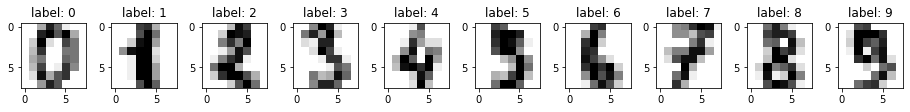

In [35]:
from sklearn import datasets
import matplotlib.pyplot as plt

# load the digits dataset
digits_dataset = datasets.load_digits()

def visualize_image(subplot, image, label):
    subplot.imshow(image, cmap=plt.cm.gray_r, interpolation='nearest')
    subplot.set_title(f'label: {label}')

# display the first 10 images with labels
fig, axs = plt.subplots(1, 10, figsize=(16, 1.2))    # 10 subplots
for index in range(10):
    visualize_image(axs[index], digits_dataset.images[index], digits_dataset.target[index])
plt.show()    # show plot

<details>
    <summary>&#9432; <i>Überprüfung &nbsp; &nbsp; <font color="CCCCCC">(anklicken, um Lösung anzuzeigen)</font></i></summary>
    <br>Folgende Grafik sollte angezeigt werden:
    <br><img src="data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAA44AAABwCAYAAABRhy5gAAAABHNCSVQICAgIfAhkiAAAAAlwSFlzAAALEgAACxIB0t1+/AAAADh0RVh0U29mdHdhcmUAbWF0cGxvdGxpYiB2ZXJzaW9uMy4yLjIsIGh0dHA6Ly9tYXRwbG90bGliLm9yZy+WH4yJAAAWjUlEQVR4nO3df5BdZX3H8c+X0AAaEhaITAk0YQtiUScJbtOqM5JMswxaO9liyVi1ZrE2adWR4EybiE6T9IeTqO0k0zIa20Ji1SqxQ4KOoqAk1bHTkpVERcGSXyQimJAf/JApBb/949zoNew+z9l7z33Oj32/Znay2efsOc/53HOfe569556vubsAAAAAABjLaWV3AAAAAABQbUwcAQAAAABBTBwBAAAAAEFMHAEAAAAAQUwcAQAAAABBTBwBAAAAAEGlTxzNbL+ZLcy5rJvZpR1up+PfbQqyToOc0yHrdMg6HbJOh6zTIOd0yDqdiZh16RPHKjKzM8zsFjN7wsweNbP3ld2npjKzxWb2LTP7qZltL7s/TWVmHzWz/zGzJ83sATN7e9l9aioz+7CZHWyNHwfM7ANl96npzOxcMztsZt8suy9NZWabzOxZM3uq7WtS2f1qKjNbaGbfNrOnW+PJ4rL71DRmdv8px/NzZvaFsvvVRK0x+nNmdqT19Wkzm1p2v5rIzGaY2TYzO2pmh8zsT4tcPxPH0a2WdJmkmZIWSPoLM7um1B4111FJ6yWtLbsjDfe0pN+TNE3SEkkbzOw15Xapsf5F0svcfaqk10h6i5ldW3Kfmm6dpB+U3YkJ4MPuPqXt6/myO9REZnaFpM9I+oCyMXuOpJFSO9VA7v7yk8eypLMlPSxpS8ndaqq/kdQnqV/Sr0u6QNm5Nor3KUn7lGX8u5I+ZGYLilp5pSaOZjbPzP7TzI6b2Y/N7B/NbPIpi73BzPa2/mLxETM7re3332FmPzCzY2b2FTOb2WFX3i7pr939mLv/QNI/SRrucF2VVJWs3f1ud79N0iPd7E9VVSjnVe7+gLv/zN3/S9I3JL26i12rnApl/aC7P932o59JqsQlJkWpStatdb1a0isk3drpOqqsSlk3XYWy/qCkje7+ZXd/zt0fd/c9He9YxVQo53avk/QSSf9ewLoqo0JZXyJpq7s/4e4nJN0u6eUdrquSqpC1mU2RNF/S37r7/7n7bkmfl/SObvatXaUmjpKel3SjpPOVndT+jqR3nbLM70sakHSlpEVqhWFmQ5JuknStpOnKToz/bbSNmNlbzOw7Y7T1SbpQ0u62H+9Www5wVSDrCaJyOZvZWZJ+U9L949yXqqtM1ma20syeknRI0ouVvXvQJJXI2rJLJW+W9B5J3vnuVFolsm55l2WXP42Y2Zs6251Kq0rWv91a7rutE9BPmdm5ne5UBVUl53ZLJH3+lD/6NUFVsr5Z0hvNrK91nv0mSV/ucJ+qqgpZ2yn/nvz+FePcl7G5e6lfkvZLWjhG23JJt7f93yVd0/b/d0n6Wuv7L0v647a20yT9VNLMtt+9NEd/Lm4te2bbzwYl7S87q6Zlfcr23ylpe9kZNT3n1u9tlnSnJCs7qyZnrWywnitpjaSzy86qiVkre5H+WOv7YUnfLDunBmd9paTzJJ0u6Q2SnpT02rKzamjWz7b69VJJU5S9C/bpsrNqWs5t63iRpCckzS87p6ZmrewNmbuVXYHzM0l3SZpcdlYNzfqbkv5B0pmtcfuopAeL2udKveNoZi81sy9adkOaJyR9SNnMvd3Btu8PKDsYpezziBtabxEfVxaUSZoxzm481fq3/UO7U5W9SDZGRbJuvKrlbGYfUfaXp8XeGmGaompZe+Y+Sc8omzw2RhWyNrMLJb1X2efAGqsKWUuSu3/bs0smn3P3L0n6tLK/jjdGVbJWNmbc6u4/dPenWv14QwfrqaQK5XzSta317OhiHZVUoay3SPqhss+STpW0R9ln8RqjQlm/VdmlwQclfUzZWH2og/WMqlITR2U7+ICkyzy7scRN+uW3W6XsHcGTfk2/+GzcQUnL3P2ctq+z3P1b4+mAux+T9GNJs9t+PFvNu6yv9KwniMrkbGZrJL1e0tXu/kQn66i4ymR9itOV3QygSaqQ9TxJvyrp+2b2qKQNkua1XrSbdLfPKmQ9Gh+lH3VXlay/o+Zeei1VJ+eTlkj6ZNP+mNpSlaxnK/vc7tOtP4Z8XA36Y0hLJbJ29wPu/kZ3n+7uv6XsSpH/HvfejKFqE8ezlV0u8JSZvUzSn42yzJ+3rpG+WNINkj7X+vnHJb3fzF4uSWY2zcyu67Afn5T0wdZ2XibpTyRt6nBdVVWJrM1skpmdqezk+jQzO9PMfqWTdVVUVXJ+v6S3SBp098c7WUcNlJ61mZ1mZsta2zAzmyfp3ZK+1skOVVjpWSu7tGeWsjtOzpH0l5LukzTHm3W3zypkLTP7AzOb0jrGr5b0Nkl3dLKuCqtE1spu9HS9mfWb2YskrZD0xQ7XVUVVyVlmdpGyu+dv7nQdFVeVrO+V9E4zO8uy+yws1S/fS6QJKpG1mf2GmZ1tZpPN7G2Srpb0952sa1RFXfPa6Zfarg9WdlerB5RdLvoNSX+lts+sKPsL3Hsl7ZX0uKS/kzSprf2PJH1X2QN3UNItp/zupa3v3yrp/kCfzpB0S2s9j0l6X9k5NTjr4dby7V+bys6qgTm7pP9t9ePk101lZ9W0rJX9Me5OZZeZPKXs0pyb1LDPk1Yh61H6N6wGfsaxKlm3tn2itZ7dkt5cdk5Nzbq1zBpJh1tf/yqpr+ysGprz+yV9o+x8mp61sksnv9DaxlFlr5OXlZ1VQ7Ne3ho3nlb2eceBIvfZWhsBAAAAAGBUVbtUFQAAAABQMUwcAQAAAABBTBwBAAAAAEFMHAEAAAAAQUwcAQAAAABBp+dZyMyuUVZceZKkf3b3taHlzz//fJ81a1bHnTp27Fh0mUOHDgXbp06dGmy/6KKLgu2TJnVXP3r//v06cuTIuIsjjyfrbnPO48EHHwy2P/98uFzahRdeGGw/55xzxt2nU42MjBxx9+nj+Z3Ux3QeTz75ZLB9z549wfazzjor2H755ZePu0/tUhzTUvdZP/roo9FlfvSjHwXbJ0+eHGy/4oorgu11GD+kNMd1bIzYt29fsP3SSy8tsjsvUJesY2OxJJ1xxhnB9l4/1jG8LmZi40cR6vC6+Nhjj0WXiWV5/PjxYPszzzwTbM8zVr/yla8cs+3hhx/W448/Xvnx4+DBg9FlYlmed955wfYLLrgg2D5RXhcfeuih6DKx47rb87VuhbKOThzNbJKkmyUNSjok6V4zu8Pdvz/W78yaNUs7d+7stL/asmVLdJkVK1YE2wcHB4Pta9cGjxv19fVF+xAyMDAw7t8Zb9bd5pzH/Pnzg+2xgWbNmjXB9kWLFo23Sy9gZgfGuXzyYzqP7du3B9uHhoaC7XPmzOlq/TEpjmmp+6zXrVsXXWblypXB9hkzZgTbv/71rwfb6zB+SGmO69gYMTw8HGzfunVrgb15obpkHRuLT24jZNOmTR1vvwi8LmZ63T+pHq+L69evjy4TyzI2PuzeHa4xP2XKlGgf7rnnnjHbFixYEP39U5WR9fLly6PLxLKMjdWxbXT7RkFdxurYuZoUP667PV/rVijrPJeqzpP0kLvvdfdnJX1WUvdn+xgNWadBzumQdTpknQ5Zp0PWaZBzOmSdDlkXLM/EcYak9ve4D7V+huKRdRrknA5Zp0PW6ZB1OmSdBjmnQ9bpkHXB8kwcR7vG1V+wkNlSM9tpZjsPHz7cfc8mpmjW5FwIjul0yDodsk6HrNPhdTENjul0yDodsi5YnonjIUkXt/3/IkmPnLqQu3/C3QfcfWD69HF9Hhu/EM2anAvBMZ0OWadD1umQdTq8LqbBMZ0OWadD1gXLM3G8V9JlZnaJmU2W9GZJd/S2WxMWWadBzumQdTpknQ5Zp0PWaZBzOmSdDlkXLHpXVXd/zszeI+krym5le4u739/LTsXumCrFb+EeK+lx7rnnBttvu+22aB+uu+666DLjUUbWMbG7YO3YsSPYHrobmVTMXVXHq4ycd+3aFV0mdne2adOmBdv3798/ni4l0YusY3dEzfPc3bhxY7B92bJlwfaRkZFg+8KFC6N9KFoVxw8pfifP2N2Aq6iMrPM8v2Pj8ebNm4PtM2fO7LoPRUud9bZt26LLxHJetWpVUd1JpqrjR+wcJHZn1lh77O6WsT50UmKiqucgMbGxPHYn0DLuFNqLrGPjYJ4xJMYsXHVk9uzZwfYiHu+x5Krj6O5fkvSlnvUCP0fWaZBzOmSdDlmnQ9bpkHUa5JwOWadD1sXKc6kqAAAAAGACY+IIAAAAAAhi4ggAAAAACGLiCAAAAAAIYuIIAAAAAAhi4ggAAAAACMpVjqNosRposRqNkrRnz55ge39/f7B9cHAw2B7ro1R8HcfU8tR56bbuTh1rtPXC1q1bo8vE6vIMDQ0F29esWTOuPtXV0qVLg+156sC+6lWvCrZfcsklwfYy6jRWUZ4aaLHaX8uXLw+2F1E7cNasWV2vo2yxenaSdODAgWB7rBbs/Pnzg+3d1ryrgyJqMMbGamRiz/08Vq9eHWyPjR9l1BYsQ55zsdg4GRvLY8/9PFnHxqAqyDMOxlx11VXB9thjUeZxyzuOAAAAAIAgJo4AAAAAgCAmjgAAAACAICaOAAAAAIAgJo4AAAAAgCAmjgAAAACAICaOAAAAAIAgJo4AAAAAgKDTy9josWPHgu1XXnlldB39/f1d9SFWALwJ1q9fH2yPFc6VpBMnTnTVhzoUc00hT6HjWMHX2DoWLVo0ni7VVuy5v3fv3ug69u3bF2xfuHBhsD02hvX19UX70ASxgtBSvAD38PBwsD123OcpOJ9nrKu62PggSbt37w62x8bzWJHwPFnXXZ7i3rNnzw625ym2PhHEipQXUcQ8dp4Ts3Xr1ugysTGqDvLsw9y5c4PtsbE8Nj7kGcPqoIj9iB13Q0NDwfY841Sv8I4jAAAAACCIiSMAAAAAIIiJIwAAAAAgiIkjAAAAACCIiSMAAAAAIIiJIwAAAAAgiIkjAAAAACCoknUcBwcHS+9DE+qwxeqf5anr020OZdaaSSm2n3lqTeWpJxWSp6beRJCnxuvRo0eD7bE6jrH2u+++O9qHOowx27ZtC7bfeOON0XUsWbKkqz5s2LAh2H7rrbd2tf66yDM+xOri7dq1K9ie5/GMyVOztsryvGbF6rjFxvtYjbaJUu8udjxK3dd6jD1vJkqt6SLOxXbs2BFsj9VHbspxHatXGavzKsVf/2+44YZge+y5E6u5KXX+ePCOIwAAAAAgiIkjAAAAACCIiSMAAAAAIIiJIwAAAAAgiIkjAAAAACCIiSMAAAAAIIiJIwAAAAAgqJQ6jrH6JSMjI11vI1ancefOncH2xYsXd90HxGvNzJkzJ1FPemv16tXB9lgtujxi9ahitYXwC7ExKFaHcdmyZcH2devWRfuwdu3a6DJlmzZtWlftkrR58+Zge55abiGxmngTSa9r0uWpDVZ3eWqbxerZxWrmxepl3nfffdE+1OG1M5ZlntqkZtbVOiZKncbYOLpgwYLoOlatWhVsjz3/Y2Nxnse7CbUe87ym9frcOE893U5rh+eaOJrZfklPSnpe0nPuPtDR1hBF1umQdRrknA5Zp0PW6ZB1OmSdBjmnQ9bFGs87jgvc/UjPeoJ2ZJ0OWadBzumQdTpknQ5Zp0PWaZBzOmRdED7jCAAAAAAIyjtxdElfNbMRM1s62gJmttTMdprZzsOHDxfXw4knmDU5F4qs02D8SIes0yHrdBir0yHrNBg/0iHrAuWdOL7W3a+U9HpJ7zaz1526gLt/wt0H3H1g+vTphXZygglmTc6FIus0GD/SIet0yDodxup0yDoNxo90yLpAuSaO7v5I69+fSLpd0rxedmoiI+t0yDoNck6HrNMh63TIOh2yToOc0yHrYkUnjmb2YjM7++T3kq6W9L1ed2wiIut0yDoNck6HrNMh63TIOh2yToOc0yHr4uW5q+oFkm5v1dI5XdJn3P3Objba398fbI/VWJSkLVu2dNUes2LFiq5+v0OFZ40xFZr18PBwsH379u3RdezevTvYHquRtGjRomD79ddfH+1DbB0dSH5Mr1y5MrrMwoULg+2xOrB33XVXsL2kOrCFZx2rgRarVyfF61XFtrFkyZJge0n1S5Mf19u2bYsuE6urGas3G1NSzcykWcfGcilehzFWiy5WDy9PfbUe1XFMmnWeWnOxY/qqq64qqjspFZ5z7JjLU3M39njEjtu5c+cG2zdt2hTtQ7dj1CgqeV4de/7GHotYlp3WaMwjOnF0972SZvesB/g5sk6HrNMg53TIOh2yToes0yHrNMg5HbIuHuU4AAAAAABBTBwBAAAAAEFMHAEAAAAAQUwcAQAAAABBTBwBAAAAAEFMHAEAAAAAQUwcAQAAAABB0TqOvdDf3x9sX7duXXQdK1asCLYPDAwE20dGRqLbaLo8hbNjBeFjRaljhe/zFFuug1gx11gR9DzLxArjxh6LWIFgKf5410FfX190maVLl3a1jcWLFwfbN27c2NX6myQ2zpw4cSLY3pQxolv33HNPdJkNGzZ0tY0lS5YE2+fPn9/V+usgz/EWK4QeK84dy3FoaCjahyaInR9I0ubNm4Ptec5jJoJYDnmeu7HXzmnTpgXbY+cPsaL2TZFnP2Pne8ePHw+2x547sXPSbvCOIwAAAAAgiIkjAAAAACCIiSMAAAAAIIiJIwAAAAAgiIkjAAAAACCIiSMAAAAAIIiJIwAAAAAgyNy9+JWaHZZ0oO1H50s6UviGitOL/s109+kFr/OX1DBniaxTKrqPPc9ZIusWsh4bWafBWJ0OWafD+JEOWaeTLOueTBxfsBGzne4+0PMNdajq/curDvtRhz7mUYf9qEMf86jDftShj3nUYT/q0Mc8qr4fVe9fXnXYjzr0MY867Ecd+phHHfajDn3Mow77kbKPXKoKAAAAAAhi4ggAAAAACEo1cfxEou10qur9y6sO+1GHPuZRh/2oQx/zqMN+1KGPedRhP+rQxzyqvh9V719eddiPOvQxjzrsRx36mEcd9qMOfcyjDvuRrI9JPuMIAAAAAKgvLlUFAAAAAAT1dOJoZteY2YNm9pCZrezltjplZvvN7LtmtsvMdpbdn06RdTpknQY5p0PW6ZB1OmSdDlmnQc7pkPUY2+zVpapmNknSDyUNSjok6V5Jf+ju3+/JBjtkZvslDbh71Wu0jIms0yHrNMg5HbJOh6zTIet0yDoNck6HrMfWy3cc50l6yN33uvuzkj4raVEPtzeRkXU6ZJ0GOadD1umQdTpknQ5Zp0HO6ZD1GHo5cZwh6WDb/w+1flY1LumrZjZiZkvL7kyHyDodsk6DnNMh63TIOh2yToes0yDndMh6DKf3cN02ys+qeAvX17r7I2b2Ekl3mdkD7v4fZXdqnMg6HbJOg5zTIet0yDodsk6HrNMg53TIegy9fMfxkKSL2/5/kaRHeri9jrj7I61/fyLpdmVvT9cNWadD1mmQczpknQ5Zp0PW6ZB1GuScDlmPoZcTx3slXWZml5jZZElvlnRHD7c3bmb2YjM7++T3kq6W9L1ye9URsk6HrNMg53TIOh2yToes0yHrNMg5HbIeQ88uVXX358zsPZK+ImmSpFvc/f5eba9DF0i63cykLIvPuPud5XZp/Mg6HbJOg5zTIet0yDodsk6HrNMg53TIemw9K8cBAAAAAGiGXl6qCgAAAABoACaOAAAAAIAgJo4AAAAAgCAmjgAAAACAICaOAAAAAIAgJo4AAAAAgCAmjgAAAACAICaOAAAAAICg/wfy4OWp48ab5AAAAABJRU5ErkJggg==" alt="samples of digit dataset" />
</details>

Der zweite Schritt in der Deep-Learning-Verarbeitungskette ist die Datenvorverarbeitung.
Wandeln Sie die Bilder in einen eindimensionalen Vektor um, dessen Werte im Intervall \[0, 1\] liegen.
Hinweis: Die Werte der Pixel in Bildern des Digit-Datensatzes liegen im Intervall \[0, 16\].

In [37]:
# convert image to floating point matrix
x = digits_dataset.images.astype('float32')

# reshape input x such that it is a 1D vector for each sample
samples, rows, cols = x.shape
x = x.reshape(samples, rows * cols)   # bitte Code ergaenzen <---------------- [Luecke (52)]

# normalize values to range [0, 1]
x =  x/16.0  # bitte Code ergaenzen <---------------- [Luecke (53)]


Die Label des Digit-Datensatzes geben an, um welche Ziffer es sich handelt.
Verarbeiten Sie die Label derart, dass sie für die Unterscheidung von geraden und ungeraden Zahlen geeignet sind.
Gerade Zahlen sollen dabei das Klassenlabel 0 bekommen und ungerade Zahlen das Klassenlabel 1.

In [38]:
# get labels as teacher
t = digits_dataset.target

# change the labels to 0 for even numbers and 1 for odd numbers
for i in range(len(t)):
    if t[i] % 2 == 0:    # even number
        t[i] =  0  # bitte Code ergaenzen <---------------- [Luecke (54)]
    else:    # odd number
        t[i] =   1 # bitte Code ergaenzen <---------------- [Luecke (55)]

# convert teacher to array
t = np.array(t)

Nun müssen die Daten noch in Trainings- und Validierungsdaten aufgeteilt werden.

In [39]:
from sklearn.model_selection import train_test_split

# split data to training and validation data (use 15% of data for validation)
x_train, x_val, t_train, t_val = train_test_split(x, t, test_size=0.15, random_state=42)

Um die korrekte Funktionsweise eines Neuronalen Netzwerks nachzuweisen, sollte zunächst nur ein einzelner Batch verwendet werden.
Das Neuronale Netzwerk muss in der Lage sein, diesen Trainingsbatch auswendig zu lernen und einen Fehler nahe Null zu erzeugen.

In [40]:
# use only 32 samples as one single batch for training to show that the implemented framework works
x_train = x_train[:32, :]
t_train = t_train[:32]

Um zu testen, ob die gewünschte Datenvorverarbeitung erreicht wurde, können Sie die nachfolgenden Ausgaben mit der Musterlösung vergleichen.

In [41]:
import numpy as np
print(f'(number of samples, feature dimension) of x_train = {x_train.shape}')
print(f'(number of samples, feature dimension) of x_val = {x_val.shape}')
print(f'number of samples of t_train = {t_train.shape}')
print(f'number of samples of t_val = {t_val.shape}')
print(f'unique labels in t_train = {np.unique(t_train)}')
print(f'minimum value of x_train = {np.min(x_train)}')
print(f'maximum value of x_train = {np.max(x_train)}')

(number of samples, feature dimension) of x_train = (32, 64)
(number of samples, feature dimension) of x_val = (270, 64)
number of samples of t_train = (32,)
number of samples of t_val = (270,)
unique labels in t_train = [0 1]
minimum value of x_train = 0.0
maximum value of x_train = 1.0


<details>
    <summary>&#9432; <i>Überprüfung &nbsp; &nbsp; <font color="CCCCCC">(anklicken, um Lösung anzuzeigen)</font></i></summary>
    <br>Es sollte folgendes angezeigt werden:
    <br><code>(number of samples, feature dimension) of x_train = (32, 64)
(number of samples, feature dimension) of x_val = (270, 64)
number of samples of t_train = (32,)
number of samples of t_val = (270,)
unique labels in t_train = [0 1]
minimum value of x_train = 0.0
maximum value of x_train = 1.0</code>
</details>

---
#### [ VI ] Erstellen Sie unter Nutzung der bisher erstellten Klassen ein zweischichtiges MLP mit ReLU-Ausgabe in der Hiddenschicht und Sigmoid-Ausgabe in der Ausgabeschicht, das eine binäre Klassifikation der Bilder des Digit-Datensatzes realisiert.

Der dritte Schritt in der Deep-Learning-Verarbeitungskette ist die Modellauswahl.
Nutzen Sie die zuvor erstellten Klassen, um ein zweischichtiges Multi-Layer Perceptron (MLP) zu erstellen, das wie folgt aufgebaut ist:
* 64-dimensionale Eingabe
* erste Schicht: vollverschaltet, 10 Hiddenneuronen, ReLU-Ausgabe
* zweite Schicht: vollverschaltet, 1 Ausgabeneuron, Sigmoid-Ausgabe

In [42]:
# define the neural network
class Network(Module):
    """implements a multi layer perceptron (MLP)
    with one hidden layer of 10 neurons and one output layer of a single neuron

    hint: construction similar to PyTorch
          --> compare with "Code Beispiel 2.9 [2/4] CNN in PyTorch: Netzwerk definieren" in slides of chapter 2
    """

    def __init__(self):
        """create and initialize the two fully connected layers"""
        # create fully connected layer: 64-dimensional input, 10 hidden neurons
        self.fc1 = Linear(64, 10)
        # create fully connected layer: 10 hidden neurons as input, 1 output neuron
        self.fc2 =  Linear(10,1)  # bitte Code ergaenzen <---------------- [Luecke (56)]

    def forward(self, x):
        """forward pass for input x"""
        # calculation of 1st layer: input x --> fully connected layer --> relu
        x = relu(self.fc1(x))
        # calculation of 2nd layer: output of 1st layer x --> fully connected layer --> sigmoid
        x =  sigmoid(self.fc2(x))  # bitte Code ergaenzen <---------------- [Luecke (57)]
        return x

    def parameters(self):
        """return parameters (weights, bias) of all layers in the network"""
        fc1_parameters = self.fc1.parameters()    # get the list of parameters for 1st layer
        fc2_parameters = self.fc2.parameters()    # get the list of parameters for 2nd layer
        return fc1_parameters + fc2_parameters    # concatenate the lists

    def __call__(self, x):
        """call function for forward pass with input x
        type checking needed to enable batch processing in case x is a numpy array"""
        if isinstance(x, (np.ndarray, np.float32)):    # in case it is a numpy array
            if x.ndim > 1:    # if it has more than one dimension (batch dimension + feature dimension)
                x = x.tolist()    # make it a list
                y = []    # output will be a list of multiple elements, start with empty list
                for x_i in x:    # for each element x_i in the list x
                    y_i = self.forward(x_i)    # calculate the output for sample x_i
                    y.append(y_i)    # and add it to the list
                return y    # return the list of outputs
            else:    # only the feature dimension
                x = x.tolist()    # make it a list
                self.forward(x)    # process it
        else:    # in case x is a single input
            return self.forward(x)    # process it

    def __repr__(self):
        """string representation of this class"""
        return f'MLP[{str(self.fc1)} --> ReLU --> {str(self.fc2)} --> Sigmoid]'

# set random seed for reproducibility (weight initialization is random)
random.seed(1337)

# create the neural network
net =  Network()  # bitte Code ergaenzen <---------------- [Luecke (58)]

# print information about the neural network
print(net)
print(f'number of parameters = {len(net.parameters())}')

MLP[FCLayer[Neuron(64 inputs), Neuron(64 inputs), Neuron(64 inputs), Neuron(64 inputs), Neuron(64 inputs), Neuron(64 inputs), Neuron(64 inputs), Neuron(64 inputs), Neuron(64 inputs), Neuron(64 inputs)] --> ReLU --> FCLayer[Neuron(10 inputs)] --> Sigmoid]
number of parameters = 661


<details>
    <summary>&#9432; <i>Überprüfung &nbsp; &nbsp; <font color="CCCCCC">(anklicken, um Lösung anzuzeigen)</font></i></summary>
    <br>Es sollte folgendes angezeigt werden:
    <br><code>MLP[FCLayer[Neuron(64 inputs), Neuron(64 inputs), Neuron(64 inputs), Neuron(64 inputs), Neuron(64 inputs), Neuron(64 inputs), Neuron(64 inputs), Neuron(64 inputs), Neuron(64 inputs), Neuron(64 inputs)] --> ReLU --> FCLayer[Neuron(10 inputs)] --> Sigmoid]
number of parameters = 661</code>
</details>

---
#### [ VII ] Implementieren Sie die benötigten Funktionen zur Realisierung des Trainings.

Um die Parameter des Neuronale Netzwerks im Training anpassen zu können, muss ein Fehler berechnet werden, der zu den einzelnen Parametern zurückpropagiert werden kann.
Verwenden Sie den Binary Cross Entropy (BCE) Loss für $N$ Trainingsbeispiele:
$$E^{BCE} = \frac{1}{N} \cdot \sum_{i=1}^{N} t_i \cdot ln(y_i) + (1 - t_i) \cdot ln(1 - y_i)$$

Für dessen Berechnung muss zunächst noch die Logarithmus-Funktion so umgesetzt werden, dass sie differenzierbar ist:

In [43]:
import numpy as np

def log(x):
    if isinstance(x, (list, tuple)):    # in case of more then one input
        out = []    # output will be a list of multiple elements, start with empty list
        for x_i in x:    # for each element x_i in the list x
            out_i = log(x_i)    # calculate the element's non-linear output
            out.append(out_i)    # and add it to the list
        return out    # return the list of outputs
    else:
        # x needs to be an instance of class Value
        if not isinstance(x, Value):
            x = Value(x)

        # calculate the logarithm output
        forward_result = np.log(x.data)

        # create a new Value (self.__class__) that can store the result and the calculation tree
        out = Value(forward_result, (x,))

        # backward path: deviation
        def _backward():
            # calculate derivative of activation function (log)
            derivative_log = 1.0 / x.data
            # update gradient
            x.grad += derivative_log * out.grad

        # add this backward function to the new node
        out._backward = _backward

        return out

Implementieren Sie den Binary Cross Entropy (BCE) Loss, der die Prädiktionen des Neuronalen Netzwerks $\mathbf{\underline{y}}$ und die zugehörigen Teacher-Werte $\mathbf{\underline{t}}$ als Eingabe bekommt.

In [44]:
def binary_cross_entropy_loss(y, t):
    # initialize loss with zero
    loss = 0

    # loop throug all outputs y and labels t simultaniously
    for y_i, t_i in zip(y, t):
        # calculate loss for this output and teacher (see above for the equation inside the sum)
        loss_i =  t_i * log(y_i) + (1 - t_i) * log(1 - y_i) # bitte Code ergaenzen <---------------- [Luecke (59)]
        # add it to overall loss
        loss += loss_i

    # devide loss by the number of samples
    n_samples = len(y)
    loss = -(1 / n_samples) * loss

    return loss

Um zu testen, ob die gewünschte Funktionalität umgesetzt wurde, können Sie die nachfolgenden Ausgaben mit der Musterlösung vergleichen.

In [45]:
y = [Value(0.9), Value(0.1), Value(0.4)]
t = [1, 0, 1]
loss = binary_cross_entropy_loss(y, t)
for i in range(len(y)):
    y[i].grad = 0
loss.backward()
print(f'loss = {loss}')
print(f'y = {y}')

loss = Value(data=0.37567058772993583, grad=1)
y = [Value(data=0.9, grad=-0.37037037037037035), Value(data=0.1, grad=0.37037037037037035), Value(data=0.4, grad=-0.8333333333333333)]


<details>
    <summary>&#9432; <i>Überprüfung &nbsp; &nbsp; <font color="CCCCCC">(anklicken, um Lösung anzuzeigen)</font></i></summary>
    <br>Es sollte folgendes angezeigt werden:
    <br><code>loss = Value(data=0.37567058772993583, grad=1)
y = [Value(data=0.9, grad=-0.37037037037037035), Value(data=0.1, grad=0.37037037037037035), Value(data=0.4, grad=-0.8333333333333333)]</code>
</details>

Als zusätzliches Bewertungsmaß soll die Accuracy berechnet werden.
Dafür werden die Ausgaben des Neuronalen Netzwerkes $\mathbf{\underline{y}}$ binarisiert und mit den Klassenlaben $\mathbf{\underline{t}}$ verglichen.
Die Accuracy gibt den Anteil der übereinstimmenden Klassenlabel im Verhältnis zu allen Labeln an.
Implementieren Sie die Funktion zur Berechnung der Accuracy.

In [46]:
def accuracy(y, t):
    # count number of samples and number of correct predictions
    correct = 0
    total = 0

    # loop throug all outputs y and labels t simultaniously
    for y_i, t_i in zip(y, t):
        # binarize the decisions of the neural network (class label 1 if y_i > 0.5, class label 0 otherwise)
        if y_i.data > 0.5:
            predicted_class = 1   # bitte Code ergaenzen <---------------- [Luecke (60)]
        else:
            predicted_class =  0  # bitte Code ergaenzen <---------------- [Luecke (61)]

        # count this sample
        total += 1

        # increase number of correct predictions if prediction for current sample is correct
        if predicted_class == t_i:
            correct += 1

    # calculate accuracy
    acc = correct / total

    return acc

Um zu testen, ob die gewünschte Funktionalität umgesetzt wurde, können Sie die nachfolgenden Ausgaben mit der Musterlösung vergleichen.

In [47]:
y = [Value(0.9), Value(0.1), Value(0.4)]
t = [1, 0, 1]
acc = accuracy(y, t)
print(f'acc = {acc}')

acc = 0.6666666666666666


<details>
    <summary>&#9432; <i>Überprüfung &nbsp; &nbsp; <font color="CCCCCC">(anklicken, um Lösung anzuzeigen)</font></i></summary>
    <br>Es sollte <code>acc = 0.6666666666666666</code> ausgegeben werden.
</details>

Während eines Trainingsschritts wird zunächst ein Forward Pass ausgeführt.
Dann müssen die Gradienten des vorherigen Trainingsschritts zurückgesetzt werden.
Anschließend kann der Backward Pass durchgeführt werden, um die Gradienten zu ermitteln, mit denen alle Parameter des Neuronalen Netzwerks adaptiert werden können.
Implementieren Sie die Funktion `train_step`, die die beschriebene Vorgehensweise umsetzt.

In [48]:
def train_step(X, t, net):
    # forward pass with input data X
    y =  net(x)  # bitte Code ergaenzen <---------------- [Luecke (62)]

    # compute loss and accuracy
    loss =   binary_cross_entropy_loss(y,t) # bitte Code ergaenzen <---------------- [Luecke (63)]
    training_data_accuracy =  accuracy(y,t)  # bitte Code ergaenzen <---------------- [Luecke (64)]

    # reset gradients from previous train step
    net.zero_grad()    # bitte Code ergaenzen <---------------- [Luecke (65)]

    # calculate all gradients
    loss.backward()    # bitte Code ergaenzen <---------------- [Luecke (66)]

    # update every parameter with sgd
    learning_rate = 0.25
    for parameter in net.parameters():
        parameter.data = parameter.data - parameter.grad * learning_rate

    return net, loss, training_data_accuracy

---
#### [ VIII ] Implementieren Sie eine Funktion zur Realisierung des Tests auf Validierungsdaten.

Für die Valdierung ist nur der Forward Pass notwendig. Anschließend werden die Ausgaben des Neuronalen Netzwerks mit den Labeln verglichen, um die Bewertungsmaße zu berechnen.

In [49]:
def test_step(X, t, net):
    # forward pass with input data X
    y =  net(x)  # bitte Code ergaenzen <---------------- [Luecke (67)]

    # calculate performance measures (compare network outputs y and teacher t)
    loss = binary_cross_entropy_loss(y,t)   # bitte Code ergaenzen <---------------- [Luecke (68)]
    acc =  accuracy(y,t)  # bitte Code ergaenzen <---------------- [Luecke (69)]

    return loss, acc

---
#### [ IX ] Trainieren und validieren Sie das Neuronale Netzwerk.

Nachfolgend soll das Neuronale Netzwerk trainiert werden.
Führen Sie 100 Trainingsschritte aus.
Validieren Sie nach jedem fünften Trainingsschritt.
Speichern Sie für jeden Trainings- und Validierungsschritt den Loss und die Accuracy.

<p>&#9432; <i>Hinweis:</i> Beobachten Sie die Ausgaben während des Trainings.
    Legen Sie Ihre Aufmerksamkeit zunächst auf den Loss bezüglich der Trainingsdaten.
    Am Anfang sind nur Fortschritte bei diesem Bewertungsmaß zu beobachten, diese wirken sich aber noch nicht auf die Accuracy aus.
    Erst nach etwa dem zehnten Trainingsschritt zeigen sich auch deutliche Verbesserungen bei der Accuracy.</p>

In [ ]:
# lists to store performance measures during training
loss_list = []
accuracy_list = []
val_loss_list = []
val_accuracy_list = []

# start training
for step in range(100):    # 100 training steps
    # perform one training step (training data: x_train, t_train; neural network: net)
    net, loss, train_acc =  train_step(x_train, t_train, net)  # bitte Code ergaenzen <---------------- [Luecke (70)]

    # store performance measures
    loss_list.append(loss.data)
    accuracy_list.append(train_acc * 100)

    # print output and validate every 5th training step
    if step % 5 == 0:
        # perform one validation step (validation data: x_val, t_val; neural network: net)
        val_loss, val_accuracy = test_step(x_val, t_val,net)   # bitte Code ergaenzen <---------------- [Luecke (71)]

        # store performance measures
        val_loss_list.append(val_loss.data)
        val_accuracy_list.append(val_accuracy * 100)

        # print training progress
        print(f"step {step:>3}:  training:   loss = {loss.data:.4f}, accuracy = {(train_acc * 100):.3f}%\n           validation: loss = {val_loss.data:.4f}, accuracy = {(val_accuracy * 100):.3f}%\n")

# final validation step
val_loss, val_accuracy = test_step(x_val, t_val, net)

# store final performance measures
loss_list.append(loss.data)
accuracy_list.append(train_acc * 100)
val_loss_list.append(val_loss.data)
val_accuracy_list.append(val_accuracy * 100)

# print final training result
print('final result:')
print(f"step 100:  training:   loss = {loss.data:.4f}, accuracy = {(train_acc * 100):.3f}%\n           validation: loss = {val_loss.data:.4f}, accuracy = {(val_accuracy * 100):.3f}%\n")

<details>
    <summary>&#9432; <i>Überprüfung &nbsp; &nbsp; <font color="CCCCCC">(anklicken, um Lösung anzuzeigen)</font></i></summary>
    <br>Folgende Ausgabe sollte angezeigt werden:
    <br><code>step   0:  training:   loss = 0.6866, accuracy = 56.250%
           validation: loss = 0.6875, accuracy = 51.111%

step   5:  training:   loss = 0.6506, accuracy = 56.250%
           validation: loss = 0.6666, accuracy = 51.111%

step  10:  training:   loss = 0.6056, accuracy = 62.500%
           validation: loss = 0.6352, accuracy = 64.815%

step  15:  training:   loss = 0.5427, accuracy = 84.375%
           validation: loss = 0.5902, accuracy = 81.111%

step  20:  training:   loss = 0.4605, accuracy = 90.625%
           validation: loss = 0.5376, accuracy = 82.593%

step  25:  training:   loss = 0.3775, accuracy = 93.750%
           validation: loss = 0.4936, accuracy = 82.963%

step  30:  training:   loss = 0.3089, accuracy = 93.750%
           validation: loss = 0.4663, accuracy = 83.333%

step  35:  training:   loss = 0.2572, accuracy = 93.750%
           validation: loss = 0.4555, accuracy = 83.333%

step  40:  training:   loss = 0.2185, accuracy = 93.750%
           validation: loss = 0.4540, accuracy = 82.593%

step  45:  training:   loss = 0.1888, accuracy = 93.750%
           validation: loss = 0.4604, accuracy = 82.963%

step  50:  training:   loss = 0.1655, accuracy = 93.750%
           validation: loss = 0.4702, accuracy = 82.593%

step  55:  training:   loss = 0.1466, accuracy = 96.875%
           validation: loss = 0.4843, accuracy = 82.963%

step  60:  training:   loss = 0.1311, accuracy = 96.875%
           validation: loss = 0.5000, accuracy = 83.704%

step  65:  training:   loss = 0.1182, accuracy = 96.875%
           validation: loss = 0.5176, accuracy = 82.963%

step  70:  training:   loss = 0.1073, accuracy = 96.875%
           validation: loss = 0.5357, accuracy = 82.963%

step  75:  training:   loss = 0.0979, accuracy = 96.875%
           validation: loss = 0.5545, accuracy = 82.963%

step  80:  training:   loss = 0.0898, accuracy = 96.875%
           validation: loss = 0.5733, accuracy = 82.222%

step  85:  training:   loss = 0.0827, accuracy = 100.000%
           validation: loss = 0.5923, accuracy = 81.852%

step  90:  training:   loss = 0.0764, accuracy = 100.000%
           validation: loss = 0.6112, accuracy = 81.852%

step  95:  training:   loss = 0.0708, accuracy = 100.000%
           validation: loss = 0.6295, accuracy = 81.481%

final result:
step 100:  training:   loss = 0.0667, accuracy = 100.000%
           validation: loss = 0.6443, accuracy = 81.481%</code>
</details>

---
#### [ X ] Visualisieren Sie die Bewertungsmaße Loss und Accuracy über den Verlauf des Trainings. Was ist zu beobachten?

Visualisieren Sie die während des Trainings gespeicherten Bewertungsmaße Loss und Accuracy für die Trainings- und Validierungsdaten.

In [ ]:
# plot loss curves (data stored in loss_list and val_loss_list)
plt.plot(np.arange(len(loss_list)), loss_list,
         'b-', label='training')    # blue color, solid line for training curve
plt.plot(np.arange(len(val_loss_list)) * 5, val_loss_list,
         'b:', label='validation')    # blue color, dotted line for validation curve
plt.ylabel('loss')
plt.xlabel('training steps')
plt.legend(loc='lower left')
plt.axis([0, 100, 0, 0.71])
plt.show()

# plot accuracy curves (data stored in accuracy_list and val_accuracy_list)
plt.plot(np.arange(len(accuracy_list))  ,accuracy_list,  # bitte Code ergaenzen <---------------- [Luecke (72)]
         'r-', label='training')    # red color, solid line for training curve
plt.plot(  np.arange(val(accuracy_list)) * 5, val_accuracy_list,  # bitte Code ergaenzen <---------------- [Luecke (73)]
         'r:', label='validation')    # red color, dotted line for validation curve
plt.ylabel('accuracy [%]')
plt.xlabel('training steps')
plt.legend(loc='lower right')
plt.axis([0, 100, 49.5, 100.5])
plt.show()

<details>
    <summary>&#9432; <i>Überprüfung &nbsp; &nbsp; <font color="CCCCCC">(anklicken, um Lösung anzuzeigen)</font></i></summary>
    <br>Folgende Grafiken sollten angezeigt werden:
    <br><img src="data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAYsAAAEHCAYAAABfkmooAAAABHNCSVQICAgIfAhkiAAAAAlwSFlzAAALEgAACxIB0t1+/AAAADh0RVh0U29mdHdhcmUAbWF0cGxvdGxpYiB2ZXJzaW9uMy4yLjIsIGh0dHA6Ly9tYXRwbG90bGliLm9yZy+WH4yJAAAgAElEQVR4nO3dd3xU1bbA8d8ihN6LlAQIIFKFAKEoiKiIgAVRrqCiYOPZnvWq+Kzo9V7vFfsVEbBcFUEEFFSKDURQkSBcpAoCQmhGBARBSrLfH2vGGWIaMCcnM7O+n898MnvmzMnKUbKyz957bXHOYYwxxuSnhN8BGGOMKf4sWRhjjCmQJQtjjDEFsmRhjDGmQJYsjDHGFMiShTHGmAKV9PLkItILeBZIAMY65x7P8f5dwOVhsTQHajrnfsnrnDVq1HApKSneBGyMMTFq0aJFPzvnah7r58WrdRYikgB8D5wNZAALgUudcyvyOP584Hbn3Jn5nTctLc2lp6dHOlxjjIlpIrLIOZd2rJ/38jZUR2Ctc26dc+4gMAHom8/xlwLjPYzHGGPMMfIyWSQBm8LaGYHX/kREygG9gMl5vD9URNJFJD0zMzPigRpjjMmfl8lCcnktr3te5wPz8xqrcM6Nds6lOefSatY85ltuxhhjjpGXySIDqBfWTga25HHsQOwWlDHGFFteJouFQBMRaSgipdCEMC3nQSJSGTgdmFqYk2Zmwk8/RTROY4wxBfAsWTjnDgM3A7OAlcBE59xyEbleRK4PO7Qf8JFz7rfCnHfjRujZM/z7RC5mY4wxufNs6qxXKlRIc7/9ls7NN8MDD0DnzvDUU3DhhX5HZowxxdfxTp31dFGeF5o2hTPOgCefhIUL4aSToH59fW/tWpg9Gy67DMqX9zdOY4yJJVFX7kMERoyAN96A//4XvvwS5s2DrCyYPBluuAH27tVjd+2y21TGGBMJUZcsggYNgmXL4NRT4dZboVMnOOssWLECatXSY4YO1fctYRhjzPGJ2mQB0LgxzJgBb78Nmzdrwnj+ee1RAFx0EQwerL0R0KTy8cf+xWuMMdEqqpMFaCK45BJYtQpuuglGjoRmzWDcOBgwAK4PzLv65Rd4913teYD2NqzHYYwxhRP1ySKocmV47jkd9G7QQG9T9ewJa9bo+9Wqwfr1oeTx/vtw+umwbZt/MRtjTLSImWQR1K4dfPUVvPiiJo6TT4ZHH4UDByAhAUqX1uMOHNBeSfXq2rZehjHG5C3mkgVAiRLag1i5UtdfPPggtG0LX3wROuYvf4E5cyAxEQ4e1PGO//zHt5CNMaZYi8lkEVSnDkyYANOnw7590K2bzpDauVPfDw58796tM6iCNQqzs62nYYwx4WI6WQT17g3Ll8Nf/wqvvAKtWsGsWaH3a9bUMYw+fbT9/PM63hFcr2GMMfEuLpIF6IruJ56ABQugShXo1evIBXzhKlTQsYzgKvCsrKKN1RhjIungweM/R9wki6D27WHRIrjzTnjpJUhNhW+/PfKYa67R21cisGOHlhiZWqiauMYY479Dh2D8ePj6a23v33/854y7ZAFQpoyWDJkzR2dFnXKKrs/IbZxi71448URo1Ejbhw8XaajGGFMon30WWnRcogTcfDO89pq2K1c+/vNHXdXZtLQ0l56eHrHz/fwzXHmlrgQfMADGjIGKFfM+/rbbtGDhO+9A2bIRC8MYY47KihXwww9w/vna7txZZ3cGZ32uW6drzhIStH28VWfjsmcRrkYN+OAD+Mc/YNIk6NpV98zIS0qKruWwRGGMKUrbtmkViqB//hOuukpnb4IWV50xI/R+o0ahRBEJcd+zCPfRR7r+olw5mDYNOnTI//g1a2D+fBgyxJNwjDFxzDlYsgRat9Zf+n//O9x3nyaNWrW051C6NCQlFe581rOIoJ49teR5mTK6JmPy5PyPf/ppuOsurTtljDHHy7nQ7MupU/Uuxvz52h48WJNHcD1Yo0aFTxSRYMkih5YtdXptaqr2Mp55Ju9jn3tO/0NWq6btSMw4MMbEp+3bdeZlcFC6Rw8YPVpLFoEmhjZtdPDaD5YscnHCCTqz4MIL4fbb4Y47QvcFw5UsqTv1gf5HTU2FLVuKNlZjTPQaPlz/6AT9vdO5M9Stq+0KFeC666BqVf/iCxd126oWlbJldcbTbbfp7aaMDB1AChYizKlFC60vFdx4yRhjclqxQnf4vPRSbX/zDdSurc9F4PXX/YutINazyEdCgmb9f/1LE8cFF2iNqdx07ar/oRMStNbU2LFWX8oYA99/H3o+cqTWp/v9d21PmwYvv+xPXEfLkkUBRHQQ++WX4ZNP4JxzNBnk56WXtJTIqlVFE6MxpngJ/qH4yis6DrF6tbbvvVfXRpQpo+1ITm31mqfJQkR6ichqEVkrIsPyOKa7iCwRkeUi8rmX8RyPq68OLZ8/80xdzJeXv/5VZ1U1b67tQ4eKJkZjjL82bNAp99Ona7t3b/j3v3U8AnSQOvg82niWLEQkAXgB6A20AC4VkRY5jqkCjAQucM61BP7iVTyRcMklOp1txQqdqbBjR+7HlSgRWqMxd65u87pyZdHFaYwpGtnZutFacLFc3bpaASK4/UGdOrrdc3EZpD4eXvYsOgJrnXPrnHMHgQlA3xzHXAZMcc5tBHDO/eRhPBHRp48mjFWr4OyzC15jUakSNG6s/9MYY6Lf7t06vR70D8OXXtLqDwClSulMyuB2B7HEy2SRBGwKa2cEXgt3ElBVROaIyCIRuTK3E4nIUBFJF5H0zMxMj8ItvJ494b33dI+Mnj1DmynlJjVVV4ZXqaKLbd54I/dpuMaY4iv8VvLQodC3b2jx3GefwZtv+hNXUfIyWUgur+WcH1QSaA+cC5wDPCAiJ/3pQ86Nds6lOefSagaXL/qsVy/tei5dqs8Ls1HSlClatDB84yVjTPE2YYKOMwTHKYcN0z8Wg4vjqlUL3XaKZV4miwygXlg7Gci5ZC0DmOmc+8059zMwF2jjYUwR1aePTqldtAj69dNy5/np319nVPXuXTTxGWOO3ubNuhjuv//VdsuWOl4ZnO7atq0unouHBBHOy2SxEGgiIg1FpBQwEJiW45ipwGkiUlJEygGdgKgaCu7bNzStdtCg/HfVE4GzztLnP/wA3bvnX+HWGOM953SWY3ATtDJl9C7AihXaPvlkHZdITvYvxuLAsxXczrnDInIzMAtIAF5xzi0XkesD749yzq0UkZnAUiAbGOucW+ZVTF4ZPFgHuu+4Q9dXvPRSwX917Nihf8Hs2VM0MRpjjrRzp85Sys6Giy6CU0/Vgerq1bWya2Ki3xEWL1aiPILuvx8eewwefhgeeqjg4w8f1vpSALt26SC4McZ7gwfD4sU65ghadqNp08jsKFdcWYnyYuTRR3Vvi4cfhv/8p+Djg4ni1Vf1f9S1a72Mzpj49dFHujYqOK7Yrx/8z/+Ebht37BjbiSISrJBgBInoLaiMDLj2Wl2t2aNHwZ/r0kXHPurX9z5GY+LB7t0wcSKce64ulMvK0lvFGRm67unCC/2OMPrYbSgP7N4Np50GP/4I8+aF6tEXxt69WnisXTvv4jMmFv36qxb6rF1bd7E86SQYNUp7EM7F3+ylnOw2VDFUuTJ8+CGUL6+VavOrI5XTbbdp7Snbfc+YggX/1j10CBo2hEce0XaTJjqbaehQbcd7oogESxYeqVdPF+5s3ao77hW2mODf/qbjHcHd94wxuRs2DC6+WJ8nJsKTT8JVV4Xeb97ckkQkWbLwUMeOuq/FnDnaYyiM2rV1/AJ0y9apUz0Lz5iosmiRbhcQ7E1Ur67/XoLtIUNCBTxN5Fmy8NigQVqyfORIHfw+Go88Av/3fzrF1ph4k52tY37BUjpLl+q/oQ0btH3XXfrvynoPRcMGuItAVhacdx58+il88YVuv1oYe/booF1SzvKLxsQo5+DgQd2+eP583YFy3Di47LJQuY3gxkHm6NgAdxRISND/4ZOStD5UYQvnVqyon3FOeyejRnkbpzF+2r9f1xv985/aPuUUePttOP98bZcpY4nCT5Ysiki1ajB5siaKyy/Pv4ZUTocP63TaYK0aY2LFc8/Bgw/q87JldbyudWttlyihBfwqVvQvPhNiyaIItWsHL7wAH3+sq7wLKzFRE80zz2jb6kmZaJWRoXu6BH33nRbwC94Nf+IJWzBXXFmyKGLXXKP7ef/tb0e3r0Viov6ltXOnzrJ69FHvYjQmkrZvD/Wk33hD93TZEtisYNQo+OADG6SOBpYsfPDvf0OrVlrMbPv2o/ts5cq6nevpp3sTmzGRNGeOltuYO1fb116rNdDq1tV2QoJvoZmjZMnCB2XLwvjxWhZkyJCj22a1RAm9z9utm7Y/+CD/bV2NKUp79uimYK+8ou2OHeG++6BRI23XrKm1mUz0sWThk1atdMXpzJnw7LPHdo7MTBgwQP8xGuOX118PJYcKFXRCRvAPoHLldL1Qgwb+xWciw9ZZ+Mg5LZU8fbru1HUsxQMXLIBmzfT2VFaWdeuN9zIzdTV1r17aPu88LeD32Wf+xmXyZ+ssopiIbslas6YO+hW0h3duOnUKJYrzz7eBb+ON8GKYjz2mM5Z+/VXb48bpglMT2yxZ+Kx6da0ftXz50U2nzSkrS+vk1K4dsdCMAXQ/6lq1Qut8brlFe7TB9Q+VK9tspnhgyaIY6N1bp9T+61/6j/BYlCqlvZTrrtP2/PmwenXkYjTxY/Nm6N4d3n9f26ecouNiwZ3kGjWCNm0sQcQbSxbFxJNPammPIUO07MGxCP7jzc7WOv5DhoQWOxmTF+f0/7/x47V9wglaUj9YVr9OHR2kthpl8c2SRTFRubL2DFatggceOL5zlSgBM2boAigRvUV1NNNzTexbuVKnXYP+PzJ+vFYWAF0AOn8+XHSRf/GZ4sfTZCEivURktYisFZFhubzfXUR2i8iSwONBL+Mp7s4+W7eAfPppnR11POrXhxNP1Of33KM1dqzUefxy7sjbksOH6wK54B8Rn38emv5qTG48SxYikgC8APQGWgCXikiLXA79wjmXGng84lU80eKJJyA5WXf8CpZkPl5JSXrOkiUjcz4THbKzQ7ch//UvaNEiVPH4b3+DxYu1Fwq6BbAx+fGyZ9ERWOucW+ecOwhMAPp6+P1iQsWKMGaM3o4aPjwy57z99lARwvXr4aOPInNeU3wtWKB/JHzzjbb79dNZd2XLavvEE3UswpjC8jJZJAGbwtoZgddyOkVE/isiM0SkpYfxRI2ePUOzoxYujOy5779fN5KxyrWxZfdu3Stl4kRtN22qJWFKldL2SSdpb7VCBf9iNNHNy2SR28S6nHNzvgUaOOfaAM8D7+V6IpGhIpIuIumZhd05KMo9+aT+5XfVVce2WC8vo0drtdvgHPngjBcTfYYPhxdf1OeVKsHGjbBrl7arVNGNg9q29S8+E1u8TBYZQL2wdjKwJfwA59yvzrm9gefTgUQRqZHzRM650c65NOdcWs2aNT0MufioXFl/sS9fDv/4R+TOW748tG+vz19/XYu6Bfc0NsXb1Kk6+SHoiy+07AbojKZvvtEp08Z4wctksRBoIiINRaQUMBCYFn6AiNQW0dUBItIxEM8OD2OKKn366K56f/+7Jo1Ia9AAevTQmVOg3yOSvRhzfFasgOefD7WnT9eeRHDQetYsHYcwpih4liycc4eBm4FZwEpgonNuuYhcLyLXBw7rDywTkf8CzwEDXbRVNvTY00/rLYZrrz26rVgL4/TTdbpkiRJw8KAWhhs0KLLfwxTezp0wYUIoYc+YAbfdFtrzZMQInfgQXHxpRSNNUbKqs1HgzTfhiit0H4v//V9vvodz8Mknmpg6ddIB8Lfe0lXgpUt78z3j3b59es3bt9eZSx9+qBVcP/5Ye3w7d+ofCDX+dGPWmKNnVWfjwOWX61/9994LP/7ozfcQ0UWBnTppe9IkuP56WLrUm+8Xjw4d0ltHy5Zpe8sW6NsXpgVuznbvrosxzzhD21WrWqIwxYcliyggonsVA9xwQ9HUexoyBNLToUMHbT/9NLz0kvffN9bMnQvz5unz7Gxd7zBmjLYbN9b3rr5a2+XLa7K220umOLJkESUaNNBVtzNmhObSe0kkNGvKOf2LeM6c0PtWayp3ixbp7aSgG27Q/R9Ab+fNnasTFkCvcZcudpvPRAcbs4giWVnQubPOp1+1Sm9TFBXntBpuuXKQkaG3SsaM0Vsn8ezDDzVBPBioanbRRbBkCaxbp+3vvoN69XTdgzF+sjGLOJKQoL+gd+yAu+8u2u8tookCdLVwcjI0bKjtr77SNSGxOO02Kwu+/z5062/0aGjZMtSzmjcPRo4MzVR74okj9yQ5+WRLFCY2WLKIMqmpcOedOr/+88/9iaFlS5g9W2+NAUyeDHfcESpUOGoU3Hhj6BdsNHVeN2yAZ58NbRn64otaOmPbNm3XrKkb/+zdq+2HH4atW0PjDI0b6zHGxBpLFlHooYf0r/qhQyNXmfZ4PPEErFkT+oW5adOR6wEGDdL9wYPWr9dpo37YtUu3Cd0SqCWweLEO4gfvbK5cqWsbgrPAzjkHXnst1Kvq10+nFFeqpO3SpW3HOBMfLFlEoXLldGbS999HthTIsRI5soLpY4/BZ5+F2h066NacQf36HbmxzrhxRw6ef/CB3usPWrhQx0mCtmwJ/WUP2nMJ9l5++00XGganp27YoEX0pkzRdkYGXHyxlsoALaxXvXrotlL37tqL6NpV202awODBoS1FjYlbzrmoerRv394ZNWiQc4mJzi1f7nckR+f995376CN9npXlXIUKzt14Y+j9SpWcu+22ULt0aefuvlufZ2c7J+Lc/fdr+9AhTRUjRmh71y5tP/GEtn/91blLLnFuzhxt//67c4sXO7d3r3c/nzHFEZDujuN3r82GimKZmdCsGTRvrlMyS0RhP9E5HTAvUSJ0a2fZMh0UTk7W9owZOj7SooUeP3asjt106KAL3R59VHsCPXvq8evX64roYHluY8zxz4ayZBHlXntNy5iPGqVbshpjTG5s6mycGzxY1zzcfXdo0NYYYyLNkkWUE9HB7gMH4Oab/Y7GGBOrLFnEgCZNdL7/u++GZv0YY0wkWbKIEXfeqYO+N92kpa2NMSaSLFnEiMREePllnSF1111+R2OMiTWWLGJIu3baw3j55SMXxRljzPGyZBFjHn4YTjwRrrtOVzMbY0wkWLKIMWXL6qK1devgvvv8jsYYEyssWcSg00/Xge7nnoP58/2OxhgTCyxZxKh//APq19ctO/fv9zsaY0y0s2QRoypW1I2Svv9exzGMMeZ4eJosRKSXiKwWkbUiMiyf4zqISJaI9Pcynnhz9tlw7bUwYgR8843f0RhjoplnyUJEEoAXgN5AC+BSEWmRx3H/BGZ5FUs8GzEC6taFIUOKx0ZJxpjo5GXPoiOw1jm3zjl3EJgA9M3luP8FJgM/eRhL3KpcWWdHrVxpt6OMMcfOy2SRBGwKa2cEXvuDiCQB/YBR+Z1IRIaKSLqIpGdmZkY80Fh3zjlwzTW6/andjjLGHAsvk0VuOxPn3DzjGeAe51xWfidyzo12zqU559Jq1qwZsQDjyZNP2u0oY8yx8zJZZAD1wtrJQM4dF9KACSKyAegPjBSRCz2MKW6F34564AG/ozHGRBsvk8VCoImINBSRUsBAYFr4Ac65hs65FOdcCjAJuNE5956HMcW1c86BG27QXsacOX5HY4yJJp4lC+fcYeBmdJbTSmCic265iFwvItd79X1N/p54QmtHDR6se18bY0xh2B7ccWjBAujSBS6/HP7zH7+jMcYUBduD2xy1Tp3g/vvh9ddh0iS/ozHGRANLFnHqvvugY0cYOhQ2bSr4eGNMfCtUshCRW0WkkqiXReRbEenpdXDGO4mJ8NZbcOiQ3o7KynfysjEm3hW2Z3G1c+5XoCdQE7gKeNyzqEyRaNwYRo6EL76Axx7zOxpjTHFW2GQRXGDXB3jVOfdfcl90Z6LMFVdoz2L4cNv7whiTt8Imi0Ui8hGaLGaJSEUg27uwTFEaORJSUuCyy+CXX/yOxhhTHBU2WVwDDAM6OOf2AYnorSgTAypVggkTYOtWXX+RbX8GGGNyKGyyOAVY7ZzbJSKDgPsBW9IVQzp00JXdH3ygX40xJlxhk8WLwD4RaQPcDfwIvO5ZVMYXN98M/fvDvffCvHl+R2OMKU4KmywOO13q3Rd41jn3LFDRu7CMH0S02GDDhjBgAPxkO4wYYwIKmyz2iMi9wBXAh4Hd7RK9C8v4pXJleOcdHegeMAAOH/Y7ImNMcVDYZDEAOICut9iGbmL0hGdRGV+lpsLo0VqZ9u67/Y7GGFMcFCpZBBLEOKCyiJwH/O6cszGLGHbFFXDLLfD00/Dmm35HY4zxW2HLfVwCfAP8BbgEWCAi/b0MzPhvxAjo1g2uuw6+/dbvaIwxfipZyOPuQ9dY/AQgIjWBT9ANi0yMSkzU8Yv27eHCC3X/7tq1/Y7KGOOHwo5ZlAgmioAdR/FZE8VOOAGmToUdOzRh7N/vd0TGGD8U9hf+TBGZJSJDRGQI8CEw3buwTHHSrh288YZumnTNNRBl+2UZYyKgsAPcdwGjgdZAG2C0c+4eLwMzxctFF8Hf/w7jx8Ojj/odjTGmqBV2zALn3GRgsoexmGJu2DBYtQoeekgX7l1xhd8RGWOKSr7JQkT2ALnddBDAOecqeRKVKZZEdP1FRgZcfbUOdp99tt9RGWOKQr63oZxzFZ1zlXJ5VLREEZ9Kl4YpU6BFC701tXix3xEZY4qCzWgyR61yZZg+HapWhT59YP16vyMyxnjN02QhIr1EZLWIrBWRYbm831dElorIEhFJF5GuXsZjIicpCWbOhAMH9FbU1q1+R2SM8ZJnySJQbPAFoDfQArhURFrkOOxToI1zLhW4GhjrVTwm8lq00B7Gtm2aMHbs8DsiY4xXvOxZdATWOufWOecOAhPQEud/cM7tDZQ+ByhP7oPpphjr3BmmTYO1a6FXL/j1V78jMsZ4wctkkQRsCmtnBF47goj0E5FV6EK/q3M7kYgMDdymSs/MzPQkWHPszjxTy4IsXgznnQd79/odkTEm0rxMFpLLa3/qOTjn3nXONQMuBHJd7uWcG+2cS3POpdWsWTPCYZpIOP98GDcO5s/XQW9LGMbEFi+TRQZQL6ydDGzJ62Dn3FygsYjU8DAm46EBA+CttyxhGBOLvEwWC4EmItJQREoBA4Fp4QeIyIkiIoHn7YBSaJFCE6VyJow9e/yOyBgTCYUu93G0nHOHReRmYBaQALzinFsuItcH3h8FXAxcKSKHgP3AgLABbxOlBgzQr5dfDj16wIwZUK2avzEZY46PRNvv5rS0NJeenu53GKYQpk6FSy6Bk06Cjz+2vTCM8ZOILHLOpR3r520Ft/FM377w4Yewbh2cdhps2OB3RMaYY2XJwniqRw/45BP4+Wc49VRYssTviIwxx8KShfHcKafAvHmQkKB7en/yid8RGWOOliULUyRatoSvvoKUFOjdW3feM8ZED0sWpsgkJ8MXX+j4xZVXwv33Q3a231EZYwrDkoUpUpUra7Xaa66Bxx7Tabb79vkdlTGmIJYsTJErVQrGjIEnn4TJk3UcY9Omgj9njPGPJQvjCxG44w6tWPv999C+Pcye7XdUxpi8WLIwvjrvPFi4EGrU0Gm2Tz4JUbZO1Ji4YMnC+K5pU1iwAPr1g7/+Ffr3h127/I7KGBPOkoUpFipW1D0xRozQW1Pt2mmPwxhTPFiyMMWGCNx5p06vzc6GLl3gqadseq0xxYElC1PsdO6su+6de64mj169YEueO6EYY4qCJQtTLFWtClOmwKhRWirk5JO1bYzxhyULU2yJwP/8j/YyGjWCiy+GK66AX37xOzJj4o8lC1PsNW0KX34JDz8MEyZonalp0wr8mDEmgixZmKiQmAgPPaQzpGrV0r0yLr0Utm/3OzJj4oMlCxNVUlPhm29g+HAdw2jWDMaOtRlTxnjNkoWJOqVKwYMPwtKl0Lo1XHcddO+ubWOMNyxZmKjVtKnWkxo7Flas0IV8t95qq7+N8YIlCxPVSpTQcufff689jOef1yQydixkZfkdnTGxw9NkISK9RGS1iKwVkWG5vH+5iCwNPL4UkTZexmNiV7Vq8OKLOgDeuLEmDqtka0zkeJYsRCQBeAHoDbQALhWRFjkOWw+c7pxrDTwKjPYqHhMf2reH+fN1iu3OnXDmmTpzasUKvyMzJrp52bPoCKx1zq1zzh0EJgB9ww9wzn3pnNsZaH4NJHsYj4kTIroD36pV8Pe/w5w5ugL8mmsgI8Pv6IyJTl4miyQgfP+zjMBrebkGmOFhPCbOlC0L994LP/ygA99vvgknngi3327rM4w5Wl4mC8nltVy3tRGRM9BkcU8e7w8VkXQRSc/MzIxgiCYe1Kih1WtXr4bLLoPnntPyIcOGwc8/+x2dMdHBy2SRAdQLaycDf6odKiKtgbFAX+fcjtxO5Jwb7ZxLc86l1axZ05NgTexLSYFXXoGVK+HCC+Ff/9LX7r7behrGFMTLZLEQaCIiDUWkFDAQOKKij4jUB6YAVzjnvvcwFmP+cNJJMG4cLF+uSePJJ6FhQ71VtXGj39EZUzx5liycc4eBm4FZwEpgonNuuYhcLyLXBw57EKgOjBSRJSKS7lU8xuTUvLmOY6xcqQPiI0fqtNsrr4Rly/yOzpjiRZzLdRih2EpLS3Pp6ZZTTORt3AhPPw2jR8O+fbrp0h13QI8eOsPKmGgmIoucc2nH+nlbwW1MQP36miw2boS//U330ejZE9q00RXh+/b5HaEx/rFkYUwO1avDfffBjz/Cq69qr+K666BePR0MX7/e7wiNKXqWLIzJQ+nSMGQILFmiC/vOOEOn4DZuDH36wPvvW/0pEz8sWRhTABE4/XSYNEl7Ffffrwnkggt0FtXDD2svxJhYZsnCmKNQrx488ogmh3fe0RlVjzyiSaNXL3j7bfj9d7+jNCbyLFkYcwwSE6F/f5g1C9atgwce0GKFAwdCnTpw443w9dcQZZMNjcmTJQtjjlNKim7zun49fPwxnHsuvPYanHIKNGmit6nWrITxOq8AABQySURBVPE5SGOOkyULYyIkIUHXZLz5JmzbpjOpUlL0NtVJJ0FaGowYYavETXSyZGGMBypV0plUn3wCmzZpkihRAu66Cxo00F7HU09Z4jDRw5KFMR5LSoI774RvvoG1a+Gxx3QQ/M47NXF06gSPP65bwxpTXFm5D2N8snatTsedMkW3gwVo0UJ39rvgAujYUXsjxkTC8Zb7sGRhTDGwaRO89x68+y7MnauL/WrX1sV/554LZ58NFSv6HaWJZpYsjIkxO3fCjBkwdapOzd29W6fqduumazl699YeiBU3NEfDkoUxMezQIfjyS/jwQ5g+XffgAEhO1iKHZ5+tM7Bq1PA3TlP8WbIwJo5s2qS9jZkz4dNPYdcu7WGkpmrS6NEDunaFcuX8jtQUN5YsjIlTWVmQnq4LAT/5RHsghw7pLatOnbTwYffu0LmzJQ9jycIYE/Dbb/DFFzB7tlbJTU+H7GxNHh07ajHE007TNR6VK/sdrSlqliyMMbn69VeYNw8+/1wf6enaGxGB1q2hS5fQo359GzCPdZYsgEOHDpGRkcHvVu4zYsqUKUNycjKJiYl+h2IiZO9eXRg4b572QL7+Wl8DqFtXexydO+ujfXsoW9bfeE1kWbIA1q9fT8WKFalevTpifx4dN+ccO3bsYM+ePTRs2NDvcIxHDh+G777TsY758zV5BHcBLFkSTj5Zxz46ddK6Vs2ba/0rE50sWQArV66kWbNmligiyDnHqlWraN68ud+hmCK0fTssWBB6LFyot7NAB8nbtdNeR/DRtKklkGhxvMmiZCSD8ZMlisiy6xmfatXSUiMXXKDt7GxYvRoWLdIxj4ULYcwYePZZfb9cOWjTBtq2DT1atoQyZfz7GYw3PE0WItILeBZIAMY65x7P8X4z4FWgHXCfc26El/EYY45OiRJ6+6l5cxg0SF/LyoJVqzR5LF4M334Lb7wBI0fq+wkJenybNjqQHnzUqWOD6NHMs2QhIgnAC8DZQAawUESmOedWhB32C3ALcKFXcRSFXbt28dZbb3HjjTce1ef69OnDW2+9RZUqVfI85sEHH6Rbt2706NHjeMM0JiISErT30LIlDB6sr2Vn646BS5aEHnPnwrhxoc9Vq6bjICefDK1a6aNlS8jnf39TjHg2ZiEipwAPO+fOCbTvBXDO/SOXYx8G9hamZ5HXmIWf99Y3bNjAeeedx7Jly454PSsri4QovqHr93U10e+XX2DpUh1IDz6WLQvNwgKdidWihSaOFi1CPRkrYRJZxXnMIgnYFNbOADody4lEZCgwFKB+/fr5HnvbbfpXTSSlpsIzz+T9/rBhw/jhhx9ITU0lMTGRChUqUKdOHZYsWcKKFSu48MIL2bRpE7///ju33norQ4cOBSAlJYX09HT27t1L79696dq1K19++SVJSUlMnTqVsmXLMmTIEM477zz69+9PSkoKgwcP5v333+fQoUO88847NGvWjMzMTC677DJ27NhBhw4dmDlzJosWLaKG/WszPqtWTVeRd+8ees053fRp+XJNHCtW6PMxY2DfvtBxNWpo0mjWTB9Nm+ojJUVna5mi5eUlz+3u5DF1Y5xzo4HRoD2L4wnKC48//jjLli1jyZIlzJkzh3PPPZdly5b9Me30lVdeoVq1auzfv58OHTpw8cUXU7169SPOsWbNGsaPH8+YMWO45JJLmDx5MoOCN4nD1KhRg2+//ZaRI0cyYsQIxo4dy/DhwznzzDO59957mTlzJqNHjy6Sn9uYYyGimz41aKAl2IOys7X21YoVsHKlPlat0rLtP/8cOi4xERo31q1qg48mTfRRt66Ni3jFy2SRAdQLaycDWzz8fkD+PYCi0rFjxyPWJzz33HO8++67AGzatIk1a9b8KVk0bNiQ1NRUANq3b8+GDRtyPfdFF130xzFTpkwBYN68eX+cv1evXlStWjWiP48xRaFEiVAS6d37yPd+/ll3Ely9Wh/ff6+PWbPgwIHQceXKwYknajIJfg0+6tWzHsnx8PLSLQSaiEhDYDMwELjMw+9XbJQvX/6P53PmzOGTTz7hq6++oly5cnTv3j3XlealS5f+43lCQgL79+/P9dzB4xISEjh8+DCgayKMiWU1aujj1FOPfD0rS3sja9aEHj/8oD2SDz+EgwdDxyYmaiJq1Cj0aNhQH40a6UC79Ury5lmycM4dFpGbgVno1NlXnHPLReT6wPujRKQ2kA5UArJF5DaghXPuV6/i8kLFihXZs2dPru/t3r2bqlWrUq5cOVatWsXXX38d8e/ftWtXJk6cyD333MNHH33Ezp07I/49jCmOEhJ0DCMlRff2CJeVBZs3a/IIPtat08fChbrJVLhKlfQ8DRtqUklJCfV0GjSA6tXjO5l42ilzzk0Hpud4bVTY823o7amoVr16dbp06UKrVq0oW7YstWrV+uO9Xr16MWrUKFq3bk3Tpk3p3LlzxL//Qw89xKWXXsrbb7/N6aefTp06dahoe3CaOJeQoAUS69fXcu057d6t5U3WrYMNG/Sxfr0mlU8/PXLGFugtrgYN9HzBr/XqhR7JybG9GDFmyn3E8xTPAwcOkJCQQMmSJfnqq6+44YYbWBKBKWHxfl1N/HJOex4bNsCPP+pj48Yjv2Zm/vlzNWsemTySkyEpKfQ1KQnC7lIXqeI8ddYUkY0bN3LJJZeQnZ1NqVKlGDNmjN8hGRPVRHTab7VqWg8rN/v3Q0aGjpmEPzZuhLVrtSz8rl1//lyVKqHEkZSkM7hyPmrV0jGW4sSSRQxo0qQJixcv9jsMY+JK2bKhKbt5+e03TSibN+sj/PnmzbrOZPt2HV8JJ6K9lDp1oHZt/Rr+qF1bE0rt2lChQtGMpViyMMYYj5QvH1pMmJesLL2ltXkzbN0KW7bo823btL11ayipBCZAHqFcuVDiqFUr9PyEE6BUqcj9LJYsjDHGRwkJ+su9du38j8vOhh07NHls26bJY+tW/Rpsr1mjm1vt2KHjLpFkycIYY6JAiRJ6a6pmTa3im5/Dh3UhY3hPpF69vI8vDEsWxhgTY0qWLLincrRKRPZ0pjAqVKgAwJYtW+jfv3+ux3Tv3p2cU4RzeuaZZ9gXVnmtT58+7Mpt+oUxxhwnSxY+qlu3LpMmTTrmz+dMFtOnT893bwxjjDlWMZksuneH117T54cOafvNN7W9b5+2335b27t3aztQk4+ff9b2++9re9u2gr/fPffcw8jgNmHAww8/zPDhwznrrLNo164dJ598MlOnTv3T5zZs2ECrVq0A2L9/PwMHDqR169YMGDDgiNpQN9xwA2lpabRs2ZKHHnoI0OKEW7Zs4YwzzuCMwPLUlJQUfg6U53zqqado1aoVrVq14plAdcUNGzbQvHlzrrvuOlq2bEnPnj3zrEFljDHhYjJZFLWBAwfydjD7ABMnTuSqq67i3Xff5dtvv2X27Nnceeed+Rb8e/HFFylXrhxLly7lvvvuY9GiRX+899hjj5Gens7SpUv5/PPPWbp0Kbfccgt169Zl9uzZzJ49+4hzLVq0iFdffZUFCxbw9ddfM2bMmD/WYaxZs4abbrqJ5cuXU6VKFSZPnhzhq2GMiUUxOcA9Z07oeWLike1y5Y5sV658ZLtGjSPbhRkkatu2LT/99BNbtmwhMzOTqlWrUqdOHW6//Xbmzp1LiRIl2Lx5M9u3b6d2HiecO3cut9xyCwCtW7emddh0h4kTJzJ69GgOHz7M1q1bWbFixRHv5zRv3jz69ev3R/Xbiy66iC+++IILLrig0KXQjTEmXEwmCz/079+fSZMmsW3bNgYOHMi4cePIzMxk0aJFJCYmkpKSkmtp8nCSyzLM9evXM2LECBYuXEjVqlUZMmRIgefJrwdT2FLoxhgTzm5DRcjAgQOZMGECkyZNon///uzevZsTTjiBxMREZs+ezY8//pjv57t168a4wO72y5YtY+nSpQD8+uuvlC9fnsqVK7N9+3ZmzJjxx2fyKo3erVs33nvvPfbt28dvv/3Gu+++y2mnnRbBn9YYE2+sZxEhLVu2ZM+ePSQlJVGnTh0uv/xyzj//fNLS0khNTaVZs2b5fv6GG27gqquuonXr1qSmptKxY0cA2rRpQ9u2bWnZsiWNGjWiS5cuf3xm6NCh9O7dmzp16hwxbtGuXTuGDBnyxzmuvfZa2rZta7ecjDHHzEqUmzzZdTUmdhxviXK7DWWMMaZAliyMMcYUKGaSRbTdTivu7HoaY8LFRLIoU6YMO3bssF9wEeKcY8eOHZSJ5Q2FjTFHJSZmQyUnJ5ORkUFmbpvimmNSpkwZkpOT/Q7DGFNMxESySExMpGHDhn6HYYwxMcvT21Ai0ktEVovIWhEZlsv7IiLPBd5fKiJ5bI1ujDHGT54lCxFJAF4AegMtgEtFpEWOw3oDTQKPocCLXsVjjDHm2HnZs+gIrHXOrXPOHQQmAH1zHNMXeN2pr4EqIlLHw5iMMcYcAy/HLJKATWHtDKBTIY5JAraGHyQiQ9GeB8ABEVkW2VCjVg3gZ7+DKCbsWoTYtQixaxHS9Hg+7GWy+HMJVcg5t7Uwx+CcGw2MBhCR9ONZsh5L7FqE2LUIsWsRYtciRETy36e5AF7ehsoA6oW1k4Etx3CMMcYYn3mZLBYCTUSkoYiUAgYC03IcMw24MjArqjOw2zm3NeeJjDHG+Muz21DOucMicjMwC0gAXnHOLReR6wPvjwKmA32AtcA+4KpCnHq0RyFHI7sWIXYtQuxahNi1CDmuaxF1JcqNMcYUvZioDWWMMcZbliyMMcYUKKqSRUHlQ2KZiNQTkdkislJElovIrYHXq4nIxyKyJvC1qt+xFgURSRCRxSLyQaAdr9ehiohMEpFVgf83Tonja3F74N/GMhEZLyJl4ulaiMgrIvJT+Dq0/H5+Ebk38Lt0tYicU9D5oyZZFLJ8SCw7DNzpnGsOdAZuCvz8w4BPnXNNgE8D7XhwK7AyrB2v1+FZYKZzrhnQBr0mcXctRCQJuAVIc861QifVDCS+rsVrQK8cr+X68wd+dwwEWgY+MzLwOzZPUZMsKFz5kJjlnNvqnPs28HwP+kshCb0G/wkc9h/gQn8iLDoikgycC4wNezker0MloBvwMoBz7qBzbhdxeC0CSgJlRaQkUA5dsxU318I5Nxf4JcfLef38fYEJzrkDzrn16IzUjvmdP5qSRV6lQeKOiKQAbYEFQK3g2pTA1xP8i6zIPAPcDWSHvRaP16ERkAm8GrglN1ZEyhOH18I5txkYAWxEywXtds59RBxeixzy+vmP+vdpNCWLQpUGiXUiUgGYDNzmnPvV73iKmoicB/zknFvkdyzFQEmgHfCic64t8BuxfZslT4F78X2BhkBdoLyIDPI3qmLtqH+fRlOyiPvSICKSiCaKcc65KYGXtwcr9Qa+/uRXfEWkC3CBiGxAb0WeKSJvEn/XAfTfRIZzbkGgPQlNHvF4LXoA651zmc65Q8AU4FTi81qEy+vnP+rfp9GULApTPiRmiYig96ZXOueeCntrGjA48HwwMLWoYytKzrl7nXPJzrkU9P+Bz5xzg4iz6wDgnNsGbBKRYDXRs4AVxOG1QG8/dRaRcoF/K2eh43rxeC3C5fXzTwMGikhpEWmI7in0TX4niqoV3CLSB71fHSwf8pjPIRUZEekKfAF8R+he/f+h4xYTgfroP5i/OOdyDnLFJBHpDvzVOXeeiFQnDq+DiKSiA/2lgHVoyZwSxOe1GA4MQGcOLgauBSoQJ9dCRMYD3dGy7NuBh4D3yOPnF5H7gKvR63Wbc25GvuePpmRhjDHGH9F0G8oYY4xPLFkYY4wpkCULY4wxBbJkYYwxpkCWLIwxxhTIkoWJeoHKqzce42eni0iVAo55RER6HFt0hYphiIjU9er8xkSCTZ01US9QK+uDQLXRnO8lOOeyijyooyAic9D1Iul+x2JMXqxnYWLB40BjEVkiIk+ISPfA3h9voYsYEZH3RGRRYL+DocEPisgGEakhIimB/SDGBI75SETKBo55TUT6hx0/XES+FZHvRKRZ4PWagf0CvhWRl0TkRxGpER6k6B4crwX2W/gusP9CfyANGBeIv6yItBeRzwPxzgor1zBHRJ4RkS8D5+gYeP30wGeXBAoKVvT+kpu445yzhz2i+gGkAMvC2t3RonoNw16rFvhaFlgGVA+0N6ArXlPQlaypgdcnAoMCz18D+ocd/7+B5zcCYwPP/w3cG3jeCy3KViNHnO2Bj8PaVQJf56D7MAAkAl8CNQPtAWi1guBxYwLPuwV/ZuB9oEvgeQWgpN//TewRew/rWZhY9Y3TOv1Bt4jIf4Gv0QJqTXL5zHrn3JLA80VoAsnNlFyO6YoWNsQ5NxPYmcvn1gGNROR5EekF5FY1uCnQCvhYRJYA96NF3oLGB77HXKBSYLxlPvCUiNyCJqDDecRtzDGzZGFi1W/BJ4EaUj2AU5xzbdC6QWVy+cyBsOdZaAnw3BzI5ZjcSj4fwTm3E93Nbg5wE0du3vRHuMBy51xq4HGyc65n+Gn+fFr3OFoHqSzwdfDWmDGRZMnCxII9QH736SsDO51z+wK/SDt7EMM84BIAEekJ/Gmv58AYRgnn3GTgAbScOBwZ/2qgpoicEvhMooi0DDvNgMDrXdENfnaLSGPn3HfOuX8C6YAlCxNxef3lZEzUcM7tEJH5ohvVzwA+zHHITOB6EVmK/jL+2oMwhgPjRWQA8Dm6W9ueHMckobvaBf9Iuzfw9TVglIjsB04B+gPPiUhl9N/oM8DywLE7ReRLoBJaMRTgNhE5A+3prECvgTERZVNnjYkAESkNZDnnDgd6BS8651Ij/D3mYFNsjU+sZ2FMZNQHJgZ6DQeB63yOx5iIsp6FMcaYAtkAtzHGmAJZsjDGGFMgSxbGGGMKZMnCGGNMgSxZGGOMKdD/A/E+ZTo94z28AAAAAElFTkSuQmCC" alt="loss curve" />
    <br><img src="data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAY4AAAEICAYAAABI7RO5AAAABHNCSVQICAgIfAhkiAAAAAlwSFlzAAALEgAACxIB0t1+/AAAADh0RVh0U29mdHdhcmUAbWF0cGxvdGxpYiB2ZXJzaW9uMy4yLjIsIGh0dHA6Ly9tYXRwbG90bGliLm9yZy+WH4yJAAAgAElEQVR4nO3deZwU9bX38c8RBgFB2RVEHFQUBJFlJBgUISjRuCMiGr3ghhKjYrxe9MmToEYjea4azU3UoEbNjUEQVNAoEc0MuAA6g4iAKFFGQBCQRdnX8/zx67ZncGaYraemu7/v12teXae6q+t0wfSZqt9S5u6IiIiU1wFRJyAiIqlFhUNERCpEhUNERCpEhUNERCpEhUNERCpEhUNERCokaYXDzP5iZmvMbEGRdc3MbLqZLYk9Ni3y3B1m9m8z+8TMfpysvEREpGosWeM4zKwvsBn4q7t3ia37f8B6dx9rZrcDTd19tJkdD4wHegFtgDeAY919T1n7aNGihWdnZyclfxGRdFVQUPC1u7es7PZ1qzOZotx9ppll77P6fKBfbPkZIA8YHVv/nLvvAJaa2b8JRWRWWfvIzs4mPz+/+pIWkfTnDu+9B1u2RJ1JZGzAgC+qsn3SCkcpDnX3VQDuvsrMWsXWHw7MLvK6FbF132NmI4ARAO3atUtiqiKSlmbOhH79os4ipdV04SiNlbCuxGto7j4OGAeQk5Oj+VJEpGKmT4c6deCf/4SsrKizicZpp1Vp85ouHKvNrHXsbKM1sCa2fgVwRJHXtQVW1nBuIpIJ8vIgJwcGDIg6k5RV091xpwLDYsvDgClF1g81swPNrD3QAXivhnMTkXS3ZUto3+jfP+pMUlrSzjjMbDyhIbyFma0AxgBjgYlmdjWwDLgYwN0XmtlEYBGwG7hhfz2qREQq7N13YdcutXFUUTJ7VV1aylMlnh+6+73AvcnKR0SEvDyoWxf69Ik6k5SmkeMikjlyc+Gkk6BRo6gzSWkqHCKSGTZvhvff12WqaqDCISKZ4d13YfduFY5qoMIhIplB7RvVRoVDRDJDbi706gUHHRR1JilPhUNE0p/aN6qVCoeIpL933oE9ezTwr5rUlrmqJFlGjYIGDeC++6LORPa1d2+43r54cdSZpL8dO8K8VCefHHUmaUGFI53t2gVPPgn168O998IBOsGsVRYuhNmz4Zxz4Kijos4m/fXoofaNaqLCkc4KCsK13c2bw5fUCSdEnZEUlZsbHv/4RzjyyGhzEakA/QmazvLySl6W2iEvD9q3V9GQlKPCkc7y8qBzZ8jOTvx1K7XD3r0wY4Z6+UhK0qWqdLVrF7z9Nlx5ZZhKesqU8GWldo7a4aOPYP169fKRlKRvkXSVnx8KRr9+4Wf9eliwIOqsJC5+6bCKd2ITiYLOONJV0S+mrVvDcm4udO0aWUpSRG5u6EnVrl3UmYhUmM440lVubuhF1aJF+HI66ig1kNcWe/fCzJm6TCUpS4UjHe3cGUbKFm147dcvNMbu3RtVVhI3fz5s2KCGcUlZKhzpKD8/XJ7at3Bs2BC+tCRa8R5uKhySolQ40lH8i6low2v8S0qXq6KXlwfHHANt20adiUilqHCko7y80AjevHli3RFHwNFHq3BEbc+e0L6hsw1JYepVlW7i7RsjRnz/uf794bnn4Jpraj4vCTZvho0b1TAuKU2FI9289x5s21by+IDLLoPp02HatJrPSxK6dIGBA6POQqTSVDjSTV4emJVcOPr3h8LCms5IRNKM2jjSTV4enHgiNGsWdSYikqZUONLJjh3fH78hIlLNVDjSyXvvwfbtKhwiklQqHOkkNze0b/TtG3UmIpLGVDjSSV4edOsGTZtGnYmIpDEVjnSxfTvMmqXLVCKSdCoc6WLOHLVviEiNUOFIF/HxG2rfEJEkU+FIF3l50L07NGkSdSYikuZUONKB2jdEpAZpypHa5vPPYfHiim3zySdh8J8mzhORGhBJ4TCzm4FrAQMed/eHzKwZMAHIBgqBIe6+IYr8IvWTn4RCUFH168Mpp1R/PiIi+6jxwmFmXQhFoxewE5hmZv+IrXvT3cea2e3A7cDoms4vUrt3w7//DVdfXfK06GVp1UrtGyJSI6I44+gEzHb3rQBmNgO4EDgf6Bd7zTNAHplWOL78Mtzop3dv6NUr6mxEREoUReP4AqCvmTU3s4bAT4AjgEPdfRVA7LFVSRub2Qgzyzez/LVr19ZY0jUiPuV5dnaUWYiIlKnGC4e7fwz8DpgOTAM+BHZXYPtx7p7j7jktW7ZMUpYRWbo0PKpwiEgtFkl3XHd/0t17uHtfYD2wBFhtZq0BYo9rosgtUoWFYRDfEUdEnYmISKkiKRxm1ir22A4YBIwHpgLDYi8ZBkyJIrdIFRbC4YfDgQdGnYmISKmiGscx2cyaA7uAG9x9g5mNBSaa2dXAMuDiiHKLTmGhLlOJSK0XSeFw91NLWLcOGBBBOrVHYSGc+r1DIyJSq2jKkdpi925YsUJnHCJS66lw1BbLl4cxHCocIlLLqXDUFhrDISIpQoWjtogXjvbtI01DRGR/VDhqi8JCOOAAaNs26kxERMqkwlFbxMdw1KsXdSYiImVS4agtNIZDRFKECkdtsXSpCoeIpAQVjtpg584wpboKh4ikABWO2mDFCti7V4VDRFKCCkdtoK64IpJCVDhqAw3+E5EUosJRGyxdqjEcIpIyVDhqg8LCUDSysqLORERkv1Q4agON4RCRFKLCURuocIhIClHhiFp8DId6VIlIilDhiNry5eCuMw4RSRkqHFGbOzc8duwYbR4iIuWkwhG1vDw46CDo2TPqTEREykWFI2p5eXDKKeqKK9Vj/XqYNi1c/gR44w249VbYtCnavCStqHBEafVqWLQI+vePOpOqcYc1a8KXVjwuKIBVq0K8d2+Iv/oqxLt3h3j16hDv2hXitWtrPvdU98kncMcd8PXXIZ48Gc46KzEbwUcfwVNPQYMGIf7tb6F373B/ewj/Rps313jaktpUOKI0Y0Z47Ncv0jRKtXt3YvmFF2DWrLDsDuedB489lnjdYYfBww+HeM8eyMmBJ58M8fbtIf7rX0O8aVOIn3suxOvXh3jSpBCvXQvHHw+vvhrinTtDYcpU27bB1q1hecEC+OEPYc6cEK9aBQ88EAoIwDnnhLPY1q1DfMstoajUrRviNm2gc2eoUyfEt94KXbok9vXaa/CvfyX9I0lqU+GIUl4eNGoEPXrU/L4XLIB58xLxnXfCH/+YiI87DkaMSMQ//zk88URYNgtfZjt2hDgrC/7851BMIEyfMnUqDBkS4nr1QjxoUIgPOijE554b4iZNQnzWWSHetAmOPRaaNg1xfj4cemi4BAOh+/KkSfDNN9VyKPjkE3jnnUT88MPheMTNmxeOVzK4w8aNic+yfTv8/veJwvD55+H/yPPPh7hp03C8d+4McZ8+4YyhT58Qt24Np50G9esn9nFAkV/z4cMTBR3guuvgd79LxGPGhLOSuNGjE38gAPznfyb+H0AoTE8/nYh//nP4298S8ciRiT8QAK69NvEHAsCVV8JLL4Xl3btD/MorId62LcTxf3d3eOstXXarDdw9ZX969uzpKa1TJ/ezzqqe99q40b2wMBFPmOD+2GOJ+PLL3QcPTsQ/+IH7GWck4tNPd7/66kT8wAPuzz+fiD/91H39+urJtaKWLQv5rF4d4qefdgf3jz8OcV6e+89/7r5uXYi/+cZ98eLE9q++6n7PPYn4v/7LPScnEV96qfvRRyfia691HzgwEQ8Y4N67dyK+6CL3K65IxI8+Go53XGFh+PeIe/ll9/feC8t797oPGuQ+blyId+1yN3MfMybEO3eGz3bXXSHevdv91792nzevzENUbTZscP/880Tcv384tnE//KH7L36RiHNy3EePTsRdu7r/6leJuFMn99/8JhEfc4z72LGJuF079wcfDMs7doT4f/4nxJs2hfjPfw5xYWE4No8+GuL168NxWrKk8p83QwH5XoXv3si//Kvyk9KFY9WqcPh/97vKv8fWrYnlIUPcjzsuEQ8eHH6J48aOdb/77kQ8e7b7hx9Wft9R2r7dPT8/fKm6hy+Wpk3dt20L8ejR7vXqhS9pd/fbbnNv0iQRP/WU+6hRifdbsCC8X2k+/NB9zpxEfPfdxf/dunZ1v/jiRHzsse6XXJKI27QpXpT79Ut8Wbq7/+lPxd9/w4ZErpKwZYv7a6+FPyTc3d96KxTdN94IcUFBKPILFoR4+/ZQmOV7VDhS1XPPhcNf9AujIsaNC1+G8b9s//Uv98mTE89v25ZZXz5FP+vcue7jxycKy86dyT0We/cmipZ7+HfIzU3ECxe6r1mTvP1nsm+/DWcq7uHMMycnceb9v//rXr+++2efhXj+/PD/Iv76Xbsy63ekiKoWDrVxRCUvDxo3Ln/7xurV4XrzkiUh7tkThg1LXOvu3z/RhgDhGrdZtaZcqxX9rN27w9ChiQbgrKzkHguz4m0KgwYV7/Bw/PHQsmXy9p/JGjcObWgQ2nbefx+OPDLEnTqFNpd27UL84otw6aWJrsr33BPaj+KdQJ57Lrw+/vzixaF9Tb6nbmlPmNnUcmy/3t2HV186GSQ3F049NdHbpSQbN8K334b/+Hv3hkbbzp2hQ4dQcKJoVBdJFT17Fh9YO2oUDB4MBx4Y4j59wu9V/Hdw8WJ4883EHxkPPBAa6uPdym+5JXQbnzkzxCNHwqefhm0ArroqdDmP9wa84orw+ztlSoiHDg0N/vH4gQdCR5Hrrw/xRx/BIYckCl0tVsa3Fp2Aa8p43oA/VW86GWLVqtCT5+qrS3/N3r2hSJx2Gvz976G3zOrV4T+WiFTcwQeHs7+4M84IP3F33lm8N91tt8HllyfiY49NFB2AE06A5s0TcbduibFMEM58492oIfyhV3Sg77RpoUdhvHBcemn4o/DFF0N85plhm3gvt0ceCb0dBwwI8auvhiIT7079yitw1FGJzzh1asi5Y8fwffLKK2H52GP3d6T2r7RrWMCQ/V3nKs9rkvmTsm0c48eH9o14T5u4Rx4p3vNpwoSyG21FJH3MmBE6rcRdf737H/6QiJs0cb/xxkR88MHFO3kceGDxHm5miR5u8d56sd6FVLGNo9QzDnefuO86M6sP1HP3b0t7jZRDbm64Ntu9e/H1O3fCli2hL3/9+olxECKS/vr2LR4/+mjx+KuvEm2aEAYQt2iRiGfNglatEnF+fhiYC+FyXEFBYmBoFZnHG4L290Kza4ArCIMG33L3/1MtGVRBTk6O56di49Vxx4VT0ldegddfD4+/+Y0uQ4lIjTCzAnfPqez2pfaqMrNz91l1uruf5u6nAmdXdoex977FzBaa2QIzG29m9c2smZlNN7MlscemVdlHrbVyZWhQi89PtWgRTJwYGslERFJAWd1xTzSzKWZ2Yiyeb2bPmtnfgIWV3aGZHQ7cBOS4exegDjAUuB140907AG/G4vSTlxce4901R40KxaSs3lUiIrVIWW0c95jZYcDdFrqn/RpoBDR09/nVsN8GZrYLaAisBO4A+sWefwbIA0ZXcT+1T15euCTVrVti3QEaTiMiqWN/31hbgFGEbrfjgEuBT6uyQ3f/ErgfWAasAr5x99eBQ919Vew1q4BWpb9LCsvLC41gderAP/8Zutx9+WXUWYmIlFtZbRz3AP8gXDbq7+7nAR8C/zCzKyq7w1jbxflAe6ANcJCZXV72VsW2H2Fm+WaWvzbV7t/w5Zdh5Hf8MtWWLWEK8aI9I0REarmyzjjOcfe+wA+B/wBw96nAj4FmVdjn6cBSd1/r7ruAF2L7WG1mrQFijyXegMHdx7l7jrvntEy1aRzi7RvxhvFBg0IXuaKDikREarmyWmQXmNn/Ag2AGfGV7r4beLgK+1wG9DazhsA2YACQT7gsNgwYG3ucUoV91E55eWGkaNeuYT6cTJpLSkTSRlmN45eb2QnALndfXF07dPc5ZjYJmAvsBj4gtJ80Aiaa2dWE4nJxde2z1sjNTbRvTJ8ebpT08svF78AmIlLLlTXJYQ93n1vWxuV5TUncfQwwZp/VOwhnH+lp+XL47LMw+yaEWTl79kzM5CkikiLKulT1lJn1I0xmWJonge5lPC9x+95f/OSTi99CU0QkRZRVOA4BCii7cKRYt6YI5eaG+0V37Rrm/9+xQ6PFRSQlldXGkV2DeaS/t94K7RsHHADvvht6Vr3+eqKHlYhIitCQ5ZrgDsuWhckNIcxYedtt4exDRCTFaIKkmrB5c7g0FR93cswxiZuziIikGJ1x1IQ1sbGMLVuG9o0FC8IduUREUtB+C4eZTTazs81MRaay4lOjtGoFH34Ybjn5/PPR5iQiUknlKQaPApcBS8xsrJl1THJO6afoGUf79vDMM2oUF5GUtd/C4e5vuPtPgR5AITDdzN41syvNLKvsrQUofsbRrBn8x38Uv8WjiEgKKdflJzNrDgwHriFMEfIwoZBMT1pm6SR+xtGiBbzwAqxbF20+IiJVUJ42jheAtwg3XDrX3c9z9wnufiNhfinZn7Vrw2C/L76Aiy6CKek3f6OIZI7ydMf9o7v/q6QnqnKz84yyZk24NHXMMTB7Nhx1VNQZiYhUWnkuVXUysybxwMyamtnPkphT+lm7NjSMZ2XBD36QGM8hIpKCylM4rnX3jfHA3TcA1yYvpTQULxy//z0sWhR1NiIiVVKewnGAWeKOQ2ZWB6iXvJTS0Jo1oY3jF78Ikx2KiKSw8rRx/JNwg6XHAAeuB6YlNat04h7OONq3h6+/hrqa5UVEUlt5vsVGA9cBIwlTrL8OPJHMpNLKt9/Czp3hUlXz5lFnIyJSZfstHO6+lzB6/NHkp5OG4oP/3nwzTDUycGC0+YiIVFF5xnF0MLNJZrbIzD6P/9REcmkhPvhv1iyYPz/aXEREqkF5LlU9Rbg/+O+B/sCVlH1XQCkqfsYxfXo44xARSXHl6VXVwN3fBMzdv3D3O4EfJTetNBIvHIceCgceGG0uIiLVoDyFY3tsSvUlZvZzM7sQ0Ax95RW/VPXKK9HmISJSTcpTOEYR5qm6CegJXA4MS2ZSaWX1aqhTJ/SuEhFJA2W2ccQG+w1x99uAzYT2DamIr7+GI4+E0aOjzkREpFqUecbh7nuAnkVHjksFxacbERFJE+XpVfUBMMXMnge2xFe6+wtJyyqdzJ4dGsZFRNJEeQpHM2AdxXtSOaDCsT/usGePRoyLSFopz8hxtWtUxa5dur+4iKSV/RYOM3uKcIZRjLtflZSM0smaNaFwqI1DRNJIeS5VFR2AUB+4EFiZnHTSzAUXhMdWGvYiIumjPJeqJheNzWw88EbSMkonvXuHxnGdcYhIGinPAMB9dQDaVXciaem008KjCoeIpJHytHFsongbx1eEe3RIWVauhC+/DMu6VCUiaaQ8l6oa10QiaWfECCgoCMs64xCRNFKe+3FcaGaHFImbmNkFld2hmR1nZvOK/HxrZqPMrJmZTTezJbHHppXdR61w003QvTscfLBmxRWRtFKeNo4x7v5NPHD3jYT7c1SKu3/i7t3cvRth0sStwIvA7cCb7t4BeDMWp66BA6FJE51tiEjaKU/hKOk15enGWx4DgM/c/QvgfOCZ2PpngEqf1URu4UL45JMwjkOFQ0TSTHkKR76ZPWhmR5vZUWb2e6CgmvY/FBgfWz7U3VcBxB5LbFE2sxFmlm9m+WvjN0mqbe68E3784zDBoRrGRSTNlKdw3AjsBCYAE4FtwA1V3bGZ1QPOA56vyHbuPs7dc9w9p2Vt/Wv+vvvg6ac1M66IpKXy9KraQnLaG84C5rr76li82sxau/sqM2sNrEnCPmvGMcfA0UfrjENE0lJ5elVNN7MmReKmZvbPatj3pSQuUwFMJXFnwWHAlGrYR82bMwemToV162D3bp1xiEjaKc+lqhaxnlQAuPsGqnjPcTNrCJxB8anZxwJnmNmS2HNjq7KPyDzyCFx7LaxaFWKdcYhImilP76i9ZtbO3ZcBmNmRlDBbbkW4+1ag+T7r1hF6WaWusWPhr38Ny127hkfdxElE0kx5CscvgbfNbEYs7guMSF5KKeydd6BtWxg5MsSNGkHfvtHmJCJSzcrTOD7NzHoAvQEDbnH3r5OeWSpasCCMFL/lFmjQIOpsRESSorwD+fYQejnVB443M9x9ZvLSSkHuYVJDM6hXL+psRESSpjyz414D3Ay0BeYRzjxmUfwe5LJuXbjb3333QZ06UWcjIpI05elVdTNwEvCFu/cHugO1dMh2hAoLw2OnTpGmISKSbOUpHNvdfTuAmR3o7ouB45KbVgp6+eXweMghZb9ORCTFlaeNY0VsAOBLwHQz24DuOf59CxeGx+OPjzYPEZEkK0+vqgtji3eaWS5wCDAtqVmlokMPDWcbGvAnImmuQtOju/uM/b8qQxUWQvv2UWchIpJ05WnjkP15803IzdXZhohkBBWO6rBzJ+zYAcceG3UmIiJJp8JRHXJyYO9e6NAh6kxERJJOhaOq9u6Fzz8Py9nZkaYiIlITVDiq6q23YODAsKzCISIZQIWjqho3Dnf8AxUOEckIKhxV1aMH/OAH0KxZmBlXRCTNVWgch+xj1y7YuDGM4dDZhohkCJ1xVMXMmWHE+MKFKhwikjFUOKri6KPhzjth9WoVDhHJGCocVZGdDdddFwb/qXCISIZQG0dlrV0LS5YkYhUOEckQOuOorMmToU8fmD07xJrgUEQyhM44KuuSS+Cww2Dx4hAfeWS0+YiI1BCdcVRW06ZwwQWhK27z5mEgoIhIBlDhqIx58+Dpp2HrVo3hEJGMo8JRGc8/D9dfH5ZVOEQkw6hwVMY994RBf2ZhZtz4XFUiIhlAhaMyzMLgv9mzw7Qjp54adUYiIjVGhaOiJk2CO+4Id/3Ly4MDDoBTTok6KxGRGqPCUVFz58JLL0FWVrjPeM+ecMghUWclIlJjVDgq6re/hY8+gm3bYM4c6Ncv6oxERGqUCkdl1K0b2jd27lThEJGMo8JREb/6Ffz0p+AeLlPVqaP2DRHJOCocFVGvHtSvH3pV5eWF9g3d9U9EMkwkc1WZWRPgCaAL4MBVwCfABCAbKASGuPuGKPIr1a9+FR63bg3tG7fcEm0+IiIRiOqM42Fgmrt3BE4EPgZuB9509w7Am7G49ti+PbE8a1YYv9G/f3T5iIhEpMYLh5kdDPQFngRw953uvhE4H3gm9rJngAtqOrcyXXQRnHtuWI63b/TpE21OIiIRiOJS1VHAWuApMzsRKABuBg5191UA7r7KzFqVtLGZjQBGALRr165mMgY4++zQtgGhfSMnRzPiikhGiuJSVV2gB/Cou3cHtlCBy1LuPs7dc9w9p2XLlsnK8ft+9jMYORK2bIH33tNlKhHJWFEUjhXACnefE4snEQrJajNrDRB7XBNBbiX79NNwX3GAd98N7RunnRZtTiIiEanxwuHuXwHLzey42KoBwCJgKjAstm4YMKWmcyvV2WeHO/5BuExVt67Gb4hIxorq1rE3As+aWT3gc+BKQhGbaGZXA8uAiyPKrTh3eOghaNQoxHl5cNJJiVhEJMNEUjjcfR6QU8JTA2o6l/0yC2ccAJs3h/aN226LNicRkQhp5Pj+TJ0a7vIHoX1j927NTyUiGS2qS1WpYdu20LZx3XXhclVubmjf0PgNkaTYtWsXK1asYHvRAbdSafXr16dt27ZkZWVV6/uqcJSlQQOYPz/cewNC+0avXnDQQZGmJZKuVqxYQePGjcnOzsbi46akUtyddevWsWLFCtq3b1+t761LVfvToQNkZ4f2jfff12UqkSTavn07zZs3V9GoBmZG8+bNk3L2psJRljFjQrEAePtt2LNHA/9EkkxFo/ok61iqcJRm1Sr47/8OvaggXKbKyoKTT440LRGRqKlwlKZ1a1i/HoYPD7HaN0TS3saNG3nkkUcqvN1PfvITNm7cWOZrfv3rX/PGG29UNrVaRYWjLPXrh0KxaRPk56t9QyTNlVY49uzZU+Z2r776Kk2aNCnzNXfffTenn356lfKrLdSrqiRbt8LFF8Po0dC3r9o3RKIwahTMm1e979mtW+haX4rbb7+dzz77jG7dupGVlUWjRo1o3bo18+bNY9GiRVxwwQUsX76c7du3c/PNNzNixAgAsrOzyc/PZ/PmzZx11lmccsopvPvuuxx++OFMmTKFBg0aMHz4cM455xwGDx5MdnY2w4YN4+WXX2bXrl08//zzdOzYkbVr13LZZZexbt06TjrpJKZNm0ZBQQEtWrSo3uNQRaldOD79FM44o/rfd8sW+PDD0M7RvDl88YXaN0QywNixY1mwYAHz5s0jLy+Ps88+mwULFnzXnfUvf/kLzZo1Y9u2bZx00klcdNFFNG/evNh7LFmyhPHjx/P4448zZMgQJk+ezOWXX/69fbVo0YK5c+fyyCOPcP/99/PEE09w11138aMf/Yg77riDadOmMW7cuBr53BWV2oVj795wdlDdzMJfJu7h/Vu2DGcgDRtW/75EpGRlnBnUlF69ehUbA/GHP/yBF198EYDly5ezZMmS7xWO9u3b061bNwB69uxJYXzmiX0MGjTou9e88MILALz99tvfvf+ZZ55J06ZNq/XzVJfULhwdO8I771Tve7qHR3UJFMl4BxXpDJOXl8cbb7zBrFmzaNiwIf369StxjMSBBx743XKdOnXYtm1bie8df12dOnXYvXs3EAbtpQI1ju/r00+hfXuYOTPqTESkhjVu3JhNmzaV+Nw333xD06ZNadiwIYsXL2b27NnVvv9TTjmFiRMnAvD666+zYcOGat9HdUjtM45k2LkzXKaqydvSikit0Lx5c/r06UOXLl1o0KABhx566HfPnXnmmTz22GN07dqV4447jt69e1f7/seMGcOll17KhAkTOO2002jdujWNa+Etqi1VTo1KkpOT4/n5+VGnISLV5OOPP6ZTp05RpxGZHTt2UKdOHerWrcusWbMYOXIk86rYs6ykY2pmBe5e0q0tykVnHEXt3BluEVsLK7yIpL9ly5YxZMgQ9u7dS7169Xj88cejTqlEKhxFvf46DBoU7ruRU+liLCJSKR06dOCDDz6IOo39UuN4UQ69fRsAAAxNSURBVMccA7feCiecEHUmIiK1ls44iurYEe67L+osRERqNZ1xxK1eHW7alMKdBUREaoIKR9yzz8KJJ8KyZVFnIiJSq6lwxF12GUyYAEceGXUmIpIiGjVqBMDKlSsZPHhwia/p168f+xs28NBDD7G1yPRJ5ZmmPUoqHHGHHQZDhkSdhYikoDZt2jBp0qRKb79v4SjPNO1RUuEA+OADeP75MI5DRGqPfv3g6afD8q5dIf7b30K8dWuIJ0wI8TffhDg2YSBffx3il18O8Vdf7Xd3o0ePLnY/jjvvvJO77rqLAQMG0KNHD0444QSmTJnyve0KCwvp0qULANu2bWPo0KF07dqVSy65pNhcVSNHjiQnJ4fOnTszZswYIEycuHLlSvr370//2K0bsrOz+frrrwF48MEH6dKlC126dOGh2MSPhYWFdOrUiWuvvZbOnTszcODAUufESgYVDgj/Ma+6KuosRCRiQ4cOZUK8EAETJ07kyiuv5MUXX2Tu3Lnk5uZy6623ljkZ4aOPPkrDhg2ZP38+v/zlLykoKPjuuXvvvZf8/Hzmz5/PjBkzmD9/PjfddBNt2rQhNzeX3NzcYu9VUFDAU089xZw5c5g9ezaPP/74d+M8lixZwg033MDChQtp0qQJkydPruajUTp1xwV44AG4/nqoVy/qTESkqLy8xHJWVvG4YcPi8SGHFI9btCgeH3bYfnfXvXt31qxZw8qVK1m7di1NmzaldevW3HLLLcycOZMDDjiAL7/8ktWrV3NYKe83c+ZMbrrpJgC6du1K165dv3tu4sSJjBs3jt27d7Nq1SoWLVpU7Pl9vf3221x44YXfzdI7aNAg3nrrLc4777xyT9+eDCocAHXrQgbPjyMiCYMHD2bSpEl89dVXDB06lGeffZa1a9dSUFBAVlYW2dnZJU6nXpSVcFuGpUuXcv/99/P+++/TtGlThg8fvt/3KevMprzTtyeDLlVNnAj33htuCiUiGW/o0KE899xzTJo0icGDB/PNN9/QqlUrsrKyyM3N5Ysvvihz+759+/Lss88CsGDBAubPnw/At99+y0EHHcQhhxzC6tWree21177bprTp3Pv27ctLL73E1q1b2bJlCy+++CKnnnpqNX7aytEZx4wZ8NZb8MtfRp2JiNQCnTt3ZtOmTRx++OG0bt2an/70p5x77rnk5OTQrVs3OnbsWOb2I0eO5Morr6Rr165069aNXr16AXDiiSfSvXt3OnfuzFFHHUWfPn2+22bEiBGcddZZtG7dulg7R48ePRg+fPh373HNNdfQvXv3Gr0sVRJNqw6wfTvUr1/19xGRKsn0adWTIRnTqutSFahoiIhUQGoXjuXLwzTocTfeCJdckoivuw6uuCIRX3VV8W63PXvCz36W/DxFRNJIardxZGUVv8Vr69ZQpKcBbdqEy1Bxhx9efPuBA3WLWJFaxt1L7JUkFZespohI2jjMrBDYBOwBdrt7jpk1AyYA2UAhMMTdy7xTu24dK5Jeli5dSuPGjWnevLmKRxW5O+vWrWPTpk20b9++2HOpfOvY/u7+dZH4duBNdx9rZrfH4tHRpCYiUWjbti0rVqxg7dq1UaeSFurXr0/btm2r/X1r06Wq84F+seVngDxUOEQySlZW1vf+OpbaJ6rGcQdeN7MCMxsRW3eou68CiD22iig3EREpQ1RnHH3cfaWZtQKmm9ni8m4YKzQjANqpYVtEpMZFcsbh7itjj2uAF4FewGozaw0Qe1xTyrbj3D3H3XNatmxZUymLiEhMjfeqMrODgAPcfVNseTpwNzAAWFekcbyZu//Xft5rE/BJ0pNODS2Ar/f7qsygY5GgY5GgY5FwnLs3ruzGUVyqOhR4MdbVri7wd3efZmbvAxPN7GpgGXBxOd7rk6p0KUsnZpavYxHoWCToWCToWCSYWZXGMdR44XD3z4ETS1i/jnDWISIitVhqTzkiIiI1LtULx7ioE6hFdCwSdCwSdCwSdCwSqnQsUnpadRERqXmpfsYhIiI1TIVDREQqJGULh5mdaWafmNm/Y+M+MoaZHWFmuWb2sZktNLObY+ubmdl0M1sSe2wada41wczqmNkHZvZKLM7I4wBgZk3MbJKZLY79/zg5E4+Hmd0S+91YYGbjzax+Jh0HM/uLma0xswVF1pX6+c3sjth36Sdm9uP9vX9KFg4zqwP8CTgLOB641MyOjzarGrUbuNXdOwG9gRtinz8+w3AH4M1YnAluBj4uEmfqcQB4GJjm7h0J3d4/JsOOh5kdDtwE5Lh7F6AOMJTMOg5PA2fus67Ezx/77hgKdI5t80jsO7ZUKVk4CFOU/NvdP3f3ncBzhNl1M4K7r3L3ubHlTYQvh8MJx+CZ2MueAS6IJsOaY2ZtgbOBJ4qszrjjAGBmBwN9gScB3H2nu28kM49HXaCBmdUFGgIryaDj4O4zgfX7rC7t858PPOfuO9x9KfBvwndsqVK1cBwOLC8Sr4ityzhmlg10B+aQmTMMPwT8F7C3yLpMPA4ARwFrgadil+6eiE3rk1HHw92/BO4nzECxCvjG3V8nw45DCUr7/BX+Pk3VwlHSrcEyrl+xmTUCJgOj3P3bqPOpaWZ2DrDG3QuizqWWqAv0AB519+7AFtL7ckyJYtfuzwfaA22Ag8zs8mizqtUq/H2aqoVjBXBEkbgt4VQ0Y5hZFqFoPOvuL8RWl2uG4TTSBzgvdivi54AfmdnfyLzjELcCWOHuc2LxJEIhybTjcTqw1N3Xuvsu4AXgh2TecdhXaZ+/wt+nqVo43gc6mFl7M6tHaNiZGnFONcbCDJFPAh+7+4NFnpoKDIstDwOm1HRuNcnd73D3tu6eTfg/8C93v5wMOw5x7v4VsNzMjoutGgAsIvOOxzKgt5k1jP2uDCC0A2bacdhXaZ9/KjDUzA40s/ZAB+C9st4oZUeOm9lPCNe36wB/cfd7I06pxpjZKcBbwEckru3/H0I7x0SgHbEZht193waytGRm/YD/dPdzzKw5mXscuhE6CtQDPgeuJPyBmFHHw8zuAi4h9ED8ALgGaESGHAczG0+4FXcLYDUwBniJUj6/mf0SuIpwvEa5+2tlvn+qFg4REYlGql6qEhGRiKhwiIhIhahwiIhIhahwiIhIhahwiIhIhahwSFqJzQ77s0pu+6qZNdnPa+42s9Mrl125chhuZm2S9f4i1UHdcSWtxObueiU2K+q+z9Vx9z01nlQFmFkeYTxKftS5iJRGZxySbsYCR5vZPDP7bzPrF7t3yd8JAyYxs5fMrCB2v4YR8Q3NrNDMWphZduxeFo/HXvO6mTWIveZpMxtc5PV3mdlcM/vIzDrG1reM3e9grpn92cy+MLMWRZO0cA+Rp2P3i/godv+IwUAO8Gws/wZm1tPMZsTy/WeRKSPyzOwhM3s39h69YutPi207LzbRYePkH3LJOO6uH/2kzQ+QDSwoEvcjTPbXvsi6ZrHHBsACoHksLiSMtM0mjKDtFls/Ebg8tvw0MLjI62+MLf8MeCK2/EfgjtjymYQJ41rsk2dPYHqRuEnsMY9wHwmALOBdoGUsvoQwS0L8dY/HlvvGPzPwMtAnttwIqBv1v4l+0u9HZxySCd7zcJ+BuJvM7ENgNmFytw4lbLPU3efFlgsIxaQkL5TwmlMIky7i7tOADSVs9zlwlJn9j5mdCZQ0u/FxQBdgupnNA/4vYQK6uPGxfcwEDo61z7wDPGhmNxGK0e5S8hapNBUOyQRb4guxOa1OB0529xMJ8xjVL2GbHUWW9xCmLC/JjhJeU9I01cW4+wbCHfrygBsofiOq79IFFrp7t9jPCe4+sOjbfP9tfSxhXqYGwOz45TOR6qTCIelmE1DWdf1DgA3uvjX2pdo7CTm8DQwBMLOBwPfubR1r8zjA3ScDvyJMfw7F8/8EaGlmJ8e2yTKzzkXe5pLY+lMINyv6xsyOdveP3P13QD6gwiHVrrS/okRSkruvM7N3zGwB8Brwj31eMg243szmE76YZychjbuA8WZ2CTCDcBe6Tfu85nDCnfrif7zdEXt8GnjMzLYBJwODgT+Y2SGE39eHgIWx124ws3eBgwkzmwKMMrP+hDOgRYRjIFKt1B1XpJqZ2YHAHnffHTtbeNTdu1XzPvJQt12JiM44RKpfO2Bi7GxiJ3BtxPmIVCudcYiISIWocVxERCpEhUNERCpEhUNERCpEhUNERCpEhUNERCrk/wPlYAx038LpgQAAAABJRU5ErkJggg==" alt="accuracy curve" />
</details>

Was ist während des Trainingsverlaufs zu beobachten? Woran können Sie erkennen, ob die Implementierung korrekt ist?

<details>
    <summary>&#9432; <i>Überprüfung &nbsp; &nbsp; <font color="CCCCCC">(anklicken, um Lösung anzuzeigen)</font></i></summary>
    <p>Bis etwa zum 40. Trainingsschritt reduziert sich der Loss sowohl auf Trainings- als auch Validierungsdaten.
    Das heißt, das Neuronale Netzwerk lernt eine Klassifikation, die auch gut auf unbekannte Daten generalisiert.
    Nach dem 40. Trainingsschritt fällt der Loss auf Trainingsdaten weiter, auf Validierungsdaten steigt er jedoch wieder an.
    Das Neuronale Netzwerk lernt in dieser Phase die Trainingsdaten auswendig und kann dadurch schlechter auf unbekannten Daten generalisieren.
    Nach etwa dem 85. Trainingsschritt ist das Neuronale Netzwerk in der Lage alle Trainingsdaten perfekt zu klassifizieren (Accuracy erreicht 100%).
    Der Anteil der korrekten Klassifikationen auf den unbekannten Validierungsdaten (Accuracy) bleibt jedoch ab etwa der 15. Epoche auf einem konstanten Niveau von etwa 81-84%.</p>
    <p>Da das Neuronale Netzwerk in der Lage ist, den einzelnen Batch der 32 Trainingsdaten auswendig zu lernen, ist davon auszugehen, dass die Implementierung korrekt ist. Um eine bessere Generalisierung zu erreichen sind mehr Trainingsdaten notwendig. Außerdem sollten geeignete Trainings- und Regularisierungstechniken eingesetzt werden, die in Kapitel 3 "Grundlagen" behandelt werden. Auch der Einsatz tiefer und moderner Netzwerkarchitekturen, die in Kapitel 4 "Architekturen" behandelt werden, kann durch deren Kerntechnologien die Leistungsfähigkeit verbessern.</p>
</details>

<hr style="border-width: 5px">

<h2 style="color: #aa0000;">Praktikumsaufgaben</h2>

<b>Hinweis</b>: Diese drei Praktimusaufgaben sollten unabhängig voneinander gelöst werden. Das heißt, für das Training über mehrere Epochen (P2.1) ist beispielsweise weder eine Umsetzung in PyTorch (P2.2) noch eine detaillierte Visualisierung des Trainingsverlaufs (P2.3) notwendig.

<hr style="border-width: 3px">

<a name="praktikum1"></a>
<h3 style="color: #aa0000;">Praktikumsaufgabe P2.1: Training mit allen Daten</h3>

Trainieren Sie über mehrere Epochen mit allen verfügbaren Trainingsdaten. Erstellen Sie jeweils Mini-Batches bestehend aus 32 Trainingsbeispielen. Führen Sie ein epochenweises Training durch, in dem jeweils alle Trainingsbeispiele pro Epoche gezeigt werden. Jedes Trainingsbeispiel sollte dabei pro Epoche jeweils nur in einem Batch vorkommen. Mischen Sie die Daten nach jeder Epoche. Achten Sie darauf, dass die Label nach dem Mischen noch zu den Inputs passen. Trainieren Sie so lange, bis Sie einen Schwellwert von 95% Accuracy auf den Validierungsdaten überschreiten. Weisen Sie den Lernfortschritt durch eine geeignete Visualisierung nach (Textausgaben oder Plot).

<br>
<div style="background-color:#EAF2F8; padding: 5px; margin: 5px 0px 5px 0px; border-radius: 5px;">
&#9998; <b>Tipps</b>
<ul style="margin-bottom: 0px; margin-top: 0px">
    <li>Sollten sich die Trainingsbeispiele nicht genau auf Batches gleicher Größe aufteilen lassen, so sollte das letzte Batch, das weniger Trainingsdaten enthält als alle anderen Batches, verworfen werden. Dieses kleinere Batch würde sonst einen deutlich zufälligeren Gradienten erzeugen und somit das Training negativ beeinflussen. Da dies auch noch kurz vor Epochenende geschieht, kann es gravierende Folgen für die Validierung nach jeder Epoche haben. Weitere Details zu diesem Problem werden in Kapitel 6 erläutert.</li>
    <li>Passen Sie ggf. die Lernrate geeignet an, um das gewünschte Validierungsziel zu erreichen.</li>
</ul>
</div>

In [ ]:
# === Ergaenzen Sie hier Ihren Code zu Praktikumsaufgabe P2.1 ===
# Falls Sie Teile dieses Notebooks benoetigen, dann kopieren Sie diese bitte an diese Stelle.
# Diese Code-Zelle sollte losgeloest vom restlichen Jupyter Notebook ausfuehrbar sein.





<hr style="border-width: 3px">

<a name="praktikum2"></a>
<h3 style="color: #aa0000;">Praktikumsaufgabe P2.2: Umsetzung in PyTorch</h3>

Setzen Sie das identische Training zu Aufgabe 2(l), also 100 Trainingsschritte auf dem ersten Batch der Größe 32, mit den Neuronale-Netzwerke-Klassen von PyTorch um. Verwenden Sie dabei die identischen initialen Gewichte. Zeigen Sie die Ergebnisgleichheit für alle Lernschritte durch numerische Berechnungen (textuelle Ausgaben zu den Differenzen beim Loss für alle Lernschritte, Differenzen zwischen beiden Implementierungen bezüglich des Loss über alle 100 Lernschritte summieren und abschließende textuelle Ausgabe). Zeigen Sie, dass die Differenz bei identischen initialen Gewichten nahe Null ist. Messen Sie den Geschwindigkeitsunterschied (mit Python-Mitteln), der sich durch die Verwendung der laufzeitoptimierten Berechnungen in PyTorch gegenüber der selbst implementierten Python-Variante ergeben und geben Sie die Laufzeiten aus.

<br>
<div style="background-color:#EAF2F8; padding: 5px; margin: 5px 0px 5px 0px; border-radius: 5px;">
&#9998; <b>Tipps</b>
<ul style="margin-bottom: 0px; margin-top: 0px">
    <li>Nutzen Sie in PyTorch keine zufällige Initialisierung, sondern verwenden Sie die zufälligen Gewichte aus dem eigens erstellten minimalen Framework.</li>
    <li>Verwenden Sie den identischen (einzigen) Batch mit 32 Trainingsbeispielen, um die exakte Ergebnisgleichheit zeigen zu können.</li>
    <li>Für die Geschwindigkeitsmessung stehen in Python verschiedene Tools zur Verfügung. Sie können ein beliebiges Tool nutzen. Die Unterschiede werden deutlich ausfallen.</li>
    <li>Führen Sie den Code für die Zeitmessung auf jeden Fall mehrfach aus und mitteln Sie die Zeit über alle Durchläufe. So erhalten Sie genauere Messungen.</li>
</ul>
</div>

In [ ]:
# === Ergaenzen Sie hier Ihren Code zu Praktikumsaufgabe P2.2 ===
# Falls Sie Teile dieses Notebooks benoetigen, dann kopieren Sie diese bitte an diese Stelle.
# Diese Code-Zelle sollte losgeloest vom restlichen Jupyter Notebook ausfuehrbar sein.





<hr style="border-width: 3px">

<a name="praktikum3"></a>
<h3 style="color: #aa0000;">Praktikumsaufgabe P2.3: Visualisierung Lernschritte</h3>

Visualisieren Sie für das identische Training zu Aufgabe 2(l), also 100 Trainingsschritte auf dem ersten Batch der Größe 32, für alle Lernschritte die korrekt und falsch klassifizierten Trainingsbilder. Nutzen Sie dafür die oben verwendeten Funktionen zum Anzeigen der Bilder aus dem Datensatz. Geben Sie jeweils auch den Wert des Ausgabeneurons und den jeweiligen Fehler pro Beispiel an. Sortieren Sie die visualisierten Bilder nach dem jeweiligen Fehler. Visualisieren Sie für die Validierung die Beispiele, bei denen der größte Fehler entsteht. Nutzen Sie eine ähnliche Darstellung wie bei den Trainingsfehlern.


<br>
<div style="background-color:#EAF2F8; padding: 5px; margin: 5px 0px 5px 0px; border-radius: 5px;">
&#9998; <b>Tipps</b>
<ul style="margin-bottom: 0px; margin-top: 0px">
    <li>Nutzen Sie genau den einen Batch mit 32 Trainingsbeispielen aus dem Training mit dem minimalem Framework. Für diesen Batch können Sie alle Bilder darstellen. Als Text zu jedem Bild können Sie die Netzwerkausgabe und den Fehler angeben (z.B. als Titel). Außerdem ist es sinnvoll, die Bilder nach Fehlern zu sortieren. Bei den Validierungsdaten sollten Sie die (z.B. ebenfalls 32) Bilder mit dem größten Fehler auswählen und auf gleiche Weise wie die Trainingsbilder darstellen.</li>
</ul>
</div>


In [ ]:
# === Ergaenzen Sie hier Ihren Code zu Praktikumsaufgabe P2.3 ===
# Falls Sie Teile dieses Notebooks benoetigen, dann kopieren Sie diese bitte an diese Stelle.
# Diese Code-Zelle sollte losgeloest vom restlichen Jupyter Notebook ausfuehrbar sein.





<b>Zu beantwortende Verständnisfragen zu Praktikumsaufgabe P2.3</b>:<br>
In welcher Reihenfolge werden die Trainingsbilder gelernt?
Ist ein Zusammenhang zwischen Fehlern auf Trainings- und Validierungsdaten zu erkennen?

(Anpassung der Antwort durch Doppelklick hier)

$_{_\text{Created for Deep Learning for Computer Vision (DL4CV)}}$